In [14]:
import xarray as xr
print(xr.__version__)


2025.1.2


In [15]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [16]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='DEU'
print(df_elec[country].head())

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data/pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)


utc_time
2015-01-01 00:00:00+00:00    44546.0
2015-01-01 01:00:00+00:00    42967.0
2015-01-01 02:00:00+00:00    41582.0
2015-01-01 03:00:00+00:00    40964.0
2015-01-01 04:00:00+00:00    40247.0
Name: DEU, dtype: float64


In [17]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

# Make Network

In [18]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [20]:
network = pypsa.Network()
time_range = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(time_range.values)

# add electricity bus
network.add("Bus",
            f"E_bus{country}")

# add load to the bus
network.add("Load",
            "load",
            bus=f"E_bus{country}",
            p_set=df_elec[country].values)

# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "offshorewind")
network.add("Carrier", "solarPV")
network.add("Carrier", "rooftopPV")

''' Add renewable generators '''
# Add onshore wind
CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 30 # years
discount_rate = 0.07 # 7%
capex = 910000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "onshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_onshore.values)

# Add offshore wind
CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 2506000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "offshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_offshore.values)

# Add large scale solar
CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 425000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "PV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solarPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_pv,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# Add rooftop solar
CF_rooftop = df_rooftop[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 725000 # in €/MW
fopex = 0.02 # 2% of capex
capital_cost_rooftop = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "rooftopPV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="rooftopPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_rooftop,
            marginal_cost = 0,
            p_max_pu = CF_rooftop.values)

''' Add non-renewables generators '''
# add OCGT (Open Cycle Gas Turbine) generator
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 560000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            efficiency = efficiency,
            marginal_cost = marginal_cost_OCGT)

# add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 3294000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 4 # in €/MWh_th 
efficiency = 0.36 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            efficiency = efficiency,
            marginal_cost = marginal_cost_coal)



/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future versio

In [21]:
network.optimize(solver_name='gurobi')

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.41it/s]
INFO:linopy.io: Writing time: 0.47s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-m2tklinb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-m2tklinb.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113886 rows, 52566 columns, 201770 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201770 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


Model fingerprint: 0xe1aed75c


INFO:gurobipy:Model fingerprint: 0xe1aed75c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


INFO:gurobipy:   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


INFO:gurobipy:   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


   3   1.61650436e+11 -2.01317169e+10  1.16e-10 3.22e-01  1.39e+06     0s


INFO:gurobipy:   3   1.61650436e+11 -2.01317169e+10  1.16e-10 3.22e-01  1.39e+06     0s


   4   9.92170059e+10  7.71370830e+09  2.33e-10 1.03e-01  6.96e+05     0s


INFO:gurobipy:   4   9.92170059e+10  7.71370830e+09  2.33e-10 1.03e-01  6.96e+05     0s


   5   6.13372975e+10  1.22646767e+10  2.39e-09 4.12e-02  3.73e+05     0s


INFO:gurobipy:   5   6.13372975e+10  1.22646767e+10  2.39e-09 4.12e-02  3.73e+05     0s


   6   4.89505730e+10  1.61827315e+10  7.57e-10 3.57e-02  2.49e+05     0s


INFO:gurobipy:   6   4.89505730e+10  1.61827315e+10  7.57e-10 3.57e-02  2.49e+05     0s


   7   4.10081204e+10  2.04457327e+10  1.36e-08 8.06e-03  1.56e+05     0s


INFO:gurobipy:   7   4.10081204e+10  2.04457327e+10  1.36e-08 8.06e-03  1.56e+05     0s


   8   4.00328497e+10  2.13247459e+10  2.65e-08 5.72e-03  1.42e+05     0s


INFO:gurobipy:   8   4.00328497e+10  2.13247459e+10  2.65e-08 5.72e-03  1.42e+05     0s


   9   3.35780868e+10  2.23124197e+10  1.07e-07 0.00e+00  8.53e+04     0s


INFO:gurobipy:   9   3.35780868e+10  2.23124197e+10  1.07e-07 0.00e+00  8.53e+04     0s


  10   2.89054547e+10  2.31739019e+10  4.54e-07 4.66e-10  4.34e+04     0s


INFO:gurobipy:  10   2.89054547e+10  2.31739019e+10  4.54e-07 4.66e-10  4.34e+04     0s


  11   2.72997183e+10  2.37155948e+10  4.34e-07 4.07e-10  2.72e+04     1s


INFO:gurobipy:  11   2.72997183e+10  2.37155948e+10  4.34e-07 4.07e-10  2.72e+04     1s


  12   2.64698707e+10  2.38954623e+10  2.21e-07 8.44e-10  1.95e+04     1s


INFO:gurobipy:  12   2.64698707e+10  2.38954623e+10  2.21e-07 8.44e-10  1.95e+04     1s


  13   2.60400183e+10  2.40809592e+10  3.49e-07 1.57e-09  1.48e+04     1s


INFO:gurobipy:  13   2.60400183e+10  2.40809592e+10  3.49e-07 1.57e-09  1.48e+04     1s


  14   2.56994267e+10  2.42218790e+10  1.62e-07 8.73e-10  1.12e+04     1s


INFO:gurobipy:  14   2.56994267e+10  2.42218790e+10  1.62e-07 8.73e-10  1.12e+04     1s


  15   2.54060227e+10  2.43695458e+10  4.92e-07 6.40e-10  7.85e+03     1s


INFO:gurobipy:  15   2.54060227e+10  2.43695458e+10  4.92e-07 6.40e-10  7.85e+03     1s


  16   2.52304373e+10  2.44533951e+10  4.55e-07 2.68e-09  5.89e+03     1s


INFO:gurobipy:  16   2.52304373e+10  2.44533951e+10  4.55e-07 2.68e-09  5.89e+03     1s


  17   2.51347517e+10  2.45220887e+10  6.90e-07 1.11e-09  4.64e+03     1s


INFO:gurobipy:  17   2.51347517e+10  2.45220887e+10  6.90e-07 1.11e-09  4.64e+03     1s


  18   2.50998844e+10  2.45657197e+10  1.41e-06 1.46e-10  4.05e+03     1s


INFO:gurobipy:  18   2.50998844e+10  2.45657197e+10  1.41e-06 1.46e-10  4.05e+03     1s


  19   2.50854757e+10  2.45987608e+10  9.27e-07 1.40e-09  3.69e+03     1s


INFO:gurobipy:  19   2.50854757e+10  2.45987608e+10  9.27e-07 1.40e-09  3.69e+03     1s


  20   2.50127867e+10  2.46419299e+10  6.96e-06 3.20e-10  2.81e+03     1s


INFO:gurobipy:  20   2.50127867e+10  2.46419299e+10  6.96e-06 3.20e-10  2.81e+03     1s


  21   2.49285243e+10  2.46586364e+10  8.81e-06 3.49e-10  2.04e+03     1s


INFO:gurobipy:  21   2.49285243e+10  2.46586364e+10  8.81e-06 3.49e-10  2.04e+03     1s


  22   2.48862002e+10  2.46768936e+10  7.88e-06 1.51e-09  1.59e+03     1s


INFO:gurobipy:  22   2.48862002e+10  2.46768936e+10  7.88e-06 1.51e-09  1.59e+03     1s


  23   2.48588825e+10  2.46982403e+10  6.43e-06 8.73e-10  1.22e+03     1s


INFO:gurobipy:  23   2.48588825e+10  2.46982403e+10  6.43e-06 8.73e-10  1.22e+03     1s


  24   2.48304054e+10  2.47050067e+10  5.54e-06 7.28e-10  9.50e+02     1s


INFO:gurobipy:  24   2.48304054e+10  2.47050067e+10  5.54e-06 7.28e-10  9.50e+02     1s


  25   2.48079011e+10  2.47164594e+10  4.79e-06 7.57e-10  6.93e+02     1s


INFO:gurobipy:  25   2.48079011e+10  2.47164594e+10  4.79e-06 7.57e-10  6.93e+02     1s


  26   2.47999834e+10  2.47236749e+10  4.67e-06 1.57e-09  5.78e+02     1s


INFO:gurobipy:  26   2.47999834e+10  2.47236749e+10  4.67e-06 1.57e-09  5.78e+02     1s


  27   2.47907317e+10  2.47273681e+10  3.80e-06 1.69e-09  4.80e+02     1s


INFO:gurobipy:  27   2.47907317e+10  2.47273681e+10  3.80e-06 1.69e-09  4.80e+02     1s


  28   2.47785678e+10  2.47333915e+10  3.28e-06 5.24e-10  3.42e+02     1s


INFO:gurobipy:  28   2.47785678e+10  2.47333915e+10  3.28e-06 5.24e-10  3.42e+02     1s


  29   2.47748985e+10  2.47370889e+10  2.30e-06 7.57e-10  2.87e+02     1s


INFO:gurobipy:  29   2.47748985e+10  2.47370889e+10  2.30e-06 7.57e-10  2.87e+02     1s


  30   2.47723575e+10  2.47393164e+10  1.68e-06 3.78e-10  2.50e+02     1s


INFO:gurobipy:  30   2.47723575e+10  2.47393164e+10  1.68e-06 3.78e-10  2.50e+02     1s


  31   2.47684473e+10  2.47411024e+10  1.83e-06 1.05e-09  2.07e+02     1s


INFO:gurobipy:  31   2.47684473e+10  2.47411024e+10  1.83e-06 1.05e-09  2.07e+02     1s


  32   2.47651731e+10  2.47420360e+10  8.33e-07 1.92e-09  1.75e+02     1s


INFO:gurobipy:  32   2.47651731e+10  2.47420360e+10  8.33e-07 1.92e-09  1.75e+02     1s


  33   2.47637034e+10  2.47433311e+10  8.10e-07 3.64e-10  1.54e+02     1s


INFO:gurobipy:  33   2.47637034e+10  2.47433311e+10  8.10e-07 3.64e-10  1.54e+02     1s


  34   2.47611418e+10  2.47445990e+10  1.36e-06 1.57e-09  1.25e+02     1s


INFO:gurobipy:  34   2.47611418e+10  2.47445990e+10  1.36e-06 1.57e-09  1.25e+02     1s


  35   2.47598898e+10  2.47456099e+10  8.97e-07 0.00e+00  1.08e+02     1s


INFO:gurobipy:  35   2.47598898e+10  2.47456099e+10  8.97e-07 0.00e+00  1.08e+02     1s


  36   2.47586575e+10  2.47464062e+10  3.75e-07 1.57e-09  9.29e+01     1s


INFO:gurobipy:  36   2.47586575e+10  2.47464062e+10  3.75e-07 1.57e-09  9.29e+01     1s


  37   2.47574451e+10  2.47472551e+10  2.70e-07 1.16e-09  7.73e+01     1s


INFO:gurobipy:  37   2.47574451e+10  2.47472551e+10  2.70e-07 1.16e-09  7.73e+01     1s


  38   2.47566576e+10  2.47484507e+10  3.67e-07 3.78e-10  6.23e+01     1s


INFO:gurobipy:  38   2.47566576e+10  2.47484507e+10  3.67e-07 3.78e-10  6.23e+01     1s


  39   2.47556936e+10  2.47488288e+10  6.65e-07 5.02e-10  5.21e+01     1s


INFO:gurobipy:  39   2.47556936e+10  2.47488288e+10  6.65e-07 5.02e-10  5.21e+01     1s


  40   2.47556091e+10  2.47491687e+10  6.70e-07 8.15e-10  4.89e+01     1s


INFO:gurobipy:  40   2.47556091e+10  2.47491687e+10  6.70e-07 8.15e-10  4.89e+01     1s


  41   2.47549915e+10  2.47497695e+10  5.32e-07 4.55e-10  3.96e+01     1s


INFO:gurobipy:  41   2.47549915e+10  2.47497695e+10  5.32e-07 4.55e-10  3.96e+01     1s


  42   2.47544380e+10  2.47500374e+10  7.04e-07 7.57e-10  3.34e+01     1s


INFO:gurobipy:  42   2.47544380e+10  2.47500374e+10  7.04e-07 7.57e-10  3.34e+01     1s


  43   2.47540658e+10  2.47505920e+10  8.17e-07 4.66e-10  2.64e+01     1s


INFO:gurobipy:  43   2.47540658e+10  2.47505920e+10  8.17e-07 4.66e-10  2.64e+01     1s


  44   2.47535653e+10  2.47512418e+10  1.90e-06 1.86e-09  1.77e+01     1s


INFO:gurobipy:  44   2.47535653e+10  2.47512418e+10  1.90e-06 1.86e-09  1.77e+01     1s


  45   2.47534513e+10  2.47514727e+10  1.21e-06 1.49e-09  1.50e+01     1s


INFO:gurobipy:  45   2.47534513e+10  2.47514727e+10  1.21e-06 1.49e-09  1.50e+01     1s


  46   2.47534053e+10  2.47518569e+10  4.87e-06 2.03e-09  1.18e+01     1s


INFO:gurobipy:  46   2.47534053e+10  2.47518569e+10  4.87e-06 2.03e-09  1.18e+01     1s


  47   2.47533767e+10  2.47520106e+10  7.37e-06 2.10e-09  1.04e+01     1s


INFO:gurobipy:  47   2.47533767e+10  2.47520106e+10  7.37e-06 2.10e-09  1.04e+01     1s


  48   2.47532815e+10  2.47523634e+10  1.71e-05 1.40e-09  6.98e+00     1s


INFO:gurobipy:  48   2.47532815e+10  2.47523634e+10  1.71e-05 1.40e-09  6.98e+00     1s


  49   2.47532632e+10  2.47525160e+10  1.91e-05 5.24e-10  5.68e+00     1s


INFO:gurobipy:  49   2.47532632e+10  2.47525160e+10  1.91e-05 5.24e-10  5.68e+00     1s


  50   2.47532324e+10  2.47528630e+10  2.01e-05 1.16e-09  2.81e+00     1s


INFO:gurobipy:  50   2.47532324e+10  2.47528630e+10  2.01e-05 1.16e-09  2.81e+00     1s


  51   2.47532297e+10  2.47528719e+10  1.88e-05 1.88e-09  2.72e+00     1s


INFO:gurobipy:  51   2.47532297e+10  2.47528719e+10  1.88e-05 1.88e-09  2.72e+00     1s


  52   2.47532234e+10  2.47529458e+10  1.60e-05 4.94e-09  2.11e+00     1s


INFO:gurobipy:  52   2.47532234e+10  2.47529458e+10  1.60e-05 4.94e-09  2.11e+00     1s


  53   2.47532184e+10  2.47530407e+10  1.03e-05 3.19e-09  1.35e+00     1s


INFO:gurobipy:  53   2.47532184e+10  2.47530407e+10  1.03e-05 3.19e-09  1.35e+00     1s


  54   2.47532169e+10  2.47530489e+10  7.74e-06 3.71e-10  1.28e+00     1s


INFO:gurobipy:  54   2.47532169e+10  2.47530489e+10  7.74e-06 3.71e-10  1.28e+00     1s


  55   2.47532168e+10  2.47530708e+10  6.78e-06 4.95e-10  1.11e+00     1s


INFO:gurobipy:  55   2.47532168e+10  2.47530708e+10  6.78e-06 4.95e-10  1.11e+00     1s


  56   2.47532154e+10  2.47530928e+10  5.86e-06 4.07e-10  9.33e-01     1s


INFO:gurobipy:  56   2.47532154e+10  2.47530928e+10  5.86e-06 4.07e-10  9.33e-01     1s


  57   2.47532156e+10  2.47531318e+10  5.42e-06 4.66e-09  6.37e-01     1s


INFO:gurobipy:  57   2.47532156e+10  2.47531318e+10  5.42e-06 4.66e-09  6.37e-01     1s


  58   2.47532155e+10  2.47532108e+10  3.17e-06 1.29e-08  3.61e-02     1s


INFO:gurobipy:  58   2.47532155e+10  2.47532108e+10  3.17e-06 1.29e-08  3.61e-02     1s


  59   2.47532143e+10  2.47532142e+10  3.86e-08 1.22e-09  7.79e-04     2s


INFO:gurobipy:  59   2.47532143e+10  2.47532142e+10  3.86e-08 1.22e-09  7.79e-04     2s


  60   2.47532143e+10  2.47532143e+10  9.02e-10 1.75e-10  1.24e-05     2s


INFO:gurobipy:  60   2.47532143e+10  2.47532143e+10  9.02e-10 1.75e-10  1.24e-05     2s


  61   2.47532143e+10  2.47532143e+10  8.73e-11 1.51e-09  5.65e-10     2s


INFO:gurobipy:  61   2.47532143e+10  2.47532143e+10  8.73e-11 1.51e-09  5.65e-10     2s


INFO:gurobipy:


Barrier solved model in 61 iterations and 1.57 seconds (1.11 work units)


INFO:gurobipy:Barrier solved model in 61 iterations and 1.57 seconds (1.11 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6040581e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6040581e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13313    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13313    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13313 iterations and 1.78 seconds (1.18 work units)


INFO:gurobipy:Solved in 13313 iterations and 1.78 seconds (1.18 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

('ok', 'optimal')

__Print out the results__

In [22]:
print(f"Total cost: {round(network.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(network.objective/network.loads_t.p.sum().iloc[0]))} EUR/MWh")


Total cost: 24753.21 mio€
Cost per MWh of electricity produced 49 EUR/MWh


Text(0.5, 1.07, 'Electricity mix')

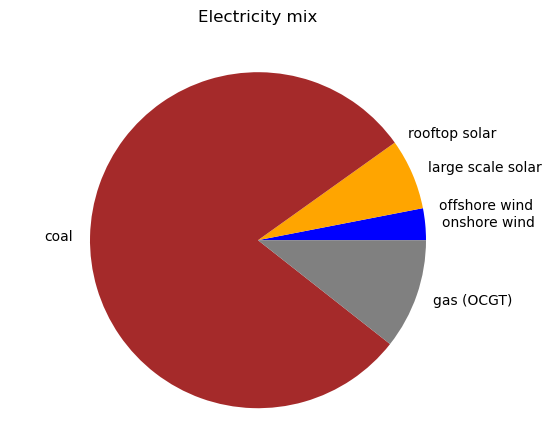

In [23]:
labels = ['onshore wind',
            'offshore wind',
            'large scale solar',
            'rooftop solar',
            'coal',
            'gas (OCGT)']
       
sizes = [network.generators_t.p['onshorewind'].sum(),
            network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['PV'].sum(),
            network.generators_t.p['rooftopPV'].sum(),
            network.generators_t.p['coal'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'darkblue', 'orange', 'yellow', 'brown', 'grey']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

__Installed Capacities of each generator__

In [24]:
network.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind      8.350420
offshorewind     0.000000
PV              33.368777
rooftopPV        0.000000
OCGT            28.614407
coal            48.134363
Name: p_nom_opt, dtype: float64

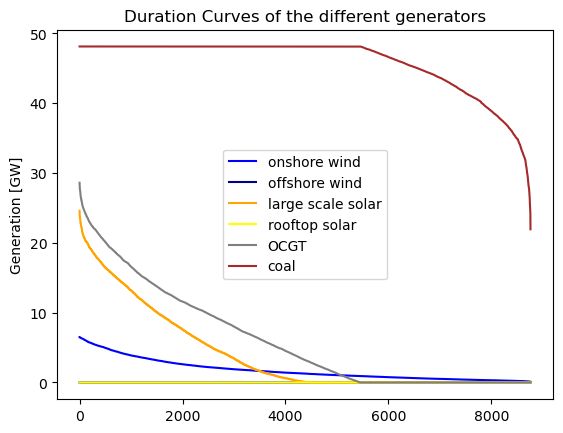

In [25]:
# Duration Curves
cf_onshore = network.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_offshore = network.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_PV = network.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_rooftopPV = network.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_OCGT = network.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)/1e3
cf_coal = network.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)/1e3


cf_onshore.plot(kind='line', ylabel='CF onshore', color='blue')
cf_offshore.plot(kind='line', ylabel='CF offshore', color='darkblue')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='grey')
cf_coal.plot(kind='line', ylabel='CF coal', color='brown')
plt.title('Duration Curves of the different generators')
plt.legend(['onshore wind', 'offshore wind', 'large scale solar', 'rooftop solar', 'OCGT', 'coal'])
plt.ylabel('Generation [GW]')
plt.show()

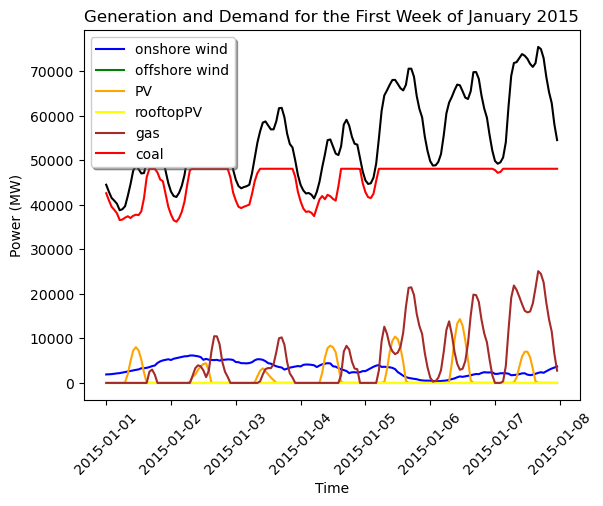

In [26]:
# Plot dispatch for a week in winter
start_date_1 = '2015-01-01'
end_date_1 = '2015-01-07'
week_1 = network.generators_t.p.loc[start_date_1:end_date_1]


plt.plot(week_1['onshorewind'], color='blue', label='onshore wind')
plt.plot(week_1['offshorewind'], color='green', label='offshore wind')
plt.plot(week_1['PV'], color='orange', label='PV')
plt.plot(week_1['rooftopPV'], color='yellow', label='rooftopPV')
plt.plot(week_1['OCGT'], color='brown', label='gas')
plt.plot(week_1['coal'], color='red', label='coal')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.plot(network.loads_t.p['load'].loc[start_date_1:end_date_1], color='black', label='demand')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Generation and Demand for the First Week of January 2015')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

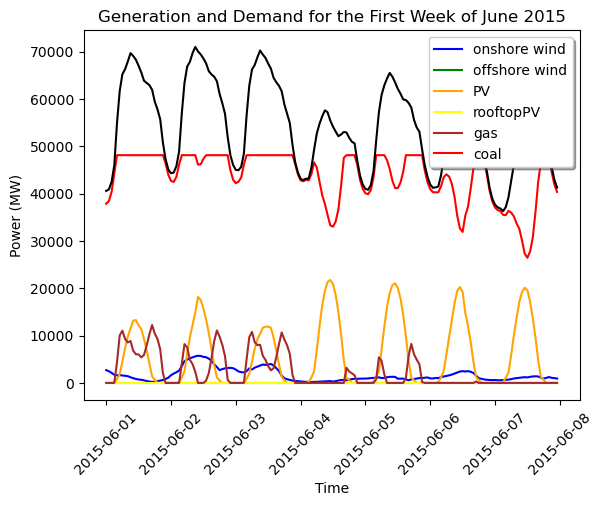

In [27]:
# Plot dispatch for a week in summer
start_date_2 = '2015-06-01'
end_date_2 = '2015-06-07'
week_2 = network.generators_t.p.loc[start_date_2:end_date_2]


plt.plot(week_2['onshorewind'], color='blue', label='onshore wind')
plt.plot(week_2['offshorewind'], color='green', label='offshore wind')
plt.plot(week_2['PV'], color='orange', label='PV')
plt.plot(week_2['rooftopPV'], color='yellow', label='rooftopPV')
plt.plot(week_2['OCGT'], color='brown', label='gas')
plt.plot(week_2['coal'], color='red', label='coal')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.plot(network.loads_t.p['load'].loc[start_date_2:end_date_2], color='black', label='demand')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Generation and Demand for the First Week of June 2015')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [28]:
(network.statistics.capex() + network.statistics.opex()).div(1e6)

           carrier     
Generator  coal            18478.567500
           gas              4388.622204
           offshorewind        0.000000
           onshorewind       632.574687
           rooftopPV           0.000000
           solarPV          1253.449862
dtype: float64

# Section B

__2025 CO2 cap in Germany__

In [29]:
# CO2 emissions in germany (2024): 152 million tonnes
# Source: https://www.ise.fraunhofer.de/en/press-media/press-releases/2025/public-electricity-generation-2024-renewable-energies-cover-more-than-60-percent-of-german-electricity-consumption-for-the-first-time.html
#CO2 price: https://www.dehst.de/SharedDocs/Pressemitteilungen/EN/2020_064_co2-pricing-for-emissions-in-heating-and-transport.html

In [30]:
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=152000000, #152MtCO2
)

In [31]:
network.optimize(solver_name='gurobi')

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.63it/s]
INFO:linopy.io: Writing time: 0.46s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-pmkroq4r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-pmkroq4r.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xba5020d9


INFO:gurobipy:Model fingerprint: 0xba5020d9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.49878728e+12  0.00000000e+00  2.92e+10 0.00e+00  3.47e+09     0s


INFO:gurobipy:   0   5.49878728e+12  0.00000000e+00  2.92e+10 0.00e+00  3.47e+09     0s


   1   7.79016996e+12 -1.14487422e+12  4.49e+09 3.00e+02  6.80e+08     0s


INFO:gurobipy:   1   7.79016996e+12 -1.14487422e+12  4.49e+09 3.00e+02  6.80e+08     0s


   2   5.09937483e+12 -1.40417531e+12  8.02e+07 1.75e-09  5.36e+07     0s


INFO:gurobipy:   2   5.09937483e+12 -1.40417531e+12  8.02e+07 1.75e-09  5.36e+07     0s


   3   8.68003406e+11 -4.27057315e+11  1.16e+07 1.63e-09  1.00e+07     0s


INFO:gurobipy:   3   8.68003406e+11 -4.27057315e+11  1.16e+07 1.63e-09  1.00e+07     0s


   4   7.00004929e+11 -3.54895979e+11  9.13e+06 9.02e-10  8.14e+06     0s


INFO:gurobipy:   4   7.00004929e+11 -3.54895979e+11  9.13e+06 9.02e-10  8.14e+06     0s


   5   3.86900037e+11 -2.27695297e+11  4.66e+06 3.03e-09  4.71e+06     0s


INFO:gurobipy:   5   3.86900037e+11 -2.27695297e+11  4.66e+06 3.03e-09  4.71e+06     0s


   6   2.36826775e+11 -1.25538932e+11  2.61e+06 4.95e-10  2.76e+06     0s


INFO:gurobipy:   6   2.36826775e+11 -1.25538932e+11  2.61e+06 4.95e-10  2.76e+06     0s


   7   1.07063396e+11 -6.26234693e+10  9.09e+05 4.42e-09  1.29e+06     0s


INFO:gurobipy:   7   1.07063396e+11 -6.26234693e+10  9.09e+05 4.42e-09  1.29e+06     0s


   8   7.88214647e+10 -3.39418903e+10  5.67e+05 6.98e-10  8.56e+05     0s


INFO:gurobipy:   8   7.88214647e+10 -3.39418903e+10  5.67e+05 6.98e-10  8.56e+05     0s


   9   6.10843155e+10 -9.59200230e+08  3.52e+05 7.57e-10  4.71e+05     0s


INFO:gurobipy:   9   6.10843155e+10 -9.59200230e+08  3.52e+05 7.57e-10  4.71e+05     0s


  10   4.90475535e+10  8.34832637e+09  2.21e+05 5.53e-10  3.09e+05     0s


INFO:gurobipy:  10   4.90475535e+10  8.34832637e+09  2.21e+05 5.53e-10  3.09e+05     0s


  11   4.72190432e+10  1.30281849e+10  2.03e+05 1.98e-09  2.59e+05     0s


INFO:gurobipy:  11   4.72190432e+10  1.30281849e+10  2.03e+05 1.98e-09  2.59e+05     0s


  12   3.94306610e+10  1.57091507e+10  1.15e+05 2.04e-09  1.80e+05     0s


INFO:gurobipy:  12   3.94306610e+10  1.57091507e+10  1.15e+05 2.04e-09  1.80e+05     0s


  13   3.56481547e+10  1.86316836e+10  7.16e+04 2.56e-09  1.29e+05     0s


INFO:gurobipy:  13   3.56481547e+10  1.86316836e+10  7.16e+04 2.56e-09  1.29e+05     0s


  14   3.31023482e+10  2.29334397e+10  4.31e+04 1.51e-09  7.70e+04     1s


INFO:gurobipy:  14   3.31023482e+10  2.29334397e+10  4.31e+04 1.51e-09  7.70e+04     1s


  15   3.16921021e+10  2.50405124e+10  2.97e+04 1.46e-09  5.04e+04     1s


INFO:gurobipy:  15   3.16921021e+10  2.50405124e+10  2.97e+04 1.46e-09  5.04e+04     1s


  16   3.09601779e+10  2.55306898e+10  2.32e+04 5.82e-10  4.11e+04     1s


INFO:gurobipy:  16   3.09601779e+10  2.55306898e+10  2.32e+04 5.82e-10  4.11e+04     1s


  17   3.04013103e+10  2.63210630e+10  1.83e+04 1.63e-09  3.09e+04     1s


INFO:gurobipy:  17   3.04013103e+10  2.63210630e+10  1.83e+04 1.63e-09  3.09e+04     1s


  18   2.98747553e+10  2.70722078e+10  1.39e+04 1.46e-09  2.12e+04     1s


INFO:gurobipy:  18   2.98747553e+10  2.70722078e+10  1.39e+04 1.46e-09  2.12e+04     1s


  19   2.91916858e+10  2.72979786e+10  8.45e+03 5.82e-10  1.43e+04     1s


INFO:gurobipy:  19   2.91916858e+10  2.72979786e+10  8.45e+03 5.82e-10  1.43e+04     1s


  20   2.89099191e+10  2.75439336e+10  6.24e+03 1.57e-09  1.03e+04     1s


INFO:gurobipy:  20   2.89099191e+10  2.75439336e+10  6.24e+03 1.57e-09  1.03e+04     1s


  21   2.86356269e+10  2.76779225e+10  4.17e+03 8.15e-10  7.25e+03     1s


INFO:gurobipy:  21   2.86356269e+10  2.76779225e+10  4.17e+03 8.15e-10  7.25e+03     1s


  22   2.83903523e+10  2.78102097e+10  2.39e+03 2.91e-11  4.39e+03     1s


INFO:gurobipy:  22   2.83903523e+10  2.78102097e+10  2.39e+03 2.91e-11  4.39e+03     1s


  23   2.82431584e+10  2.78920290e+10  1.39e+03 2.91e-10  2.66e+03     1s


INFO:gurobipy:  23   2.82431584e+10  2.78920290e+10  1.39e+03 2.91e-10  2.66e+03     1s


  24   2.81442632e+10  2.79206323e+10  7.53e+02 6.11e-10  1.69e+03     1s


INFO:gurobipy:  24   2.81442632e+10  2.79206323e+10  7.53e+02 6.11e-10  1.69e+03     1s


  25   2.81041366e+10  2.79532317e+10  5.09e+02 4.66e-10  1.14e+03     1s


INFO:gurobipy:  25   2.81041366e+10  2.79532317e+10  5.09e+02 4.66e-10  1.14e+03     1s


  26   2.80637685e+10  2.79685552e+10  2.72e+02 2.68e-09  7.21e+02     1s


INFO:gurobipy:  26   2.80637685e+10  2.79685552e+10  2.72e+02 2.68e-09  7.21e+02     1s


  27   2.80423451e+10  2.79801343e+10  1.51e+02 7.57e-10  4.71e+02     1s


INFO:gurobipy:  27   2.80423451e+10  2.79801343e+10  1.51e+02 7.57e-10  4.71e+02     1s


  28   2.80324536e+10  2.79962074e+10  9.57e+01 2.33e-10  2.74e+02     1s


INFO:gurobipy:  28   2.80324536e+10  2.79962074e+10  9.57e+01 2.33e-10  2.74e+02     1s


  29   2.80268491e+10  2.79993812e+10  6.68e+01 5.68e-14  2.08e+02     1s


INFO:gurobipy:  29   2.80268491e+10  2.79993812e+10  6.68e+01 5.68e-14  2.08e+02     1s


  30   2.80224050e+10  2.80023112e+10  4.42e+01 3.20e-10  1.52e+02     1s


INFO:gurobipy:  30   2.80224050e+10  2.80023112e+10  4.42e+01 3.20e-10  1.52e+02     1s


  31   2.80185787e+10  2.80066160e+10  2.54e+01 5.82e-10  9.05e+01     1s


INFO:gurobipy:  31   2.80185787e+10  2.80066160e+10  2.54e+01 5.82e-10  9.05e+01     1s


  32   2.80168957e+10  2.80089274e+10  1.72e+01 5.24e-10  6.03e+01     1s


INFO:gurobipy:  32   2.80168957e+10  2.80089274e+10  1.72e+01 5.24e-10  6.03e+01     1s


  33   2.80148614e+10  2.80109213e+10  7.97e+00 1.28e-09  2.98e+01     1s


INFO:gurobipy:  33   2.80148614e+10  2.80109213e+10  7.97e+00 1.28e-09  2.98e+01     1s


  34   2.80139909e+10  2.80117741e+10  3.91e+00 1.05e-09  1.68e+01     1s


INFO:gurobipy:  34   2.80139909e+10  2.80117741e+10  3.91e+00 1.05e-09  1.68e+01     1s


  35   2.80135403e+10  2.80125510e+10  1.97e+00 2.29e-10  7.49e+00     1s


INFO:gurobipy:  35   2.80135403e+10  2.80125510e+10  1.97e+00 2.29e-10  7.49e+00     1s


  36   2.80132580e+10  2.80129542e+10  7.10e-01 1.09e-09  2.30e+00     1s


INFO:gurobipy:  36   2.80132580e+10  2.80129542e+10  7.10e-01 1.09e-09  2.30e+00     1s


  37   2.80130968e+10  2.80130757e+10  5.79e-02 8.73e-11  1.60e-01     1s


INFO:gurobipy:  37   2.80130968e+10  2.80130757e+10  5.79e-02 8.73e-11  1.60e-01     1s


  38   2.80130787e+10  2.80130779e+10  8.19e-04 1.86e-09  5.78e-03     1s


INFO:gurobipy:  38   2.80130787e+10  2.80130779e+10  8.19e-04 1.86e-09  5.78e-03     1s


  39   2.80130783e+10  2.80130783e+10  5.65e-06 2.15e-09  5.81e-06     1s


INFO:gurobipy:  39   2.80130783e+10  2.80130783e+10  5.65e-06 2.15e-09  5.81e-06     1s


  40   2.80130783e+10  2.80130783e+10  1.63e-09 6.69e-09  5.81e-09     1s


INFO:gurobipy:  40   2.80130783e+10  2.80130783e+10  1.63e-09 6.69e-09  5.81e-09     1s


INFO:gurobipy:


Barrier solved model in 40 iterations and 1.20 seconds (0.78 work units)


INFO:gurobipy:Barrier solved model in 40 iterations and 1.20 seconds (0.78 work units)


Optimal objective 2.80130783e+10


INFO:gurobipy:Optimal objective 2.80130783e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     932 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:     932 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6168396e-08      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6168396e-08      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12096    2.8013078e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   12096    2.8013078e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 12096 iterations and 1.76 seconds (3.60 work units)


INFO:gurobipy:Solved in 12096 iterations and 1.76 seconds (3.60 work units)


Optimal objective  2.801307826e+10


INFO:gurobipy:Optimal objective  2.801307826e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.80e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

('ok', 'optimal')

Text(0.5, 1.07, 'Generation mix')

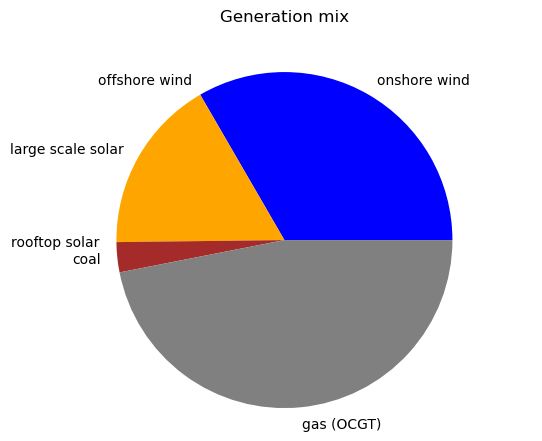

In [32]:

labels = ['onshore wind',
            'offshore wind',
            'large scale solar',
            'rooftop solar',
            'coal',
            'gas (OCGT)']
      
sizes = [network.generators_t.p['onshorewind'].sum(),
            network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['PV'].sum(),
            network.generators_t.p['rooftopPV'].sum(),
            network.generators_t.p['coal'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'darkblue', 'orange', 'yellow', 'brown', 'grey']

plt.pie(sizes,
      colors=colors,
      labels=labels,
      wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Generation mix', y=1.07)



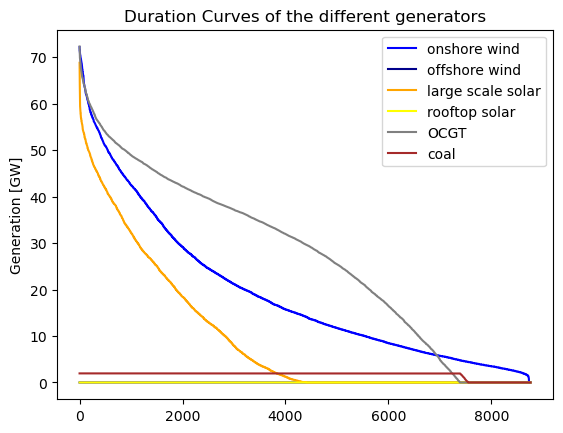

In [33]:
# Duration Curves
cf_onshore = network.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_offshore = network.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_PV = network.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_rooftopPV = network.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_OCGT = network.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)/1e3
cf_coal = network.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)/1e3


cf_onshore.plot(kind='line', ylabel='CF onshore', color='blue')
cf_offshore.plot(kind='line', ylabel='CF offshore', color='darkblue')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='grey')
cf_coal.plot(kind='line', ylabel='CF coal', color='brown')
plt.title('Duration Curves of the different generators')
plt.legend(['onshore wind', 'offshore wind', 'large scale solar', 'rooftop solar', 'OCGT', 'coal'])
plt.ylabel('Generation [GW]')
plt.show()

In [34]:
network.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind     93.144348
offshorewind     0.000000
PV              93.364269
rooftopPV        0.000000
OCGT            72.315298
coal             1.955093
Name: p_nom_opt, dtype: float64

In [35]:
print(f"Total cost: {round(network.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(network.objective/network.loads_t.p.sum().iloc[0]))} EUR/MWh")

Total cost: 28013.08 mio€
Cost per MWh of electricity produced 55 EUR/MWh


__Sensitivity Analysis__

In [36]:
systemcost = []
onwind = []
offwind = []
pv = []
rooftop = []
coal = []
ocgt = []

onwind_cap = []
offwind_cap = []
pv_cap = []
rooftop_cap = []
coal_cap = []
ocgt_cap = []

co2_tax = []


for co2 in [2000, 1500, 1000, 500, 250, 152, 100, 0]: # in MtCO2
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    network.optimize(solver_name="gurobi")
    systemcost.append(network.objective / 1e6)  # in million euros
    onwind.append(network.generators_t.p["onshorewind"].sum())
    offwind.append(network.generators_t.p["offshorewind"].sum())
    pv.append(network.generators_t.p["PV"].sum())
    rooftop.append(network.generators_t.p["rooftopPV"].sum())
    coal.append(network.generators_t.p["coal"].sum())
    ocgt.append(network.generators_t.p["OCGT"].sum())

    onwind_cap.append(network.generators.p_nom_opt.loc["onshorewind"])
    offwind_cap.append(network.generators.p_nom_opt.loc["offshorewind"])
    pv_cap.append(network.generators.p_nom_opt.loc["PV"])
    rooftop_cap.append(network.generators.p_nom_opt.loc["rooftopPV"])
    coal_cap.append(network.generators.p_nom_opt.loc["coal"])
    ocgt_cap.append(network.generators.p_nom_opt.loc["OCGT"])

    co2_tax.append(-network.global_constraints.mu['CO2Limit'])
    
    

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.01it/s]
INFO:linopy.io: Writing time: 0.45s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-z1sq4ux2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-z1sq4ux2.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x96b95d0b


INFO:gurobipy:Model fingerprint: 0x96b95d0b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 61043 rows and 8476 columns


INFO:gurobipy:Presolve removed 61043 rows and 8476 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


INFO:gurobipy:   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


INFO:gurobipy:   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


   3   1.61650436e+11 -2.01317169e+10  1.16e-10 3.22e-01  1.39e+06     0s


INFO:gurobipy:   3   1.61650436e+11 -2.01317169e+10  1.16e-10 3.22e-01  1.39e+06     0s


   4   9.92170059e+10  7.71370830e+09  2.33e-10 1.03e-01  6.96e+05     0s


INFO:gurobipy:   4   9.92170059e+10  7.71370830e+09  2.33e-10 1.03e-01  6.96e+05     0s


   5   6.13372975e+10  1.22646767e+10  2.39e-09 4.12e-02  3.73e+05     0s


INFO:gurobipy:   5   6.13372975e+10  1.22646767e+10  2.39e-09 4.12e-02  3.73e+05     0s


   6   4.89505730e+10  1.61827315e+10  7.57e-10 3.57e-02  2.49e+05     0s


INFO:gurobipy:   6   4.89505730e+10  1.61827315e+10  7.57e-10 3.57e-02  2.49e+05     0s


   7   4.10081204e+10  2.04457327e+10  1.36e-08 8.06e-03  1.56e+05     0s


INFO:gurobipy:   7   4.10081204e+10  2.04457327e+10  1.36e-08 8.06e-03  1.56e+05     0s


   8   4.00328497e+10  2.13247459e+10  2.65e-08 5.72e-03  1.42e+05     0s


INFO:gurobipy:   8   4.00328497e+10  2.13247459e+10  2.65e-08 5.72e-03  1.42e+05     0s


   9   3.35780868e+10  2.23124197e+10  1.07e-07 0.00e+00  8.53e+04     0s


INFO:gurobipy:   9   3.35780868e+10  2.23124197e+10  1.07e-07 0.00e+00  8.53e+04     0s


  10   2.89054547e+10  2.31739019e+10  4.54e-07 4.66e-10  4.34e+04     0s


INFO:gurobipy:  10   2.89054547e+10  2.31739019e+10  4.54e-07 4.66e-10  4.34e+04     0s


  11   2.72997183e+10  2.37155948e+10  4.34e-07 4.07e-10  2.72e+04     0s


INFO:gurobipy:  11   2.72997183e+10  2.37155948e+10  4.34e-07 4.07e-10  2.72e+04     0s


  12   2.64698707e+10  2.38954623e+10  2.21e-07 8.44e-10  1.95e+04     0s


INFO:gurobipy:  12   2.64698707e+10  2.38954623e+10  2.21e-07 8.44e-10  1.95e+04     0s


  13   2.60400183e+10  2.40809592e+10  3.49e-07 1.57e-09  1.48e+04     0s


INFO:gurobipy:  13   2.60400183e+10  2.40809592e+10  3.49e-07 1.57e-09  1.48e+04     0s


  14   2.56994267e+10  2.42218790e+10  1.62e-07 8.73e-10  1.12e+04     0s


INFO:gurobipy:  14   2.56994267e+10  2.42218790e+10  1.62e-07 8.73e-10  1.12e+04     0s


  15   2.54060227e+10  2.43695458e+10  4.92e-07 6.40e-10  7.85e+03     1s


INFO:gurobipy:  15   2.54060227e+10  2.43695458e+10  4.92e-07 6.40e-10  7.85e+03     1s


  16   2.52304373e+10  2.44533951e+10  4.55e-07 2.68e-09  5.89e+03     1s


INFO:gurobipy:  16   2.52304373e+10  2.44533951e+10  4.55e-07 2.68e-09  5.89e+03     1s


  17   2.51347517e+10  2.45220887e+10  6.90e-07 1.11e-09  4.64e+03     1s


INFO:gurobipy:  17   2.51347517e+10  2.45220887e+10  6.90e-07 1.11e-09  4.64e+03     1s


  18   2.50998844e+10  2.45657197e+10  1.41e-06 1.46e-10  4.05e+03     1s


INFO:gurobipy:  18   2.50998844e+10  2.45657197e+10  1.41e-06 1.46e-10  4.05e+03     1s


  19   2.50854757e+10  2.45987608e+10  9.27e-07 1.40e-09  3.69e+03     1s


INFO:gurobipy:  19   2.50854757e+10  2.45987608e+10  9.27e-07 1.40e-09  3.69e+03     1s


  20   2.50127867e+10  2.46419299e+10  6.96e-06 3.20e-10  2.81e+03     1s


INFO:gurobipy:  20   2.50127867e+10  2.46419299e+10  6.96e-06 3.20e-10  2.81e+03     1s


  21   2.49285243e+10  2.46586364e+10  8.81e-06 3.49e-10  2.04e+03     1s


INFO:gurobipy:  21   2.49285243e+10  2.46586364e+10  8.81e-06 3.49e-10  2.04e+03     1s


  22   2.48862002e+10  2.46768936e+10  7.88e-06 1.51e-09  1.59e+03     1s


INFO:gurobipy:  22   2.48862002e+10  2.46768936e+10  7.88e-06 1.51e-09  1.59e+03     1s


  23   2.48588825e+10  2.46982403e+10  6.43e-06 8.73e-10  1.22e+03     1s


INFO:gurobipy:  23   2.48588825e+10  2.46982403e+10  6.43e-06 8.73e-10  1.22e+03     1s


  24   2.48304054e+10  2.47050067e+10  5.54e-06 7.28e-10  9.50e+02     1s


INFO:gurobipy:  24   2.48304054e+10  2.47050067e+10  5.54e-06 7.28e-10  9.50e+02     1s


  25   2.48079011e+10  2.47164594e+10  4.79e-06 7.57e-10  6.93e+02     1s


INFO:gurobipy:  25   2.48079011e+10  2.47164594e+10  4.79e-06 7.57e-10  6.93e+02     1s


  26   2.47999834e+10  2.47236749e+10  4.67e-06 1.57e-09  5.78e+02     1s


INFO:gurobipy:  26   2.47999834e+10  2.47236749e+10  4.67e-06 1.57e-09  5.78e+02     1s


  27   2.47907317e+10  2.47273681e+10  3.80e-06 1.69e-09  4.80e+02     1s


INFO:gurobipy:  27   2.47907317e+10  2.47273681e+10  3.80e-06 1.69e-09  4.80e+02     1s


  28   2.47785678e+10  2.47333915e+10  3.28e-06 5.24e-10  3.42e+02     1s


INFO:gurobipy:  28   2.47785678e+10  2.47333915e+10  3.28e-06 5.24e-10  3.42e+02     1s


  29   2.47748985e+10  2.47370889e+10  2.30e-06 7.57e-10  2.87e+02     1s


INFO:gurobipy:  29   2.47748985e+10  2.47370889e+10  2.30e-06 7.57e-10  2.87e+02     1s


  30   2.47723575e+10  2.47393164e+10  1.68e-06 3.78e-10  2.50e+02     1s


INFO:gurobipy:  30   2.47723575e+10  2.47393164e+10  1.68e-06 3.78e-10  2.50e+02     1s


  31   2.47684473e+10  2.47411024e+10  1.83e-06 1.05e-09  2.07e+02     1s


INFO:gurobipy:  31   2.47684473e+10  2.47411024e+10  1.83e-06 1.05e-09  2.07e+02     1s


  32   2.47651731e+10  2.47420360e+10  8.33e-07 1.92e-09  1.75e+02     1s


INFO:gurobipy:  32   2.47651731e+10  2.47420360e+10  8.33e-07 1.92e-09  1.75e+02     1s


  33   2.47637034e+10  2.47433311e+10  8.10e-07 3.64e-10  1.54e+02     1s


INFO:gurobipy:  33   2.47637034e+10  2.47433311e+10  8.10e-07 3.64e-10  1.54e+02     1s


  34   2.47611418e+10  2.47445990e+10  1.36e-06 1.57e-09  1.25e+02     1s


INFO:gurobipy:  34   2.47611418e+10  2.47445990e+10  1.36e-06 1.57e-09  1.25e+02     1s


  35   2.47598898e+10  2.47456099e+10  8.97e-07 0.00e+00  1.08e+02     1s


INFO:gurobipy:  35   2.47598898e+10  2.47456099e+10  8.97e-07 0.00e+00  1.08e+02     1s


  36   2.47586575e+10  2.47464062e+10  3.75e-07 1.57e-09  9.29e+01     1s


INFO:gurobipy:  36   2.47586575e+10  2.47464062e+10  3.75e-07 1.57e-09  9.29e+01     1s


  37   2.47574451e+10  2.47472551e+10  2.70e-07 1.16e-09  7.73e+01     1s


INFO:gurobipy:  37   2.47574451e+10  2.47472551e+10  2.70e-07 1.16e-09  7.73e+01     1s


  38   2.47566576e+10  2.47484507e+10  3.67e-07 3.78e-10  6.23e+01     1s


INFO:gurobipy:  38   2.47566576e+10  2.47484507e+10  3.67e-07 3.78e-10  6.23e+01     1s


  39   2.47556936e+10  2.47488288e+10  6.65e-07 5.02e-10  5.21e+01     1s


INFO:gurobipy:  39   2.47556936e+10  2.47488288e+10  6.65e-07 5.02e-10  5.21e+01     1s


  40   2.47556091e+10  2.47491687e+10  6.70e-07 8.15e-10  4.89e+01     1s


INFO:gurobipy:  40   2.47556091e+10  2.47491687e+10  6.70e-07 8.15e-10  4.89e+01     1s


  41   2.47549915e+10  2.47497695e+10  5.32e-07 4.55e-10  3.96e+01     1s


INFO:gurobipy:  41   2.47549915e+10  2.47497695e+10  5.32e-07 4.55e-10  3.96e+01     1s


  42   2.47544380e+10  2.47500374e+10  7.04e-07 7.57e-10  3.34e+01     1s


INFO:gurobipy:  42   2.47544380e+10  2.47500374e+10  7.04e-07 7.57e-10  3.34e+01     1s


  43   2.47540658e+10  2.47505920e+10  8.17e-07 4.66e-10  2.64e+01     1s


INFO:gurobipy:  43   2.47540658e+10  2.47505920e+10  8.17e-07 4.66e-10  2.64e+01     1s


  44   2.47535653e+10  2.47512418e+10  1.90e-06 1.86e-09  1.77e+01     1s


INFO:gurobipy:  44   2.47535653e+10  2.47512418e+10  1.90e-06 1.86e-09  1.77e+01     1s


  45   2.47534513e+10  2.47514727e+10  1.21e-06 1.49e-09  1.50e+01     1s


INFO:gurobipy:  45   2.47534513e+10  2.47514727e+10  1.21e-06 1.49e-09  1.50e+01     1s


  46   2.47534053e+10  2.47518569e+10  4.87e-06 2.03e-09  1.18e+01     1s


INFO:gurobipy:  46   2.47534053e+10  2.47518569e+10  4.87e-06 2.03e-09  1.18e+01     1s


  47   2.47533767e+10  2.47520106e+10  7.37e-06 2.10e-09  1.04e+01     1s


INFO:gurobipy:  47   2.47533767e+10  2.47520106e+10  7.37e-06 2.10e-09  1.04e+01     1s


  48   2.47532815e+10  2.47523634e+10  1.71e-05 1.40e-09  6.98e+00     1s


INFO:gurobipy:  48   2.47532815e+10  2.47523634e+10  1.71e-05 1.40e-09  6.98e+00     1s


  49   2.47532632e+10  2.47525160e+10  1.91e-05 5.24e-10  5.68e+00     1s


INFO:gurobipy:  49   2.47532632e+10  2.47525160e+10  1.91e-05 5.24e-10  5.68e+00     1s


  50   2.47532324e+10  2.47528630e+10  2.01e-05 1.16e-09  2.81e+00     1s


INFO:gurobipy:  50   2.47532324e+10  2.47528630e+10  2.01e-05 1.16e-09  2.81e+00     1s


  51   2.47532297e+10  2.47528719e+10  1.88e-05 1.88e-09  2.72e+00     1s


INFO:gurobipy:  51   2.47532297e+10  2.47528719e+10  1.88e-05 1.88e-09  2.72e+00     1s


  52   2.47532234e+10  2.47529458e+10  1.60e-05 4.94e-09  2.11e+00     1s


INFO:gurobipy:  52   2.47532234e+10  2.47529458e+10  1.60e-05 4.94e-09  2.11e+00     1s


  53   2.47532184e+10  2.47530407e+10  1.03e-05 3.19e-09  1.35e+00     1s


INFO:gurobipy:  53   2.47532184e+10  2.47530407e+10  1.03e-05 3.19e-09  1.35e+00     1s


  54   2.47532169e+10  2.47530489e+10  7.74e-06 3.71e-10  1.28e+00     1s


INFO:gurobipy:  54   2.47532169e+10  2.47530489e+10  7.74e-06 3.71e-10  1.28e+00     1s


  55   2.47532168e+10  2.47530708e+10  6.78e-06 4.95e-10  1.11e+00     1s


INFO:gurobipy:  55   2.47532168e+10  2.47530708e+10  6.78e-06 4.95e-10  1.11e+00     1s


  56   2.47532154e+10  2.47530928e+10  5.86e-06 4.07e-10  9.33e-01     1s


INFO:gurobipy:  56   2.47532154e+10  2.47530928e+10  5.86e-06 4.07e-10  9.33e-01     1s


  57   2.47532156e+10  2.47531318e+10  5.42e-06 4.66e-09  6.37e-01     1s


INFO:gurobipy:  57   2.47532156e+10  2.47531318e+10  5.42e-06 4.66e-09  6.37e-01     1s


  58   2.47532155e+10  2.47532108e+10  3.17e-06 1.29e-08  3.61e-02     1s


INFO:gurobipy:  58   2.47532155e+10  2.47532108e+10  3.17e-06 1.29e-08  3.61e-02     1s


  59   2.47532143e+10  2.47532142e+10  3.86e-08 1.22e-09  7.79e-04     1s


INFO:gurobipy:  59   2.47532143e+10  2.47532142e+10  3.86e-08 1.22e-09  7.79e-04     1s


  60   2.47532143e+10  2.47532143e+10  9.02e-10 1.75e-10  1.24e-05     1s


INFO:gurobipy:  60   2.47532143e+10  2.47532143e+10  9.02e-10 1.75e-10  1.24e-05     1s


  61   2.47532143e+10  2.47532143e+10  8.73e-11 1.51e-09  5.65e-10     1s


INFO:gurobipy:  61   2.47532143e+10  2.47532143e+10  8.73e-11 1.51e-09  5.65e-10     1s


INFO:gurobipy:


Barrier solved model in 61 iterations and 1.44 seconds (1.15 work units)


INFO:gurobipy:Barrier solved model in 61 iterations and 1.44 seconds (1.15 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6040581e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6040581e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13313    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13313    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13313 iterations and 1.62 seconds (1.22 work units)


INFO:gurobipy:Solved in 13313 iterations and 1.62 seconds (1.22 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 31.25it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-jm_qzmno.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-jm_qzmno.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x0ee7df54


INFO:gurobipy:Model fingerprint: 0x0ee7df54


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.31893456e+13  0.00000000e+00  1.24e+11 0.00e+00  1.35e+10     0s


INFO:gurobipy:   0   2.31893456e+13  0.00000000e+00  1.24e+11 0.00e+00  1.35e+10     0s


   1   3.24162238e+13 -1.94195084e+12  1.96e+10 2.76e+02  2.67e+09     0s


INFO:gurobipy:   1   3.24162238e+13 -1.94195084e+12  1.96e+10 2.76e+02  2.67e+09     0s


   2   2.06813565e+13 -2.06451170e+12  1.01e+09 1.16e-09  2.28e+08     0s


INFO:gurobipy:   2   2.06813565e+13 -2.06451170e+12  1.01e+09 1.16e-09  2.28e+08     0s


   3   4.46546317e+12 -1.39915006e+12  1.78e+08 1.31e-09  5.56e+07     0s


INFO:gurobipy:   3   4.46546317e+12 -1.39915006e+12  1.78e+08 1.31e-09  5.56e+07     0s


   4   9.65979510e+11 -7.06743766e+11  1.45e+04 1.34e-09  1.34e+07     0s


INFO:gurobipy:   4   9.65979510e+11 -7.06743766e+11  1.45e+04 1.34e-09  1.34e+07     0s


   5   3.35196583e+11 -2.46578335e+11  4.44e+03 3.61e-09  4.52e+06     0s


INFO:gurobipy:   5   3.35196583e+11 -2.46578335e+11  4.44e+03 3.61e-09  4.52e+06     0s


   6   1.26987085e+11 -5.64302947e+10  1.37e+03 4.60e-09  1.41e+06     0s


INFO:gurobipy:   6   1.26987085e+11 -5.64302947e+10  1.37e+03 4.60e-09  1.41e+06     0s


   7   5.63766087e+10 -1.65187341e+10  4.02e+02 1.57e-09  5.56e+05     0s


INFO:gurobipy:   7   5.63766087e+10 -1.65187341e+10  4.02e+02 1.57e-09  5.56e+05     0s


   8   4.40372306e+10 -4.88300361e+08  2.46e+02 2.50e-09  3.39e+05     0s


INFO:gurobipy:   8   4.40372306e+10 -4.88300361e+08  2.46e+02 2.50e-09  3.39e+05     0s


   9   4.02978678e+10  1.25875706e+10  2.02e+02 1.16e-09  2.11e+05     0s


INFO:gurobipy:   9   4.02978678e+10  1.25875706e+10  2.02e+02 1.16e-09  2.11e+05     0s


  10   3.69035505e+10  1.89107912e+10  1.60e+02 2.10e-09  1.37e+05     0s


INFO:gurobipy:  10   3.69035505e+10  1.89107912e+10  1.60e+02 2.10e-09  1.37e+05     0s


  11   3.07134357e+10  2.09145535e+10  7.46e+01 1.63e-09  7.47e+04     0s


INFO:gurobipy:  11   3.07134357e+10  2.09145535e+10  7.46e+01 1.63e-09  7.47e+04     0s


  12   2.86567662e+10  2.16359276e+10  4.90e+01 6.98e-10  5.34e+04     0s


INFO:gurobipy:  12   2.86567662e+10  2.16359276e+10  4.90e+01 6.98e-10  5.34e+04     0s


  13   2.75763760e+10  2.22052140e+10  3.44e+01 1.22e-09  4.09e+04     0s


INFO:gurobipy:  13   2.75763760e+10  2.22052140e+10  3.44e+01 1.22e-09  4.09e+04     0s


  14   2.68284846e+10  2.27566115e+10  2.51e+01 2.50e-09  3.10e+04     1s


INFO:gurobipy:  14   2.68284846e+10  2.27566115e+10  2.51e+01 2.50e-09  3.10e+04     1s


  15   2.62628989e+10  2.33537749e+10  1.81e+01 2.91e-10  2.21e+04     1s


INFO:gurobipy:  15   2.62628989e+10  2.33537749e+10  1.81e+01 2.91e-10  2.21e+04     1s


  16   2.58202584e+10  2.36998553e+10  1.27e+01 8.73e-11  1.61e+04     1s


INFO:gurobipy:  16   2.58202584e+10  2.36998553e+10  1.27e+01 8.73e-11  1.61e+04     1s


  17   2.55570032e+10  2.39981361e+10  9.54e+00 8.73e-11  1.18e+04     1s


INFO:gurobipy:  17   2.55570032e+10  2.39981361e+10  9.54e+00 8.73e-11  1.18e+04     1s


  18   2.53876865e+10  2.40692542e+10  7.54e+00 2.10e-09  1.00e+04     1s


INFO:gurobipy:  18   2.53876865e+10  2.40692542e+10  7.54e+00 2.10e-09  1.00e+04     1s


  19   2.52237404e+10  2.41445558e+10  5.65e+00 9.02e-10  8.20e+03     1s


INFO:gurobipy:  19   2.52237404e+10  2.41445558e+10  5.65e+00 9.02e-10  8.20e+03     1s


  20   2.51502445e+10  2.42193159e+10  4.76e+00 6.98e-10  7.07e+03     1s


INFO:gurobipy:  20   2.51502445e+10  2.42193159e+10  4.76e+00 6.98e-10  7.07e+03     1s


  21   2.51156619e+10  2.43328363e+10  4.27e+00 3.49e-10  5.95e+03     1s


INFO:gurobipy:  21   2.51156619e+10  2.43328363e+10  4.27e+00 3.49e-10  5.95e+03     1s


  22   2.50338918e+10  2.44988432e+10  2.99e+00 1.80e-09  4.06e+03     1s


INFO:gurobipy:  22   2.50338918e+10  2.44988432e+10  2.99e+00 1.80e-09  4.06e+03     1s


  23   2.49590326e+10  2.45671205e+10  2.13e+00 5.82e-10  2.98e+03     1s


INFO:gurobipy:  23   2.49590326e+10  2.45671205e+10  2.13e+00 5.82e-10  2.98e+03     1s


  24   2.49387166e+10  2.46083914e+10  1.93e+00 2.68e-09  2.51e+03     1s


INFO:gurobipy:  24   2.49387166e+10  2.46083914e+10  1.93e+00 2.68e-09  2.51e+03     1s


  25   2.48807459e+10  2.46252664e+10  1.31e+00 2.27e-09  1.94e+03     1s


INFO:gurobipy:  25   2.48807459e+10  2.46252664e+10  1.31e+00 2.27e-09  1.94e+03     1s


  26   2.48622928e+10  2.46428064e+10  1.12e+00 3.49e-10  1.67e+03     1s


INFO:gurobipy:  26   2.48622928e+10  2.46428064e+10  1.12e+00 3.49e-10  1.67e+03     1s


  27   2.48491680e+10  2.46530121e+10  9.91e-01 2.62e-10  1.49e+03     1s


INFO:gurobipy:  27   2.48491680e+10  2.46530121e+10  9.91e-01 2.62e-10  1.49e+03     1s


  28   2.48402530e+10  2.46589713e+10  8.98e-01 7.57e-10  1.38e+03     1s


INFO:gurobipy:  28   2.48402530e+10  2.46589713e+10  8.98e-01 7.57e-10  1.38e+03     1s


  29   2.48272198e+10  2.46750678e+10  7.60e-01 2.15e-09  1.15e+03     1s


INFO:gurobipy:  29   2.48272198e+10  2.46750678e+10  7.60e-01 2.15e-09  1.15e+03     1s


  30   2.48130091e+10  2.46898451e+10  6.12e-01 3.20e-10  9.35e+02     1s


INFO:gurobipy:  30   2.48130091e+10  2.46898451e+10  6.12e-01 3.20e-10  9.35e+02     1s


  31   2.48062438e+10  2.46958535e+10  5.38e-01 5.24e-10  8.38e+02     1s


INFO:gurobipy:  31   2.48062438e+10  2.46958535e+10  5.38e-01 5.24e-10  8.38e+02     1s


  32   2.47919766e+10  2.47102891e+10  3.88e-01 6.11e-10  6.20e+02     1s


INFO:gurobipy:  32   2.47919766e+10  2.47102891e+10  3.88e-01 6.11e-10  6.20e+02     1s


  33   2.47881318e+10  2.47127432e+10  3.47e-01 6.98e-10  5.72e+02     1s


INFO:gurobipy:  33   2.47881318e+10  2.47127432e+10  3.47e-01 6.98e-10  5.72e+02     1s


  34   2.47818392e+10  2.47199814e+10  2.82e-01 1.86e-10  4.69e+02     1s


INFO:gurobipy:  34   2.47818392e+10  2.47199814e+10  2.82e-01 1.86e-10  4.69e+02     1s


  35   2.47786560e+10  2.47231715e+10  2.49e-01 1.46e-10  4.21e+02     1s


INFO:gurobipy:  35   2.47786560e+10  2.47231715e+10  2.49e-01 1.46e-10  4.21e+02     1s


  36   2.47687456e+10  2.47265373e+10  1.48e-01 1.02e-09  3.20e+02     1s


INFO:gurobipy:  36   2.47687456e+10  2.47265373e+10  1.48e-01 1.02e-09  3.20e+02     1s


  37   2.47664870e+10  2.47282056e+10  1.24e-01 7.86e-10  2.90e+02     1s


INFO:gurobipy:  37   2.47664870e+10  2.47282056e+10  1.24e-01 7.86e-10  2.90e+02     1s


  38   2.47631241e+10  2.47354613e+10  9.13e-02 3.20e-10  2.10e+02     1s


INFO:gurobipy:  38   2.47631241e+10  2.47354613e+10  9.13e-02 3.20e-10  2.10e+02     1s


  39   2.47622226e+10  2.47370625e+10  8.30e-02 6.40e-10  1.91e+02     1s


INFO:gurobipy:  39   2.47622226e+10  2.47370625e+10  8.30e-02 6.40e-10  1.91e+02     1s


  40   2.47609470e+10  2.47382647e+10  7.11e-02 2.10e-09  1.72e+02     1s


INFO:gurobipy:  40   2.47609470e+10  2.47382647e+10  7.11e-02 2.10e-09  1.72e+02     1s


  41   2.47593806e+10  2.47395646e+10  5.60e-02 6.40e-10  1.50e+02     1s


INFO:gurobipy:  41   2.47593806e+10  2.47395646e+10  5.60e-02 6.40e-10  1.50e+02     1s


  42   2.47579969e+10  2.47405244e+10  4.34e-02 2.91e-10  1.32e+02     1s


INFO:gurobipy:  42   2.47579969e+10  2.47405244e+10  4.34e-02 2.91e-10  1.32e+02     1s


  43   2.47578173e+10  2.47416264e+10  4.18e-02 7.28e-10  1.23e+02     1s


INFO:gurobipy:  43   2.47578173e+10  2.47416264e+10  4.18e-02 7.28e-10  1.23e+02     1s


  44   2.47570124e+10  2.47433307e+10  3.40e-02 2.62e-10  1.04e+02     1s


INFO:gurobipy:  44   2.47570124e+10  2.47433307e+10  3.40e-02 2.62e-10  1.04e+02     1s


  45   2.47564224e+10  2.47451622e+10  2.82e-02 2.33e-09  8.53e+01     1s


INFO:gurobipy:  45   2.47564224e+10  2.47451622e+10  2.82e-02 2.33e-09  8.53e+01     1s


  46   2.47559965e+10  2.47453429e+10  2.43e-02 3.20e-10  8.07e+01     1s


INFO:gurobipy:  46   2.47559965e+10  2.47453429e+10  2.43e-02 3.20e-10  8.07e+01     1s


  47   2.47555449e+10  2.47483506e+10  2.02e-02 1.44e-09  5.45e+01     1s


INFO:gurobipy:  47   2.47555449e+10  2.47483506e+10  2.02e-02 1.44e-09  5.45e+01     1s


  48   2.47550938e+10  2.47494941e+10  1.61e-02 1.39e-09  4.24e+01     1s


INFO:gurobipy:  48   2.47550938e+10  2.47494941e+10  1.61e-02 1.39e-09  4.24e+01     1s


  49   2.47545325e+10  2.47501245e+10  1.10e-02 1.57e-09  3.34e+01     1s


INFO:gurobipy:  49   2.47545325e+10  2.47501245e+10  1.10e-02 1.57e-09  3.34e+01     1s


  50   2.47540319e+10  2.47503239e+10  6.82e-03 1.28e-09  2.81e+01     1s


INFO:gurobipy:  50   2.47540319e+10  2.47503239e+10  6.82e-03 1.28e-09  2.81e+01     1s


  51   2.47536840e+10  2.47513002e+10  3.60e-03 1.12e-09  1.80e+01     1s


INFO:gurobipy:  51   2.47536840e+10  2.47513002e+10  3.60e-03 1.12e-09  1.80e+01     1s


  52   2.47534285e+10  2.47517077e+10  1.48e-03 9.90e-10  1.30e+01     1s


INFO:gurobipy:  52   2.47534285e+10  2.47517077e+10  1.48e-03 9.90e-10  1.30e+01     1s


  53   2.47533122e+10  2.47526313e+10  6.17e-04 1.98e-09  5.15e+00     2s


INFO:gurobipy:  53   2.47533122e+10  2.47526313e+10  6.17e-04 1.98e-09  5.15e+00     2s


  54   2.47532594e+10  2.47527118e+10  2.45e-04 2.44e-09  4.14e+00     2s


INFO:gurobipy:  54   2.47532594e+10  2.47527118e+10  2.45e-04 2.44e-09  4.14e+00     2s


  55   2.47532460e+10  2.47528449e+10  1.64e-04 1.75e-09  3.03e+00     2s


INFO:gurobipy:  55   2.47532460e+10  2.47528449e+10  1.64e-04 1.75e-09  3.03e+00     2s


  56   2.47532220e+10  2.47530123e+10  1.66e-05 3.32e-09  1.59e+00     2s


INFO:gurobipy:  56   2.47532220e+10  2.47530123e+10  1.66e-05 3.32e-09  1.59e+00     2s


  57   2.47532168e+10  2.47530157e+10  5.81e-06 5.82e-10  1.52e+00     2s


INFO:gurobipy:  57   2.47532168e+10  2.47530157e+10  5.81e-06 5.82e-10  1.52e+00     2s


  58   2.47532171e+10  2.47530592e+10  4.47e-06 4.23e-09  1.19e+00     2s


INFO:gurobipy:  58   2.47532171e+10  2.47530592e+10  4.47e-06 4.23e-09  1.19e+00     2s


  59   2.47532168e+10  2.47530802e+10  4.38e-06 3.29e-09  1.03e+00     2s


INFO:gurobipy:  59   2.47532168e+10  2.47530802e+10  4.38e-06 3.29e-09  1.03e+00     2s


  60   2.47532161e+10  2.47531600e+10  3.95e-06 5.47e-09  4.24e-01     2s


INFO:gurobipy:  60   2.47532161e+10  2.47531600e+10  3.95e-06 5.47e-09  4.24e-01     2s


  61   2.47532144e+10  2.47532139e+10  4.53e-06 2.50e-09  3.45e-03     2s


INFO:gurobipy:  61   2.47532144e+10  2.47532139e+10  4.53e-06 2.50e-09  3.45e-03     2s


  62   2.47532143e+10  2.47532143e+10  1.66e-07 9.90e-10  4.42e-06     2s


INFO:gurobipy:  62   2.47532143e+10  2.47532143e+10  1.66e-07 9.90e-10  4.42e-06     2s


  63   2.47532143e+10  2.47532143e+10  2.44e-07 4.37e-09  4.43e-12     2s


INFO:gurobipy:  63   2.47532143e+10  2.47532143e+10  2.44e-07 4.37e-09  4.43e-12     2s


INFO:gurobipy:


Barrier solved model in 63 iterations and 1.67 seconds (1.19 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 1.67 seconds (1.19 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13301 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13301 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7205312e-11      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7205312e-11      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13304    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13304    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13304 iterations and 1.88 seconds (1.27 work units)


INFO:gurobipy:Solved in 13304 iterations and 1.88 seconds (1.27 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 29.94it/s]
INFO:linopy.io: Writing time: 0.46s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-e5h3_j3a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-e5h3_j3a.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xfe0d4387


INFO:gurobipy:Model fingerprint: 0xfe0d4387


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+09]


INFO:gurobipy:  RHS range        [4e+04, 1e+09]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.45442347e+13  0.00000000e+00  7.74e+10 0.00e+00  8.61e+09     0s


INFO:gurobipy:   0   1.45442347e+13  0.00000000e+00  7.74e+10 0.00e+00  8.61e+09     0s


   1   2.03935537e+13 -1.64710150e+12  1.22e+10 2.81e+02  1.70e+09     0s


INFO:gurobipy:   1   2.03935537e+13 -1.64710150e+12  1.22e+10 2.81e+02  1.70e+09     0s


   2   1.30909958e+13 -1.83879280e+12  5.50e+08 7.02e-10  1.43e+08     0s


INFO:gurobipy:   2   1.30909958e+13 -1.83879280e+12  5.50e+08 7.02e-10  1.43e+08     0s


   3   1.90396976e+12 -1.28300920e+12  5.76e+07 7.57e-10  2.78e+07     0s


INFO:gurobipy:   3   1.90396976e+12 -1.28300920e+12  5.76e+07 7.57e-10  2.78e+07     0s


   4   5.90325030e+11 -3.78084789e+11  6.98e+03 2.97e-09  7.64e+06     0s


INFO:gurobipy:   4   5.90325030e+11 -3.78084789e+11  6.98e+03 2.97e-09  7.64e+06     0s


   5   1.70414663e+11 -8.90977277e+10  1.63e+03 3.09e-09  1.99e+06     0s


INFO:gurobipy:   5   1.70414663e+11 -8.90977277e+10  1.63e+03 3.09e-09  1.99e+06     0s


   6   8.77446883e+10 -4.26799526e+10  6.87e+02 1.86e-09  9.97e+05     0s


INFO:gurobipy:   6   8.77446883e+10 -4.26799526e+10  6.87e+02 1.86e-09  9.97e+05     0s


   7   4.72630515e+10 -1.35584967e+10  2.33e+02 9.90e-10  4.63e+05     0s


INFO:gurobipy:   7   4.72630515e+10 -1.35584967e+10  2.33e+02 9.90e-10  4.63e+05     0s


   8   4.48498554e+10 -6.45911402e+08  2.08e+02 9.31e-10  3.46e+05     0s


INFO:gurobipy:   8   4.48498554e+10 -6.45911402e+08  2.08e+02 9.31e-10  3.46e+05     0s


   9   4.09574821e+10  1.15375483e+10  1.69e+02 1.51e-09  2.24e+05     0s


INFO:gurobipy:   9   4.09574821e+10  1.15375483e+10  1.69e+02 1.51e-09  2.24e+05     0s


  10   3.33041571e+10  1.70222349e+10  8.56e+01 1.57e-09  1.24e+05     0s


INFO:gurobipy:  10   3.33041571e+10  1.70222349e+10  8.56e+01 1.57e-09  1.24e+05     0s


  11   2.93536002e+10  1.90016870e+10  4.45e+01 3.49e-10  7.86e+04     0s


INFO:gurobipy:  11   2.93536002e+10  1.90016870e+10  4.45e+01 3.49e-10  7.86e+04     0s


  12   2.82374395e+10  1.97790668e+10  3.31e+01 3.32e-09  6.42e+04     0s


INFO:gurobipy:  12   2.82374395e+10  1.97790668e+10  3.31e+01 3.32e-09  6.42e+04     0s


  13   2.73377013e+10  2.07002243e+10  2.39e+01 2.44e-09  5.04e+04     0s


INFO:gurobipy:  13   2.73377013e+10  2.07002243e+10  2.39e+01 2.44e-09  5.04e+04     0s


  14   2.67227980e+10  2.14912199e+10  1.77e+01 4.95e-10  3.97e+04     0s


INFO:gurobipy:  14   2.67227980e+10  2.14912199e+10  1.77e+01 4.95e-10  3.97e+04     0s


  15   2.62143662e+10  2.25822029e+10  1.28e+01 1.46e-09  2.76e+04     0s


INFO:gurobipy:  15   2.62143662e+10  2.25822029e+10  1.28e+01 1.46e-09  2.76e+04     0s


  16   2.59405094e+10  2.32195658e+10  1.03e+01 4.37e-10  2.06e+04     0s


INFO:gurobipy:  16   2.59405094e+10  2.32195658e+10  1.03e+01 4.37e-10  2.06e+04     0s


  17   2.56602197e+10  2.37620522e+10  7.73e+00 2.47e-10  1.44e+04     0s


INFO:gurobipy:  17   2.56602197e+10  2.37620522e+10  7.73e+00 2.47e-10  1.44e+04     0s


  18   2.54410570e+10  2.38812044e+10  5.80e+00 9.31e-10  1.18e+04     0s


INFO:gurobipy:  18   2.54410570e+10  2.38812044e+10  5.80e+00 9.31e-10  1.18e+04     0s


  19   2.53433681e+10  2.39508489e+10  4.95e+00 5.53e-10  1.06e+04     0s


INFO:gurobipy:  19   2.53433681e+10  2.39508489e+10  4.95e+00 5.53e-10  1.06e+04     0s


  20   2.52230545e+10  2.41009212e+10  3.87e+00 1.80e-09  8.51e+03     1s


INFO:gurobipy:  20   2.52230545e+10  2.41009212e+10  3.87e+00 1.80e-09  8.51e+03     1s


  21   2.51157771e+10  2.43163180e+10  2.94e+00 6.98e-10  6.06e+03     1s


INFO:gurobipy:  21   2.51157771e+10  2.43163180e+10  2.94e+00 6.98e-10  6.06e+03     1s


  22   2.50605254e+10  2.44443683e+10  2.47e+00 2.62e-10  4.67e+03     1s


INFO:gurobipy:  22   2.50605254e+10  2.44443683e+10  2.47e+00 2.62e-10  4.67e+03     1s


  23   2.49890662e+10  2.44892934e+10  1.88e+00 5.82e-10  3.79e+03     1s


INFO:gurobipy:  23   2.49890662e+10  2.44892934e+10  1.88e+00 5.82e-10  3.79e+03     1s


  24   2.49511326e+10  2.45168947e+10  1.56e+00 8.15e-10  3.29e+03     1s


INFO:gurobipy:  24   2.49511326e+10  2.45168947e+10  1.56e+00 8.15e-10  3.29e+03     1s


  25   2.49145080e+10  2.45866497e+10  1.23e+00 1.57e-09  2.49e+03     1s


INFO:gurobipy:  25   2.49145080e+10  2.45866497e+10  1.23e+00 1.57e-09  2.49e+03     1s


  26   2.48611860e+10  2.46422585e+10  7.78e-01 4.07e-10  1.66e+03     1s


INFO:gurobipy:  26   2.48611860e+10  2.46422585e+10  7.78e-01 4.07e-10  1.66e+03     1s


  27   2.48428389e+10  2.46458105e+10  6.22e-01 3.24e-10  1.49e+03     1s


INFO:gurobipy:  27   2.48428389e+10  2.46458105e+10  6.22e-01 3.24e-10  1.49e+03     1s


  28   2.48271595e+10  2.46801391e+10  4.95e-01 1.11e-09  1.11e+03     1s


INFO:gurobipy:  28   2.48271595e+10  2.46801391e+10  4.95e-01 1.11e-09  1.11e+03     1s


  29   2.48113330e+10  2.46859411e+10  3.66e-01 5.53e-10  9.50e+02     1s


INFO:gurobipy:  29   2.48113330e+10  2.46859411e+10  3.66e-01 5.53e-10  9.50e+02     1s


  30   2.48055661e+10  2.47060425e+10  3.23e-01 2.55e-10  7.54e+02     1s


INFO:gurobipy:  30   2.48055661e+10  2.47060425e+10  3.23e-01 2.55e-10  7.54e+02     1s


  31   2.47967205e+10  2.47098185e+10  2.56e-01 2.22e-10  6.59e+02     1s


INFO:gurobipy:  31   2.47967205e+10  2.47098185e+10  2.56e-01 2.22e-10  6.59e+02     1s


  32   2.47917307e+10  2.47243938e+10  2.17e-01 6.40e-10  5.10e+02     1s


INFO:gurobipy:  32   2.47917307e+10  2.47243938e+10  2.17e-01 6.40e-10  5.10e+02     1s


  33   2.47850169e+10  2.47286859e+10  1.65e-01 1.22e-09  4.27e+02     1s


INFO:gurobipy:  33   2.47850169e+10  2.47286859e+10  1.65e-01 1.22e-09  4.27e+02     1s


  34   2.47832515e+10  2.47320339e+10  1.51e-01 6.98e-10  3.88e+02     1s


INFO:gurobipy:  34   2.47832515e+10  2.47320339e+10  1.51e-01 6.98e-10  3.88e+02     1s


  35   2.47772917e+10  2.47398680e+10  1.06e-01 1.24e-10  2.84e+02     1s


INFO:gurobipy:  35   2.47772917e+10  2.47398680e+10  1.06e-01 1.24e-10  2.84e+02     1s


  36   2.47729601e+10  2.47426088e+10  7.35e-02 6.40e-10  2.30e+02     1s


INFO:gurobipy:  36   2.47729601e+10  2.47426088e+10  7.35e-02 6.40e-10  2.30e+02     1s


  37   2.47713534e+10  2.47472756e+10  6.17e-02 9.02e-10  1.82e+02     1s


INFO:gurobipy:  37   2.47713534e+10  2.47472756e+10  6.17e-02 9.02e-10  1.82e+02     1s


  38   2.47694194e+10  2.47485389e+10  4.75e-02 1.11e-09  1.58e+02     1s


INFO:gurobipy:  38   2.47694194e+10  2.47485389e+10  4.75e-02 1.11e-09  1.58e+02     1s


  39   2.47663114e+10  2.47518911e+10  2.51e-02 6.69e-10  1.09e+02     1s


INFO:gurobipy:  39   2.47663114e+10  2.47518911e+10  2.51e-02 6.69e-10  1.09e+02     1s


  40   2.47659855e+10  2.47524810e+10  2.29e-02 4.95e-10  1.02e+02     1s


INFO:gurobipy:  40   2.47659855e+10  2.47524810e+10  2.29e-02 4.95e-10  1.02e+02     1s


  41   2.47648169e+10  2.47549574e+10  1.48e-02 1.46e-09  7.46e+01     1s


INFO:gurobipy:  41   2.47648169e+10  2.47549574e+10  1.48e-02 1.46e-09  7.46e+01     1s


  42   2.47639479e+10  2.47556165e+10  9.26e-03 5.53e-10  6.30e+01     1s


INFO:gurobipy:  42   2.47639479e+10  2.47556165e+10  9.26e-03 5.53e-10  6.30e+01     1s


  43   2.47634454e+10  2.47578473e+10  6.06e-03 2.04e-09  4.24e+01     1s


INFO:gurobipy:  43   2.47634454e+10  2.47578473e+10  6.06e-03 2.04e-09  4.24e+01     1s


  44   2.47632215e+10  2.47600566e+10  4.55e-03 2.00e-10  2.40e+01     1s


INFO:gurobipy:  44   2.47632215e+10  2.47600566e+10  4.55e-03 2.00e-10  2.40e+01     1s


  45   2.47630182e+10  2.47602139e+10  3.27e-03 1.40e-09  2.12e+01     1s


INFO:gurobipy:  45   2.47630182e+10  2.47602139e+10  3.27e-03 1.40e-09  2.12e+01     1s


  46   2.47628239e+10  2.47610267e+10  2.05e-03 8.73e-10  1.36e+01     1s


INFO:gurobipy:  46   2.47628239e+10  2.47610267e+10  2.05e-03 8.73e-10  1.36e+01     1s


  47   2.47625169e+10  2.47621624e+10  9.13e-06 8.73e-10  2.68e+00     1s


INFO:gurobipy:  47   2.47625169e+10  2.47621624e+10  9.13e-06 8.73e-10  2.68e+00     1s


  48   2.47624987e+10  2.47624924e+10  8.16e-06 2.62e-10  4.74e-02     1s


INFO:gurobipy:  48   2.47624987e+10  2.47624924e+10  8.16e-06 2.62e-10  4.74e-02     1s


  49   2.47624958e+10  2.47624952e+10  1.26e-06 1.98e-09  4.98e-03     1s


INFO:gurobipy:  49   2.47624958e+10  2.47624952e+10  1.26e-06 1.98e-09  4.98e-03     1s


  50   2.47624953e+10  2.47624953e+10  6.75e-08 6.40e-10  1.00e-04     1s


INFO:gurobipy:  50   2.47624953e+10  2.47624953e+10  6.75e-08 6.40e-10  1.00e-04     1s


  51   2.47624953e+10  2.47624953e+10  8.36e-09 1.14e-09  7.32e-08     1s


INFO:gurobipy:  51   2.47624953e+10  2.47624953e+10  8.36e-09 1.14e-09  7.32e-08     1s


  52   2.47624953e+10  2.47624953e+10  1.76e-04 6.58e-09  7.32e-14     1s


INFO:gurobipy:  52   2.47624953e+10  2.47624953e+10  1.76e-04 6.58e-09  7.32e-14     1s


INFO:gurobipy:


Barrier solved model in 52 iterations and 1.12 seconds (1.03 work units)


INFO:gurobipy:Barrier solved model in 52 iterations and 1.12 seconds (1.03 work units)


Optimal objective 2.47624953e+10


INFO:gurobipy:Optimal objective 2.47624953e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.4619241e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.4619241e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13306    2.4762495e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13306    2.4762495e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13306 iterations and 2.20 seconds (6.18 work units)


INFO:gurobipy:Solved in 13306 iterations and 2.20 seconds (6.18 work units)


Optimal objective  2.476249527e+10


INFO:gurobipy:Optimal objective  2.476249527e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.76it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-ovezbzpy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-ovezbzpy.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xdc957b80


INFO:gurobipy:Model fingerprint: 0xdc957b80


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+08]


INFO:gurobipy:  RHS range        [4e+04, 5e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.75351082e+12  0.00000000e+00  4.65e+10 0.00e+00  5.42e+09     0s


INFO:gurobipy:   0   8.75351082e+12  0.00000000e+00  4.65e+10 0.00e+00  5.42e+09     0s


   1   1.23569960e+13 -1.38036093e+12  7.28e+09 2.94e+02  1.07e+09     0s


INFO:gurobipy:   1   1.23569960e+13 -1.38036093e+12  7.28e+09 2.94e+02  1.07e+09     0s


   2   8.05334321e+12 -1.66808956e+12  2.36e+08 2.79e-09  8.68e+07     0s


INFO:gurobipy:   2   8.05334321e+12 -1.66808956e+12  2.36e+08 2.79e-09  8.68e+07     0s


   3   1.22555257e+12 -6.20423631e+11  3.12e+07 2.33e-09  1.48e+07     0s


INFO:gurobipy:   3   1.22555257e+12 -6.20423631e+11  3.12e+07 2.33e-09  1.48e+07     0s


   4   4.09279975e+11 -2.19650871e+11  3.20e+03 1.11e-09  4.87e+06     0s


INFO:gurobipy:   4   4.09279975e+11 -2.19650871e+11  3.20e+03 1.11e-09  4.87e+06     0s


   5   1.34698925e+11 -8.09398053e+10  8.18e+02 1.40e-09  1.65e+06     0s


INFO:gurobipy:   5   1.34698925e+11 -8.09398053e+10  8.18e+02 1.40e-09  1.65e+06     0s


   6   7.55472672e+10 -1.45243908e+10  3.67e+02 6.40e-10  6.86e+05     0s


INFO:gurobipy:   6   7.55472672e+10 -1.45243908e+10  3.67e+02 6.40e-10  6.86e+05     0s


   7   4.95973143e+10  7.51276649e+09  1.75e+02 1.40e-09  3.20e+05     0s


INFO:gurobipy:   7   4.95973143e+10  7.51276649e+09  1.75e+02 1.40e-09  3.20e+05     0s


   8   4.77092331e+10  1.32276221e+10  1.61e+02 2.62e-10  2.62e+05     0s


INFO:gurobipy:   8   4.77092331e+10  1.32276221e+10  1.61e+02 2.62e-10  2.62e+05     0s


   9   4.28503233e+10  1.70165313e+10  1.29e+02 3.49e-10  1.96e+05     0s


INFO:gurobipy:   9   4.28503233e+10  1.70165313e+10  1.29e+02 3.49e-10  1.96e+05     0s


  10   3.45428185e+10  2.12069046e+10  6.30e+01 7.57e-10  1.01e+05     0s


INFO:gurobipy:  10   3.45428185e+10  2.12069046e+10  6.30e+01 7.57e-10  1.01e+05     0s


  11   3.06063494e+10  2.31300377e+10  3.12e+01 1.51e-09  5.68e+04     0s


INFO:gurobipy:  11   3.06063494e+10  2.31300377e+10  3.12e+01 1.51e-09  5.68e+04     0s


  12   2.87656881e+10  2.41848134e+10  1.68e+01 2.04e-09  3.47e+04     0s


INFO:gurobipy:  12   2.87656881e+10  2.41848134e+10  1.68e+01 2.04e-09  3.47e+04     0s


  13   2.76641994e+10  2.50152497e+10  8.87e+00 5.24e-10  2.01e+04     0s


INFO:gurobipy:  13   2.76641994e+10  2.50152497e+10  8.87e+00 5.24e-10  2.01e+04     0s


  14   2.74311570e+10  2.56161370e+10  7.34e+00 2.33e-10  1.38e+04     0s


INFO:gurobipy:  14   2.74311570e+10  2.56161370e+10  7.34e+00 2.33e-10  1.38e+04     0s


  15   2.66564374e+10  2.59492229e+10  2.23e+00 4.66e-10  5.36e+03     0s


INFO:gurobipy:  15   2.66564374e+10  2.59492229e+10  2.23e+00 4.66e-10  5.36e+03     0s


  16   2.63996753e+10  2.61553942e+10  6.70e-01 1.28e-09  1.85e+03     0s


INFO:gurobipy:  16   2.63996753e+10  2.61553942e+10  6.70e-01 1.28e-09  1.85e+03     0s


  17   2.63152783e+10  2.62584251e+10  1.94e-01 2.10e-09  4.31e+02     0s


INFO:gurobipy:  17   2.63152783e+10  2.62584251e+10  1.94e-01 2.10e-09  4.31e+02     0s


  18   2.62876167e+10  2.62678028e+10  4.84e-02 5.53e-10  1.50e+02     0s


INFO:gurobipy:  18   2.62876167e+10  2.62678028e+10  4.84e-02 5.53e-10  1.50e+02     0s


  19   2.62806048e+10  2.62724187e+10  1.36e-02 8.73e-10  6.20e+01     0s


INFO:gurobipy:  19   2.62806048e+10  2.62724187e+10  1.36e-02 8.73e-10  6.20e+01     0s


  20   2.62788588e+10  2.62757542e+10  5.32e-03 8.73e-10  2.35e+01     0s


INFO:gurobipy:  20   2.62788588e+10  2.62757542e+10  5.32e-03 8.73e-10  2.35e+01     0s


  21   2.62777671e+10  2.62773693e+10  2.92e-04 2.91e-10  3.01e+00     0s


INFO:gurobipy:  21   2.62777671e+10  2.62773693e+10  2.92e-04 2.91e-10  3.01e+00     0s


  22   2.62776830e+10  2.62775468e+10  1.74e-06 6.40e-10  1.03e+00     1s


INFO:gurobipy:  22   2.62776830e+10  2.62775468e+10  1.74e-06 6.40e-10  1.03e+00     1s


  23   2.62776847e+10  2.62776722e+10  3.31e-06 1.18e-08  9.44e-02     1s


INFO:gurobipy:  23   2.62776847e+10  2.62776722e+10  3.31e-06 1.18e-08  9.44e-02     1s


  24   2.62776819e+10  2.62776808e+10  6.90e-07 7.57e-10  8.06e-03     1s


INFO:gurobipy:  24   2.62776819e+10  2.62776808e+10  6.90e-07 7.57e-10  8.06e-03     1s


  25   2.62776813e+10  2.62776810e+10  1.42e-07 7.28e-10  2.41e-03     1s


INFO:gurobipy:  25   2.62776813e+10  2.62776810e+10  1.42e-07 7.28e-10  2.41e-03     1s


  26   2.62776811e+10  2.62776811e+10  1.41e-07 1.86e-09  1.30e-05     1s


INFO:gurobipy:  26   2.62776811e+10  2.62776811e+10  1.41e-07 1.86e-09  1.30e-05     1s


  27   2.62776811e+10  2.62776811e+10  4.31e-05 6.20e-09  1.30e-08     1s


INFO:gurobipy:  27   2.62776811e+10  2.62776811e+10  4.31e-05 6.20e-09  1.30e-08     1s


  28   2.62776811e+10  2.62776811e+10  1.16e-10 1.47e-08  1.30e-11     1s


INFO:gurobipy:  28   2.62776811e+10  2.62776811e+10  1.16e-10 1.47e-08  1.30e-11     1s


INFO:gurobipy:


Barrier solved model in 28 iterations and 0.67 seconds (0.60 work units)


INFO:gurobipy:Barrier solved model in 28 iterations and 0.67 seconds (0.60 work units)


Optimal objective 2.62776811e+10


INFO:gurobipy:Optimal objective 2.62776811e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     213 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:     213 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4479961e-08      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4479961e-08      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13038    2.6277681e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13038    2.6277681e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13038 iterations and 2.14 seconds (7.47 work units)


INFO:gurobipy:Solved in 13038 iterations and 2.14 seconds (7.47 work units)


Optimal objective  2.627768113e+10


INFO:gurobipy:Optimal objective  2.627768113e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.63e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.42it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-9fd27ws8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-9fd27ws8.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x43da828b


INFO:gurobipy:Model fingerprint: 0x43da828b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.80292833e+12  0.00000000e+00  3.61e+10 0.00e+00  4.27e+09     0s


INFO:gurobipy:   0   6.80292833e+12  0.00000000e+00  3.61e+10 0.00e+00  4.27e+09     0s


   1   9.62727024e+12 -1.21894275e+12  5.61e+09 2.99e+02  8.40e+08     0s


INFO:gurobipy:   1   9.62727024e+12 -1.21894275e+12  5.61e+09 2.99e+02  8.40e+08     0s


   2   6.29433352e+12 -1.51712281e+12  1.27e+08 1.75e-09  6.62e+07     0s


INFO:gurobipy:   2   6.29433352e+12 -1.51712281e+12  1.27e+08 1.75e-09  6.62e+07     0s


   3   1.16751094e+12 -4.94466993e+11  2.07e+07 3.55e-09  1.30e+07     0s


INFO:gurobipy:   3   1.16751094e+12 -4.94466993e+11  2.07e+07 3.55e-09  1.30e+07     0s


   4   6.10581667e+11 -3.61647942e+11  1.00e+07 6.11e-10  7.53e+06     0s


INFO:gurobipy:   4   6.10581667e+11 -3.61647942e+11  1.00e+07 6.11e-10  7.53e+06     0s


   5   3.36277502e+11 -2.22404017e+11  5.06e+06 3.32e-09  4.29e+06     0s


INFO:gurobipy:   5   3.36277502e+11 -2.22404017e+11  5.06e+06 3.32e-09  4.29e+06     0s


   6   1.40648200e+11 -8.14248218e+10  1.68e+06 1.16e-10  1.69e+06     0s


INFO:gurobipy:   6   1.40648200e+11 -8.14248218e+10  1.68e+06 1.16e-10  1.69e+06     0s


   7   7.85686248e+10 -3.43368990e+10  6.83e+05 2.62e-10  8.58e+05     0s


INFO:gurobipy:   7   7.85686248e+10 -3.43368990e+10  6.83e+05 2.62e-10  8.58e+05     0s


   8   5.96422276e+10 -1.51892769e+10  4.15e+05 4.66e-10  5.68e+05     0s


INFO:gurobipy:   8   5.96422276e+10 -1.51892769e+10  4.15e+05 4.66e-10  5.68e+05     0s


   9   5.12613133e+10  1.02275463e+10  3.01e+05 4.07e-10  3.11e+05     0s


INFO:gurobipy:   9   5.12613133e+10  1.02275463e+10  3.01e+05 4.07e-10  3.11e+05     0s


  10   4.25073212e+10  1.70467326e+10  1.90e+05 1.60e-09  1.93e+05     0s


INFO:gurobipy:  10   4.25073212e+10  1.70467326e+10  1.90e+05 1.60e-09  1.93e+05     0s


  11   3.51846926e+10  2.13314859e+10  8.35e+04 1.51e-09  1.05e+05     0s


INFO:gurobipy:  11   3.51846926e+10  2.13314859e+10  8.35e+04 1.51e-09  1.05e+05     0s


  12   3.26169810e+10  2.34238890e+10  5.25e+04 5.82e-10  6.97e+04     0s


INFO:gurobipy:  12   3.26169810e+10  2.34238890e+10  5.25e+04 5.82e-10  6.97e+04     0s


  13   3.11748188e+10  2.48217282e+10  3.58e+04 7.57e-10  4.81e+04     0s


INFO:gurobipy:  13   3.11748188e+10  2.48217282e+10  3.58e+04 7.57e-10  4.81e+04     0s


  14   3.00043586e+10  2.57239402e+10  2.32e+04 1.75e-10  3.24e+04     0s


INFO:gurobipy:  14   3.00043586e+10  2.57239402e+10  2.32e+04 1.75e-10  3.24e+04     0s


  15   2.89839223e+10  2.67140518e+10  1.29e+04 1.54e-09  1.72e+04     0s


INFO:gurobipy:  15   2.89839223e+10  2.67140518e+10  1.29e+04 1.54e-09  1.72e+04     0s


  16   2.80516186e+10  2.70579387e+10  4.38e+03 5.24e-10  7.53e+03     0s


INFO:gurobipy:  16   2.80516186e+10  2.70579387e+10  4.38e+03 5.24e-10  7.53e+03     0s


  17   2.77698706e+10  2.72981605e+10  2.14e+03 2.74e-09  3.57e+03     0s


INFO:gurobipy:  17   2.77698706e+10  2.72981605e+10  2.14e+03 2.74e-09  3.57e+03     0s


  18   2.76144484e+10  2.73639408e+10  9.84e+02 1.28e-09  1.90e+03     0s


INFO:gurobipy:  18   2.76144484e+10  2.73639408e+10  9.84e+02 1.28e-09  1.90e+03     0s


  19   2.75393172e+10  2.74095803e+10  4.62e+02 4.95e-10  9.82e+02     0s


INFO:gurobipy:  19   2.75393172e+10  2.74095803e+10  4.62e+02 4.95e-10  9.82e+02     0s


  20   2.75075457e+10  2.74305177e+10  2.43e+02 6.98e-10  5.83e+02     1s


INFO:gurobipy:  20   2.75075457e+10  2.74305177e+10  2.43e+02 6.98e-10  5.83e+02     1s


  21   2.74872860e+10  2.74500125e+10  1.13e+02 4.66e-10  2.82e+02     1s


INFO:gurobipy:  21   2.74872860e+10  2.74500125e+10  1.13e+02 4.66e-10  2.82e+02     1s


  22   2.74767370e+10  2.74589006e+10  4.59e+01 1.14e-09  1.35e+02     1s


INFO:gurobipy:  22   2.74767370e+10  2.74589006e+10  4.59e+01 1.14e-09  1.35e+02     1s


  23   2.74726207e+10  2.74625183e+10  2.24e+01 6.69e-10  7.65e+01     1s


INFO:gurobipy:  23   2.74726207e+10  2.74625183e+10  2.24e+01 6.69e-10  7.65e+01     1s


  24   2.74707157e+10  2.74639537e+10  1.19e+01 7.57e-10  5.12e+01     1s


INFO:gurobipy:  24   2.74707157e+10  2.74639537e+10  1.19e+01 7.57e-10  5.12e+01     1s


  25   2.74688719e+10  2.74662051e+10  1.88e+00 9.60e-10  2.02e+01     1s


INFO:gurobipy:  25   2.74688719e+10  2.74662051e+10  1.88e+00 9.60e-10  2.02e+01     1s


  26   2.74686619e+10  2.74678291e+10  1.00e+00 4.66e-10  6.30e+00     1s


INFO:gurobipy:  26   2.74686619e+10  2.74678291e+10  1.00e+00 4.66e-10  6.30e+00     1s


  27   2.74683850e+10  2.74679705e+10  1.98e-02 7.86e-10  3.13e+00     1s


INFO:gurobipy:  27   2.74683850e+10  2.74679705e+10  1.98e-02 7.86e-10  3.13e+00     1s


  28   2.74683686e+10  2.74682246e+10  1.59e-03 4.47e-09  1.09e+00     1s


INFO:gurobipy:  28   2.74683686e+10  2.74682246e+10  1.59e-03 4.47e-09  1.09e+00     1s


  29   2.74683635e+10  2.74683629e+10  6.48e-07 2.39e-09  3.99e-03     1s


INFO:gurobipy:  29   2.74683635e+10  2.74683629e+10  6.48e-07 2.39e-09  3.99e-03     1s


  30   2.74683633e+10  2.74683633e+10  3.24e-05 9.31e-10  2.14e-06     1s


INFO:gurobipy:  30   2.74683633e+10  2.74683633e+10  3.24e-05 9.31e-10  2.14e-06     1s


  31   2.74683633e+10  2.74683633e+10  8.29e-09 2.97e-09  2.17e-12     1s


INFO:gurobipy:  31   2.74683633e+10  2.74683633e+10  8.29e-09 2.97e-09  2.17e-12     1s


INFO:gurobipy:


Barrier solved model in 31 iterations and 0.75 seconds (0.64 work units)


INFO:gurobipy:Barrier solved model in 31 iterations and 0.75 seconds (0.64 work units)


Optimal objective 2.74683633e+10


INFO:gurobipy:Optimal objective 2.74683633e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     735 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:     735 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8891486e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8891486e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12358    2.7468363e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   12358    2.7468363e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 12358 iterations and 1.42 seconds (3.61 work units)


INFO:gurobipy:Solved in 12358 iterations and 1.42 seconds (3.61 work units)


Optimal objective  2.746836334e+10


INFO:gurobipy:Optimal objective  2.746836334e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.75e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 31.36it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-921_nqkp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-921_nqkp.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xba5020d9


INFO:gurobipy:Model fingerprint: 0xba5020d9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.49878728e+12  0.00000000e+00  2.92e+10 0.00e+00  3.47e+09     0s


INFO:gurobipy:   0   5.49878728e+12  0.00000000e+00  2.92e+10 0.00e+00  3.47e+09     0s


   1   7.79016996e+12 -1.14487422e+12  4.49e+09 3.00e+02  6.80e+08     0s


INFO:gurobipy:   1   7.79016996e+12 -1.14487422e+12  4.49e+09 3.00e+02  6.80e+08     0s


   2   5.09937483e+12 -1.40417531e+12  8.02e+07 1.75e-09  5.36e+07     0s


INFO:gurobipy:   2   5.09937483e+12 -1.40417531e+12  8.02e+07 1.75e-09  5.36e+07     0s


   3   8.68003406e+11 -4.27057315e+11  1.16e+07 1.63e-09  1.00e+07     0s


INFO:gurobipy:   3   8.68003406e+11 -4.27057315e+11  1.16e+07 1.63e-09  1.00e+07     0s


   4   7.00004929e+11 -3.54895979e+11  9.13e+06 9.02e-10  8.14e+06     0s


INFO:gurobipy:   4   7.00004929e+11 -3.54895979e+11  9.13e+06 9.02e-10  8.14e+06     0s


   5   3.86900037e+11 -2.27695297e+11  4.66e+06 3.03e-09  4.71e+06     0s


INFO:gurobipy:   5   3.86900037e+11 -2.27695297e+11  4.66e+06 3.03e-09  4.71e+06     0s


   6   2.36826775e+11 -1.25538932e+11  2.61e+06 4.95e-10  2.76e+06     0s


INFO:gurobipy:   6   2.36826775e+11 -1.25538932e+11  2.61e+06 4.95e-10  2.76e+06     0s


   7   1.07063396e+11 -6.26234693e+10  9.09e+05 4.42e-09  1.29e+06     0s


INFO:gurobipy:   7   1.07063396e+11 -6.26234693e+10  9.09e+05 4.42e-09  1.29e+06     0s


   8   7.88214647e+10 -3.39418903e+10  5.67e+05 6.98e-10  8.56e+05     0s


INFO:gurobipy:   8   7.88214647e+10 -3.39418903e+10  5.67e+05 6.98e-10  8.56e+05     0s


   9   6.10843155e+10 -9.59200230e+08  3.52e+05 7.57e-10  4.71e+05     0s


INFO:gurobipy:   9   6.10843155e+10 -9.59200230e+08  3.52e+05 7.57e-10  4.71e+05     0s


  10   4.90475535e+10  8.34832637e+09  2.21e+05 5.53e-10  3.09e+05     0s


INFO:gurobipy:  10   4.90475535e+10  8.34832637e+09  2.21e+05 5.53e-10  3.09e+05     0s


  11   4.72190432e+10  1.30281849e+10  2.03e+05 1.98e-09  2.59e+05     0s


INFO:gurobipy:  11   4.72190432e+10  1.30281849e+10  2.03e+05 1.98e-09  2.59e+05     0s


  12   3.94306610e+10  1.57091507e+10  1.15e+05 2.04e-09  1.80e+05     0s


INFO:gurobipy:  12   3.94306610e+10  1.57091507e+10  1.15e+05 2.04e-09  1.80e+05     0s


  13   3.56481547e+10  1.86316836e+10  7.16e+04 2.56e-09  1.29e+05     0s


INFO:gurobipy:  13   3.56481547e+10  1.86316836e+10  7.16e+04 2.56e-09  1.29e+05     0s


  14   3.31023482e+10  2.29334397e+10  4.31e+04 1.51e-09  7.70e+04     0s


INFO:gurobipy:  14   3.31023482e+10  2.29334397e+10  4.31e+04 1.51e-09  7.70e+04     0s


  15   3.16921021e+10  2.50405124e+10  2.97e+04 1.46e-09  5.04e+04     0s


INFO:gurobipy:  15   3.16921021e+10  2.50405124e+10  2.97e+04 1.46e-09  5.04e+04     0s


  16   3.09601779e+10  2.55306898e+10  2.32e+04 5.82e-10  4.11e+04     0s


INFO:gurobipy:  16   3.09601779e+10  2.55306898e+10  2.32e+04 5.82e-10  4.11e+04     0s


  17   3.04013103e+10  2.63210630e+10  1.83e+04 1.63e-09  3.09e+04     0s


INFO:gurobipy:  17   3.04013103e+10  2.63210630e+10  1.83e+04 1.63e-09  3.09e+04     0s


  18   2.98747553e+10  2.70722078e+10  1.39e+04 1.46e-09  2.12e+04     0s


INFO:gurobipy:  18   2.98747553e+10  2.70722078e+10  1.39e+04 1.46e-09  2.12e+04     0s


  19   2.91916858e+10  2.72979786e+10  8.45e+03 5.82e-10  1.43e+04     0s


INFO:gurobipy:  19   2.91916858e+10  2.72979786e+10  8.45e+03 5.82e-10  1.43e+04     0s


  20   2.89099191e+10  2.75439336e+10  6.24e+03 1.57e-09  1.03e+04     0s


INFO:gurobipy:  20   2.89099191e+10  2.75439336e+10  6.24e+03 1.57e-09  1.03e+04     0s


  21   2.86356269e+10  2.76779225e+10  4.17e+03 8.15e-10  7.25e+03     1s


INFO:gurobipy:  21   2.86356269e+10  2.76779225e+10  4.17e+03 8.15e-10  7.25e+03     1s


  22   2.83903523e+10  2.78102097e+10  2.39e+03 2.91e-11  4.39e+03     1s


INFO:gurobipy:  22   2.83903523e+10  2.78102097e+10  2.39e+03 2.91e-11  4.39e+03     1s


  23   2.82431584e+10  2.78920290e+10  1.39e+03 2.91e-10  2.66e+03     1s


INFO:gurobipy:  23   2.82431584e+10  2.78920290e+10  1.39e+03 2.91e-10  2.66e+03     1s


  24   2.81442632e+10  2.79206323e+10  7.53e+02 6.11e-10  1.69e+03     1s


INFO:gurobipy:  24   2.81442632e+10  2.79206323e+10  7.53e+02 6.11e-10  1.69e+03     1s


  25   2.81041366e+10  2.79532317e+10  5.09e+02 4.66e-10  1.14e+03     1s


INFO:gurobipy:  25   2.81041366e+10  2.79532317e+10  5.09e+02 4.66e-10  1.14e+03     1s


  26   2.80637685e+10  2.79685552e+10  2.72e+02 2.68e-09  7.21e+02     1s


INFO:gurobipy:  26   2.80637685e+10  2.79685552e+10  2.72e+02 2.68e-09  7.21e+02     1s


  27   2.80423451e+10  2.79801343e+10  1.51e+02 7.57e-10  4.71e+02     1s


INFO:gurobipy:  27   2.80423451e+10  2.79801343e+10  1.51e+02 7.57e-10  4.71e+02     1s


  28   2.80324536e+10  2.79962074e+10  9.57e+01 2.33e-10  2.74e+02     1s


INFO:gurobipy:  28   2.80324536e+10  2.79962074e+10  9.57e+01 2.33e-10  2.74e+02     1s


  29   2.80268491e+10  2.79993812e+10  6.68e+01 5.68e-14  2.08e+02     1s


INFO:gurobipy:  29   2.80268491e+10  2.79993812e+10  6.68e+01 5.68e-14  2.08e+02     1s


  30   2.80224050e+10  2.80023112e+10  4.42e+01 3.20e-10  1.52e+02     1s


INFO:gurobipy:  30   2.80224050e+10  2.80023112e+10  4.42e+01 3.20e-10  1.52e+02     1s


  31   2.80185787e+10  2.80066160e+10  2.54e+01 5.82e-10  9.05e+01     1s


INFO:gurobipy:  31   2.80185787e+10  2.80066160e+10  2.54e+01 5.82e-10  9.05e+01     1s


  32   2.80168957e+10  2.80089274e+10  1.72e+01 5.24e-10  6.03e+01     1s


INFO:gurobipy:  32   2.80168957e+10  2.80089274e+10  1.72e+01 5.24e-10  6.03e+01     1s


  33   2.80148614e+10  2.80109213e+10  7.97e+00 1.28e-09  2.98e+01     1s


INFO:gurobipy:  33   2.80148614e+10  2.80109213e+10  7.97e+00 1.28e-09  2.98e+01     1s


  34   2.80139909e+10  2.80117741e+10  3.91e+00 1.05e-09  1.68e+01     1s


INFO:gurobipy:  34   2.80139909e+10  2.80117741e+10  3.91e+00 1.05e-09  1.68e+01     1s


  35   2.80135403e+10  2.80125510e+10  1.97e+00 2.29e-10  7.49e+00     1s


INFO:gurobipy:  35   2.80135403e+10  2.80125510e+10  1.97e+00 2.29e-10  7.49e+00     1s


  36   2.80132580e+10  2.80129542e+10  7.10e-01 1.09e-09  2.30e+00     1s


INFO:gurobipy:  36   2.80132580e+10  2.80129542e+10  7.10e-01 1.09e-09  2.30e+00     1s


  37   2.80130968e+10  2.80130757e+10  5.79e-02 8.73e-11  1.60e-01     1s


INFO:gurobipy:  37   2.80130968e+10  2.80130757e+10  5.79e-02 8.73e-11  1.60e-01     1s


  38   2.80130787e+10  2.80130779e+10  8.19e-04 1.86e-09  5.78e-03     1s


INFO:gurobipy:  38   2.80130787e+10  2.80130779e+10  8.19e-04 1.86e-09  5.78e-03     1s


  39   2.80130783e+10  2.80130783e+10  5.65e-06 2.15e-09  5.81e-06     1s


INFO:gurobipy:  39   2.80130783e+10  2.80130783e+10  5.65e-06 2.15e-09  5.81e-06     1s


  40   2.80130783e+10  2.80130783e+10  1.63e-09 6.69e-09  5.81e-09     1s


INFO:gurobipy:  40   2.80130783e+10  2.80130783e+10  1.63e-09 6.69e-09  5.81e-09     1s


INFO:gurobipy:


Barrier solved model in 40 iterations and 0.83 seconds (0.78 work units)


INFO:gurobipy:Barrier solved model in 40 iterations and 0.83 seconds (0.78 work units)


Optimal objective 2.80130783e+10


INFO:gurobipy:Optimal objective 2.80130783e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     932 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:     932 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6168396e-08      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6168396e-08      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12096    2.8013078e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   12096    2.8013078e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 12096 iterations and 1.35 seconds (3.60 work units)


INFO:gurobipy:Solved in 12096 iterations and 1.35 seconds (3.60 work units)


Optimal objective  2.801307826e+10


INFO:gurobipy:Optimal objective  2.801307826e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.80e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 31.04it/s]
INFO:linopy.io: Writing time: 0.45s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-v_2xtu1n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-v_2xtu1n.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x4b04c6be


INFO:gurobipy:Model fingerprint: 0x4b04c6be


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+08]


INFO:gurobipy:  RHS range        [4e+04, 1e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.54453416e+12  0.00000000e+00  2.41e+10 0.00e+00  2.87e+09     0s


INFO:gurobipy:   0   4.54453416e+12  0.00000000e+00  2.41e+10 0.00e+00  2.87e+09     0s


   1   6.44355183e+12 -1.10033724e+12  3.67e+09 3.01e+02  5.62e+08     0s


INFO:gurobipy:   1   6.44355183e+12 -1.10033724e+12  3.67e+09 3.01e+02  5.62e+08     0s


   2   4.21755746e+12 -1.31167313e+12  4.53e+07 1.75e-09  4.43e+07     0s


INFO:gurobipy:   2   4.21755746e+12 -1.31167313e+12  4.53e+07 1.75e-09  4.43e+07     0s


   3   8.24096077e+11 -4.16808901e+11  7.57e+06 4.02e-09  9.55e+06     0s


INFO:gurobipy:   3   8.24096077e+11 -4.16808901e+11  7.57e+06 4.02e-09  9.55e+06     0s


   4   5.75539829e+11 -3.13169297e+11  5.12e+06 5.82e-10  6.81e+06     0s


INFO:gurobipy:   4   5.75539829e+11 -3.13169297e+11  5.12e+06 5.82e-10  6.81e+06     0s


   5   3.60658276e+11 -2.31673821e+11  2.97e+06 2.68e-09  4.52e+06     0s


INFO:gurobipy:   5   3.60658276e+11 -2.31673821e+11  2.97e+06 2.68e-09  4.52e+06     0s


   6   1.68100040e+11 -9.63750477e+10  1.16e+06 2.10e-09  2.01e+06     0s


INFO:gurobipy:   6   1.68100040e+11 -9.63750477e+10  1.16e+06 2.10e-09  2.01e+06     0s


   7   1.02740804e+11 -5.10337153e+10  5.82e+05 4.95e-10  1.17e+06     0s


INFO:gurobipy:   7   1.02740804e+11 -5.10337153e+10  5.82e+05 4.95e-10  1.17e+06     0s


   8   7.87431986e+10 -2.60970968e+10  3.86e+05 1.40e-09  7.95e+05     0s


INFO:gurobipy:   8   7.87431986e+10 -2.60970968e+10  3.86e+05 1.40e-09  7.95e+05     0s


   9   7.17570994e+10 -2.24339427e+09  3.29e+05 1.16e-09  5.61e+05     0s


INFO:gurobipy:   9   7.17570994e+10 -2.24339427e+09  3.29e+05 1.16e-09  5.61e+05     0s


  10   5.56547910e+10  7.20892228e+09  2.04e+05 1.40e-09  3.67e+05     0s


INFO:gurobipy:  10   5.56547910e+10  7.20892228e+09  2.04e+05 1.40e-09  3.67e+05     0s


  11   4.75330073e+10  1.44569633e+10  1.43e+05 6.98e-10  2.51e+05     0s


INFO:gurobipy:  11   4.75330073e+10  1.44569633e+10  1.43e+05 6.98e-10  2.51e+05     0s


  12   3.88968884e+10  1.85080085e+10  6.52e+04 1.31e-09  1.54e+05     0s


INFO:gurobipy:  12   3.88968884e+10  1.85080085e+10  6.52e+04 1.31e-09  1.54e+05     0s


  13   3.57457801e+10  2.41300084e+10  4.02e+04 5.82e-10  8.79e+04     0s


INFO:gurobipy:  13   3.57457801e+10  2.41300084e+10  4.02e+04 5.82e-10  8.79e+04     0s


  14   3.36517636e+10  2.50706946e+10  2.72e+04 6.98e-10  6.50e+04     0s


INFO:gurobipy:  14   3.36517636e+10  2.50706946e+10  2.72e+04 6.98e-10  6.50e+04     0s


  15   3.31156188e+10  2.59939415e+10  2.38e+04 1.14e-09  5.39e+04     0s


INFO:gurobipy:  15   3.31156188e+10  2.59939415e+10  2.38e+04 1.14e-09  5.39e+04     0s


  16   3.16072651e+10  2.67280174e+10  1.50e+04 4.66e-10  3.69e+04     0s


INFO:gurobipy:  16   3.16072651e+10  2.67280174e+10  1.50e+04 4.66e-10  3.69e+04     0s


  17   3.09191047e+10  2.70971984e+10  1.09e+04 6.40e-10  2.89e+04     0s


INFO:gurobipy:  17   3.09191047e+10  2.70971984e+10  1.09e+04 6.40e-10  2.89e+04     0s


  18   3.01674286e+10  2.79385079e+10  6.75e+03 8.73e-10  1.69e+04     1s


INFO:gurobipy:  18   3.01674286e+10  2.79385079e+10  6.75e+03 8.73e-10  1.69e+04     1s


  19   2.96956119e+10  2.82783304e+10  4.35e+03 9.90e-10  1.07e+04     1s


INFO:gurobipy:  19   2.96956119e+10  2.82783304e+10  4.35e+03 9.90e-10  1.07e+04     1s


  20   2.94889658e+10  2.84442375e+10  3.36e+03 2.91e-10  7.91e+03     1s


INFO:gurobipy:  20   2.94889658e+10  2.84442375e+10  3.36e+03 2.91e-10  7.91e+03     1s


  21   2.93722979e+10  2.84889100e+10  2.80e+03 7.57e-10  6.69e+03     1s


INFO:gurobipy:  21   2.93722979e+10  2.84889100e+10  2.80e+03 7.57e-10  6.69e+03     1s


  22   2.93566361e+10  2.85536573e+10  2.73e+03 1.25e-09  6.08e+03     1s


INFO:gurobipy:  22   2.93566361e+10  2.85536573e+10  2.73e+03 1.25e-09  6.08e+03     1s


  23   2.90884255e+10  2.86062076e+10  1.46e+03 9.31e-10  3.65e+03     1s


INFO:gurobipy:  23   2.90884255e+10  2.86062076e+10  1.46e+03 9.31e-10  3.65e+03     1s


  24   2.89990843e+10  2.86254227e+10  1.05e+03 2.04e-10  2.83e+03     1s


INFO:gurobipy:  24   2.89990843e+10  2.86254227e+10  1.05e+03 2.04e-10  2.83e+03     1s


  25   2.89090137e+10  2.86611416e+10  6.35e+02 3.20e-10  1.88e+03     1s


INFO:gurobipy:  25   2.89090137e+10  2.86611416e+10  6.35e+02 3.20e-10  1.88e+03     1s


  26   2.88594006e+10  2.87088685e+10  4.08e+02 9.31e-10  1.14e+03     1s


INFO:gurobipy:  26   2.88594006e+10  2.87088685e+10  4.08e+02 9.31e-10  1.14e+03     1s


  27   2.88243264e+10  2.87355008e+10  2.55e+02 1.86e-09  6.72e+02     1s


INFO:gurobipy:  27   2.88243264e+10  2.87355008e+10  2.55e+02 1.86e-09  6.72e+02     1s


  28   2.88033561e+10  2.87419386e+10  1.65e+02 7.28e-10  4.65e+02     1s


INFO:gurobipy:  28   2.88033561e+10  2.87419386e+10  1.65e+02 7.28e-10  4.65e+02     1s


  29   2.87920984e+10  2.87488415e+10  1.17e+02 2.04e-10  3.27e+02     1s


INFO:gurobipy:  29   2.87920984e+10  2.87488415e+10  1.17e+02 2.04e-10  3.27e+02     1s


  30   2.87893519e+10  2.87503099e+10  1.05e+02 8.73e-10  2.95e+02     1s


INFO:gurobipy:  30   2.87893519e+10  2.87503099e+10  1.05e+02 8.73e-10  2.95e+02     1s


  31   2.87888259e+10  2.87521001e+10  1.03e+02 1.57e-09  2.78e+02     1s


INFO:gurobipy:  31   2.87888259e+10  2.87521001e+10  1.03e+02 1.57e-09  2.78e+02     1s


  32   2.87742679e+10  2.87555995e+10  4.21e+01 1.75e-10  1.41e+02     1s


INFO:gurobipy:  32   2.87742679e+10  2.87555995e+10  4.21e+01 1.75e-10  1.41e+02     1s


  33   2.87679810e+10  2.87616666e+10  1.62e+01 9.02e-10  4.78e+01     1s


INFO:gurobipy:  33   2.87679810e+10  2.87616666e+10  1.62e+01 9.02e-10  4.78e+01     1s


  34   2.87640096e+10  2.87636826e+10  6.85e-01 4.77e-09  2.47e+00     1s


INFO:gurobipy:  34   2.87640096e+10  2.87636826e+10  6.85e-01 4.77e-09  2.47e+00     1s


  35   2.87637731e+10  2.87637714e+10  2.71e-03 5.24e-10  1.24e-02     1s


INFO:gurobipy:  35   2.87637731e+10  2.87637714e+10  2.71e-03 5.24e-10  1.24e-02     1s


  36   2.87637718e+10  2.87637718e+10  4.62e-07 2.24e-09  1.63e-08     1s


INFO:gurobipy:  36   2.87637718e+10  2.87637718e+10  4.62e-07 2.24e-09  1.63e-08     1s


  37   2.87637718e+10  2.87637718e+10  6.26e-06 2.36e-09  1.63e-14     1s


INFO:gurobipy:  37   2.87637718e+10  2.87637718e+10  6.26e-06 2.36e-09  1.63e-14     1s


INFO:gurobipy:


Barrier solved model in 37 iterations and 0.85 seconds (0.73 work units)


INFO:gurobipy:Barrier solved model in 37 iterations and 0.85 seconds (0.73 work units)


Optimal objective 2.87637718e+10


INFO:gurobipy:Optimal objective 2.87637718e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22058 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   22058 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    1593 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    1593 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5356222e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5356222e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11086    2.8763772e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   11086    2.8763772e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 11086 iterations and 1.47 seconds (2.92 work units)


INFO:gurobipy:Solved in 11086 iterations and 1.47 seconds (2.92 work units)


Optimal objective  2.876377179e+10


INFO:gurobipy:Optimal objective  2.876377179e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.88e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.75it/s]
INFO:linopy.io: Writing time: 0.45s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-vpi3e2ht.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-vpi3e2ht.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x957fb44a


INFO:gurobipy:Model fingerprint: 0x957fb44a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 82789 rows and 30224 columns


INFO:gurobipy:Presolve removed 82789 rows and 30224 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 31098 rows, 22342 columns, 71240 nonzeros


INFO:gurobipy:Presolved: 31098 rows, 22342 columns, 71240 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 4.890e+04


INFO:gurobipy: AA' NZ     : 4.890e+04


 Factor NZ  : 1.880e+05 (roughly 23 MB of memory)


INFO:gurobipy: Factor NZ  : 1.880e+05 (roughly 23 MB of memory)


 Factor Ops : 1.259e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.259e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


Barrier performed 0 iterations in 0.14 seconds (0.10 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.14 seconds (0.10 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


      22    3.7225583e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      22    3.7225583e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 22 iterations and 0.17 seconds (0.17 work units)


INFO:gurobipy:Solved in 22 iterations and 0.17 seconds (0.17 work units)


Optimal objective  3.722558329e+11


INFO:gurobipy:Optimal objective  3.722558329e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 3.72e+11
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Text(175, 300000000.0, '2024 CO2 emission\n limit in Germany')

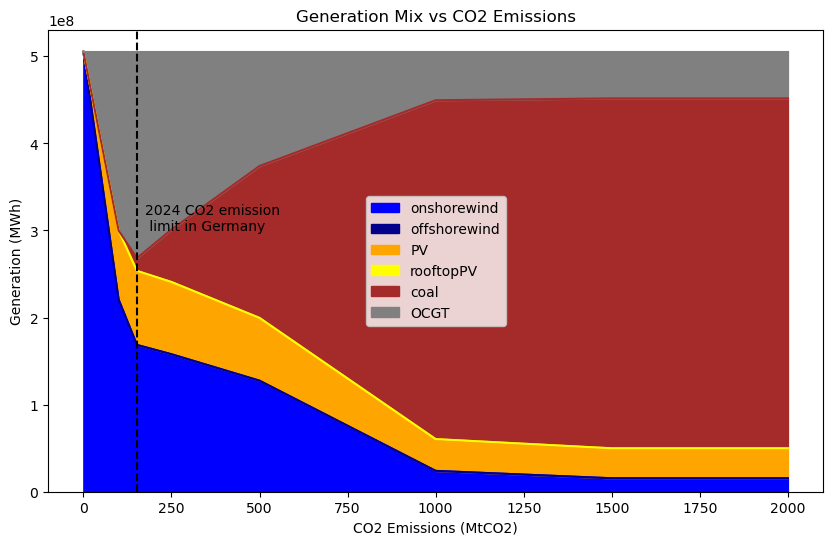

In [30]:
results = pd.DataFrame(
    np.array([onwind, offwind, pv, rooftop, coal, ocgt]).T,
    columns=["onshorewind", "offshorewind", "PV", "rooftopPV", "coal", "OCGT"],
    index=[2000, 1500, 1000, 500, 250, 152, 100, 0],
)
results.plot.area(
    stacked=True,
    title="Generation Mix vs CO2 Emissions",
    ylabel="Generation (MWh)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)
plt.vlines(
    152, 0, 6e8, color="black", linestyle="--", label="2024 CO2 emission limit"
)
plt.text(
    175, 3e8, "2024 CO2 emission\n limit in Germany", color="black", fontsize=10, ha="left"
)


<Axes: title={'center': 'Generation Capacity vs CO2 Emissions'}, xlabel='CO2 Emissions (MtCO2)', ylabel='Generation Capacity (MW)'>

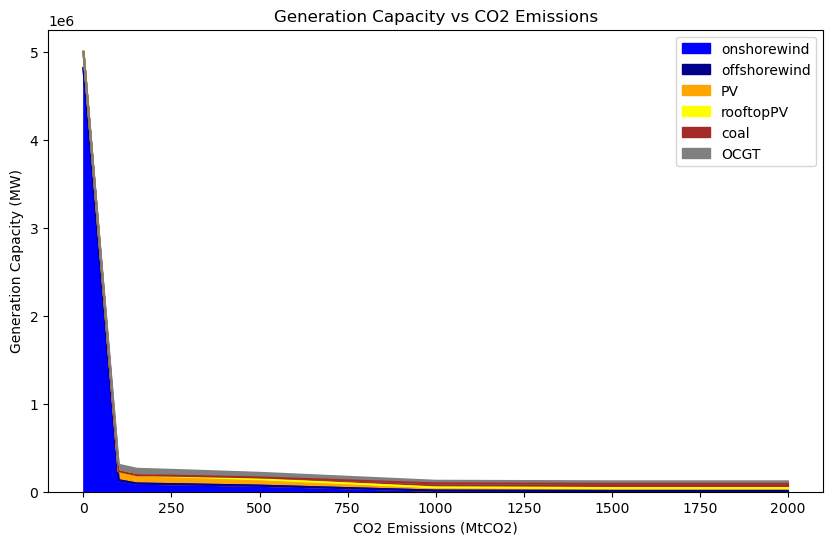

In [37]:
results_cap = pd.DataFrame(
    np.array([onwind_cap, offwind_cap, pv_cap, rooftop_cap, coal_cap, ocgt_cap]).T,
    columns=["onshorewind", "offshorewind", "PV", "rooftopPV", "coal", "OCGT"],
    index=[2000, 1500, 1000, 500, 250, 152, 100, 0],
)
results_cap.plot.area(
    stacked=True,
    title="Generation Capacity vs CO2 Emissions",
    ylabel="Generation Capacity (MW)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)

Text(0, 0.5, 'System Cost (million euros)')

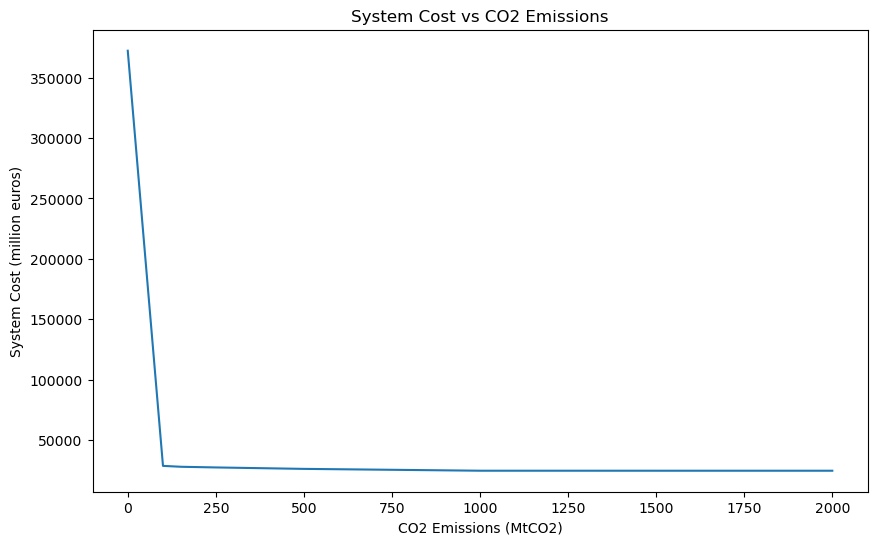

In [38]:
plt.figure(figsize=(10, 6))
plt.plot([2000, 1500, 1000, 500, 250, 152, 100, 0], systemcost)
plt.title("System Cost vs CO2 Emissions")
plt.xlabel("CO2 Emissions (MtCO2)")
plt.ylabel("System Cost (million euros)")

In [39]:
co2_tax

[np.float64(-0.0),
 np.float64(-0.0),
 np.float64(0.5864805492182698),
 np.float64(4.17333235011217),
 np.float64(5.337998133562091),
 np.float64(5.76237834956526),
 np.float64(50.242697968656465),
 np.float64(8138720.623421227)]

# Section C

In [56]:
#CF_wind_onshore.values

years = df_offshorewind.index.year.unique()
years = years[(years >= 2001) & (years != 2016) & (years != 2012) & (years != 2008) & (years != 2004)]

for year in years:
    print(year)
    print(df_onshorewind[country][df_onshorewind.index.year == year].values)
    print("------------")

2001
[0.295 0.34  0.38  ... 0.285 0.296 0.3  ]
------------
2002
[0.27  0.281 0.282 ... 0.153 0.14  0.13 ]
------------
2003
[0.117 0.124 0.13  ... 0.061 0.061 0.06 ]
------------
2005
[0.193 0.185 0.174 ... 0.33  0.311 0.291]
------------
2006
[0.252 0.268 0.263 ... 0.695 0.71  0.724]
------------
2007
[0.721 0.744 0.752 ... 0.07  0.067 0.067]
------------
2009
[0.053 0.068 0.079 ... 0.288 0.279 0.278]
------------
2010
[0.258 0.285 0.292 ... 0.385 0.423 0.459]
------------
2011
[0.443 0.491 0.512 ... 0.17  0.175 0.185]
------------
2013
[0.573 0.594 0.602 ... 0.273 0.274 0.275]
------------
2014
[0.251 0.259 0.259 ... 0.194 0.208 0.222]
------------
2015
[0.228 0.232 0.237 ... 0.119 0.112 0.106]
------------
2017
[0.286 0.301 0.309 ... 0.571 0.608 0.635]
------------


In [ ]:
years = df_offshorewind.index.year.unique()
years = years[(years >= 2001) & (years != 2016) & (years != 2012) & (years != 2008) & (years != 2004)]

# Remove the CO2 cap constraint
# network.global_constraints.drop("CO2Limit", inplace=True)


systemcost = []
onwind = []
offwind = []
pv = []
rooftop = []
coal = []
ocgt = []

onwind_cap = []
offwind_cap = []
pv_cap = []
rooftop_cap = []
coal_cap = []
ocgt_cap = []


for year in years:
    network.generators_t.p_max_pu["onshorewind"] = df_onshorewind[country][df_onshorewind.index.year == year].values
    network.generators_t.p_max_pu["offshorewind"] = df_offshorewind[country][df_offshorewind.index.year == year].values
    network.generators_t.p_max_pu["PV"] = df_pv[country][df_pv.index.year == year].values
    network.generators_t.p_max_pu["rooftopPV"] = df_rooftop[country][df_rooftop.index.year == year].values
    
    network.optimize(solver_name="gurobi")
    systemcost.append(network.objective / 1e6)  # in million euros
    onwind.append(network.generators_t.p["onshorewind"].sum())
    offwind.append(network.generators_t.p["offshorewind"].sum())
    pv.append(network.generators_t.p["PV"].sum())
    rooftop.append(network.generators_t.p["rooftopPV"].sum())
    coal.append(network.generators_t.p["coal"].sum())
    ocgt.append(network.generators_t.p["OCGT"].sum())

    onwind_cap.append(network.generators.p_nom_opt.loc["onshorewind"])
    offwind_cap.append(network.generators.p_nom_opt.loc["offshorewind"])
    pv_cap.append(network.generators.p_nom_opt.loc["PV"])
    rooftop_cap.append(network.generators.p_nom_opt.loc["rooftopPV"])
    coal_cap.append(network.generators.p_nom_opt.loc["coal"])
    ocgt_cap.append(network.generators.p_nom_opt.loc["OCGT"])
    

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.99it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-q_b5bf3s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-q_b5bf3s.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201768 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201768 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201768 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201768 nonzeros


Model fingerprint: 0xc39c5a18


INFO:gurobipy:Model fingerprint: 0xc39c5a18


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61044 rows and 8478 columns


INFO:gurobipy:Presolve removed 61044 rows and 8478 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 52842 rows, 44088 columns, 132246 nonzeros


INFO:gurobipy:Presolved: 52842 rows, 44088 columns, 132246 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.36861268e+11  0.00000000e+00  6.36e+05 0.00e+00  2.02e+08     0s


INFO:gurobipy:   0   3.36861268e+11  0.00000000e+00  6.36e+05 0.00e+00  2.02e+08     0s


   1   5.09086687e+11 -7.41020650e+11  8.84e+04 3.60e+02  4.27e+07     0s


INFO:gurobipy:   1   5.09086687e+11 -7.41020650e+11  8.84e+04 3.60e+02  4.27e+07     0s


   2   3.40015833e+11 -2.74171672e+11  1.75e-10 4.47e+00  4.93e+06     0s


INFO:gurobipy:   2   3.40015833e+11 -2.74171672e+11  1.75e-10 4.47e+00  4.93e+06     0s


   3   1.21162310e+11 -2.46831029e+10  1.16e-10 4.64e-01  1.12e+06     0s


INFO:gurobipy:   3   1.21162310e+11 -2.46831029e+10  1.16e-10 4.64e-01  1.12e+06     0s


   4   8.01192312e+10  4.97536699e+09  1.75e-10 8.08e-02  5.73e+05     0s


INFO:gurobipy:   4   8.01192312e+10  4.97536699e+09  1.75e-10 8.08e-02  5.73e+05     0s


   5   5.59561065e+10  1.25972594e+10  1.75e-10 1.22e-09  3.30e+05     0s


INFO:gurobipy:   5   5.59561065e+10  1.25972594e+10  1.75e-10 1.22e-09  3.30e+05     0s


   6   4.17757760e+10  1.71042656e+10  2.33e-10 2.33e-10  1.88e+05     0s


INFO:gurobipy:   6   4.17757760e+10  1.71042656e+10  2.33e-10 2.33e-10  1.88e+05     0s


   7   3.93349331e+10  2.12519259e+10  2.07e-09 4.95e-10  1.37e+05     0s


INFO:gurobipy:   7   3.93349331e+10  2.12519259e+10  2.07e-09 4.95e-10  1.37e+05     0s


   8   3.48124951e+10  2.25661295e+10  2.02e-08 1.80e-09  9.29e+04     0s


INFO:gurobipy:   8   3.48124951e+10  2.25661295e+10  2.02e-08 1.80e-09  9.29e+04     0s


   9   2.88784739e+10  2.33180685e+10  3.66e-07 1.75e-09  4.22e+04     0s


INFO:gurobipy:   9   2.88784739e+10  2.33180685e+10  3.66e-07 1.75e-09  4.22e+04     0s


  10   2.71912269e+10  2.41434587e+10  5.66e-07 9.90e-10  2.31e+04     0s


INFO:gurobipy:  10   2.71912269e+10  2.41434587e+10  5.66e-07 9.90e-10  2.31e+04     0s


  11   2.62897959e+10  2.44317523e+10  8.47e-07 8.15e-10  1.41e+04     0s


INFO:gurobipy:  11   2.62897959e+10  2.44317523e+10  8.47e-07 8.15e-10  1.41e+04     0s


  12   2.58429692e+10  2.45365866e+10  1.81e-06 5.82e-10  9.90e+03     0s


INFO:gurobipy:  12   2.58429692e+10  2.45365866e+10  1.81e-06 5.82e-10  9.90e+03     0s


  13   2.56140150e+10  2.46337769e+10  1.09e-06 1.19e-09  7.43e+03     0s


INFO:gurobipy:  13   2.56140150e+10  2.46337769e+10  1.09e-06 1.19e-09  7.43e+03     0s


  14   2.54573379e+10  2.47033774e+10  2.98e-07 7.57e-10  5.72e+03     0s


INFO:gurobipy:  14   2.54573379e+10  2.47033774e+10  2.98e-07 7.57e-10  5.72e+03     0s


  15   2.53028050e+10  2.47756967e+10  5.62e-07 8.73e-10  4.00e+03     0s


INFO:gurobipy:  15   2.53028050e+10  2.47756967e+10  5.62e-07 8.73e-10  4.00e+03     0s


  16   2.52123002e+10  2.48159677e+10  6.04e-07 4.37e-10  3.00e+03     0s


INFO:gurobipy:  16   2.52123002e+10  2.48159677e+10  6.04e-07 4.37e-10  3.00e+03     0s


  17   2.51667138e+10  2.48291373e+10  3.47e-07 4.00e-10  2.56e+03     0s


INFO:gurobipy:  17   2.51667138e+10  2.48291373e+10  3.47e-07 4.00e-10  2.56e+03     0s


  18   2.51160279e+10  2.48505290e+10  1.14e-06 6.40e-10  2.01e+03     0s


INFO:gurobipy:  18   2.51160279e+10  2.48505290e+10  1.14e-06 6.40e-10  2.01e+03     0s


  19   2.50829169e+10  2.48725235e+10  8.41e-07 3.20e-10  1.59e+03     1s


INFO:gurobipy:  19   2.50829169e+10  2.48725235e+10  8.41e-07 3.20e-10  1.59e+03     1s


  20   2.50642678e+10  2.48771015e+10  8.04e-07 2.91e-11  1.42e+03     1s


INFO:gurobipy:  20   2.50642678e+10  2.48771015e+10  8.04e-07 2.91e-11  1.42e+03     1s


  21   2.50395717e+10  2.48907676e+10  5.94e-07 8.44e-10  1.13e+03     1s


INFO:gurobipy:  21   2.50395717e+10  2.48907676e+10  5.94e-07 8.44e-10  1.13e+03     1s


  22   2.50194493e+10  2.48951016e+10  4.69e-07 4.66e-10  9.43e+02     1s


INFO:gurobipy:  22   2.50194493e+10  2.48951016e+10  4.69e-07 4.66e-10  9.43e+02     1s


  23   2.50093624e+10  2.48977910e+10  4.14e-07 3.20e-10  8.46e+02     1s


INFO:gurobipy:  23   2.50093624e+10  2.48977910e+10  4.14e-07 3.20e-10  8.46e+02     1s


  24   2.50034309e+10  2.49056388e+10  3.78e-07 1.57e-09  7.41e+02     1s


INFO:gurobipy:  24   2.50034309e+10  2.49056388e+10  3.78e-07 1.57e-09  7.41e+02     1s


  25   2.49902268e+10  2.49081185e+10  5.61e-07 1.24e-10  6.22e+02     1s


INFO:gurobipy:  25   2.49902268e+10  2.49081185e+10  5.61e-07 1.24e-10  6.22e+02     1s


  26   2.49829869e+10  2.49094430e+10  3.98e-07 4.66e-10  5.57e+02     1s


INFO:gurobipy:  26   2.49829869e+10  2.49094430e+10  3.98e-07 4.66e-10  5.57e+02     1s


  27   2.49767260e+10  2.49110980e+10  5.75e-07 1.28e-09  4.97e+02     1s


INFO:gurobipy:  27   2.49767260e+10  2.49110980e+10  5.75e-07 1.28e-09  4.97e+02     1s


  28   2.49715745e+10  2.49126194e+10  4.31e-07 1.58e-09  4.47e+02     1s


INFO:gurobipy:  28   2.49715745e+10  2.49126194e+10  4.31e-07 1.58e-09  4.47e+02     1s


  29   2.49680616e+10  2.49133942e+10  7.90e-07 4.41e-09  4.14e+02     1s


INFO:gurobipy:  29   2.49680616e+10  2.49133942e+10  7.90e-07 4.41e-09  4.14e+02     1s


  30   2.49662357e+10  2.49141823e+10  2.35e-06 7.20e-09  3.95e+02     1s


INFO:gurobipy:  30   2.49662357e+10  2.49141823e+10  2.35e-06 7.20e-09  3.95e+02     1s


  31   2.49593714e+10  2.49161921e+10  2.12e-06 1.34e-08  3.27e+02     1s


INFO:gurobipy:  31   2.49593714e+10  2.49161921e+10  2.12e-06 1.34e-08  3.27e+02     1s


  32   2.49570948e+10  2.49169497e+10  1.99e-06 1.35e-08  3.04e+02     1s


INFO:gurobipy:  32   2.49570948e+10  2.49169497e+10  1.99e-06 1.35e-08  3.04e+02     1s


  33   2.49529202e+10  2.49188031e+10  1.83e-06 1.95e-08  2.59e+02     1s


INFO:gurobipy:  33   2.49529202e+10  2.49188031e+10  1.83e-06 1.95e-08  2.59e+02     1s


  34   2.49503935e+10  2.49192536e+10  1.64e-06 2.08e-08  2.36e+02     1s


INFO:gurobipy:  34   2.49503935e+10  2.49192536e+10  1.64e-06 2.08e-08  2.36e+02     1s


INFO:gurobipy:


Barrier performed 34 iterations in 0.81 seconds (0.68 work units)


INFO:gurobipy:Barrier performed 34 iterations in 0.81 seconds (0.68 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33067    2.4925832e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   33067    2.4925832e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 33067 iterations and 0.90 seconds (1.03 work units)


INFO:gurobipy:Solved in 33067 iterations and 0.90 seconds (1.03 work units)


Optimal objective  2.492583166e+10


INFO:gurobipy:Optimal objective  2.492583166e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.49e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.48it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-cue2t8k0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-cue2t8k0.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201733 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201733 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201733 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201733 nonzeros


Model fingerprint: 0x224f6b3c


INFO:gurobipy:Model fingerprint: 0x224f6b3c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61079 rows and 8513 columns


INFO:gurobipy:Presolve removed 61079 rows and 8513 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 52807 rows, 44053 columns, 132141 nonzeros


INFO:gurobipy:Presolved: 52807 rows, 44053 columns, 132141 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.809e+04


INFO:gurobipy: AA' NZ     : 8.809e+04


 Factor NZ  : 4.642e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.642e+05 (roughly 40 MB of memory)


 Factor Ops : 4.363e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.363e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.16152772e+11  0.00000000e+00  6.29e+05 0.00e+00  1.95e+08     0s


INFO:gurobipy:   0   3.16152772e+11  0.00000000e+00  6.29e+05 0.00e+00  1.95e+08     0s


   1   4.65605470e+11 -7.09938934e+11  9.47e+04 3.52e+02  4.48e+07     0s


INFO:gurobipy:   1   4.65605470e+11 -7.09938934e+11  9.47e+04 3.52e+02  4.48e+07     0s


   2   3.42703217e+11 -2.90156196e+11  1.16e-10 5.79e+00  5.15e+06     0s


INFO:gurobipy:   2   3.42703217e+11 -2.90156196e+11  1.16e-10 5.79e+00  5.15e+06     0s


   3   9.99200160e+10 -1.46925019e+10  1.16e-10 3.65e-01  8.84e+05     0s


INFO:gurobipy:   3   9.99200160e+10 -1.46925019e+10  1.16e-10 3.65e-01  8.84e+05     0s


   4   7.21577109e+10  6.86949843e+09  1.16e-10 5.56e-02  4.99e+05     0s


INFO:gurobipy:   4   7.21577109e+10  6.86949843e+09  1.16e-10 5.56e-02  4.99e+05     0s


   5   5.66116696e+10  1.30192769e+10  1.75e-10 1.10e-02  3.32e+05     0s


INFO:gurobipy:   5   5.66116696e+10  1.30192769e+10  1.75e-10 1.10e-02  3.32e+05     0s


   6   4.12573623e+10  1.60254236e+10  3.49e-10 7.28e-10  1.92e+05     0s


INFO:gurobipy:   6   4.12573623e+10  1.60254236e+10  3.49e-10 7.28e-10  1.92e+05     0s


   7   3.76207590e+10  2.11711161e+10  1.07e-08 2.56e-09  1.25e+05     0s


INFO:gurobipy:   7   3.76207590e+10  2.11711161e+10  1.07e-08 2.56e-09  1.25e+05     0s


   8   3.56581335e+10  2.20602774e+10  1.74e-07 1.51e-09  1.03e+05     0s


INFO:gurobipy:   8   3.56581335e+10  2.20602774e+10  1.74e-07 1.51e-09  1.03e+05     0s


   9   2.99316909e+10  2.28271099e+10  6.71e-08 2.27e-09  5.39e+04     0s


INFO:gurobipy:   9   2.99316909e+10  2.28271099e+10  6.71e-08 2.27e-09  5.39e+04     0s


  10   2.70075827e+10  2.36229907e+10  2.83e-07 8.44e-10  2.57e+04     0s


INFO:gurobipy:  10   2.70075827e+10  2.36229907e+10  2.83e-07 8.44e-10  2.57e+04     0s


  11   2.65250996e+10  2.42197985e+10  4.54e-07 1.22e-09  1.75e+04     0s


INFO:gurobipy:  11   2.65250996e+10  2.42197985e+10  4.54e-07 1.22e-09  1.75e+04     0s


  12   2.56999596e+10  2.44334928e+10  6.11e-06 2.91e-10  9.60e+03     0s


INFO:gurobipy:  12   2.56999596e+10  2.44334928e+10  6.11e-06 2.91e-10  9.60e+03     0s


  13   2.52993924e+10  2.45424298e+10  3.65e-06 1.05e-09  5.74e+03     0s


INFO:gurobipy:  13   2.52993924e+10  2.45424298e+10  3.65e-06 1.05e-09  5.74e+03     0s


  14   2.51357256e+10  2.46047766e+10  2.27e-06 6.40e-10  4.03e+03     1s


INFO:gurobipy:  14   2.51357256e+10  2.46047766e+10  2.27e-06 6.40e-10  4.03e+03     1s


  15   2.50324482e+10  2.46845888e+10  1.58e-06 5.24e-10  2.64e+03     1s


INFO:gurobipy:  15   2.50324482e+10  2.46845888e+10  1.58e-06 5.24e-10  2.64e+03     1s


  16   2.49511927e+10  2.47214207e+10  1.15e-06 9.31e-10  1.74e+03     1s


INFO:gurobipy:  16   2.49511927e+10  2.47214207e+10  1.15e-06 9.31e-10  1.74e+03     1s


  17   2.49049321e+10  2.47394371e+10  9.08e-07 1.75e-09  1.26e+03     1s


INFO:gurobipy:  17   2.49049321e+10  2.47394371e+10  9.08e-07 1.75e-09  1.26e+03     1s


  18   2.48763554e+10  2.47485264e+10  7.08e-07 6.40e-10  9.70e+02     1s


INFO:gurobipy:  18   2.48763554e+10  2.47485264e+10  7.08e-07 6.40e-10  9.70e+02     1s


  19   2.48645798e+10  2.47590857e+10  3.97e-07 1.57e-09  8.01e+02     1s


INFO:gurobipy:  19   2.48645798e+10  2.47590857e+10  3.97e-07 1.57e-09  8.01e+02     1s


  20   2.48485342e+10  2.47736427e+10  3.27e-07 5.82e-10  5.68e+02     1s


INFO:gurobipy:  20   2.48485342e+10  2.47736427e+10  3.27e-07 5.82e-10  5.68e+02     1s


  21   2.48368347e+10  2.47809862e+10  1.05e-07 1.63e-09  4.24e+02     1s


INFO:gurobipy:  21   2.48368347e+10  2.47809862e+10  1.05e-07 1.63e-09  4.24e+02     1s


  22   2.48325669e+10  2.47851936e+10  9.04e-08 1.05e-09  3.60e+02     1s


INFO:gurobipy:  22   2.48325669e+10  2.47851936e+10  9.04e-08 1.05e-09  3.60e+02     1s


  23   2.48276074e+10  2.47882444e+10  7.13e-08 2.10e-09  2.99e+02     1s


INFO:gurobipy:  23   2.48276074e+10  2.47882444e+10  7.13e-08 2.10e-09  2.99e+02     1s


  24   2.48233436e+10  2.47919487e+10  1.14e-07 6.69e-10  2.38e+02     1s


INFO:gurobipy:  24   2.48233436e+10  2.47919487e+10  1.14e-07 6.69e-10  2.38e+02     1s


  25   2.48178086e+10  2.47976215e+10  2.79e-07 6.91e-10  1.53e+02     1s


INFO:gurobipy:  25   2.48178086e+10  2.47976215e+10  2.79e-07 6.91e-10  1.53e+02     1s


  26   2.48153350e+10  2.47997803e+10  2.54e-07 2.73e-10  1.18e+02     1s


INFO:gurobipy:  26   2.48153350e+10  2.47997803e+10  2.54e-07 2.73e-10  1.18e+02     1s


  27   2.48139299e+10  2.48013754e+10  1.71e-07 1.34e-09  9.54e+01     1s


INFO:gurobipy:  27   2.48139299e+10  2.48013754e+10  1.71e-07 1.34e-09  9.54e+01     1s


  28   2.48129011e+10  2.48022077e+10  2.05e-07 4.47e-10  8.13e+01     1s


INFO:gurobipy:  28   2.48129011e+10  2.48022077e+10  2.05e-07 4.47e-10  8.13e+01     1s


  29   2.48119864e+10  2.48024290e+10  2.30e-06 6.37e-10  7.27e+01     1s


INFO:gurobipy:  29   2.48119864e+10  2.48024290e+10  2.30e-06 6.37e-10  7.27e+01     1s


  30   2.48116419e+10  2.48039151e+10  2.54e-06 1.18e-09  5.87e+01     1s


INFO:gurobipy:  30   2.48116419e+10  2.48039151e+10  2.54e-06 1.18e-09  5.87e+01     1s


  31   2.48109631e+10  2.48045503e+10  3.48e-06 9.82e-10  4.88e+01     1s


INFO:gurobipy:  31   2.48109631e+10  2.48045503e+10  3.48e-06 9.82e-10  4.88e+01     1s


  32   2.48105324e+10  2.48058889e+10  3.14e-06 2.48e-09  3.53e+01     1s


INFO:gurobipy:  32   2.48105324e+10  2.48058889e+10  3.14e-06 2.48e-09  3.53e+01     1s


  33   2.48099189e+10  2.48072922e+10  9.52e-07 1.46e-09  2.00e+01     1s


INFO:gurobipy:  33   2.48099189e+10  2.48072922e+10  9.52e-07 1.46e-09  2.00e+01     1s


  34   2.48095586e+10  2.48081045e+10  3.17e-07 1.08e-09  1.11e+01     1s


INFO:gurobipy:  34   2.48095586e+10  2.48081045e+10  3.17e-07 1.08e-09  1.11e+01     1s


  35   2.48093531e+10  2.48086210e+10  1.46e-06 9.31e-10  5.57e+00     1s


INFO:gurobipy:  35   2.48093531e+10  2.48086210e+10  1.46e-06 9.31e-10  5.57e+00     1s


  36   2.48093214e+10  2.48088806e+10  2.85e-06 7.62e-09  3.36e+00     1s


INFO:gurobipy:  36   2.48093214e+10  2.48088806e+10  2.85e-06 7.62e-09  3.36e+00     1s


  37   2.48093071e+10  2.48091551e+10  3.28e-06 5.12e-09  1.16e+00     1s


INFO:gurobipy:  37   2.48093071e+10  2.48091551e+10  3.28e-06 5.12e-09  1.16e+00     1s


  38   2.48092877e+10  2.48092142e+10  1.40e-06 1.80e-09  5.59e-01     1s


INFO:gurobipy:  38   2.48092877e+10  2.48092142e+10  1.40e-06 1.80e-09  5.59e-01     1s


  39   2.48092849e+10  2.48092762e+10  9.62e-07 1.31e-09  6.64e-02     1s


INFO:gurobipy:  39   2.48092849e+10  2.48092762e+10  9.62e-07 1.31e-09  6.64e-02     1s


  40   2.48092846e+10  2.48092845e+10  7.33e-08 2.04e-10  7.18e-04     1s


INFO:gurobipy:  40   2.48092846e+10  2.48092845e+10  7.33e-08 2.04e-10  7.18e-04     1s


  41   2.48092846e+10  2.48092846e+10  6.21e-09 6.55e-10  6.69e-07     1s


INFO:gurobipy:  41   2.48092846e+10  2.48092846e+10  6.21e-09 6.55e-10  6.69e-07     1s


  42   2.48092846e+10  2.48092846e+10  1.20e-10 8.15e-10  6.69e-10     1s


INFO:gurobipy:  42   2.48092846e+10  2.48092846e+10  1.20e-10 8.15e-10  6.69e-10     1s


INFO:gurobipy:


Barrier solved model in 42 iterations and 1.14 seconds (0.79 work units)


INFO:gurobipy:Barrier solved model in 42 iterations and 1.14 seconds (0.79 work units)


Optimal objective 2.48092846e+10


INFO:gurobipy:Optimal objective 2.48092846e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13281 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13281 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0398419e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0398419e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13284    2.4809285e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13284    2.4809285e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13284 iterations and 1.28 seconds (0.85 work units)


INFO:gurobipy:Solved in 13284 iterations and 1.28 seconds (0.85 work units)


Optimal objective  2.480928456e+10


INFO:gurobipy:Optimal objective  2.480928456e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.71it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-boelcm1s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-boelcm1s.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201756 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201756 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201756 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201756 nonzeros


Model fingerprint: 0x3a3f7fcf


INFO:gurobipy:Model fingerprint: 0x3a3f7fcf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61056 rows and 8490 columns


INFO:gurobipy:Presolve removed 61056 rows and 8490 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52830 rows, 44076 columns, 132210 nonzeros


INFO:gurobipy:Presolved: 52830 rows, 44076 columns, 132210 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.814e+04


INFO:gurobipy: AA' NZ     : 8.814e+04


 Factor NZ  : 4.646e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.646e+05 (roughly 40 MB of memory)


 Factor Ops : 4.369e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.369e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.31017209e+11  0.00000000e+00  6.23e+05 0.00e+00  1.99e+08     0s


INFO:gurobipy:   0   3.31017209e+11  0.00000000e+00  6.23e+05 0.00e+00  1.99e+08     0s


   1   4.95144804e+11 -7.77854446e+11  8.79e+04 3.63e+02  4.21e+07     0s


INFO:gurobipy:   1   4.95144804e+11 -7.77854446e+11  8.79e+04 3.63e+02  4.21e+07     0s


   2   3.31334736e+11 -2.74026881e+11  1.16e-10 6.41e+00  4.95e+06     0s


INFO:gurobipy:   2   3.31334736e+11 -2.74026881e+11  1.16e-10 6.41e+00  4.95e+06     0s


   3   1.31204554e+11 -1.04629706e+10  2.91e-10 3.48e-01  1.09e+06     0s


INFO:gurobipy:   3   1.31204554e+11 -1.04629706e+10  2.91e-10 3.48e-01  1.09e+06     0s


   4   8.48185810e+10  6.18706062e+09  1.16e-10 1.31e-01  6.01e+05     0s


INFO:gurobipy:   4   8.48185810e+10  6.18706062e+09  1.16e-10 1.31e-01  6.01e+05     0s


   5   5.80068380e+10  9.56730376e+09  1.16e-10 1.31e-01  3.70e+05     0s


INFO:gurobipy:   5   5.80068380e+10  9.56730376e+09  1.16e-10 1.31e-01  3.70e+05     0s


   6   4.38627444e+10  1.29058106e+10  3.20e-10 6.41e-02  2.36e+05     0s


INFO:gurobipy:   6   4.38627444e+10  1.29058106e+10  3.20e-10 6.41e-02  2.36e+05     0s


   7   3.90399817e+10  1.91920248e+10  9.46e-10 2.59e-02  1.51e+05     0s


INFO:gurobipy:   7   3.90399817e+10  1.91920248e+10  9.46e-10 2.59e-02  1.51e+05     0s


   8   3.56597577e+10  2.12810740e+10  8.88e-09 1.91e-02  1.09e+05     0s


INFO:gurobipy:   8   3.56597577e+10  2.12810740e+10  8.88e-09 1.91e-02  1.09e+05     0s


   9   2.96924895e+10  2.24764766e+10  3.46e-08 7.86e-03  5.49e+04     0s


INFO:gurobipy:   9   2.96924895e+10  2.24764766e+10  3.46e-08 7.86e-03  5.49e+04     0s


  10   2.72625295e+10  2.35368545e+10  2.86e-08 2.96e-03  2.83e+04     0s


INFO:gurobipy:  10   2.72625295e+10  2.35368545e+10  2.86e-08 2.96e-03  2.83e+04     0s


  11   2.67299583e+10  2.40125513e+10  3.46e-08 2.23e-03  2.06e+04     0s


INFO:gurobipy:  11   2.67299583e+10  2.40125513e+10  3.46e-08 2.23e-03  2.06e+04     0s


  12   2.62921283e+10  2.41751921e+10  3.20e-06 1.86e-03  1.61e+04     0s


INFO:gurobipy:  12   2.62921283e+10  2.41751921e+10  3.20e-06 1.86e-03  1.61e+04     0s


  13   2.56952597e+10  2.42857977e+10  2.12e-06 1.16e-10  1.07e+04     0s


INFO:gurobipy:  13   2.56952597e+10  2.42857977e+10  2.12e-06 1.16e-10  1.07e+04     0s


  14   2.53547119e+10  2.43644841e+10  1.14e-06 4.07e-10  7.52e+03     1s


INFO:gurobipy:  14   2.53547119e+10  2.43644841e+10  1.14e-06 4.07e-10  7.52e+03     1s


  15   2.51549296e+10  2.44627890e+10  5.08e-07 5.24e-10  5.25e+03     1s


INFO:gurobipy:  15   2.51549296e+10  2.44627890e+10  5.08e-07 5.24e-10  5.25e+03     1s


  16   2.50279808e+10  2.45144283e+10  8.88e-07 1.72e-05  3.90e+03     1s


INFO:gurobipy:  16   2.50279808e+10  2.45144283e+10  8.88e-07 1.72e-05  3.90e+03     1s


  17   2.49439065e+10  2.45336485e+10  1.64e-06 2.21e-05  3.12e+03     1s


INFO:gurobipy:  17   2.49439065e+10  2.45336485e+10  1.64e-06 2.21e-05  3.12e+03     1s


  18   2.48973064e+10  2.45513496e+10  1.40e-06 2.35e-05  2.63e+03     1s


INFO:gurobipy:  18   2.48973064e+10  2.45513496e+10  1.40e-06 2.35e-05  2.63e+03     1s


  19   2.48656380e+10  2.45828198e+10  1.14e-06 2.52e-05  2.15e+03     1s


INFO:gurobipy:  19   2.48656380e+10  2.45828198e+10  1.14e-06 2.52e-05  2.15e+03     1s


  20   2.48387701e+10  2.46001872e+10  9.56e-07 2.25e-05  1.81e+03     1s


INFO:gurobipy:  20   2.48387701e+10  2.46001872e+10  9.56e-07 2.25e-05  1.81e+03     1s


  21   2.48090525e+10  2.46184213e+10  7.43e-07 1.96e-05  1.45e+03     1s


INFO:gurobipy:  21   2.48090525e+10  2.46184213e+10  7.43e-07 1.96e-05  1.45e+03     1s


  22   2.47750583e+10  2.46309536e+10  6.33e-07 1.60e-05  1.09e+03     1s


INFO:gurobipy:  22   2.47750583e+10  2.46309536e+10  6.33e-07 1.60e-05  1.09e+03     1s


  23   2.47626588e+10  2.46342729e+10  4.34e-07 1.46e-05  9.74e+02     1s


INFO:gurobipy:  23   2.47626588e+10  2.46342729e+10  4.34e-07 1.46e-05  9.74e+02     1s


  24   2.47404844e+10  2.46435030e+10  2.54e-07 6.88e-06  7.36e+02     1s


INFO:gurobipy:  24   2.47404844e+10  2.46435030e+10  2.54e-07 6.88e-06  7.36e+02     1s


  25   2.47337575e+10  2.46449788e+10  1.54e-07 6.32e-06  6.74e+02     1s


INFO:gurobipy:  25   2.47337575e+10  2.46449788e+10  1.54e-07 6.32e-06  6.74e+02     1s


  26   2.47226038e+10  2.46496056e+10  9.17e-08 4.65e-06  5.54e+02     1s


INFO:gurobipy:  26   2.47226038e+10  2.46496056e+10  9.17e-08 4.65e-06  5.54e+02     1s


  27   2.47115446e+10  2.46531492e+10  4.16e-07 3.21e-06  4.43e+02     1s


INFO:gurobipy:  27   2.47115446e+10  2.46531492e+10  4.16e-07 3.21e-06  4.43e+02     1s


  28   2.47065551e+10  2.46549528e+10  4.02e-07 2.43e-06  3.91e+02     1s


INFO:gurobipy:  28   2.47065551e+10  2.46549528e+10  4.02e-07 2.43e-06  3.91e+02     1s


  29   2.46983059e+10  2.46565231e+10  3.68e-07 1.74e-06  3.17e+02     1s


INFO:gurobipy:  29   2.46983059e+10  2.46565231e+10  3.68e-07 1.74e-06  3.17e+02     1s


  30   2.46920688e+10  2.46587717e+10  2.93e-07 8.67e-07  2.53e+02     1s


INFO:gurobipy:  30   2.46920688e+10  2.46587717e+10  2.93e-07 8.67e-07  2.53e+02     1s


  31   2.46888741e+10  2.46593013e+10  2.54e-07 6.59e-07  2.24e+02     1s


INFO:gurobipy:  31   2.46888741e+10  2.46593013e+10  2.54e-07 6.59e-07  2.24e+02     1s


  32   2.46866413e+10  2.46605679e+10  2.89e-07 5.05e-09  1.98e+02     1s


INFO:gurobipy:  32   2.46866413e+10  2.46605679e+10  2.89e-07 5.05e-09  1.98e+02     1s


  33   2.46839217e+10  2.46612545e+10  3.50e-07 6.89e-09  1.72e+02     1s


INFO:gurobipy:  33   2.46839217e+10  2.46612545e+10  3.50e-07 6.89e-09  1.72e+02     1s


  34   2.46804788e+10  2.46621930e+10  9.49e-07 6.78e-09  1.39e+02     1s


INFO:gurobipy:  34   2.46804788e+10  2.46621930e+10  9.49e-07 6.78e-09  1.39e+02     1s


  35   2.46791377e+10  2.46623671e+10  8.33e-07 6.79e-09  1.27e+02     1s


INFO:gurobipy:  35   2.46791377e+10  2.46623671e+10  8.33e-07 6.79e-09  1.27e+02     1s


  36   2.46762068e+10  2.46626263e+10  1.49e-06 7.37e-09  1.03e+02     1s


INFO:gurobipy:  36   2.46762068e+10  2.46626263e+10  1.49e-06 7.37e-09  1.03e+02     1s


  37   2.46746632e+10  2.46632008e+10  1.30e-06 6.97e-09  8.69e+01     1s


INFO:gurobipy:  37   2.46746632e+10  2.46632008e+10  1.30e-06 6.97e-09  8.69e+01     1s


  38   2.46736229e+10  2.46633196e+10  1.16e-06 6.80e-09  7.81e+01     1s


INFO:gurobipy:  38   2.46736229e+10  2.46633196e+10  1.16e-06 6.80e-09  7.81e+01     1s


  39   2.46726118e+10  2.46635820e+10  1.03e-06 6.21e-09  6.85e+01     1s


INFO:gurobipy:  39   2.46726118e+10  2.46635820e+10  1.03e-06 6.21e-09  6.85e+01     1s


  40   2.46715870e+10  2.46637592e+10  8.90e-07 5.81e-09  5.93e+01     1s


INFO:gurobipy:  40   2.46715870e+10  2.46637592e+10  8.90e-07 5.81e-09  5.93e+01     1s


  41   2.46712270e+10  2.46640458e+10  8.41e-07 4.66e-09  5.44e+01     1s


INFO:gurobipy:  41   2.46712270e+10  2.46640458e+10  8.41e-07 4.66e-09  5.44e+01     1s


  42   2.46707649e+10  2.46641989e+10  7.83e-07 3.64e-09  4.97e+01     1s


INFO:gurobipy:  42   2.46707649e+10  2.46641989e+10  7.83e-07 3.64e-09  4.97e+01     1s


  43   2.46700277e+10  2.46643255e+10  6.83e-07 4.54e-09  4.32e+01     1s


INFO:gurobipy:  43   2.46700277e+10  2.46643255e+10  6.83e-07 4.54e-09  4.32e+01     1s


  44   2.46685971e+10  2.46643697e+10  1.90e-06 4.19e-09  3.20e+01     1s


INFO:gurobipy:  44   2.46685971e+10  2.46643697e+10  1.90e-06 4.19e-09  3.20e+01     1s


  45   2.46673390e+10  2.46645577e+10  2.33e-06 3.30e-09  2.11e+01     1s


INFO:gurobipy:  45   2.46673390e+10  2.46645577e+10  2.33e-06 3.30e-09  2.11e+01     1s


  46   2.46664167e+10  2.46646911e+10  1.49e-06 3.27e-11  1.31e+01     1s


INFO:gurobipy:  46   2.46664167e+10  2.46646911e+10  1.49e-06 3.27e-11  1.31e+01     1s


  47   2.46660017e+10  2.46647835e+10  1.45e-06 5.75e-10  9.23e+00     1s


INFO:gurobipy:  47   2.46660017e+10  2.46647835e+10  1.45e-06 5.75e-10  9.23e+00     1s


  48   2.46652678e+10  2.46649348e+10  9.28e-07 4.51e-09  2.52e+00     1s


INFO:gurobipy:  48   2.46652678e+10  2.46649348e+10  9.28e-07 4.51e-09  2.52e+00     1s


  49   2.46652069e+10  2.46649418e+10  7.48e-07 2.41e-09  2.01e+00     1s


INFO:gurobipy:  49   2.46652069e+10  2.46649418e+10  7.48e-07 2.41e-09  2.01e+00     1s


  50   2.46651333e+10  2.46649432e+10  5.30e-07 1.98e-09  1.44e+00     1s


INFO:gurobipy:  50   2.46651333e+10  2.46649432e+10  5.30e-07 1.98e-09  1.44e+00     1s


  51   2.46650361e+10  2.46649446e+10  2.51e-07 1.31e-09  6.92e-01     1s


INFO:gurobipy:  51   2.46650361e+10  2.46649446e+10  2.51e-07 1.31e-09  6.92e-01     1s


  52   2.46649828e+10  2.46649466e+10  9.74e-08 3.78e-10  2.74e-01     1s


INFO:gurobipy:  52   2.46649828e+10  2.46649466e+10  9.74e-08 3.78e-10  2.74e-01     1s


  53   2.46649501e+10  2.46649480e+10  9.90e-10 4.37e-10  1.66e-02     1s


INFO:gurobipy:  53   2.46649501e+10  2.46649480e+10  9.90e-10 4.37e-10  1.66e-02     1s


  54   2.46649488e+10  2.46649488e+10  3.49e-10 9.90e-10  3.10e-04     1s


INFO:gurobipy:  54   2.46649488e+10  2.46649488e+10  3.49e-10 9.90e-10  3.10e-04     1s


  55   2.46649488e+10  2.46649488e+10  1.82e-09 1.46e-09  4.27e-09     1s


INFO:gurobipy:  55   2.46649488e+10  2.46649488e+10  1.82e-09 1.46e-09  4.27e-09     1s


INFO:gurobipy:


Barrier solved model in 55 iterations and 1.29 seconds (1.04 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 1.29 seconds (1.04 work units)


Optimal objective 2.46649488e+10


INFO:gurobipy:Optimal objective 2.46649488e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22056 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   22056 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.9109070e-11      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.9109070e-11      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   22059    2.4664949e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   22059    2.4664949e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 22059 iterations and 1.43 seconds (1.10 work units)


INFO:gurobipy:Solved in 22059 iterations and 1.43 seconds (1.10 work units)


Optimal objective  2.466494876e+10


INFO:gurobipy:Optimal objective  2.466494876e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.47e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.68it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-c5lr7v_p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-c5lr7v_p.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201763 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201763 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


Model fingerprint: 0xc9983026


INFO:gurobipy:Model fingerprint: 0xc9983026


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61049 rows and 8483 columns


INFO:gurobipy:Presolve removed 61049 rows and 8483 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.815e+04


INFO:gurobipy: AA' NZ     : 8.815e+04


 Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.14757797e+11  0.00000000e+00  6.24e+05 0.00e+00  1.93e+08     0s


INFO:gurobipy:   0   3.14757797e+11  0.00000000e+00  6.24e+05 0.00e+00  1.93e+08     0s


   1   4.81957999e+11 -7.00036761e+11  8.85e+04 3.96e+02  4.37e+07     0s


INFO:gurobipy:   1   4.81957999e+11 -7.00036761e+11  8.85e+04 3.96e+02  4.37e+07     0s


   2   3.41291615e+11 -2.75273033e+11  1.46e-10 4.61e+00  4.95e+06     0s


INFO:gurobipy:   2   3.41291615e+11 -2.75273033e+11  1.46e-10 4.61e+00  4.95e+06     0s


   3   9.79211081e+10 -2.62252408e+10  1.46e-10 4.43e-01  9.58e+05     0s


INFO:gurobipy:   3   9.79211081e+10 -2.62252408e+10  1.46e-10 4.43e-01  9.58e+05     0s


   4   6.80253937e+10  6.94484167e+09  1.16e-10 8.90e-02  4.65e+05     0s


INFO:gurobipy:   4   6.80253937e+10  6.94484167e+09  1.16e-10 8.90e-02  4.65e+05     0s


   5   5.67222517e+10  1.10387173e+10  1.75e-10 3.91e-02  3.48e+05     0s


INFO:gurobipy:   5   5.67222517e+10  1.10387173e+10  1.75e-10 3.91e-02  3.48e+05     0s


   6   4.20131303e+10  1.49144329e+10  2.62e-10 5.91e-02  2.06e+05     0s


INFO:gurobipy:   6   4.20131303e+10  1.49144329e+10  2.62e-10 5.91e-02  2.06e+05     0s


   7   3.88450459e+10  2.07134093e+10  5.33e-09 3.65e-03  1.37e+05     0s


INFO:gurobipy:   7   3.88450459e+10  2.07134093e+10  5.33e-09 3.65e-03  1.37e+05     0s


   8   3.44033864e+10  2.21877420e+10  2.97e-08 4.37e-10  9.26e+04     0s


INFO:gurobipy:   8   3.44033864e+10  2.21877420e+10  2.97e-08 4.37e-10  9.26e+04     0s


   9   2.92421080e+10  2.30245609e+10  7.38e-08 8.73e-10  4.71e+04     0s


INFO:gurobipy:   9   2.92421080e+10  2.30245609e+10  7.38e-08 8.73e-10  4.71e+04     0s


  10   2.71335627e+10  2.38995287e+10  3.70e-07 5.82e-10  2.45e+04     0s


INFO:gurobipy:  10   2.71335627e+10  2.38995287e+10  3.70e-07 5.82e-10  2.45e+04     0s


  11   2.62328964e+10  2.42596211e+10  6.59e-07 3.78e-10  1.49e+04     0s


INFO:gurobipy:  11   2.62328964e+10  2.42596211e+10  6.59e-07 3.78e-10  1.49e+04     0s


  12   2.56822280e+10  2.43711077e+10  1.18e-06 6.11e-10  9.93e+03     0s


INFO:gurobipy:  12   2.56822280e+10  2.43711077e+10  1.18e-06 6.11e-10  9.93e+03     0s


  13   2.54163728e+10  2.44723215e+10  2.70e-06 8.73e-10  7.15e+03     0s


INFO:gurobipy:  13   2.54163728e+10  2.44723215e+10  2.70e-06 8.73e-10  7.15e+03     0s


  14   2.52337675e+10  2.45396976e+10  2.92e-06 3.78e-10  5.26e+03     0s


INFO:gurobipy:  14   2.52337675e+10  2.45396976e+10  2.92e-06 3.78e-10  5.26e+03     0s


  15   2.50846387e+10  2.46054963e+10  4.82e-06 1.40e-09  3.63e+03     0s


INFO:gurobipy:  15   2.50846387e+10  2.46054963e+10  4.82e-06 1.40e-09  3.63e+03     0s


  16   2.49906809e+10  2.46383123e+10  4.30e-06 2.62e-10  2.67e+03     0s


INFO:gurobipy:  16   2.49906809e+10  2.46383123e+10  4.30e-06 2.62e-10  2.67e+03     0s


  17   2.49391986e+10  2.46517751e+10  1.25e-06 2.91e-10  2.18e+03     0s


INFO:gurobipy:  17   2.49391986e+10  2.46517751e+10  1.25e-06 2.91e-10  2.18e+03     0s


  18   2.49262290e+10  2.46655134e+10  9.59e-07 1.75e-09  1.97e+03     0s


INFO:gurobipy:  18   2.49262290e+10  2.46655134e+10  9.59e-07 1.75e-09  1.97e+03     0s


  19   2.49232004e+10  2.47014049e+10  9.25e-06 1.05e-09  1.68e+03     0s


INFO:gurobipy:  19   2.49232004e+10  2.47014049e+10  9.25e-06 1.05e-09  1.68e+03     0s


  20   2.48252780e+10  2.47225318e+10  3.33e-05 1.75e-10  7.78e+02     0s


INFO:gurobipy:  20   2.48252780e+10  2.47225318e+10  3.33e-05 1.75e-10  7.78e+02     0s


  21   2.48174189e+10  2.47265829e+10  2.92e-05 7.57e-10  6.88e+02     0s


INFO:gurobipy:  21   2.48174189e+10  2.47265829e+10  2.92e-05 7.57e-10  6.88e+02     0s


  22   2.48123244e+10  2.47284730e+10  2.66e-05 4.66e-10  6.35e+02     0s


INFO:gurobipy:  22   2.48123244e+10  2.47284730e+10  2.66e-05 4.66e-10  6.35e+02     0s


  23   2.48053221e+10  2.47317218e+10  2.30e-05 1.16e-09  5.58e+02     0s


INFO:gurobipy:  23   2.48053221e+10  2.47317218e+10  2.30e-05 1.16e-09  5.58e+02     0s


  24   2.47973468e+10  2.47379438e+10  1.89e-05 5.82e-10  4.50e+02     1s


INFO:gurobipy:  24   2.47973468e+10  2.47379438e+10  1.89e-05 5.82e-10  4.50e+02     1s


  25   2.47892368e+10  2.47434344e+10  1.48e-05 9.02e-10  3.47e+02     1s


INFO:gurobipy:  25   2.47892368e+10  2.47434344e+10  1.48e-05 9.02e-10  3.47e+02     1s


  26   2.47870738e+10  2.47444348e+10  1.37e-05 3.49e-10  3.23e+02     1s


INFO:gurobipy:  26   2.47870738e+10  2.47444348e+10  1.37e-05 3.49e-10  3.23e+02     1s


  27   2.47836781e+10  2.47464254e+10  1.21e-05 1.57e-09  2.82e+02     1s


INFO:gurobipy:  27   2.47836781e+10  2.47464254e+10  1.21e-05 1.57e-09  2.82e+02     1s


  28   2.47815794e+10  2.47477382e+10  1.10e-05 1.46e-10  2.56e+02     1s


INFO:gurobipy:  28   2.47815794e+10  2.47477382e+10  1.10e-05 1.46e-10  2.56e+02     1s


  29   2.47798708e+10  2.47488565e+10  1.00e-05 5.24e-10  2.35e+02     1s


INFO:gurobipy:  29   2.47798708e+10  2.47488565e+10  1.00e-05 5.24e-10  2.35e+02     1s


  30   2.47770207e+10  2.47504515e+10  8.61e-06 3.78e-10  2.01e+02     1s


INFO:gurobipy:  30   2.47770207e+10  2.47504515e+10  8.61e-06 3.78e-10  2.01e+02     1s


  31   2.47738978e+10  2.47510737e+10  6.87e-06 3.64e-10  1.73e+02     1s


INFO:gurobipy:  31   2.47738978e+10  2.47510737e+10  6.87e-06 3.64e-10  1.73e+02     1s


  32   2.47698128e+10  2.47523568e+10  4.92e-06 4.22e-10  1.32e+02     1s


INFO:gurobipy:  32   2.47698128e+10  2.47523568e+10  4.92e-06 4.22e-10  1.32e+02     1s


  33   2.47666778e+10  2.47530184e+10  3.35e-06 5.53e-10  1.04e+02     1s


INFO:gurobipy:  33   2.47666778e+10  2.47530184e+10  3.35e-06 5.53e-10  1.04e+02     1s


  34   2.47662702e+10  2.47536920e+10  3.31e-06 5.35e-10  9.53e+01     1s


INFO:gurobipy:  34   2.47662702e+10  2.47536920e+10  3.31e-06 5.35e-10  9.53e+01     1s


  35   2.47657520e+10  2.47539724e+10  2.89e-06 7.57e-10  8.93e+01     1s


INFO:gurobipy:  35   2.47657520e+10  2.47539724e+10  2.89e-06 7.57e-10  8.93e+01     1s


  36   2.47654716e+10  2.47541699e+10  2.76e-06 1.05e-09  8.57e+01     1s


INFO:gurobipy:  36   2.47654716e+10  2.47541699e+10  2.76e-06 1.05e-09  8.57e+01     1s


  37   2.47652242e+10  2.47543388e+10  2.64e-06 4.07e-10  8.25e+01     1s


INFO:gurobipy:  37   2.47652242e+10  2.47543388e+10  2.64e-06 4.07e-10  8.25e+01     1s


  38   2.47644998e+10  2.47549150e+10  2.27e-06 4.55e-10  7.26e+01     1s


INFO:gurobipy:  38   2.47644998e+10  2.47549150e+10  2.27e-06 4.55e-10  7.26e+01     1s


  39   2.47640459e+10  2.47553673e+10  2.08e-06 6.40e-10  6.58e+01     1s


INFO:gurobipy:  39   2.47640459e+10  2.47553673e+10  2.08e-06 6.40e-10  6.58e+01     1s


  40   2.47637059e+10  2.47558951e+10  1.94e-06 4.66e-10  5.92e+01     1s


INFO:gurobipy:  40   2.47637059e+10  2.47558951e+10  1.94e-06 4.66e-10  5.92e+01     1s


  41   2.47633994e+10  2.47559683e+10  1.80e-06 5.75e-10  5.63e+01     1s


INFO:gurobipy:  41   2.47633994e+10  2.47559683e+10  1.80e-06 5.75e-10  5.63e+01     1s


  42   2.47632680e+10  2.47561677e+10  1.73e-06 5.35e-10  5.38e+01     1s


INFO:gurobipy:  42   2.47632680e+10  2.47561677e+10  1.73e-06 5.35e-10  5.38e+01     1s


  43   2.47627455e+10  2.47564181e+10  1.54e-06 1.75e-10  4.80e+01     1s


INFO:gurobipy:  43   2.47627455e+10  2.47564181e+10  1.54e-06 1.75e-10  4.80e+01     1s


  44   2.47623774e+10  2.47567600e+10  1.37e-06 4.69e-10  4.26e+01     1s


INFO:gurobipy:  44   2.47623774e+10  2.47567600e+10  1.37e-06 4.69e-10  4.26e+01     1s


  45   2.47622418e+10  2.47568929e+10  1.31e-06 5.82e-10  4.05e+01     1s


INFO:gurobipy:  45   2.47622418e+10  2.47568929e+10  1.31e-06 5.82e-10  4.05e+01     1s


  46   2.47619827e+10  2.47572812e+10  1.18e-06 4.07e-10  3.56e+01     1s


INFO:gurobipy:  46   2.47619827e+10  2.47572812e+10  1.18e-06 4.07e-10  3.56e+01     1s


  47   2.47617412e+10  2.47574025e+10  1.05e-06 5.24e-10  3.29e+01     1s


INFO:gurobipy:  47   2.47617412e+10  2.47574025e+10  1.05e-06 5.24e-10  3.29e+01     1s


  48   2.47616852e+10  2.47574510e+10  1.02e-06 3.49e-10  3.21e+01     1s


INFO:gurobipy:  48   2.47616852e+10  2.47574510e+10  1.02e-06 3.49e-10  3.21e+01     1s


  49   2.47616122e+10  2.47575841e+10  9.87e-07 2.15e-10  3.05e+01     1s


INFO:gurobipy:  49   2.47616122e+10  2.47575841e+10  9.87e-07 2.15e-10  3.05e+01     1s


  50   2.47613073e+10  2.47577476e+10  1.67e-06 8.15e-10  2.70e+01     1s


INFO:gurobipy:  50   2.47613073e+10  2.47577476e+10  1.67e-06 8.15e-10  2.70e+01     1s


  51   2.47612334e+10  2.47578454e+10  1.61e-06 2.04e-10  2.57e+01     1s


INFO:gurobipy:  51   2.47612334e+10  2.47578454e+10  1.61e-06 2.04e-10  2.57e+01     1s


  52   2.47611483e+10  2.47578633e+10  1.52e-06 1.64e-10  2.49e+01     1s


INFO:gurobipy:  52   2.47611483e+10  2.47578633e+10  1.52e-06 1.64e-10  2.49e+01     1s


  53   2.47609957e+10  2.47580976e+10  1.28e-06 9.39e-10  2.20e+01     1s


INFO:gurobipy:  53   2.47609957e+10  2.47580976e+10  1.28e-06 9.39e-10  2.20e+01     1s


  54   2.47603725e+10  2.47581517e+10  3.47e-06 1.00e-09  1.68e+01     1s


INFO:gurobipy:  54   2.47603725e+10  2.47581517e+10  3.47e-06 1.00e-09  1.68e+01     1s


  55   2.47603146e+10  2.47583133e+10  3.93e-06 1.02e-09  1.52e+01     1s


INFO:gurobipy:  55   2.47603146e+10  2.47583133e+10  3.93e-06 1.02e-09  1.52e+01     1s


  56   2.47602745e+10  2.47584291e+10  3.73e-06 1.44e-09  1.40e+01     1s


INFO:gurobipy:  56   2.47602745e+10  2.47584291e+10  3.73e-06 1.44e-09  1.40e+01     1s


  57   2.47601249e+10  2.47585527e+10  2.92e-06 1.51e-09  1.19e+01     1s


INFO:gurobipy:  57   2.47601249e+10  2.47585527e+10  2.92e-06 1.51e-09  1.19e+01     1s


  58   2.47600875e+10  2.47585678e+10  2.72e-06 1.95e-09  1.15e+01     1s


INFO:gurobipy:  58   2.47600875e+10  2.47585678e+10  2.72e-06 1.95e-09  1.15e+01     1s


  59   2.47600768e+10  2.47586463e+10  2.65e-06 3.29e-09  1.09e+01     1s


INFO:gurobipy:  59   2.47600768e+10  2.47586463e+10  2.65e-06 3.29e-09  1.09e+01     1s


  60   2.47600367e+10  2.47586598e+10  2.43e-06 3.20e-09  1.04e+01     1s


INFO:gurobipy:  60   2.47600367e+10  2.47586598e+10  2.43e-06 3.20e-09  1.04e+01     1s


  61   2.47599376e+10  2.47588323e+10  1.88e-06 2.75e-09  8.39e+00     1s


INFO:gurobipy:  61   2.47599376e+10  2.47588323e+10  1.88e-06 2.75e-09  8.39e+00     1s


  62   2.47599187e+10  2.47589282e+10  1.77e-06 2.46e-09  7.51e+00     1s


INFO:gurobipy:  62   2.47599187e+10  2.47589282e+10  1.77e-06 2.46e-09  7.51e+00     1s


  63   2.47598602e+10  2.47589810e+10  1.63e-06 2.18e-09  6.67e+00     1s


INFO:gurobipy:  63   2.47598602e+10  2.47589810e+10  1.63e-06 2.18e-09  6.67e+00     1s


  64   2.47597683e+10  2.47591427e+10  4.47e-06 5.53e-09  4.75e+00     1s


INFO:gurobipy:  64   2.47597683e+10  2.47591427e+10  4.47e-06 5.53e-09  4.75e+00     1s


  65   2.47596979e+10  2.47592936e+10  3.80e-06 4.19e-09  3.07e+00     1s


INFO:gurobipy:  65   2.47596979e+10  2.47592936e+10  3.80e-06 4.19e-09  3.07e+00     1s


  66   2.47596650e+10  2.47593880e+10  2.97e-06 4.19e-09  2.10e+00     1s


INFO:gurobipy:  66   2.47596650e+10  2.47593880e+10  2.97e-06 4.19e-09  2.10e+00     1s


  67   2.47596594e+10  2.47594336e+10  2.63e-06 3.84e-09  1.71e+00     1s


INFO:gurobipy:  67   2.47596594e+10  2.47594336e+10  2.63e-06 3.84e-09  1.71e+00     1s


  68   2.47596439e+10  2.47595056e+10  1.76e-06 3.55e-09  1.05e+00     1s


INFO:gurobipy:  68   2.47596439e+10  2.47595056e+10  1.76e-06 3.55e-09  1.05e+00     1s


  69   2.47596214e+10  2.47595073e+10  3.08e-06 3.09e-09  8.66e-01     1s


INFO:gurobipy:  69   2.47596214e+10  2.47595073e+10  3.08e-06 3.09e-09  8.66e-01     1s


  70   2.47596147e+10  2.47595738e+10  1.07e-06 2.91e-10  3.10e-01     1s


INFO:gurobipy:  70   2.47596147e+10  2.47595738e+10  1.07e-06 2.91e-10  3.10e-01     1s


  71   2.47596092e+10  2.47595840e+10  7.01e-08 5.82e-10  1.91e-01     1s


INFO:gurobipy:  71   2.47596092e+10  2.47595840e+10  7.01e-08 5.82e-10  1.91e-01     1s


  72   2.47596087e+10  2.47595894e+10  3.53e-08 1.40e-09  1.47e-01     1s


INFO:gurobipy:  72   2.47596087e+10  2.47595894e+10  3.53e-08 1.40e-09  1.47e-01     1s


  73   2.47596083e+10  2.47596056e+10  1.71e-10 2.91e-11  2.02e-02     1s


INFO:gurobipy:  73   2.47596083e+10  2.47596056e+10  1.71e-10 2.91e-11  2.02e-02     1s


  74   2.47596083e+10  2.47596078e+10  5.82e-11 4.95e-10  3.50e-03     1s


INFO:gurobipy:  74   2.47596083e+10  2.47596078e+10  5.82e-11 4.95e-10  3.50e-03     1s


  75   2.47596082e+10  2.47596082e+10  1.16e-10 1.40e-09  4.83e-09     1s


INFO:gurobipy:  75   2.47596082e+10  2.47596082e+10  1.16e-10 1.40e-09  4.83e-09     1s


INFO:gurobipy:


Barrier solved model in 75 iterations and 1.38 seconds (1.39 work units)


INFO:gurobipy:Barrier solved model in 75 iterations and 1.38 seconds (1.39 work units)


Optimal objective 2.47596082e+10


INFO:gurobipy:Optimal objective 2.47596082e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13312 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13312 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.4742461e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.4742461e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13315    2.4759608e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13315    2.4759608e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13315 iterations and 1.52 seconds (1.46 work units)


INFO:gurobipy:Solved in 13315 iterations and 1.52 seconds (1.46 work units)


Optimal objective  2.475960824e+10


INFO:gurobipy:Optimal objective  2.475960824e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 31.63it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-liay6pek.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-liay6pek.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201765 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201765 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


Model fingerprint: 0x6489905b


INFO:gurobipy:Model fingerprint: 0x6489905b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61047 rows and 8481 columns


INFO:gurobipy:Presolve removed 61047 rows and 8481 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.18882999e+11  0.00000000e+00  5.99e+05 0.00e+00  1.91e+08     0s


INFO:gurobipy:   0   3.18882999e+11  0.00000000e+00  5.99e+05 0.00e+00  1.91e+08     0s


   1   4.80360763e+11 -7.29003306e+11  8.90e+04 4.01e+02  4.20e+07     0s


INFO:gurobipy:   1   4.80360763e+11 -7.29003306e+11  8.90e+04 4.01e+02  4.20e+07     0s


   2   3.29911422e+11 -2.77437412e+11  1.16e-10 5.09e+00  4.90e+06     0s


INFO:gurobipy:   2   3.29911422e+11 -2.77437412e+11  1.16e-10 5.09e+00  4.90e+06     0s


   3   1.33272912e+11 -2.08784028e+10  1.75e-10 4.04e-01  1.19e+06     0s


INFO:gurobipy:   3   1.33272912e+11 -2.08784028e+10  1.75e-10 4.04e-01  1.19e+06     0s


   4   7.91121590e+10  5.77486650e+09  1.16e-10 1.39e-01  5.59e+05     0s


INFO:gurobipy:   4   7.91121590e+10  5.77486650e+09  1.16e-10 1.39e-01  5.59e+05     0s


   5   6.10620387e+10  1.20104714e+10  1.16e-10 6.11e-10  3.73e+05     0s


INFO:gurobipy:   5   6.10620387e+10  1.20104714e+10  1.16e-10 6.11e-10  3.73e+05     0s


   6   4.63792748e+10  1.57904993e+10  6.69e-10 1.40e-09  2.33e+05     0s


INFO:gurobipy:   6   4.63792748e+10  1.57904993e+10  6.69e-10 1.40e-09  2.33e+05     0s


   7   4.14935089e+10  2.11014088e+10  6.32e-09 1.27e-03  1.55e+05     0s


INFO:gurobipy:   7   4.14935089e+10  2.11014088e+10  6.32e-09 1.27e-03  1.55e+05     0s


   8   3.75120304e+10  2.20054818e+10  7.87e-08 8.02e-03  1.18e+05     0s


INFO:gurobipy:   8   3.75120304e+10  2.20054818e+10  7.87e-08 8.02e-03  1.18e+05     0s


   9   3.24481763e+10  2.27678811e+10  9.51e-08 6.40e-10  7.34e+04     0s


INFO:gurobipy:   9   3.24481763e+10  2.27678811e+10  9.51e-08 6.40e-10  7.34e+04     0s


  10   2.85402712e+10  2.35608547e+10  1.01e-06 3.49e-10  3.77e+04     0s


INFO:gurobipy:  10   2.85402712e+10  2.35608547e+10  1.01e-06 3.49e-10  3.77e+04     0s


  11   2.68012875e+10  2.41320401e+10  1.47e-06 1.69e-09  2.02e+04     0s


INFO:gurobipy:  11   2.68012875e+10  2.41320401e+10  1.47e-06 1.69e-09  2.02e+04     0s


  12   2.60052333e+10  2.42830832e+10  1.82e-07 5.24e-10  1.30e+04     0s


INFO:gurobipy:  12   2.60052333e+10  2.42830832e+10  1.82e-07 5.24e-10  1.30e+04     0s


  13   2.56325118e+10  2.44046645e+10  1.27e-06 7.57e-10  9.30e+03     0s


INFO:gurobipy:  13   2.56325118e+10  2.44046645e+10  1.27e-06 7.57e-10  9.30e+03     0s


  14   2.54597570e+10  2.44856358e+10  6.59e-07 1.75e-09  7.38e+03     0s


INFO:gurobipy:  14   2.54597570e+10  2.44856358e+10  6.59e-07 1.75e-09  7.38e+03     0s


  15   2.52459739e+10  2.45774705e+10  1.74e-06 2.62e-10  5.06e+03     0s


INFO:gurobipy:  15   2.52459739e+10  2.45774705e+10  1.74e-06 2.62e-10  5.06e+03     0s


  16   2.51225040e+10  2.46300488e+10  1.60e-06 4.95e-10  3.73e+03     0s


INFO:gurobipy:  16   2.51225040e+10  2.46300488e+10  1.60e-06 4.95e-10  3.73e+03     0s


  17   2.50632587e+10  2.46473384e+10  2.58e-07 4.07e-10  3.15e+03     0s


INFO:gurobipy:  17   2.50632587e+10  2.46473384e+10  2.58e-07 4.07e-10  3.15e+03     0s


  18   2.49972879e+10  2.46817681e+10  5.88e-07 2.91e-10  2.39e+03     0s


INFO:gurobipy:  18   2.49972879e+10  2.46817681e+10  5.88e-07 2.91e-10  2.39e+03     0s


  19   2.49509909e+10  2.47011947e+10  2.15e-06 5.97e-10  1.89e+03     0s


INFO:gurobipy:  19   2.49509909e+10  2.47011947e+10  2.15e-06 5.97e-10  1.89e+03     0s


  20   2.49249690e+10  2.47144481e+10  1.38e-06 1.63e-09  1.59e+03     0s


INFO:gurobipy:  20   2.49249690e+10  2.47144481e+10  1.38e-06 1.63e-09  1.59e+03     0s


  21   2.49101471e+10  2.47199103e+10  1.87e-06 6.69e-10  1.44e+03     0s


INFO:gurobipy:  21   2.49101471e+10  2.47199103e+10  1.87e-06 6.69e-10  1.44e+03     0s


  22   2.49000038e+10  2.47309317e+10  1.99e-06 4.77e-10  1.28e+03     0s


INFO:gurobipy:  22   2.49000038e+10  2.47309317e+10  1.99e-06 4.77e-10  1.28e+03     0s


  23   2.48736459e+10  2.47408484e+10  1.33e-06 0.00e+00  1.01e+03     0s


INFO:gurobipy:  23   2.48736459e+10  2.47408484e+10  1.33e-06 0.00e+00  1.01e+03     0s


  24   2.48552643e+10  2.47443898e+10  6.52e-07 1.46e-10  8.40e+02     1s


INFO:gurobipy:  24   2.48552643e+10  2.47443898e+10  6.52e-07 1.46e-10  8.40e+02     1s


  25   2.48448011e+10  2.47471724e+10  2.89e-07 3.49e-10  7.39e+02     1s


INFO:gurobipy:  25   2.48448011e+10  2.47471724e+10  2.89e-07 3.49e-10  7.39e+02     1s


  26   2.48359357e+10  2.47510350e+10  4.82e-07 4.02e-09  6.43e+02     1s


INFO:gurobipy:  26   2.48359357e+10  2.47510350e+10  4.82e-07 4.02e-09  6.43e+02     1s


  27   2.48316055e+10  2.47521415e+10  4.35e-07 8.73e-10  6.02e+02     1s


INFO:gurobipy:  27   2.48316055e+10  2.47521415e+10  4.35e-07 8.73e-10  6.02e+02     1s


  28   2.48227010e+10  2.47555148e+10  7.33e-07 2.21e-09  5.09e+02     1s


INFO:gurobipy:  28   2.48227010e+10  2.47555148e+10  7.33e-07 2.21e-09  5.09e+02     1s


  29   2.48138297e+10  2.47567963e+10  7.88e-07 6.98e-10  4.32e+02     1s


INFO:gurobipy:  29   2.48138297e+10  2.47567963e+10  7.88e-07 6.98e-10  4.32e+02     1s


  30   2.48099195e+10  2.47592515e+10  7.15e-07 1.11e-09  3.84e+02     1s


INFO:gurobipy:  30   2.48099195e+10  2.47592515e+10  7.15e-07 1.11e-09  3.84e+02     1s


  31   2.48059367e+10  2.47609957e+10  5.25e-06 8.15e-10  3.40e+02     1s


INFO:gurobipy:  31   2.48059367e+10  2.47609957e+10  5.25e-06 8.15e-10  3.40e+02     1s


  32   2.48023992e+10  2.47645525e+10  1.98e-05 6.69e-10  2.87e+02     1s


INFO:gurobipy:  32   2.48023992e+10  2.47645525e+10  1.98e-05 6.69e-10  2.87e+02     1s


  33   2.47985661e+10  2.47651717e+10  3.24e-05 4.95e-10  2.53e+02     1s


INFO:gurobipy:  33   2.47985661e+10  2.47651717e+10  3.24e-05 4.95e-10  2.53e+02     1s


  34   2.47875212e+10  2.47682794e+10  2.68e-05 5.82e-10  1.46e+02     1s


INFO:gurobipy:  34   2.47875212e+10  2.47682794e+10  2.68e-05 5.82e-10  1.46e+02     1s


  35   2.47800802e+10  2.47718188e+10  8.37e-05 2.56e-09  6.26e+01     1s


INFO:gurobipy:  35   2.47800802e+10  2.47718188e+10  8.37e-05 2.56e-09  6.26e+01     1s


  36   2.47764539e+10  2.47732964e+10  1.56e-04 1.16e-09  2.39e+01     1s


INFO:gurobipy:  36   2.47764539e+10  2.47732964e+10  1.56e-04 1.16e-09  2.39e+01     1s


  37   2.47753962e+10  2.47745046e+10  4.17e-05 1.46e-09  6.76e+00     1s


INFO:gurobipy:  37   2.47753962e+10  2.47745046e+10  4.17e-05 1.46e-09  6.76e+00     1s


  38   2.47750078e+10  2.47748291e+10  4.99e-06 1.08e-09  1.36e+00     1s


INFO:gurobipy:  38   2.47750078e+10  2.47748291e+10  4.99e-06 1.08e-09  1.36e+00     1s


  39   2.47749562e+10  2.47749533e+10  6.56e-07 4.25e-09  2.24e-02     1s


INFO:gurobipy:  39   2.47749562e+10  2.47749533e+10  6.56e-07 4.25e-09  2.24e-02     1s


  40   2.47749545e+10  2.47749545e+10  3.09e-08 7.57e-10  4.52e-07     1s


INFO:gurobipy:  40   2.47749545e+10  2.47749545e+10  3.09e-08 7.57e-10  4.52e-07     1s


  41   2.47749545e+10  2.47749545e+10  3.39e-09 3.84e-09  4.52e-13     1s


INFO:gurobipy:  41   2.47749545e+10  2.47749545e+10  3.39e-09 3.84e-09  4.52e-13     1s


INFO:gurobipy:


Barrier solved model in 41 iterations and 0.80 seconds (0.79 work units)


INFO:gurobipy:Barrier solved model in 41 iterations and 0.80 seconds (0.79 work units)


Optimal objective 2.47749545e+10


INFO:gurobipy:Optimal objective 2.47749545e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13304 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13304 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3494472e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3494472e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13307    2.4774954e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13307    2.4774954e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13307 iterations and 0.89 seconds (0.86 work units)


INFO:gurobipy:Solved in 13307 iterations and 0.89 seconds (0.86 work units)


Optimal objective  2.477495447e+10


INFO:gurobipy:Optimal objective  2.477495447e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.50it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-w9tvmhr8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-w9tvmhr8.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201729 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201729 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201729 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201729 nonzeros


Model fingerprint: 0x925f05ec


INFO:gurobipy:Model fingerprint: 0x925f05ec


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61083 rows and 8517 columns


INFO:gurobipy:Presolve removed 61083 rows and 8517 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52803 rows, 44049 columns, 132129 nonzeros


INFO:gurobipy:Presolved: 52803 rows, 44049 columns, 132129 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.809e+04


INFO:gurobipy: AA' NZ     : 8.809e+04


 Factor NZ  : 4.641e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.641e+05 (roughly 40 MB of memory)


 Factor Ops : 4.362e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.362e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.15539018e+11  0.00000000e+00  5.96e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.15539018e+11  0.00000000e+00  5.96e+05 0.00e+00  1.89e+08     0s


   1   4.46013530e+11 -7.46332489e+11  9.04e+04 3.32e+02  4.01e+07     0s


INFO:gurobipy:   1   4.46013530e+11 -7.46332489e+11  9.04e+04 3.32e+02  4.01e+07     0s


   2   3.09768740e+11 -2.77963835e+11  1.16e-10 5.06e+00  4.74e+06     0s


INFO:gurobipy:   2   3.09768740e+11 -2.77963835e+11  1.16e-10 5.06e+00  4.74e+06     0s


   3   1.09361088e+11 -1.41570773e+10  1.16e-10 2.82e-01  9.50e+05     0s


INFO:gurobipy:   3   1.09361088e+11 -1.41570773e+10  1.16e-10 2.82e-01  9.50e+05     0s


   4   7.35287605e+10  4.72115405e+09  7.28e-11 1.42e-10  5.26e+05     0s


INFO:gurobipy:   4   7.35287605e+10  4.72115405e+09  7.28e-11 1.42e-10  5.26e+05     0s


   5   5.44505055e+10  1.28823228e+10  1.75e-10 3.78e-10  3.17e+05     0s


INFO:gurobipy:   5   5.44505055e+10  1.28823228e+10  1.75e-10 3.78e-10  3.17e+05     0s


   6   4.16742338e+10  1.72069440e+10  2.62e-10 3.19e-02  1.86e+05     0s


INFO:gurobipy:   6   4.16742338e+10  1.72069440e+10  2.62e-10 3.19e-02  1.86e+05     0s


   7   3.94585492e+10  1.91484592e+10  1.80e-09 2.83e-02  1.54e+05     0s


INFO:gurobipy:   7   3.94585492e+10  1.91484592e+10  1.80e-09 2.83e-02  1.54e+05     0s


   8   3.88177206e+10  2.02678018e+10  8.64e-09 2.43e-02  1.41e+05     0s


INFO:gurobipy:   8   3.88177206e+10  2.02678018e+10  8.64e-09 2.43e-02  1.41e+05     0s


   9   3.79135108e+10  2.14184924e+10  5.49e-08 1.34e-02  1.25e+05     0s


INFO:gurobipy:   9   3.79135108e+10  2.14184924e+10  5.49e-08 1.34e-02  1.25e+05     0s


  10   3.42593308e+10  2.23191142e+10  5.84e-08 2.33e-10  9.06e+04     0s


INFO:gurobipy:  10   3.42593308e+10  2.23191142e+10  5.84e-08 2.33e-10  9.06e+04     0s


  11   2.97693335e+10  2.30227251e+10  1.91e-07 3.49e-10  5.12e+04     0s


INFO:gurobipy:  11   2.97693335e+10  2.30227251e+10  1.91e-07 3.49e-10  5.12e+04     0s


  12   2.74455150e+10  2.38523710e+10  1.70e-07 9.31e-10  2.72e+04     0s


INFO:gurobipy:  12   2.74455150e+10  2.38523710e+10  1.70e-07 9.31e-10  2.72e+04     0s


  13   2.61963186e+10  2.40694337e+10  3.92e-08 3.17e-10  1.61e+04     0s


INFO:gurobipy:  13   2.61963186e+10  2.40694337e+10  3.92e-08 3.17e-10  1.61e+04     0s


  14   2.55763522e+10  2.42722323e+10  1.54e-07 1.08e-09  9.89e+03     0s


INFO:gurobipy:  14   2.55763522e+10  2.42722323e+10  1.54e-07 1.08e-09  9.89e+03     0s


  15   2.51475411e+10  2.43805279e+10  5.37e-07 6.69e-10  5.82e+03     0s


INFO:gurobipy:  15   2.51475411e+10  2.43805279e+10  5.37e-07 6.69e-10  5.82e+03     0s


  16   2.49426494e+10  2.44932697e+10  4.37e-07 0.00e+00  3.41e+03     0s


INFO:gurobipy:  16   2.49426494e+10  2.44932697e+10  4.37e-07 0.00e+00  3.41e+03     0s


  17   2.48115107e+10  2.45323449e+10  1.18e-07 3.49e-10  2.12e+03     0s


INFO:gurobipy:  17   2.48115107e+10  2.45323449e+10  1.18e-07 3.49e-10  2.12e+03     0s


  18   2.47184872e+10  2.45869208e+10  2.78e-08 9.31e-10  9.98e+02     0s


INFO:gurobipy:  18   2.47184872e+10  2.45869208e+10  2.78e-08 9.31e-10  9.98e+02     0s


  19   2.46860751e+10  2.46008500e+10  3.55e-07 5.24e-10  6.47e+02     0s


INFO:gurobipy:  19   2.46860751e+10  2.46008500e+10  3.55e-07 5.24e-10  6.47e+02     0s


  20   2.46715968e+10  2.46094046e+10  5.62e-07 3.03e-09  4.72e+02     1s


INFO:gurobipy:  20   2.46715968e+10  2.46094046e+10  5.62e-07 3.03e-09  4.72e+02     1s


  21   2.46636627e+10  2.46136037e+10  1.45e-07 1.75e-10  3.80e+02     1s


INFO:gurobipy:  21   2.46636627e+10  2.46136037e+10  1.45e-07 1.75e-10  3.80e+02     1s


  22   2.46586139e+10  2.46211816e+10  1.77e-07 2.56e-09  2.84e+02     1s


INFO:gurobipy:  22   2.46586139e+10  2.46211816e+10  1.77e-07 2.56e-09  2.84e+02     1s


  23   2.46504380e+10  2.46275185e+10  3.44e-07 4.55e-10  1.74e+02     1s


INFO:gurobipy:  23   2.46504380e+10  2.46275185e+10  3.44e-07 4.55e-10  1.74e+02     1s


  24   2.46480787e+10  2.46311588e+10  8.45e-07 4.95e-10  1.29e+02     1s


INFO:gurobipy:  24   2.46480787e+10  2.46311588e+10  8.45e-07 4.95e-10  1.29e+02     1s


  25   2.46466344e+10  2.46344476e+10  2.64e-07 7.57e-10  9.26e+01     1s


INFO:gurobipy:  25   2.46466344e+10  2.46344476e+10  2.64e-07 7.57e-10  9.26e+01     1s


  26   2.46454226e+10  2.46366245e+10  3.09e-07 8.73e-10  6.69e+01     1s


INFO:gurobipy:  26   2.46454226e+10  2.46366245e+10  3.09e-07 8.73e-10  6.69e+01     1s


  27   2.46441877e+10  2.46395115e+10  7.47e-07 2.04e-09  3.56e+01     1s


INFO:gurobipy:  27   2.46441877e+10  2.46395115e+10  7.47e-07 2.04e-09  3.56e+01     1s


  28   2.46435306e+10  2.46403770e+10  3.28e-07 2.33e-10  2.40e+01     1s


INFO:gurobipy:  28   2.46435306e+10  2.46403770e+10  3.28e-07 2.33e-10  2.40e+01     1s


  29   2.46433608e+10  2.46411249e+10  5.38e-07 0.00e+00  1.70e+01     1s


INFO:gurobipy:  29   2.46433608e+10  2.46411249e+10  5.38e-07 0.00e+00  1.70e+01     1s


  30   2.46431107e+10  2.46429905e+10  2.38e-06 6.43e-09  9.11e-01     1s


INFO:gurobipy:  30   2.46431107e+10  2.46429905e+10  2.38e-06 6.43e-09  9.11e-01     1s


  31   2.46430504e+10  2.46430492e+10  2.76e-06 1.66e-09  8.97e-03     1s


INFO:gurobipy:  31   2.46430504e+10  2.46430492e+10  2.76e-06 1.66e-09  8.97e-03     1s


  32   2.46430496e+10  2.46430496e+10  1.84e-08 6.69e-10  1.20e-04     1s


INFO:gurobipy:  32   2.46430496e+10  2.46430496e+10  1.84e-08 6.69e-10  1.20e-04     1s


  33   2.46430496e+10  2.46430496e+10  5.93e-10 1.46e-09  2.12e-10     1s


INFO:gurobipy:  33   2.46430496e+10  2.46430496e+10  5.93e-10 1.46e-09  2.12e-10     1s


INFO:gurobipy:


Barrier solved model in 33 iterations and 0.70 seconds (0.65 work units)


INFO:gurobipy:Barrier solved model in 33 iterations and 0.70 seconds (0.65 work units)


Optimal objective 2.46430496e+10


INFO:gurobipy:Optimal objective 2.46430496e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13292 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13292 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.2874971e-11      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.2874971e-11      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13296    2.4643050e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13296    2.4643050e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13296 iterations and 0.86 seconds (0.72 work units)


INFO:gurobipy:Solved in 13296 iterations and 0.86 seconds (0.72 work units)


Optimal objective  2.464304961e+10


INFO:gurobipy:Optimal objective  2.464304961e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.66it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-nkuqe3xp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-nkuqe3xp.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201766 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201766 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201766 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201766 nonzeros


Model fingerprint: 0xa152c19d


INFO:gurobipy:Model fingerprint: 0xa152c19d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61046 rows and 8480 columns


INFO:gurobipy:Presolve removed 61046 rows and 8480 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52840 rows, 44086 columns, 132240 nonzeros


INFO:gurobipy:Presolved: 52840 rows, 44086 columns, 132240 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.371e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.371e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.18818004e+11  0.00000000e+00  5.98e+05 0.00e+00  1.91e+08     0s


INFO:gurobipy:   0   3.18818004e+11  0.00000000e+00  5.98e+05 0.00e+00  1.91e+08     0s


   1   4.75107572e+11 -7.50676999e+11  8.11e+04 3.11e+02  3.95e+07     0s


INFO:gurobipy:   1   4.75107572e+11 -7.50676999e+11  8.11e+04 3.11e+02  3.95e+07     0s


   2   3.14003455e+11 -2.53517986e+11  1.46e-10 4.18e+00  4.54e+06     0s


INFO:gurobipy:   2   3.14003455e+11 -2.53517986e+11  1.46e-10 4.18e+00  4.54e+06     0s


   3   9.45485486e+10 -9.56145011e+09  1.46e-10 2.89e-01  7.99e+05     0s


INFO:gurobipy:   3   9.45485486e+10 -9.56145011e+09  1.46e-10 2.89e-01  7.99e+05     0s


   4   6.84330338e+10  6.11661986e+09  1.16e-10 1.39e-01  4.76e+05     0s


INFO:gurobipy:   4   6.84330338e+10  6.11661986e+09  1.16e-10 1.39e-01  4.76e+05     0s


   5   5.44269363e+10  1.24552915e+10  4.07e-10 4.64e-02  3.20e+05     0s


INFO:gurobipy:   5   5.44269363e+10  1.24552915e+10  4.07e-10 4.64e-02  3.20e+05     0s


   6   4.19591113e+10  1.59442578e+10  4.07e-10 3.02e-02  1.98e+05     0s


INFO:gurobipy:   6   4.19591113e+10  1.59442578e+10  4.07e-10 3.02e-02  1.98e+05     0s


   7   3.98004817e+10  1.96210444e+10  3.38e-09 1.86e-02  1.53e+05     0s


INFO:gurobipy:   7   3.98004817e+10  1.96210444e+10  3.38e-09 1.86e-02  1.53e+05     0s


   8   3.74491305e+10  2.11526356e+10  1.26e-07 2.74e-02  1.24e+05     0s


INFO:gurobipy:   8   3.74491305e+10  2.11526356e+10  1.26e-07 2.74e-02  1.24e+05     0s


   9   3.26491459e+10  2.27869320e+10  2.74e-07 7.13e-03  7.48e+04     0s


INFO:gurobipy:   9   3.26491459e+10  2.27869320e+10  2.74e-07 7.13e-03  7.48e+04     0s


  10   2.86336367e+10  2.35643205e+10  6.65e-07 5.09e-11  3.84e+04     0s


INFO:gurobipy:  10   2.86336367e+10  2.35643205e+10  6.65e-07 5.09e-11  3.84e+04     0s


  11   2.69588401e+10  2.41430700e+10  1.74e-06 3.35e-04  2.13e+04     0s


INFO:gurobipy:  11   2.69588401e+10  2.41430700e+10  1.74e-06 3.35e-04  2.13e+04     0s


  12   2.62169707e+10  2.42950262e+10  1.40e-06 2.66e-04  1.46e+04     0s


INFO:gurobipy:  12   2.62169707e+10  2.42950262e+10  1.40e-06 2.66e-04  1.46e+04     0s


  13   2.58299020e+10  2.44367931e+10  1.41e-06 1.95e-04  1.06e+04     0s


INFO:gurobipy:  13   2.58299020e+10  2.44367931e+10  1.41e-06 1.95e-04  1.06e+04     0s


  14   2.55601465e+10  2.45370119e+10  5.81e-07 1.38e-04  7.75e+03     0s


INFO:gurobipy:  14   2.55601465e+10  2.45370119e+10  5.81e-07 1.38e-04  7.75e+03     0s


  15   2.53179278e+10  2.46533070e+10  1.06e-06 7.35e-05  5.03e+03     0s


INFO:gurobipy:  15   2.53179278e+10  2.46533070e+10  1.06e-06 7.35e-05  5.03e+03     0s


  16   2.51540176e+10  2.47053875e+10  6.78e-07 4.92e-05  3.40e+03     0s


INFO:gurobipy:  16   2.51540176e+10  2.47053875e+10  6.78e-07 4.92e-05  3.40e+03     0s


  17   2.50846136e+10  2.47405296e+10  2.37e-07 3.38e-05  2.61e+03     0s


INFO:gurobipy:  17   2.50846136e+10  2.47405296e+10  2.37e-07 3.38e-05  2.61e+03     0s


  18   2.50414210e+10  2.47516317e+10  4.83e-07 2.88e-05  2.19e+03     0s


INFO:gurobipy:  18   2.50414210e+10  2.47516317e+10  4.83e-07 2.88e-05  2.19e+03     0s


  19   2.50075924e+10  2.47665023e+10  1.09e-06 2.14e-05  1.83e+03     1s


INFO:gurobipy:  19   2.50075924e+10  2.47665023e+10  1.09e-06 2.14e-05  1.83e+03     1s


  20   2.49600855e+10  2.47821534e+10  7.41e-07 1.32e-05  1.35e+03     1s


INFO:gurobipy:  20   2.49600855e+10  2.47821534e+10  7.41e-07 1.32e-05  1.35e+03     1s


  21   2.49371845e+10  2.47875378e+10  3.67e-07 1.12e-05  1.13e+03     1s


INFO:gurobipy:  21   2.49371845e+10  2.47875378e+10  3.67e-07 1.12e-05  1.13e+03     1s


  22   2.49245225e+10  2.47931728e+10  6.82e-07 9.08e-06  9.94e+02     1s


INFO:gurobipy:  22   2.49245225e+10  2.47931728e+10  6.82e-07 9.08e-06  9.94e+02     1s


  23   2.49139918e+10  2.47999376e+10  4.83e-07 6.43e-06  8.63e+02     1s


INFO:gurobipy:  23   2.49139918e+10  2.47999376e+10  4.83e-07 6.43e-06  8.63e+02     1s


  24   2.48954435e+10  2.48034033e+10  8.39e-07 5.11e-06  6.97e+02     1s


INFO:gurobipy:  24   2.48954435e+10  2.48034033e+10  8.39e-07 5.11e-06  6.97e+02     1s


  25   2.48834930e+10  2.48050636e+10  7.80e-07 4.54e-06  5.94e+02     1s


INFO:gurobipy:  25   2.48834930e+10  2.48050636e+10  7.80e-07 4.54e-06  5.94e+02     1s


  26   2.48699806e+10  2.48082222e+10  7.74e-07 3.36e-06  4.68e+02     1s


INFO:gurobipy:  26   2.48699806e+10  2.48082222e+10  7.74e-07 3.36e-06  4.68e+02     1s


  27   2.48646789e+10  2.48100585e+10  7.72e-07 2.72e-06  4.13e+02     1s


INFO:gurobipy:  27   2.48646789e+10  2.48100585e+10  7.72e-07 2.72e-06  4.13e+02     1s


  28   2.48597922e+10  2.48118488e+10  9.43e-07 2.16e-06  3.63e+02     1s


INFO:gurobipy:  28   2.48597922e+10  2.48118488e+10  9.43e-07 2.16e-06  3.63e+02     1s


  29   2.48558042e+10  2.48124870e+10  1.29e-06 1.96e-06  3.28e+02     1s


INFO:gurobipy:  29   2.48558042e+10  2.48124870e+10  1.29e-06 1.96e-06  3.28e+02     1s


  30   2.48521360e+10  2.48138309e+10  2.18e-06 1.56e-06  2.90e+02     1s


INFO:gurobipy:  30   2.48521360e+10  2.48138309e+10  2.18e-06 1.56e-06  2.90e+02     1s


  31   2.48496348e+10  2.48145116e+10  1.41e-06 1.36e-06  2.66e+02     1s


INFO:gurobipy:  31   2.48496348e+10  2.48145116e+10  1.41e-06 1.36e-06  2.66e+02     1s


  32   2.48459101e+10  2.48150592e+10  1.29e-06 1.19e-06  2.34e+02     1s


INFO:gurobipy:  32   2.48459101e+10  2.48150592e+10  1.29e-06 1.19e-06  2.34e+02     1s


  33   2.48435609e+10  2.48152666e+10  2.18e-06 1.14e-06  2.14e+02     1s


INFO:gurobipy:  33   2.48435609e+10  2.48152666e+10  2.18e-06 1.14e-06  2.14e+02     1s


  34   2.48399000e+10  2.48159653e+10  2.63e-06 9.46e-10  1.81e+02     1s


INFO:gurobipy:  34   2.48399000e+10  2.48159653e+10  2.63e-06 9.46e-10  1.81e+02     1s


  35   2.48373986e+10  2.48164573e+10  2.29e-06 8.99e-10  1.59e+02     1s


INFO:gurobipy:  35   2.48373986e+10  2.48164573e+10  2.29e-06 8.99e-10  1.59e+02     1s


  36   2.48362440e+10  2.48169471e+10  2.36e-06 9.13e-10  1.46e+02     1s


INFO:gurobipy:  36   2.48362440e+10  2.48169471e+10  2.36e-06 9.13e-10  1.46e+02     1s


  37   2.48353745e+10  2.48170324e+10  2.13e-06 9.35e-10  1.39e+02     1s


INFO:gurobipy:  37   2.48353745e+10  2.48170324e+10  2.13e-06 9.35e-10  1.39e+02     1s


  38   2.48336487e+10  2.48173871e+10  1.88e-06 3.53e-10  1.23e+02     1s


INFO:gurobipy:  38   2.48336487e+10  2.48173871e+10  1.88e-06 3.53e-10  1.23e+02     1s


  39   2.48321998e+10  2.48178334e+10  2.32e-06 7.46e-10  1.09e+02     1s


INFO:gurobipy:  39   2.48321998e+10  2.48178334e+10  2.32e-06 7.46e-10  1.09e+02     1s


  40   2.48304302e+10  2.48183529e+10  3.20e-06 9.31e-10  9.14e+01     1s


INFO:gurobipy:  40   2.48304302e+10  2.48183529e+10  3.20e-06 9.31e-10  9.14e+01     1s


  41   2.48278884e+10  2.48189935e+10  2.46e-05 1.40e-09  6.73e+01     1s


INFO:gurobipy:  41   2.48278884e+10  2.48189935e+10  2.46e-05 1.40e-09  6.73e+01     1s


  42   2.48269085e+10  2.48191629e+10  2.14e-05 1.28e-09  5.86e+01     1s


INFO:gurobipy:  42   2.48269085e+10  2.48191629e+10  2.14e-05 1.28e-09  5.86e+01     1s


  43   2.48264014e+10  2.48194290e+10  1.97e-05 1.43e-09  5.28e+01     1s


INFO:gurobipy:  43   2.48264014e+10  2.48194290e+10  1.97e-05 1.43e-09  5.28e+01     1s


  44   2.48259550e+10  2.48195556e+10  1.80e-05 1.78e-09  4.84e+01     1s


INFO:gurobipy:  44   2.48259550e+10  2.48195556e+10  1.80e-05 1.78e-09  4.84e+01     1s


  45   2.48248966e+10  2.48196364e+10  1.32e-05 1.57e-09  3.98e+01     1s


INFO:gurobipy:  45   2.48248966e+10  2.48196364e+10  1.32e-05 1.57e-09  3.98e+01     1s


  46   2.48247973e+10  2.48197140e+10  1.27e-05 1.40e-09  3.85e+01     1s


INFO:gurobipy:  46   2.48247973e+10  2.48197140e+10  1.27e-05 1.40e-09  3.85e+01     1s


  47   2.48245927e+10  2.48198829e+10  1.21e-05 1.80e-09  3.57e+01     1s


INFO:gurobipy:  47   2.48245927e+10  2.48198829e+10  1.21e-05 1.80e-09  3.57e+01     1s


  48   2.48240023e+10  2.48200138e+10  1.08e-05 3.09e-09  3.02e+01     1s


INFO:gurobipy:  48   2.48240023e+10  2.48200138e+10  1.08e-05 3.09e-09  3.02e+01     1s


  49   2.48238613e+10  2.48200966e+10  1.04e-05 2.21e-09  2.85e+01     1s


INFO:gurobipy:  49   2.48238613e+10  2.48200966e+10  1.04e-05 2.21e-09  2.85e+01     1s


  50   2.48236257e+10  2.48201498e+10  9.45e-06 4.37e-10  2.63e+01     1s


INFO:gurobipy:  50   2.48236257e+10  2.48201498e+10  9.45e-06 4.37e-10  2.63e+01     1s


  51   2.48235173e+10  2.48202173e+10  8.83e-06 1.11e-09  2.50e+01     1s


INFO:gurobipy:  51   2.48235173e+10  2.48202173e+10  8.83e-06 1.11e-09  2.50e+01     1s


  52   2.48228706e+10  2.48202890e+10  9.65e-06 7.57e-10  1.96e+01     1s


INFO:gurobipy:  52   2.48228706e+10  2.48202890e+10  9.65e-06 7.57e-10  1.96e+01     1s


  53   2.48226039e+10  2.48203089e+10  1.48e-05 0.00e+00  1.74e+01     1s


INFO:gurobipy:  53   2.48226039e+10  2.48203089e+10  1.48e-05 0.00e+00  1.74e+01     1s


  54   2.48225256e+10  2.48203865e+10  1.36e-05 2.33e-10  1.62e+01     1s


INFO:gurobipy:  54   2.48225256e+10  2.48203865e+10  1.36e-05 2.33e-10  1.62e+01     1s


  55   2.48224814e+10  2.48204668e+10  1.30e-05 8.15e-10  1.53e+01     1s


INFO:gurobipy:  55   2.48224814e+10  2.48204668e+10  1.30e-05 8.15e-10  1.53e+01     1s


  56   2.48222699e+10  2.48204970e+10  1.03e-05 3.78e-10  1.34e+01     1s


INFO:gurobipy:  56   2.48222699e+10  2.48204970e+10  1.03e-05 3.78e-10  1.34e+01     1s


  57   2.48221568e+10  2.48205688e+10  9.28e-06 0.00e+00  1.20e+01     1s


INFO:gurobipy:  57   2.48221568e+10  2.48205688e+10  9.28e-06 0.00e+00  1.20e+01     1s


  58   2.48220235e+10  2.48206658e+10  8.06e-06 7.28e-10  1.03e+01     1s


INFO:gurobipy:  58   2.48220235e+10  2.48206658e+10  8.06e-06 7.28e-10  1.03e+01     1s


  59   2.48218716e+10  2.48207536e+10  6.52e-06 5.53e-10  8.47e+00     1s


INFO:gurobipy:  59   2.48218716e+10  2.48207536e+10  6.52e-06 5.53e-10  8.47e+00     1s


  60   2.48217857e+10  2.48207781e+10  5.67e-06 2.62e-10  7.63e+00     1s


INFO:gurobipy:  60   2.48217857e+10  2.48207781e+10  5.67e-06 2.62e-10  7.63e+00     1s


  61   2.48215813e+10  2.48208284e+10  1.65e-05 1.28e-09  5.71e+00     1s


INFO:gurobipy:  61   2.48215813e+10  2.48208284e+10  1.65e-05 1.28e-09  5.71e+00     1s


  62   2.48215112e+10  2.48208392e+10  1.38e-05 6.80e-10  5.09e+00     1s


INFO:gurobipy:  62   2.48215112e+10  2.48208392e+10  1.38e-05 6.80e-10  5.09e+00     1s


  63   2.48214825e+10  2.48208681e+10  1.28e-05 1.02e-09  4.66e+00     1s


INFO:gurobipy:  63   2.48214825e+10  2.48208681e+10  1.28e-05 1.02e-09  4.66e+00     1s


  64   2.48214617e+10  2.48209119e+10  1.17e-05 3.49e-10  4.17e+00     1s


INFO:gurobipy:  64   2.48214617e+10  2.48209119e+10  1.17e-05 3.49e-10  4.17e+00     1s


  65   2.48214234e+10  2.48209176e+10  1.01e-05 2.62e-10  3.83e+00     1s


INFO:gurobipy:  65   2.48214234e+10  2.48209176e+10  1.01e-05 2.62e-10  3.83e+00     1s


  66   2.48214121e+10  2.48209196e+10  9.60e-06 6.98e-10  3.73e+00     1s


INFO:gurobipy:  66   2.48214121e+10  2.48209196e+10  9.60e-06 6.98e-10  3.73e+00     1s


  67   2.48213937e+10  2.48209364e+10  8.85e-06 2.69e-10  3.47e+00     2s


INFO:gurobipy:  67   2.48213937e+10  2.48209364e+10  8.85e-06 2.69e-10  3.47e+00     2s


  68   2.48213807e+10  2.48209497e+10  8.40e-06 2.55e-10  3.27e+00     2s


INFO:gurobipy:  68   2.48213807e+10  2.48209497e+10  8.40e-06 2.55e-10  3.27e+00     2s


  69   2.48213623e+10  2.48209950e+10  7.78e-06 5.82e-10  2.78e+00     2s


INFO:gurobipy:  69   2.48213623e+10  2.48209950e+10  7.78e-06 5.82e-10  2.78e+00     2s


  70   2.48213236e+10  2.48209990e+10  6.20e-06 5.24e-10  2.46e+00     2s


INFO:gurobipy:  70   2.48213236e+10  2.48209990e+10  6.20e-06 5.24e-10  2.46e+00     2s


  71   2.48213183e+10  2.48210187e+10  5.95e-06 1.11e-09  2.27e+00     2s


INFO:gurobipy:  71   2.48213183e+10  2.48210187e+10  5.95e-06 1.11e-09  2.27e+00     2s


  72   2.48212695e+10  2.48210464e+10  3.71e-06 1.46e-10  1.69e+00     2s


INFO:gurobipy:  72   2.48212695e+10  2.48210464e+10  3.71e-06 1.46e-10  1.69e+00     2s


  73   2.48212595e+10  2.48210551e+10  3.32e-06 2.33e-10  1.55e+00     2s


INFO:gurobipy:  73   2.48212595e+10  2.48210551e+10  3.32e-06 2.33e-10  1.55e+00     2s


  74   2.48212538e+10  2.48210634e+10  3.10e-06 1.56e-10  1.44e+00     2s


INFO:gurobipy:  74   2.48212538e+10  2.48210634e+10  3.10e-06 1.56e-10  1.44e+00     2s


INFO:gurobipy:


Barrier performed 74 iterations in 1.72 seconds (1.46 work units)


INFO:gurobipy:Barrier performed 74 iterations in 1.72 seconds (1.46 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33675    2.4821178e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   33675    2.4821178e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 33675 iterations and 1.75 seconds (2.09 work units)


INFO:gurobipy:Solved in 33675 iterations and 1.75 seconds (2.09 work units)


Optimal objective  2.482117806e+10


INFO:gurobipy:Optimal objective  2.482117806e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.56it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-rvzqhdor.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-rvzqhdor.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201748 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201748 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201748 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201748 nonzeros


Model fingerprint: 0xa081c5fa


INFO:gurobipy:Model fingerprint: 0xa081c5fa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61064 rows and 8498 columns


INFO:gurobipy:Presolve removed 61064 rows and 8498 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52822 rows, 44068 columns, 132186 nonzeros


INFO:gurobipy:Presolved: 52822 rows, 44068 columns, 132186 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.812e+04


INFO:gurobipy: AA' NZ     : 8.812e+04


 Factor NZ  : 4.645e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.645e+05 (roughly 40 MB of memory)


 Factor Ops : 4.367e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.367e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.25197796e+11  0.00000000e+00  6.11e+05 0.00e+00  1.95e+08     0s


INFO:gurobipy:   0   3.25197796e+11  0.00000000e+00  6.11e+05 0.00e+00  1.95e+08     0s


   1   4.83615488e+11 -7.63205918e+11  8.40e+04 3.53e+02  4.10e+07     0s


INFO:gurobipy:   1   4.83615488e+11 -7.63205918e+11  8.40e+04 3.53e+02  4.10e+07     0s


   2   3.24823667e+11 -2.63004075e+11  1.16e-10 5.62e+00  4.78e+06     0s


INFO:gurobipy:   2   3.24823667e+11 -2.63004075e+11  1.16e-10 5.62e+00  4.78e+06     0s


   3   1.23799498e+11 -9.79082195e+09  8.73e-11 2.85e-01  1.03e+06     0s


INFO:gurobipy:   3   1.23799498e+11 -9.79082195e+09  8.73e-11 2.85e-01  1.03e+06     0s


   4   7.43223599e+10  7.11976501e+09  1.16e-10 6.88e-02  5.13e+05     0s


INFO:gurobipy:   4   7.43223599e+10  7.11976501e+09  1.16e-10 6.88e-02  5.13e+05     0s


   5   6.18325583e+10  1.20450441e+10  1.75e-10 1.92e-09  3.79e+05     0s


INFO:gurobipy:   5   6.18325583e+10  1.20450441e+10  1.75e-10 1.92e-09  3.79e+05     0s


   6   4.47738790e+10  1.66744652e+10  3.20e-10 2.11e-02  2.14e+05     0s


INFO:gurobipy:   6   4.47738790e+10  1.66744652e+10  3.20e-10 2.11e-02  2.14e+05     0s


   7   3.84988479e+10  2.12284630e+10  1.63e-09 7.99e-03  1.31e+05     0s


INFO:gurobipy:   7   3.84988479e+10  2.12284630e+10  1.63e-09 7.99e-03  1.31e+05     0s


   8   3.54003762e+10  2.21947914e+10  1.41e-08 6.58e-03  1.00e+05     0s


INFO:gurobipy:   8   3.54003762e+10  2.21947914e+10  1.41e-08 6.58e-03  1.00e+05     0s


   9   3.05087829e+10  2.32485690e+10  1.96e-08 1.19e-03  5.50e+04     0s


INFO:gurobipy:   9   3.05087829e+10  2.32485690e+10  1.96e-08 1.19e-03  5.50e+04     0s


  10   2.74886434e+10  2.39057664e+10  3.76e-08 6.11e-10  2.72e+04     0s


INFO:gurobipy:  10   2.74886434e+10  2.39057664e+10  3.76e-08 6.11e-10  2.72e+04     0s


  11   2.63801908e+10  2.42292653e+10  5.82e-07 3.20e-09  1.63e+04     0s


INFO:gurobipy:  11   2.63801908e+10  2.42292653e+10  5.82e-07 3.20e-09  1.63e+04     0s


  12   2.58123510e+10  2.43448748e+10  1.53e-07 3.78e-10  1.11e+04     0s


INFO:gurobipy:  12   2.58123510e+10  2.43448748e+10  1.53e-07 3.78e-10  1.11e+04     0s


  13   2.55409700e+10  2.44423006e+10  1.41e-06 5.82e-11  8.33e+03     0s


INFO:gurobipy:  13   2.55409700e+10  2.44423006e+10  1.41e-06 5.82e-11  8.33e+03     0s


  14   2.53953164e+10  2.45192214e+10  9.75e-07 3.78e-10  6.64e+03     0s


INFO:gurobipy:  14   2.53953164e+10  2.45192214e+10  9.75e-07 3.78e-10  6.64e+03     0s


  15   2.52223436e+10  2.46036909e+10  1.07e-06 2.39e-09  4.69e+03     0s


INFO:gurobipy:  15   2.52223436e+10  2.46036909e+10  1.07e-06 2.39e-09  4.69e+03     0s


  16   2.51064529e+10  2.46365269e+10  2.35e-07 2.21e-09  3.56e+03     0s


INFO:gurobipy:  16   2.51064529e+10  2.46365269e+10  2.35e-07 2.21e-09  3.56e+03     0s


  17   2.50463416e+10  2.46557793e+10  3.99e-07 7.57e-10  2.96e+03     0s


INFO:gurobipy:  17   2.50463416e+10  2.46557793e+10  3.99e-07 7.57e-10  2.96e+03     0s


  18   2.50115404e+10  2.46711071e+10  4.07e-07 7.57e-10  2.58e+03     0s


INFO:gurobipy:  18   2.50115404e+10  2.46711071e+10  4.07e-07 7.57e-10  2.58e+03     0s


  19   2.49929534e+10  2.46984150e+10  6.23e-07 1.63e-09  2.23e+03     0s


INFO:gurobipy:  19   2.49929534e+10  2.46984150e+10  6.23e-07 1.63e-09  2.23e+03     0s


  20   2.49780169e+10  2.47399205e+10  9.53e-06 9.02e-10  1.80e+03     0s


INFO:gurobipy:  20   2.49780169e+10  2.47399205e+10  9.53e-06 9.02e-10  1.80e+03     0s


  21   2.49116953e+10  2.47680607e+10  1.82e-05 1.98e-09  1.09e+03     0s


INFO:gurobipy:  21   2.49116953e+10  2.47680607e+10  1.82e-05 1.98e-09  1.09e+03     0s


  22   2.48825996e+10  2.47816734e+10  1.91e-05 1.05e-09  7.65e+02     0s


INFO:gurobipy:  22   2.48825996e+10  2.47816734e+10  1.91e-05 1.05e-09  7.65e+02     0s


  23   2.48725895e+10  2.47850863e+10  1.61e-05 4.37e-10  6.64e+02     0s


INFO:gurobipy:  23   2.48725895e+10  2.47850863e+10  1.61e-05 4.37e-10  6.64e+02     0s


  24   2.48662746e+10  2.47907915e+10  1.40e-05 1.93e-10  5.73e+02     1s


INFO:gurobipy:  24   2.48662746e+10  2.47907915e+10  1.40e-05 1.93e-10  5.73e+02     1s


  25   2.48599479e+10  2.47995081e+10  1.25e-05 1.75e-10  4.58e+02     1s


INFO:gurobipy:  25   2.48599479e+10  2.47995081e+10  1.25e-05 1.75e-10  4.58e+02     1s


  26   2.48567735e+10  2.48026772e+10  1.14e-05 6.40e-10  4.10e+02     1s


INFO:gurobipy:  26   2.48567735e+10  2.48026772e+10  1.14e-05 6.40e-10  4.10e+02     1s


  27   2.48528536e+10  2.48052788e+10  1.12e-05 6.18e-11  3.61e+02     1s


INFO:gurobipy:  27   2.48528536e+10  2.48052788e+10  1.12e-05 6.18e-11  3.61e+02     1s


  28   2.48487807e+10  2.48068542e+10  9.85e-06 1.16e-09  3.18e+02     1s


INFO:gurobipy:  28   2.48487807e+10  2.48068542e+10  9.85e-06 1.16e-09  3.18e+02     1s


  29   2.48470957e+10  2.48076487e+10  9.39e-06 9.60e-10  2.99e+02     1s


INFO:gurobipy:  29   2.48470957e+10  2.48076487e+10  9.39e-06 9.60e-10  2.99e+02     1s


  30   2.48425539e+10  2.48116389e+10  7.53e-06 9.31e-10  2.34e+02     1s


INFO:gurobipy:  30   2.48425539e+10  2.48116389e+10  7.53e-06 9.31e-10  2.34e+02     1s


  31   2.48400677e+10  2.48128902e+10  6.66e-06 4.69e-10  2.06e+02     1s


INFO:gurobipy:  31   2.48400677e+10  2.48128902e+10  6.66e-06 4.69e-10  2.06e+02     1s


  32   2.48386329e+10  2.48134073e+10  6.02e-06 5.24e-10  1.91e+02     1s


INFO:gurobipy:  32   2.48386329e+10  2.48134073e+10  6.02e-06 5.24e-10  1.91e+02     1s


  33   2.48370802e+10  2.48141842e+10  5.19e-06 6.40e-10  1.74e+02     1s


INFO:gurobipy:  33   2.48370802e+10  2.48141842e+10  5.19e-06 6.40e-10  1.74e+02     1s


  34   2.48348496e+10  2.48156602e+10  4.62e-06 3.42e-10  1.46e+02     1s


INFO:gurobipy:  34   2.48348496e+10  2.48156602e+10  4.62e-06 3.42e-10  1.46e+02     1s


  35   2.48325292e+10  2.48170102e+10  4.77e-06 5.42e-10  1.18e+02     1s


INFO:gurobipy:  35   2.48325292e+10  2.48170102e+10  4.77e-06 5.42e-10  1.18e+02     1s


  36   2.48307332e+10  2.48178110e+10  2.82e-06 7.28e-10  9.80e+01     1s


INFO:gurobipy:  36   2.48307332e+10  2.48178110e+10  2.82e-06 7.28e-10  9.80e+01     1s


  37   2.48295320e+10  2.48182419e+10  2.14e-06 1.40e-09  8.56e+01     1s


INFO:gurobipy:  37   2.48295320e+10  2.48182419e+10  2.14e-06 1.40e-09  8.56e+01     1s


  38   2.48284807e+10  2.48184325e+10  1.84e-06 7.57e-10  7.62e+01     1s


INFO:gurobipy:  38   2.48284807e+10  2.48184325e+10  1.84e-06 7.57e-10  7.62e+01     1s


  39   2.48272789e+10  2.48187328e+10  1.75e-06 2.33e-10  6.49e+01     1s


INFO:gurobipy:  39   2.48272789e+10  2.48187328e+10  1.75e-06 2.33e-10  6.49e+01     1s


  40   2.48268360e+10  2.48193820e+10  1.28e-06 6.11e-10  5.66e+01     1s


INFO:gurobipy:  40   2.48268360e+10  2.48193820e+10  1.28e-06 6.11e-10  5.66e+01     1s


  41   2.48264434e+10  2.48195075e+10  1.46e-06 3.78e-10  5.26e+01     1s


INFO:gurobipy:  41   2.48264434e+10  2.48195075e+10  1.46e-06 3.78e-10  5.26e+01     1s


  42   2.48263177e+10  2.48199390e+10  1.10e-06 6.98e-10  4.84e+01     1s


INFO:gurobipy:  42   2.48263177e+10  2.48199390e+10  1.10e-06 6.98e-10  4.84e+01     1s


  43   2.48259179e+10  2.48200943e+10  1.23e-06 6.40e-10  4.42e+01     1s


INFO:gurobipy:  43   2.48259179e+10  2.48200943e+10  1.23e-06 6.40e-10  4.42e+01     1s


  44   2.48256405e+10  2.48204866e+10  1.18e-06 8.44e-10  3.91e+01     1s


INFO:gurobipy:  44   2.48256405e+10  2.48204866e+10  1.18e-06 8.44e-10  3.91e+01     1s


  45   2.48251774e+10  2.48206638e+10  1.77e-06 1.40e-09  3.43e+01     1s


INFO:gurobipy:  45   2.48251774e+10  2.48206638e+10  1.77e-06 1.40e-09  3.43e+01     1s


  46   2.48248223e+10  2.48207841e+10  1.23e-06 1.31e-09  3.07e+01     1s


INFO:gurobipy:  46   2.48248223e+10  2.48207841e+10  1.23e-06 1.31e-09  3.07e+01     1s


  47   2.48244361e+10  2.48210120e+10  1.58e-06 2.07e-09  2.60e+01     1s


INFO:gurobipy:  47   2.48244361e+10  2.48210120e+10  1.58e-06 2.07e-09  2.60e+01     1s


  48   2.48242249e+10  2.48213323e+10  1.27e-06 1.75e-10  2.20e+01     1s


INFO:gurobipy:  48   2.48242249e+10  2.48213323e+10  1.27e-06 1.75e-10  2.20e+01     1s


  49   2.48240876e+10  2.48216370e+10  1.50e-06 2.50e-09  1.86e+01     1s


INFO:gurobipy:  49   2.48240876e+10  2.48216370e+10  1.50e-06 2.50e-09  1.86e+01     1s


  50   2.48237485e+10  2.48218041e+10  3.24e-06 2.79e-09  1.48e+01     1s


INFO:gurobipy:  50   2.48237485e+10  2.48218041e+10  3.24e-06 2.79e-09  1.48e+01     1s


  51   2.48236056e+10  2.48219011e+10  3.20e-06 2.38e-09  1.29e+01     1s


INFO:gurobipy:  51   2.48236056e+10  2.48219011e+10  3.20e-06 2.38e-09  1.29e+01     1s


  52   2.48234382e+10  2.48219720e+10  2.42e-06 2.38e-09  1.11e+01     1s


INFO:gurobipy:  52   2.48234382e+10  2.48219720e+10  2.42e-06 2.38e-09  1.11e+01     1s


  53   2.48233832e+10  2.48220443e+10  2.17e-06 3.34e-09  1.02e+01     1s


INFO:gurobipy:  53   2.48233832e+10  2.48220443e+10  2.17e-06 3.34e-09  1.02e+01     1s


  54   2.48232560e+10  2.48221252e+10  1.54e-06 2.99e-09  8.60e+00     1s


INFO:gurobipy:  54   2.48232560e+10  2.48221252e+10  1.54e-06 2.99e-09  8.60e+00     1s


  55   2.48232100e+10  2.48222460e+10  1.34e-06 4.60e-09  7.33e+00     1s


INFO:gurobipy:  55   2.48232100e+10  2.48222460e+10  1.34e-06 4.60e-09  7.33e+00     1s


  56   2.48231620e+10  2.48223728e+10  3.67e-06 4.31e-09  6.00e+00     1s


INFO:gurobipy:  56   2.48231620e+10  2.48223728e+10  3.67e-06 4.31e-09  6.00e+00     1s


  57   2.48230083e+10  2.48225854e+10  1.87e-06 1.98e-09  3.22e+00     1s


INFO:gurobipy:  57   2.48230083e+10  2.48225854e+10  1.87e-06 1.98e-09  3.22e+00     1s


  58   2.48229612e+10  2.48226098e+10  7.18e-06 1.69e-09  2.67e+00     1s


INFO:gurobipy:  58   2.48229612e+10  2.48226098e+10  7.18e-06 1.69e-09  2.67e+00     1s


  59   2.48229531e+10  2.48227824e+10  8.22e-06 0.00e+00  1.30e+00     1s


INFO:gurobipy:  59   2.48229531e+10  2.48227824e+10  8.22e-06 0.00e+00  1.30e+00     1s


  60   2.48229379e+10  2.48227856e+10  7.58e-06 2.91e-10  1.16e+00     1s


INFO:gurobipy:  60   2.48229379e+10  2.48227856e+10  7.58e-06 2.91e-10  1.16e+00     1s


  61   2.48229288e+10  2.48228155e+10  5.73e-06 2.33e-10  8.63e-01     1s


INFO:gurobipy:  61   2.48229288e+10  2.48228155e+10  5.73e-06 2.33e-10  8.63e-01     1s


  62   2.48229211e+10  2.48228546e+10  2.89e-06 2.39e-09  5.07e-01     1s


INFO:gurobipy:  62   2.48229211e+10  2.48228546e+10  2.89e-06 2.39e-09  5.07e-01     1s


  63   2.48229179e+10  2.48228629e+10  1.21e-06 1.57e-09  4.19e-01     1s


INFO:gurobipy:  63   2.48229179e+10  2.48228629e+10  1.21e-06 1.57e-09  4.19e-01     1s


  64   2.48229165e+10  2.48228961e+10  3.69e-07 9.60e-10  1.55e-01     1s


INFO:gurobipy:  64   2.48229165e+10  2.48228961e+10  3.69e-07 9.60e-10  1.55e-01     1s


  65   2.48229163e+10  2.48228977e+10  2.82e-07 1.40e-09  1.42e-01     1s


INFO:gurobipy:  65   2.48229163e+10  2.48228977e+10  2.82e-07 1.40e-09  1.42e-01     1s


  66   2.48229161e+10  2.48228992e+10  2.16e-07 7.28e-10  1.29e-01     1s


INFO:gurobipy:  66   2.48229161e+10  2.48228992e+10  2.16e-07 7.28e-10  1.29e-01     1s


  67   2.48229158e+10  2.48229104e+10  3.01e-08 4.66e-10  4.09e-02     1s


INFO:gurobipy:  67   2.48229158e+10  2.48229104e+10  3.01e-08 4.66e-10  4.09e-02     1s


  68   2.48229157e+10  2.48229137e+10  4.29e-09 2.44e-09  1.49e-02     1s


INFO:gurobipy:  68   2.48229157e+10  2.48229137e+10  4.29e-09 2.44e-09  1.49e-02     1s


  69   2.48229156e+10  2.48229154e+10  1.49e-09 0.00e+00  1.53e-03     1s


INFO:gurobipy:  69   2.48229156e+10  2.48229154e+10  1.49e-09 0.00e+00  1.53e-03     1s


  70   2.48229156e+10  2.48229156e+10  4.03e-09 1.89e-09  2.11e-05     1s


INFO:gurobipy:  70   2.48229156e+10  2.48229156e+10  4.03e-09 1.89e-09  2.11e-05     1s


  71   2.48229156e+10  2.48229156e+10  6.33e-09 1.11e-09  1.37e-09     1s


INFO:gurobipy:  71   2.48229156e+10  2.48229156e+10  6.33e-09 1.11e-09  1.37e-09     1s


INFO:gurobipy:


Barrier solved model in 71 iterations and 1.39 seconds (1.32 work units)


INFO:gurobipy:Barrier solved model in 71 iterations and 1.39 seconds (1.32 work units)


Optimal objective 2.48229156e+10


INFO:gurobipy:Optimal objective 2.48229156e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13304 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13304 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.4191077e-11      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.4191077e-11      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13308    2.4822916e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13308    2.4822916e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13308 iterations and 1.54 seconds (1.38 work units)


INFO:gurobipy:Solved in 13308 iterations and 1.54 seconds (1.38 work units)


Optimal objective  2.482291561e+10


INFO:gurobipy:Optimal objective  2.482291561e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.63it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-iczzmq08.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-iczzmq08.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 113886 rows, 52566 columns, 201763 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201763 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


Model fingerprint: 0x9163aacc


INFO:gurobipy:Model fingerprint: 0x9163aacc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61049 rows and 8483 columns


INFO:gurobipy:Presolve removed 61049 rows and 8483 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.815e+04


INFO:gurobipy: AA' NZ     : 8.815e+04


 Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.99630705e+11  0.00000000e+00  5.93e+05 0.00e+00  1.85e+08     0s


INFO:gurobipy:   0   2.99630705e+11  0.00000000e+00  5.93e+05 0.00e+00  1.85e+08     0s


   1   4.61989076e+11 -7.00454846e+11  7.35e+04 3.46e+02  3.98e+07     0s


INFO:gurobipy:   1   4.61989076e+11 -7.00454846e+11  7.35e+04 3.46e+02  3.98e+07     0s


   2   3.19654028e+11 -2.25646522e+11  1.46e-10 6.23e+00  4.48e+06     0s


INFO:gurobipy:   2   3.19654028e+11 -2.25646522e+11  1.46e-10 6.23e+00  4.48e+06     0s


   3   9.32441491e+10 -1.54201511e+10  1.46e-10 5.58e-01  8.43e+05     0s


INFO:gurobipy:   3   9.32441491e+10 -1.54201511e+10  1.46e-10 5.58e-01  8.43e+05     0s


   4   6.12334278e+10  5.23420043e+09  4.66e-10 2.38e-01  4.29e+05     0s


INFO:gurobipy:   4   6.12334278e+10  5.23420043e+09  4.66e-10 2.38e-01  4.29e+05     0s


   5   5.09316634e+10  1.14085453e+10  3.49e-10 8.00e-02  3.02e+05     0s


INFO:gurobipy:   5   5.09316634e+10  1.14085453e+10  3.49e-10 8.00e-02  3.02e+05     0s


   6   3.83101851e+10  1.66430713e+10  1.75e-10 1.53e-02  1.65e+05     0s


INFO:gurobipy:   6   3.83101851e+10  1.66430713e+10  1.75e-10 1.53e-02  1.65e+05     0s


   7   3.50239951e+10  2.11172105e+10  4.34e-09 9.75e-03  1.06e+05     0s


INFO:gurobipy:   7   3.50239951e+10  2.11172105e+10  4.34e-09 9.75e-03  1.06e+05     0s


   8   3.06842292e+10  2.23426225e+10  3.59e-08 1.37e-02  6.34e+04     0s


INFO:gurobipy:   8   3.06842292e+10  2.23426225e+10  3.59e-08 1.37e-02  6.34e+04     0s


   9   2.82126412e+10  2.35496215e+10  5.37e-08 4.55e-03  3.54e+04     0s


INFO:gurobipy:   9   2.82126412e+10  2.35496215e+10  5.37e-08 4.55e-03  3.54e+04     0s


  10   2.65680182e+10  2.39959814e+10  1.59e-07 2.09e-03  1.95e+04     0s


INFO:gurobipy:  10   2.65680182e+10  2.39959814e+10  1.59e-07 2.09e-03  1.95e+04     0s


  11   2.57621681e+10  2.42289766e+10  2.63e-07 9.50e-04  1.16e+04     0s


INFO:gurobipy:  11   2.57621681e+10  2.42289766e+10  2.63e-07 9.50e-04  1.16e+04     0s


  12   2.53771584e+10  2.43132502e+10  2.20e-07 7.06e-04  8.07e+03     0s


INFO:gurobipy:  12   2.53771584e+10  2.43132502e+10  2.20e-07 7.06e-04  8.07e+03     0s


  13   2.51589442e+10  2.43912799e+10  2.23e-07 5.04e-04  5.82e+03     0s


INFO:gurobipy:  13   2.51589442e+10  2.43912799e+10  2.23e-07 5.04e-04  5.82e+03     0s


  14   2.50313756e+10  2.44457769e+10  1.07e-06 3.61e-04  4.44e+03     0s


INFO:gurobipy:  14   2.50313756e+10  2.44457769e+10  1.07e-06 3.61e-04  4.44e+03     0s


  15   2.49035242e+10  2.44994164e+10  4.29e-06 2.21e-04  3.06e+03     0s


INFO:gurobipy:  15   2.49035242e+10  2.44994164e+10  4.29e-06 2.21e-04  3.06e+03     0s


  16   2.48325617e+10  2.45296307e+10  6.75e-07 1.64e-04  2.30e+03     0s


INFO:gurobipy:  16   2.48325617e+10  2.45296307e+10  6.75e-07 1.64e-04  2.30e+03     0s


  17   2.47926261e+10  2.45394543e+10  1.58e-06 1.46e-04  1.92e+03     0s


INFO:gurobipy:  17   2.47926261e+10  2.45394543e+10  1.58e-06 1.46e-04  1.92e+03     0s


  18   2.47569562e+10  2.45507463e+10  7.15e-07 1.25e-04  1.56e+03     0s


INFO:gurobipy:  18   2.47569562e+10  2.45507463e+10  7.15e-07 1.25e-04  1.56e+03     0s


  19   2.47473721e+10  2.45588652e+10  5.27e-07 1.10e-04  1.43e+03     0s


INFO:gurobipy:  19   2.47473721e+10  2.45588652e+10  5.27e-07 1.10e-04  1.43e+03     0s


  20   2.47352076e+10  2.45681880e+10  5.89e-07 9.43e-05  1.27e+03     1s


INFO:gurobipy:  20   2.47352076e+10  2.45681880e+10  5.89e-07 9.43e-05  1.27e+03     1s


  21   2.47306740e+10  2.45987927e+10  2.05e-06 5.13e-05  1.00e+03     1s


INFO:gurobipy:  21   2.47306740e+10  2.45987927e+10  2.05e-06 5.13e-05  1.00e+03     1s


  22   2.46987660e+10  2.46125311e+10  3.84e-06 8.28e-07  6.54e+02     1s


INFO:gurobipy:  22   2.46987660e+10  2.46125311e+10  3.84e-06 8.28e-07  6.54e+02     1s


  23   2.46916541e+10  2.46167829e+10  3.73e-06 2.22e-07  5.67e+02     1s


INFO:gurobipy:  23   2.46916541e+10  2.46167829e+10  3.73e-06 2.22e-07  5.67e+02     1s


  24   2.46769085e+10  2.46296505e+10  1.46e-06 2.74e-09  3.58e+02     1s


INFO:gurobipy:  24   2.46769085e+10  2.46296505e+10  1.46e-06 2.74e-09  3.58e+02     1s


  25   2.46550639e+10  2.46319993e+10  8.37e-06 1.31e-09  1.75e+02     1s


INFO:gurobipy:  25   2.46550639e+10  2.46319993e+10  8.37e-06 1.31e-09  1.75e+02     1s


  26   2.46433780e+10  2.46340776e+10  2.80e-06 3.58e-09  7.05e+01     1s


INFO:gurobipy:  26   2.46433780e+10  2.46340776e+10  2.80e-06 3.58e-09  7.05e+01     1s


  27   2.46382238e+10  2.46349242e+10  6.44e-06 1.63e-09  2.50e+01     1s


INFO:gurobipy:  27   2.46382238e+10  2.46349242e+10  6.44e-06 1.63e-09  2.50e+01     1s


  28   2.46368212e+10  2.46355822e+10  2.27e-06 6.69e-10  9.40e+00     1s


INFO:gurobipy:  28   2.46368212e+10  2.46355822e+10  2.27e-06 6.69e-10  9.40e+00     1s


  29   2.46360757e+10  2.46358024e+10  4.85e-06 2.91e-10  2.08e+00     1s


INFO:gurobipy:  29   2.46360757e+10  2.46358024e+10  4.85e-06 2.91e-10  2.08e+00     1s


  30   2.46360641e+10  2.46359419e+10  2.63e-06 1.80e-09  9.30e-01     1s


INFO:gurobipy:  30   2.46360641e+10  2.46359419e+10  2.63e-06 1.80e-09  9.30e-01     1s


  31   2.46360578e+10  2.46360027e+10  1.47e-06 1.75e-10  4.20e-01     1s


INFO:gurobipy:  31   2.46360578e+10  2.46360027e+10  1.47e-06 1.75e-10  4.20e-01     1s


  32   2.46360502e+10  2.46360495e+10  3.44e-07 8.44e-10  5.14e-03     1s


INFO:gurobipy:  32   2.46360502e+10  2.46360495e+10  3.44e-07 8.44e-10  5.14e-03     1s


  33   2.46360498e+10  2.46360497e+10  5.25e-09 2.29e-09  4.85e-05     1s


INFO:gurobipy:  33   2.46360498e+10  2.46360497e+10  5.25e-09 2.29e-09  4.85e-05     1s


  34   2.46360498e+10  2.46360498e+10  8.73e-11 6.36e-09  4.85e-08     1s


INFO:gurobipy:  34   2.46360498e+10  2.46360498e+10  8.73e-11 6.36e-09  4.85e-08     1s


  35   2.46360498e+10  2.46360498e+10  1.75e-10 4.10e-09  4.85e-14     1s


INFO:gurobipy:  35   2.46360498e+10  2.46360498e+10  1.75e-10 4.10e-09  4.85e-14     1s


INFO:gurobipy:


Barrier solved model in 35 iterations and 0.78 seconds (0.68 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 0.78 seconds (0.68 work units)


Optimal objective 2.46360498e+10


INFO:gurobipy:Optimal objective 2.46360498e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13298 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13298 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0362190e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0362190e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13301    2.4636050e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13301    2.4636050e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13301 iterations and 0.87 seconds (0.75 work units)


INFO:gurobipy:Solved in 13301 iterations and 0.87 seconds (0.75 work units)


Optimal objective  2.463604975e+10


INFO:gurobipy:Optimal objective  2.463604975e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 31.14it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-zeuylc11.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-zeuylc11.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113886 rows, 52566 columns, 201765 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201765 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


Model fingerprint: 0x71ea84c0


INFO:gurobipy:Model fingerprint: 0x71ea84c0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61047 rows and 8481 columns


INFO:gurobipy:Presolve removed 61047 rows and 8481 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.371e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.371e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.44029472e+11  0.00000000e+00  6.51e+05 0.00e+00  2.06e+08     0s


INFO:gurobipy:   0   3.44029472e+11  0.00000000e+00  6.51e+05 0.00e+00  2.06e+08     0s


   1   5.09864130e+11 -7.57405418e+11  1.04e+05 3.80e+02  4.63e+07     0s


INFO:gurobipy:   1   5.09864130e+11 -7.57405418e+11  1.04e+05 3.80e+02  4.63e+07     0s


   2   3.55264860e+11 -3.24034225e+11  1.16e-10 5.33e+00  5.44e+06     0s


INFO:gurobipy:   2   3.55264860e+11 -3.24034225e+11  1.16e-10 5.33e+00  5.44e+06     0s


   3   1.39001282e+11 -2.50669310e+10  8.73e-11 3.50e-01  1.26e+06     0s


INFO:gurobipy:   3   1.39001282e+11 -2.50669310e+10  8.73e-11 3.50e-01  1.26e+06     0s


   4   8.15645132e+10  5.66650166e+09  8.73e-11 1.13e-01  5.78e+05     0s


INFO:gurobipy:   4   8.15645132e+10  5.66650166e+09  8.73e-11 1.13e-01  5.78e+05     0s


   5   5.90868702e+10  1.19372171e+10  1.16e-10 3.84e-02  3.58e+05     0s


INFO:gurobipy:   5   5.90868702e+10  1.19372171e+10  1.16e-10 3.84e-02  3.58e+05     0s


   6   4.83910776e+10  1.64620096e+10  6.40e-10 3.21e-02  2.42e+05     0s


INFO:gurobipy:   6   4.83910776e+10  1.64620096e+10  6.40e-10 3.21e-02  2.42e+05     0s


   7   3.94205638e+10  2.05707479e+10  3.29e-09 6.31e-03  1.43e+05     0s


INFO:gurobipy:   7   3.94205638e+10  2.05707479e+10  3.29e-09 6.31e-03  1.43e+05     0s


   8   3.56932858e+10  2.19428898e+10  1.06e-08 7.57e-10  1.04e+05     0s


INFO:gurobipy:   8   3.56932858e+10  2.19428898e+10  1.06e-08 7.57e-10  1.04e+05     0s


   9   2.98127531e+10  2.30144286e+10  8.97e-08 6.98e-10  5.15e+04     0s


INFO:gurobipy:   9   2.98127531e+10  2.30144286e+10  8.97e-08 6.98e-10  5.15e+04     0s


  10   2.72370797e+10  2.38143931e+10  2.80e-07 2.33e-09  2.59e+04     0s


INFO:gurobipy:  10   2.72370797e+10  2.38143931e+10  2.80e-07 2.33e-09  2.59e+04     0s


  11   2.63073670e+10  2.41932430e+10  7.34e-07 5.53e-10  1.60e+04     0s


INFO:gurobipy:  11   2.63073670e+10  2.41932430e+10  7.34e-07 5.53e-10  1.60e+04     0s


  12   2.58315471e+10  2.43317442e+10  1.26e-06 8.44e-10  1.14e+04     0s


INFO:gurobipy:  12   2.58315471e+10  2.43317442e+10  1.26e-06 8.44e-10  1.14e+04     0s


  13   2.55567291e+10  2.44506650e+10  7.58e-07 1.75e-10  8.39e+03     0s


INFO:gurobipy:  13   2.55567291e+10  2.44506650e+10  7.58e-07 1.75e-10  8.39e+03     0s


  14   2.53920139e+10  2.45376278e+10  2.28e-07 5.24e-10  6.48e+03     0s


INFO:gurobipy:  14   2.53920139e+10  2.45376278e+10  2.28e-07 5.24e-10  6.48e+03     0s


  15   2.52219117e+10  2.46337777e+10  5.70e-07 9.31e-10  4.46e+03     0s


INFO:gurobipy:  15   2.52219117e+10  2.46337777e+10  5.70e-07 9.31e-10  4.46e+03     0s


  16   2.51229829e+10  2.46827097e+10  4.38e-07 5.82e-10  3.34e+03     0s


INFO:gurobipy:  16   2.51229829e+10  2.46827097e+10  4.38e-07 5.82e-10  3.34e+03     0s


  17   2.50657659e+10  2.46989423e+10  2.06e-07 5.24e-10  2.78e+03     0s


INFO:gurobipy:  17   2.50657659e+10  2.46989423e+10  2.06e-07 5.24e-10  2.78e+03     0s


  18   2.50063179e+10  2.47298268e+10  4.09e-07 1.75e-10  2.10e+03     0s


INFO:gurobipy:  18   2.50063179e+10  2.47298268e+10  4.09e-07 1.75e-10  2.10e+03     0s


  19   2.49687519e+10  2.47483652e+10  3.33e-08 9.31e-10  1.67e+03     0s


INFO:gurobipy:  19   2.49687519e+10  2.47483652e+10  3.33e-08 9.31e-10  1.67e+03     0s


  20   2.49607023e+10  2.47672317e+10  8.29e-08 6.98e-10  1.47e+03     0s


INFO:gurobipy:  20   2.49607023e+10  2.47672317e+10  8.29e-08 6.98e-10  1.47e+03     0s


  21   2.49588379e+10  2.47709728e+10  6.50e-06 1.80e-09  1.42e+03     0s


INFO:gurobipy:  21   2.49588379e+10  2.47709728e+10  6.50e-06 1.80e-09  1.42e+03     0s


  22   2.49343318e+10  2.47923391e+10  2.43e-05 4.84e-10  1.08e+03     0s


INFO:gurobipy:  22   2.49343318e+10  2.47923391e+10  2.43e-05 4.84e-10  1.08e+03     0s


  23   2.48770711e+10  2.48035068e+10  2.63e-05 5.82e-10  5.58e+02     1s


INFO:gurobipy:  23   2.48770711e+10  2.48035068e+10  2.63e-05 5.82e-10  5.58e+02     1s


  24   2.48592043e+10  2.48196316e+10  1.12e-05 9.60e-10  3.00e+02     1s


INFO:gurobipy:  24   2.48592043e+10  2.48196316e+10  1.12e-05 9.60e-10  3.00e+02     1s


  25   2.48509766e+10  2.48324366e+10  1.19e-05 5.82e-11  1.41e+02     1s


INFO:gurobipy:  25   2.48509766e+10  2.48324366e+10  1.19e-05 5.82e-11  1.41e+02     1s


  26   2.48461588e+10  2.48358009e+10  3.46e-06 2.21e-09  7.87e+01     1s


INFO:gurobipy:  26   2.48461588e+10  2.48358009e+10  3.46e-06 2.21e-09  7.87e+01     1s


  27   2.48453903e+10  2.48393758e+10  1.52e-05 3.49e-10  4.57e+01     1s


INFO:gurobipy:  27   2.48453903e+10  2.48393758e+10  1.52e-05 3.49e-10  4.57e+01     1s


  28   2.48444749e+10  2.48422616e+10  1.23e-05 8.15e-10  1.68e+01     1s


INFO:gurobipy:  28   2.48444749e+10  2.48422616e+10  1.23e-05 8.15e-10  1.68e+01     1s


  29   2.48443574e+10  2.48433020e+10  6.67e-06 2.12e-09  8.02e+00     1s


INFO:gurobipy:  29   2.48443574e+10  2.48433020e+10  6.67e-06 2.12e-09  8.02e+00     1s


  30   2.48443060e+10  2.48442176e+10  3.39e-06 2.15e-09  6.70e-01     1s


INFO:gurobipy:  30   2.48443060e+10  2.48442176e+10  3.39e-06 2.15e-09  6.70e-01     1s


  31   2.48442499e+10  2.48442488e+10  6.76e-07 7.57e-10  8.36e-03     1s


INFO:gurobipy:  31   2.48442499e+10  2.48442488e+10  6.76e-07 7.57e-10  8.36e-03     1s


  32   2.48442495e+10  2.48442495e+10  5.82e-09 1.25e-09  8.36e-06     1s


INFO:gurobipy:  32   2.48442495e+10  2.48442495e+10  5.82e-09 1.25e-09  8.36e-06     1s


  33   2.48442495e+10  2.48442495e+10  6.45e-09 3.62e-09  8.36e-09     1s


INFO:gurobipy:  33   2.48442495e+10  2.48442495e+10  6.45e-09 3.62e-09  8.36e-09     1s


INFO:gurobipy:


Barrier solved model in 33 iterations and 0.69 seconds (0.65 work units)


INFO:gurobipy:Barrier solved model in 33 iterations and 0.69 seconds (0.65 work units)


Optimal objective 2.48442495e+10


INFO:gurobipy:Optimal objective 2.48442495e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3447662e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3447662e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13303    2.4844250e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13303    2.4844250e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13303 iterations and 0.83 seconds (0.71 work units)


INFO:gurobipy:Solved in 13303 iterations and 0.83 seconds (0.71 work units)


Optimal objective  2.484424953e+10


INFO:gurobipy:Optimal objective  2.484424953e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 29.28it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-z6kuuki8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-z6kuuki8.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201767 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201767 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201767 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201767 nonzeros


Model fingerprint: 0xae786874


INFO:gurobipy:Model fingerprint: 0xae786874


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61045 rows and 8479 columns


INFO:gurobipy:Presolve removed 61045 rows and 8479 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52841 rows, 44087 columns, 132243 nonzeros


INFO:gurobipy:Presolved: 52841 rows, 44087 columns, 132243 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.371e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.371e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.15681143e+11  0.00000000e+00  5.94e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.15681143e+11  0.00000000e+00  5.94e+05 0.00e+00  1.89e+08     0s


   1   4.68888946e+11 -7.17268428e+11  9.56e+04 4.39e+02  4.44e+07     0s


INFO:gurobipy:   1   4.68888946e+11 -7.17268428e+11  9.56e+04 4.39e+02  4.44e+07     0s


   2   3.37982432e+11 -3.22434024e+11  1.16e-10 4.10e+00  5.24e+06     0s


INFO:gurobipy:   2   3.37982432e+11 -3.22434024e+11  1.16e-10 4.10e+00  5.24e+06     0s


   3   1.48973859e+11 -1.41460555e+10  1.16e-10 2.22e-01  1.25e+06     0s


INFO:gurobipy:   3   1.48973859e+11 -1.41460555e+10  1.16e-10 2.22e-01  1.25e+06     0s


   4   7.32642188e+10  7.47853554e+09  1.16e-10 7.33e-02  5.00e+05     0s


INFO:gurobipy:   4   7.32642188e+10  7.47853554e+09  1.16e-10 7.33e-02  5.00e+05     0s


   5   5.92787157e+10  1.25450623e+10  8.73e-11 3.84e-09  3.55e+05     0s


INFO:gurobipy:   5   5.92787157e+10  1.25450623e+10  8.73e-11 3.84e-09  3.55e+05     0s


   6   4.45629105e+10  1.68998486e+10  3.78e-10 2.33e-09  2.10e+05     0s


INFO:gurobipy:   6   4.45629105e+10  1.68998486e+10  3.78e-10 2.33e-09  2.10e+05     0s


   7   3.81202471e+10  2.13853938e+10  1.92e-09 8.73e-10  1.27e+05     0s


INFO:gurobipy:   7   3.81202471e+10  2.13853938e+10  1.92e-09 8.73e-10  1.27e+05     0s


   8   3.42600767e+10  2.22699530e+10  1.60e-08 8.15e-10  9.08e+04     0s


INFO:gurobipy:   8   3.42600767e+10  2.22699530e+10  1.60e-08 8.15e-10  9.08e+04     0s


   9   2.93851948e+10  2.32190643e+10  1.63e-07 1.48e-09  4.67e+04     0s


INFO:gurobipy:   9   2.93851948e+10  2.32190643e+10  1.63e-07 1.48e-09  4.67e+04     0s


  10   2.67885619e+10  2.37857152e+10  6.09e-07 4.07e-10  2.28e+04     0s


INFO:gurobipy:  10   2.67885619e+10  2.37857152e+10  6.09e-07 4.07e-10  2.28e+04     0s


  11   2.60242460e+10  2.41642444e+10  3.32e-07 6.98e-10  1.41e+04     0s


INFO:gurobipy:  11   2.60242460e+10  2.41642444e+10  3.32e-07 6.98e-10  1.41e+04     0s


  12   2.55672997e+10  2.42967953e+10  2.69e-07 1.16e-09  9.63e+03     0s


INFO:gurobipy:  12   2.55672997e+10  2.42967953e+10  2.69e-07 1.16e-09  9.63e+03     0s


  13   2.53537939e+10  2.44009188e+10  3.89e-07 2.62e-10  7.22e+03     0s


INFO:gurobipy:  13   2.53537939e+10  2.44009188e+10  3.89e-07 2.62e-10  7.22e+03     0s


  14   2.52160797e+10  2.44878290e+10  3.44e-07 1.08e-09  5.52e+03     0s


INFO:gurobipy:  14   2.52160797e+10  2.44878290e+10  3.44e-07 1.08e-09  5.52e+03     0s


  15   2.51028606e+10  2.45670933e+10  2.81e-07 1.75e-10  4.06e+03     0s


INFO:gurobipy:  15   2.51028606e+10  2.45670933e+10  2.81e-07 1.75e-10  4.06e+03     0s


  16   2.50310368e+10  2.45959828e+10  2.75e-05 5.82e-11  3.30e+03     0s


INFO:gurobipy:  16   2.50310368e+10  2.45959828e+10  2.75e-05 5.82e-11  3.30e+03     0s


  17   2.49427390e+10  2.46236469e+10  1.77e-05 0.00e+00  2.42e+03     0s


INFO:gurobipy:  17   2.49427390e+10  2.46236469e+10  1.77e-05 0.00e+00  2.42e+03     0s


  18   2.49140854e+10  2.46450088e+10  1.42e-05 2.33e-10  2.04e+03     0s


INFO:gurobipy:  18   2.49140854e+10  2.46450088e+10  1.42e-05 2.33e-10  2.04e+03     0s


  19   2.49008600e+10  2.46594777e+10  1.32e-05 2.62e-10  1.83e+03     0s


INFO:gurobipy:  19   2.49008600e+10  2.46594777e+10  1.32e-05 2.62e-10  1.83e+03     0s


  20   2.48877764e+10  2.46890654e+10  1.17e-05 3.78e-10  1.51e+03     0s


INFO:gurobipy:  20   2.48877764e+10  2.46890654e+10  1.17e-05 3.78e-10  1.51e+03     0s


  21   2.48811594e+10  2.46967659e+10  1.08e-05 4.66e-10  1.40e+03     0s


INFO:gurobipy:  21   2.48811594e+10  2.46967659e+10  1.08e-05 4.66e-10  1.40e+03     0s


  22   2.48555125e+10  2.47026145e+10  8.62e-06 4.66e-10  1.16e+03     1s


INFO:gurobipy:  22   2.48555125e+10  2.47026145e+10  8.62e-06 4.66e-10  1.16e+03     1s


  23   2.48404708e+10  2.47088295e+10  8.27e-06 1.46e-09  9.98e+02     1s


INFO:gurobipy:  23   2.48404708e+10  2.47088295e+10  8.27e-06 1.46e-09  9.98e+02     1s


  24   2.48347975e+10  2.47148849e+10  7.14e-06 6.69e-10  9.09e+02     1s


INFO:gurobipy:  24   2.48347975e+10  2.47148849e+10  7.14e-06 6.69e-10  9.09e+02     1s


  25   2.48268850e+10  2.47207805e+10  6.18e-06 2.62e-10  8.05e+02     1s


INFO:gurobipy:  25   2.48268850e+10  2.47207805e+10  6.18e-06 2.62e-10  8.05e+02     1s


  26   2.48162123e+10  2.47243221e+10  7.11e-06 4.07e-10  6.97e+02     1s


INFO:gurobipy:  26   2.48162123e+10  2.47243221e+10  7.11e-06 4.07e-10  6.97e+02     1s


  27   2.48117303e+10  2.47335116e+10  6.27e-06 1.16e-10  5.93e+02     1s


INFO:gurobipy:  27   2.48117303e+10  2.47335116e+10  6.27e-06 1.16e-10  5.93e+02     1s


  28   2.48074729e+10  2.47354969e+10  6.25e-06 5.82e-11  5.46e+02     1s


INFO:gurobipy:  28   2.48074729e+10  2.47354969e+10  6.25e-06 5.82e-11  5.46e+02     1s


  29   2.48056869e+10  2.47374141e+10  6.15e-06 5.82e-10  5.18e+02     1s


INFO:gurobipy:  29   2.48056869e+10  2.47374141e+10  6.15e-06 5.82e-10  5.18e+02     1s


  30   2.48050635e+10  2.47447763e+10  7.25e-06 3.20e-10  4.57e+02     1s


INFO:gurobipy:  30   2.48050635e+10  2.47447763e+10  7.25e-06 3.20e-10  4.57e+02     1s


  31   2.47971010e+10  2.47493438e+10  1.14e-05 2.97e-09  3.62e+02     1s


INFO:gurobipy:  31   2.47971010e+10  2.47493438e+10  1.14e-05 2.97e-09  3.62e+02     1s


  32   2.47950995e+10  2.47511011e+10  8.43e-06 3.14e-09  3.34e+02     1s


INFO:gurobipy:  32   2.47950995e+10  2.47511011e+10  8.43e-06 3.14e-09  3.34e+02     1s


  33   2.47922954e+10  2.47559268e+10  6.27e-06 1.05e-09  2.76e+02     1s


INFO:gurobipy:  33   2.47922954e+10  2.47559268e+10  6.27e-06 1.05e-09  2.76e+02     1s


  34   2.47905590e+10  2.47569570e+10  5.72e-06 1.80e-09  2.55e+02     1s


INFO:gurobipy:  34   2.47905590e+10  2.47569570e+10  5.72e-06 1.80e-09  2.55e+02     1s


  35   2.47888218e+10  2.47581789e+10  3.56e-06 4.66e-10  2.32e+02     1s


INFO:gurobipy:  35   2.47888218e+10  2.47581789e+10  3.56e-06 4.66e-10  2.32e+02     1s


  36   2.47876491e+10  2.47590414e+10  3.67e-06 2.62e-10  2.17e+02     1s


INFO:gurobipy:  36   2.47876491e+10  2.47590414e+10  3.67e-06 2.62e-10  2.17e+02     1s


  37   2.47868431e+10  2.47595882e+10  3.70e-06 2.33e-10  2.07e+02     1s


INFO:gurobipy:  37   2.47868431e+10  2.47595882e+10  3.70e-06 2.33e-10  2.07e+02     1s


  38   2.47858084e+10  2.47604158e+10  3.47e-06 5.82e-10  1.93e+02     1s


INFO:gurobipy:  38   2.47858084e+10  2.47604158e+10  3.47e-06 5.82e-10  1.93e+02     1s


  39   2.47853956e+10  2.47608942e+10  3.33e-06 8.15e-10  1.86e+02     1s


INFO:gurobipy:  39   2.47853956e+10  2.47608942e+10  3.33e-06 8.15e-10  1.86e+02     1s


  40   2.47839558e+10  2.47614353e+10  2.97e-06 2.27e-09  1.71e+02     1s


INFO:gurobipy:  40   2.47839558e+10  2.47614353e+10  2.97e-06 2.27e-09  1.71e+02     1s


  41   2.47830889e+10  2.47617987e+10  2.62e-06 1.08e-09  1.62e+02     1s


INFO:gurobipy:  41   2.47830889e+10  2.47617987e+10  2.62e-06 1.08e-09  1.62e+02     1s


  42   2.47821878e+10  2.47629179e+10  2.58e-06 9.31e-10  1.46e+02     1s


INFO:gurobipy:  42   2.47821878e+10  2.47629179e+10  2.58e-06 9.31e-10  1.46e+02     1s


  43   2.47811876e+10  2.47632228e+10  2.90e-06 2.44e-10  1.36e+02     1s


INFO:gurobipy:  43   2.47811876e+10  2.47632228e+10  2.90e-06 2.44e-10  1.36e+02     1s


  44   2.47804123e+10  2.47642888e+10  2.93e-06 7.86e-10  1.22e+02     1s


INFO:gurobipy:  44   2.47804123e+10  2.47642888e+10  2.93e-06 7.86e-10  1.22e+02     1s


  45   2.47797505e+10  2.47649823e+10  2.71e-06 1.34e-09  1.12e+02     1s


INFO:gurobipy:  45   2.47797505e+10  2.47649823e+10  2.71e-06 1.34e-09  1.12e+02     1s


  46   2.47793892e+10  2.47652530e+10  2.63e-06 1.60e-09  1.07e+02     1s


INFO:gurobipy:  46   2.47793892e+10  2.47652530e+10  2.63e-06 1.60e-09  1.07e+02     1s


  47   2.47790591e+10  2.47654288e+10  2.45e-06 1.57e-09  1.03e+02     1s


INFO:gurobipy:  47   2.47790591e+10  2.47654288e+10  2.45e-06 1.57e-09  1.03e+02     1s


  48   2.47782705e+10  2.47655705e+10  1.78e-06 2.24e-09  9.64e+01     1s


INFO:gurobipy:  48   2.47782705e+10  2.47655705e+10  1.78e-06 2.24e-09  9.64e+01     1s


  49   2.47778361e+10  2.47669980e+10  1.52e-06 2.59e-09  8.22e+01     1s


INFO:gurobipy:  49   2.47778361e+10  2.47669980e+10  1.52e-06 2.59e-09  8.22e+01     1s


  50   2.47773245e+10  2.47670500e+10  1.36e-06 2.47e-09  7.80e+01     1s


INFO:gurobipy:  50   2.47773245e+10  2.47670500e+10  1.36e-06 2.47e-09  7.80e+01     1s


  51   2.47766485e+10  2.47673003e+10  1.17e-06 2.91e-09  7.09e+01     1s


INFO:gurobipy:  51   2.47766485e+10  2.47673003e+10  1.17e-06 2.91e-09  7.09e+01     1s


  52   2.47758789e+10  2.47681529e+10  1.02e-06 4.19e-09  5.86e+01     1s


INFO:gurobipy:  52   2.47758789e+10  2.47681529e+10  1.02e-06 4.19e-09  5.86e+01     1s


  53   2.47754885e+10  2.47687277e+10  9.16e-07 3.35e-09  5.13e+01     1s


INFO:gurobipy:  53   2.47754885e+10  2.47687277e+10  9.16e-07 3.35e-09  5.13e+01     1s


  54   2.47748761e+10  2.47691815e+10  5.22e-07 2.85e-09  4.32e+01     1s


INFO:gurobipy:  54   2.47748761e+10  2.47691815e+10  5.22e-07 2.85e-09  4.32e+01     1s


  55   2.47746382e+10  2.47692936e+10  7.56e-07 3.26e-09  4.05e+01     1s


INFO:gurobipy:  55   2.47746382e+10  2.47692936e+10  7.56e-07 3.26e-09  4.05e+01     1s


  56   2.47745449e+10  2.47693768e+10  7.35e-07 2.62e-09  3.92e+01     1s


INFO:gurobipy:  56   2.47745449e+10  2.47693768e+10  7.35e-07 2.62e-09  3.92e+01     1s


  57   2.47744435e+10  2.47694187e+10  7.15e-07 3.14e-09  3.81e+01     1s


INFO:gurobipy:  57   2.47744435e+10  2.47694187e+10  7.15e-07 3.14e-09  3.81e+01     1s


INFO:gurobipy:


Barrier performed 57 iterations in 1.19 seconds (1.07 work units)


INFO:gurobipy:Barrier performed 57 iterations in 1.19 seconds (1.07 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33958    2.4771304e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   33958    2.4771304e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 33958 iterations and 1.22 seconds (1.67 work units)


INFO:gurobipy:Solved in 33958 iterations and 1.22 seconds (1.67 work units)


Optimal objective  2.477130373e+10


INFO:gurobipy:Optimal objective  2.477130373e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.71it/s]
INFO:linopy.io: Writing time: 0.47s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-yjixl27r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-yjixl27r.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201770 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201770 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


Model fingerprint: 0xe1aed75c


INFO:gurobipy:Model fingerprint: 0xe1aed75c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


INFO:gurobipy:   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


INFO:gurobipy:   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


   3   1.61650436e+11 -2.01317169e+10  1.16e-10 3.22e-01  1.39e+06     0s


INFO:gurobipy:   3   1.61650436e+11 -2.01317169e+10  1.16e-10 3.22e-01  1.39e+06     0s


   4   9.92170059e+10  7.71370830e+09  2.33e-10 1.03e-01  6.96e+05     0s


INFO:gurobipy:   4   9.92170059e+10  7.71370830e+09  2.33e-10 1.03e-01  6.96e+05     0s


   5   6.13372975e+10  1.22646767e+10  2.39e-09 4.12e-02  3.73e+05     0s


INFO:gurobipy:   5   6.13372975e+10  1.22646767e+10  2.39e-09 4.12e-02  3.73e+05     0s


   6   4.89505730e+10  1.61827315e+10  7.57e-10 3.57e-02  2.49e+05     0s


INFO:gurobipy:   6   4.89505730e+10  1.61827315e+10  7.57e-10 3.57e-02  2.49e+05     0s


   7   4.10081204e+10  2.04457327e+10  1.36e-08 8.06e-03  1.56e+05     0s


INFO:gurobipy:   7   4.10081204e+10  2.04457327e+10  1.36e-08 8.06e-03  1.56e+05     0s


   8   4.00328497e+10  2.13247459e+10  2.65e-08 5.72e-03  1.42e+05     0s


INFO:gurobipy:   8   4.00328497e+10  2.13247459e+10  2.65e-08 5.72e-03  1.42e+05     0s


   9   3.35780868e+10  2.23124197e+10  1.07e-07 0.00e+00  8.53e+04     0s


INFO:gurobipy:   9   3.35780868e+10  2.23124197e+10  1.07e-07 0.00e+00  8.53e+04     0s


  10   2.89054547e+10  2.31739019e+10  4.54e-07 4.66e-10  4.34e+04     0s


INFO:gurobipy:  10   2.89054547e+10  2.31739019e+10  4.54e-07 4.66e-10  4.34e+04     0s


  11   2.72997183e+10  2.37155948e+10  4.34e-07 4.07e-10  2.72e+04     0s


INFO:gurobipy:  11   2.72997183e+10  2.37155948e+10  4.34e-07 4.07e-10  2.72e+04     0s


  12   2.64698707e+10  2.38954623e+10  2.21e-07 8.44e-10  1.95e+04     0s


INFO:gurobipy:  12   2.64698707e+10  2.38954623e+10  2.21e-07 8.44e-10  1.95e+04     0s


  13   2.60400183e+10  2.40809592e+10  3.49e-07 1.57e-09  1.48e+04     0s


INFO:gurobipy:  13   2.60400183e+10  2.40809592e+10  3.49e-07 1.57e-09  1.48e+04     0s


  14   2.56994267e+10  2.42218790e+10  1.62e-07 8.73e-10  1.12e+04     0s


INFO:gurobipy:  14   2.56994267e+10  2.42218790e+10  1.62e-07 8.73e-10  1.12e+04     0s


  15   2.54060227e+10  2.43695458e+10  4.92e-07 6.40e-10  7.85e+03     0s


INFO:gurobipy:  15   2.54060227e+10  2.43695458e+10  4.92e-07 6.40e-10  7.85e+03     0s


  16   2.52304373e+10  2.44533951e+10  4.55e-07 2.68e-09  5.89e+03     0s


INFO:gurobipy:  16   2.52304373e+10  2.44533951e+10  4.55e-07 2.68e-09  5.89e+03     0s


  17   2.51347517e+10  2.45220887e+10  6.90e-07 1.11e-09  4.64e+03     0s


INFO:gurobipy:  17   2.51347517e+10  2.45220887e+10  6.90e-07 1.11e-09  4.64e+03     0s


  18   2.50998844e+10  2.45657197e+10  1.41e-06 1.46e-10  4.05e+03     0s


INFO:gurobipy:  18   2.50998844e+10  2.45657197e+10  1.41e-06 1.46e-10  4.05e+03     0s


  19   2.50854757e+10  2.45987608e+10  9.27e-07 1.40e-09  3.69e+03     0s


INFO:gurobipy:  19   2.50854757e+10  2.45987608e+10  9.27e-07 1.40e-09  3.69e+03     0s


  20   2.50127867e+10  2.46419299e+10  6.96e-06 3.20e-10  2.81e+03     0s


INFO:gurobipy:  20   2.50127867e+10  2.46419299e+10  6.96e-06 3.20e-10  2.81e+03     0s


  21   2.49285243e+10  2.46586364e+10  8.81e-06 3.49e-10  2.04e+03     1s


INFO:gurobipy:  21   2.49285243e+10  2.46586364e+10  8.81e-06 3.49e-10  2.04e+03     1s


  22   2.48862002e+10  2.46768936e+10  7.88e-06 1.51e-09  1.59e+03     1s


INFO:gurobipy:  22   2.48862002e+10  2.46768936e+10  7.88e-06 1.51e-09  1.59e+03     1s


  23   2.48588825e+10  2.46982403e+10  6.43e-06 8.73e-10  1.22e+03     1s


INFO:gurobipy:  23   2.48588825e+10  2.46982403e+10  6.43e-06 8.73e-10  1.22e+03     1s


  24   2.48304054e+10  2.47050067e+10  5.54e-06 7.28e-10  9.50e+02     1s


INFO:gurobipy:  24   2.48304054e+10  2.47050067e+10  5.54e-06 7.28e-10  9.50e+02     1s


  25   2.48079011e+10  2.47164594e+10  4.79e-06 7.57e-10  6.93e+02     1s


INFO:gurobipy:  25   2.48079011e+10  2.47164594e+10  4.79e-06 7.57e-10  6.93e+02     1s


  26   2.47999834e+10  2.47236749e+10  4.67e-06 1.57e-09  5.78e+02     1s


INFO:gurobipy:  26   2.47999834e+10  2.47236749e+10  4.67e-06 1.57e-09  5.78e+02     1s


  27   2.47907317e+10  2.47273681e+10  3.80e-06 1.69e-09  4.80e+02     1s


INFO:gurobipy:  27   2.47907317e+10  2.47273681e+10  3.80e-06 1.69e-09  4.80e+02     1s


  28   2.47785678e+10  2.47333915e+10  3.28e-06 5.24e-10  3.42e+02     1s


INFO:gurobipy:  28   2.47785678e+10  2.47333915e+10  3.28e-06 5.24e-10  3.42e+02     1s


  29   2.47748985e+10  2.47370889e+10  2.30e-06 7.57e-10  2.87e+02     1s


INFO:gurobipy:  29   2.47748985e+10  2.47370889e+10  2.30e-06 7.57e-10  2.87e+02     1s


  30   2.47723575e+10  2.47393164e+10  1.68e-06 3.78e-10  2.50e+02     1s


INFO:gurobipy:  30   2.47723575e+10  2.47393164e+10  1.68e-06 3.78e-10  2.50e+02     1s


  31   2.47684473e+10  2.47411024e+10  1.83e-06 1.05e-09  2.07e+02     1s


INFO:gurobipy:  31   2.47684473e+10  2.47411024e+10  1.83e-06 1.05e-09  2.07e+02     1s


  32   2.47651731e+10  2.47420360e+10  8.33e-07 1.92e-09  1.75e+02     1s


INFO:gurobipy:  32   2.47651731e+10  2.47420360e+10  8.33e-07 1.92e-09  1.75e+02     1s


  33   2.47637034e+10  2.47433311e+10  8.10e-07 3.64e-10  1.54e+02     1s


INFO:gurobipy:  33   2.47637034e+10  2.47433311e+10  8.10e-07 3.64e-10  1.54e+02     1s


  34   2.47611418e+10  2.47445990e+10  1.36e-06 1.57e-09  1.25e+02     1s


INFO:gurobipy:  34   2.47611418e+10  2.47445990e+10  1.36e-06 1.57e-09  1.25e+02     1s


  35   2.47598898e+10  2.47456099e+10  8.97e-07 0.00e+00  1.08e+02     1s


INFO:gurobipy:  35   2.47598898e+10  2.47456099e+10  8.97e-07 0.00e+00  1.08e+02     1s


  36   2.47586575e+10  2.47464062e+10  3.75e-07 1.57e-09  9.29e+01     1s


INFO:gurobipy:  36   2.47586575e+10  2.47464062e+10  3.75e-07 1.57e-09  9.29e+01     1s


  37   2.47574451e+10  2.47472551e+10  2.70e-07 1.16e-09  7.73e+01     1s


INFO:gurobipy:  37   2.47574451e+10  2.47472551e+10  2.70e-07 1.16e-09  7.73e+01     1s


  38   2.47566576e+10  2.47484507e+10  3.67e-07 3.78e-10  6.23e+01     1s


INFO:gurobipy:  38   2.47566576e+10  2.47484507e+10  3.67e-07 3.78e-10  6.23e+01     1s


  39   2.47556936e+10  2.47488288e+10  6.65e-07 5.02e-10  5.21e+01     1s


INFO:gurobipy:  39   2.47556936e+10  2.47488288e+10  6.65e-07 5.02e-10  5.21e+01     1s


  40   2.47556091e+10  2.47491687e+10  6.70e-07 8.15e-10  4.89e+01     1s


INFO:gurobipy:  40   2.47556091e+10  2.47491687e+10  6.70e-07 8.15e-10  4.89e+01     1s


  41   2.47549915e+10  2.47497695e+10  5.32e-07 4.55e-10  3.96e+01     1s


INFO:gurobipy:  41   2.47549915e+10  2.47497695e+10  5.32e-07 4.55e-10  3.96e+01     1s


  42   2.47544380e+10  2.47500374e+10  7.04e-07 7.57e-10  3.34e+01     1s


INFO:gurobipy:  42   2.47544380e+10  2.47500374e+10  7.04e-07 7.57e-10  3.34e+01     1s


  43   2.47540658e+10  2.47505920e+10  8.17e-07 4.66e-10  2.64e+01     1s


INFO:gurobipy:  43   2.47540658e+10  2.47505920e+10  8.17e-07 4.66e-10  2.64e+01     1s


  44   2.47535653e+10  2.47512418e+10  1.90e-06 1.86e-09  1.77e+01     1s


INFO:gurobipy:  44   2.47535653e+10  2.47512418e+10  1.90e-06 1.86e-09  1.77e+01     1s


  45   2.47534513e+10  2.47514727e+10  1.21e-06 1.49e-09  1.50e+01     1s


INFO:gurobipy:  45   2.47534513e+10  2.47514727e+10  1.21e-06 1.49e-09  1.50e+01     1s


  46   2.47534053e+10  2.47518569e+10  4.87e-06 2.03e-09  1.18e+01     1s


INFO:gurobipy:  46   2.47534053e+10  2.47518569e+10  4.87e-06 2.03e-09  1.18e+01     1s


  47   2.47533767e+10  2.47520106e+10  7.37e-06 2.10e-09  1.04e+01     1s


INFO:gurobipy:  47   2.47533767e+10  2.47520106e+10  7.37e-06 2.10e-09  1.04e+01     1s


  48   2.47532815e+10  2.47523634e+10  1.71e-05 1.40e-09  6.98e+00     1s


INFO:gurobipy:  48   2.47532815e+10  2.47523634e+10  1.71e-05 1.40e-09  6.98e+00     1s


  49   2.47532632e+10  2.47525160e+10  1.91e-05 5.24e-10  5.68e+00     1s


INFO:gurobipy:  49   2.47532632e+10  2.47525160e+10  1.91e-05 5.24e-10  5.68e+00     1s


  50   2.47532324e+10  2.47528630e+10  2.01e-05 1.16e-09  2.81e+00     1s


INFO:gurobipy:  50   2.47532324e+10  2.47528630e+10  2.01e-05 1.16e-09  2.81e+00     1s


  51   2.47532297e+10  2.47528719e+10  1.88e-05 1.88e-09  2.72e+00     1s


INFO:gurobipy:  51   2.47532297e+10  2.47528719e+10  1.88e-05 1.88e-09  2.72e+00     1s


  52   2.47532234e+10  2.47529458e+10  1.60e-05 4.94e-09  2.11e+00     1s


INFO:gurobipy:  52   2.47532234e+10  2.47529458e+10  1.60e-05 4.94e-09  2.11e+00     1s


  53   2.47532184e+10  2.47530407e+10  1.03e-05 3.19e-09  1.35e+00     1s


INFO:gurobipy:  53   2.47532184e+10  2.47530407e+10  1.03e-05 3.19e-09  1.35e+00     1s


  54   2.47532169e+10  2.47530489e+10  7.74e-06 3.71e-10  1.28e+00     1s


INFO:gurobipy:  54   2.47532169e+10  2.47530489e+10  7.74e-06 3.71e-10  1.28e+00     1s


  55   2.47532168e+10  2.47530708e+10  6.78e-06 4.95e-10  1.11e+00     1s


INFO:gurobipy:  55   2.47532168e+10  2.47530708e+10  6.78e-06 4.95e-10  1.11e+00     1s


  56   2.47532154e+10  2.47530928e+10  5.86e-06 4.07e-10  9.33e-01     1s


INFO:gurobipy:  56   2.47532154e+10  2.47530928e+10  5.86e-06 4.07e-10  9.33e-01     1s


  57   2.47532156e+10  2.47531318e+10  5.42e-06 4.66e-09  6.37e-01     1s


INFO:gurobipy:  57   2.47532156e+10  2.47531318e+10  5.42e-06 4.66e-09  6.37e-01     1s


  58   2.47532155e+10  2.47532108e+10  3.17e-06 1.29e-08  3.61e-02     1s


INFO:gurobipy:  58   2.47532155e+10  2.47532108e+10  3.17e-06 1.29e-08  3.61e-02     1s


  59   2.47532143e+10  2.47532142e+10  3.86e-08 1.22e-09  7.79e-04     1s


INFO:gurobipy:  59   2.47532143e+10  2.47532142e+10  3.86e-08 1.22e-09  7.79e-04     1s


  60   2.47532143e+10  2.47532143e+10  9.02e-10 1.75e-10  1.24e-05     1s


INFO:gurobipy:  60   2.47532143e+10  2.47532143e+10  9.02e-10 1.75e-10  1.24e-05     1s


  61   2.47532143e+10  2.47532143e+10  8.73e-11 1.51e-09  5.65e-10     1s


INFO:gurobipy:  61   2.47532143e+10  2.47532143e+10  8.73e-11 1.51e-09  5.65e-10     1s


INFO:gurobipy:


Barrier solved model in 61 iterations and 1.25 seconds (1.11 work units)


INFO:gurobipy:Barrier solved model in 61 iterations and 1.25 seconds (1.11 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6040581e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6040581e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13313    2.4753214e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13313    2.4753214e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13313 iterations and 1.41 seconds (1.18 work units)


INFO:gurobipy:Solved in 13313 iterations and 1.41 seconds (1.18 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 31.31it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-zkwbr2c7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-zkwbr2c7.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 113886 rows, 52566 columns, 201763 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201763 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


Model fingerprint: 0x09bb2471


INFO:gurobipy:Model fingerprint: 0x09bb2471


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61049 rows and 8483 columns


INFO:gurobipy:Presolve removed 61049 rows and 8483 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.815e+04


INFO:gurobipy: AA' NZ     : 8.815e+04


 Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.26986862e+11  0.00000000e+00  6.17e+05 0.00e+00  1.96e+08     0s


INFO:gurobipy:   0   3.26986862e+11  0.00000000e+00  6.17e+05 0.00e+00  1.96e+08     0s


   1   4.82235974e+11 -7.38473124e+11  9.13e+04 3.64e+02  4.33e+07     0s


INFO:gurobipy:   1   4.82235974e+11 -7.38473124e+11  9.13e+04 3.64e+02  4.33e+07     0s


   2   3.36731162e+11 -2.82173142e+11  1.16e-10 4.12e+00  4.95e+06     0s


INFO:gurobipy:   2   3.36731162e+11 -2.82173142e+11  1.16e-10 4.12e+00  4.95e+06     0s


   3   1.13577070e+11 -9.89788326e+09  1.75e-10 2.66e-01  9.45e+05     0s


INFO:gurobipy:   3   1.13577070e+11 -9.89788326e+09  1.75e-10 2.66e-01  9.45e+05     0s


   4   6.32878746e+10  7.04028650e+09  2.33e-10 9.58e-02  4.28e+05     0s


INFO:gurobipy:   4   6.32878746e+10  7.04028650e+09  2.33e-10 9.58e-02  4.28e+05     0s


   5   5.14813424e+10  1.17512976e+10  3.20e-10 6.59e-02  3.02e+05     0s


INFO:gurobipy:   5   5.14813424e+10  1.17512976e+10  3.20e-10 6.59e-02  3.02e+05     0s


   6   4.35457680e+10  1.63216224e+10  4.37e-10 3.44e-02  2.07e+05     0s


INFO:gurobipy:   6   4.35457680e+10  1.63216224e+10  4.37e-10 3.44e-02  2.07e+05     0s


   7   4.11388541e+10  1.86582740e+10  2.85e-09 3.47e-02  1.71e+05     0s


INFO:gurobipy:   7   4.11388541e+10  1.86582740e+10  2.85e-09 3.47e-02  1.71e+05     0s


   8   3.89656909e+10  1.99983438e+10  2.68e-08 3.05e-02  1.44e+05     0s


INFO:gurobipy:   8   3.89656909e+10  1.99983438e+10  2.68e-08 3.05e-02  1.44e+05     0s


   9   3.19888933e+10  2.24316330e+10  5.13e-08 9.87e-03  7.25e+04     0s


INFO:gurobipy:   9   3.19888933e+10  2.24316330e+10  5.13e-08 9.87e-03  7.25e+04     0s


  10   2.88211482e+10  2.34248695e+10  1.60e-07 5.82e-10  4.09e+04     0s


INFO:gurobipy:  10   2.88211482e+10  2.34248695e+10  1.60e-07 5.82e-10  4.09e+04     0s


  11   2.69805846e+10  2.39256739e+10  1.28e-07 6.98e-10  2.32e+04     0s


INFO:gurobipy:  11   2.69805846e+10  2.39256739e+10  1.28e-07 6.98e-10  2.32e+04     0s


  12   2.62440667e+10  2.41576520e+10  2.00e-07 4.95e-10  1.58e+04     0s


INFO:gurobipy:  12   2.62440667e+10  2.41576520e+10  2.00e-07 4.95e-10  1.58e+04     0s


  13   2.58328472e+10  2.43362710e+10  1.47e-07 5.82e-10  1.13e+04     0s


INFO:gurobipy:  13   2.58328472e+10  2.43362710e+10  1.47e-07 5.82e-10  1.13e+04     0s


  14   2.55193955e+10  2.44542465e+10  8.29e-07 1.16e-10  8.08e+03     0s


INFO:gurobipy:  14   2.55193955e+10  2.44542465e+10  8.29e-07 1.16e-10  8.08e+03     0s


  15   2.53331212e+10  2.45697256e+10  4.95e-07 5.24e-10  5.79e+03     0s


INFO:gurobipy:  15   2.53331212e+10  2.45697256e+10  4.95e-07 5.24e-10  5.79e+03     0s


  16   2.52025887e+10  2.46412870e+10  1.28e-06 4.95e-10  4.26e+03     0s


INFO:gurobipy:  16   2.52025887e+10  2.46412870e+10  1.28e-06 4.95e-10  4.26e+03     0s


  17   2.51091574e+10  2.46974028e+10  1.44e-05 6.69e-10  3.12e+03     0s


INFO:gurobipy:  17   2.51091574e+10  2.46974028e+10  1.44e-05 6.69e-10  3.12e+03     0s


  18   2.50436777e+10  2.47066940e+10  1.08e-05 8.15e-10  2.56e+03     0s


INFO:gurobipy:  18   2.50436777e+10  2.47066940e+10  1.08e-05 8.15e-10  2.56e+03     0s


  19   2.50029984e+10  2.47134468e+10  8.40e-06 9.60e-10  2.20e+03     1s


INFO:gurobipy:  19   2.50029984e+10  2.47134468e+10  8.40e-06 9.60e-10  2.20e+03     1s


  20   2.49811316e+10  2.47332543e+10  7.25e-06 6.98e-10  1.88e+03     1s


INFO:gurobipy:  20   2.49811316e+10  2.47332543e+10  7.25e-06 6.98e-10  1.88e+03     1s


  21   2.49618855e+10  2.47438537e+10  6.85e-06 8.15e-10  1.66e+03     1s


INFO:gurobipy:  21   2.49618855e+10  2.47438537e+10  6.85e-06 8.15e-10  1.66e+03     1s


  22   2.49414825e+10  2.47588859e+10  5.15e-06 1.16e-09  1.39e+03     1s


INFO:gurobipy:  22   2.49414825e+10  2.47588859e+10  5.15e-06 1.16e-09  1.39e+03     1s


  23   2.49293605e+10  2.47682216e+10  4.46e-06 8.15e-10  1.22e+03     1s


INFO:gurobipy:  23   2.49293605e+10  2.47682216e+10  4.46e-06 8.15e-10  1.22e+03     1s


  24   2.49134777e+10  2.47900277e+10  3.57e-06 4.95e-10  9.37e+02     1s


INFO:gurobipy:  24   2.49134777e+10  2.47900277e+10  3.57e-06 4.95e-10  9.37e+02     1s


  25   2.49056096e+10  2.48003481e+10  3.17e-06 2.62e-10  7.99e+02     1s


INFO:gurobipy:  25   2.49056096e+10  2.48003481e+10  3.17e-06 2.62e-10  7.99e+02     1s


  26   2.48983807e+10  2.48089640e+10  7.88e-06 6.98e-10  6.78e+02     1s


INFO:gurobipy:  26   2.48983807e+10  2.48089640e+10  7.88e-06 6.98e-10  6.78e+02     1s


  27   2.48983820e+10  2.48135461e+10  1.12e-05 1.16e-10  6.44e+02     1s


INFO:gurobipy:  27   2.48983820e+10  2.48135461e+10  1.12e-05 1.16e-10  6.44e+02     1s


  28   2.48842693e+10  2.48230757e+10  1.16e-04 7.57e-10  4.64e+02     1s


INFO:gurobipy:  28   2.48842693e+10  2.48230757e+10  1.16e-04 7.57e-10  4.64e+02     1s


  29   2.48751427e+10  2.48289312e+10  5.28e-05 9.31e-10  3.51e+02     1s


INFO:gurobipy:  29   2.48751427e+10  2.48289312e+10  5.28e-05 9.31e-10  3.51e+02     1s


  30   2.48707494e+10  2.48328461e+10  5.25e-05 3.27e-10  2.88e+02     1s


INFO:gurobipy:  30   2.48707494e+10  2.48328461e+10  5.25e-05 3.27e-10  2.88e+02     1s


  31   2.48668158e+10  2.48370310e+10  2.43e-05 1.40e-09  2.26e+02     1s


INFO:gurobipy:  31   2.48668158e+10  2.48370310e+10  2.43e-05 1.40e-09  2.26e+02     1s


  32   2.48650072e+10  2.48377487e+10  1.16e-05 1.67e-09  2.07e+02     1s


INFO:gurobipy:  32   2.48650072e+10  2.48377487e+10  1.16e-05 1.67e-09  2.07e+02     1s


  33   2.48638696e+10  2.48398431e+10  6.79e-06 2.23e-09  1.82e+02     1s


INFO:gurobipy:  33   2.48638696e+10  2.48398431e+10  6.79e-06 2.23e-09  1.82e+02     1s


  34   2.48632325e+10  2.48401918e+10  7.44e-06 2.08e-09  1.75e+02     1s


INFO:gurobipy:  34   2.48632325e+10  2.48401918e+10  7.44e-06 2.08e-09  1.75e+02     1s


  35   2.48602632e+10  2.48412850e+10  1.41e-05 1.53e-09  1.44e+02     1s


INFO:gurobipy:  35   2.48602632e+10  2.48412850e+10  1.41e-05 1.53e-09  1.44e+02     1s


  36   2.48590667e+10  2.48420565e+10  3.96e-06 2.82e-09  1.29e+02     1s


INFO:gurobipy:  36   2.48590667e+10  2.48420565e+10  3.96e-06 2.82e-09  1.29e+02     1s


  37   2.48585173e+10  2.48425893e+10  3.92e-06 3.58e-09  1.21e+02     1s


INFO:gurobipy:  37   2.48585173e+10  2.48425893e+10  3.92e-06 3.58e-09  1.21e+02     1s


  38   2.48563978e+10  2.48434690e+10  2.41e-05 3.41e-09  9.82e+01     1s


INFO:gurobipy:  38   2.48563978e+10  2.48434690e+10  2.41e-05 3.41e-09  9.82e+01     1s


  39   2.48560103e+10  2.48438416e+10  2.21e-05 4.12e-09  9.24e+01     1s


INFO:gurobipy:  39   2.48560103e+10  2.48438416e+10  2.21e-05 4.12e-09  9.24e+01     1s


  40   2.48552186e+10  2.48444077e+10  2.06e-05 3.97e-09  8.21e+01     1s


INFO:gurobipy:  40   2.48552186e+10  2.48444077e+10  2.06e-05 3.97e-09  8.21e+01     1s


  41   2.48545670e+10  2.48447248e+10  2.20e-05 4.21e-09  7.47e+01     1s


INFO:gurobipy:  41   2.48545670e+10  2.48447248e+10  2.20e-05 4.21e-09  7.47e+01     1s


  42   2.48539235e+10  2.48449846e+10  2.37e-05 4.43e-09  6.79e+01     1s


INFO:gurobipy:  42   2.48539235e+10  2.48449846e+10  2.37e-05 4.43e-09  6.79e+01     1s


  43   2.48536051e+10  2.48458896e+10  2.15e-05 2.74e-09  5.86e+01     1s


INFO:gurobipy:  43   2.48536051e+10  2.48458896e+10  2.15e-05 2.74e-09  5.86e+01     1s


  44   2.48530365e+10  2.48463853e+10  1.04e-05 1.03e-09  5.05e+01     1s


INFO:gurobipy:  44   2.48530365e+10  2.48463853e+10  1.04e-05 1.03e-09  5.05e+01     1s


  45   2.48528677e+10  2.48465626e+10  1.21e-05 1.64e-09  4.79e+01     1s


INFO:gurobipy:  45   2.48528677e+10  2.48465626e+10  1.21e-05 1.64e-09  4.79e+01     1s


  46   2.48526799e+10  2.48468347e+10  1.07e-05 2.19e-09  4.44e+01     1s


INFO:gurobipy:  46   2.48526799e+10  2.48468347e+10  1.07e-05 2.19e-09  4.44e+01     1s


  47   2.48524011e+10  2.48469855e+10  9.24e-06 1.79e-09  4.11e+01     1s


INFO:gurobipy:  47   2.48524011e+10  2.48469855e+10  9.24e-06 1.79e-09  4.11e+01     1s


  48   2.48521384e+10  2.48470603e+10  1.18e-05 1.54e-09  3.86e+01     1s


INFO:gurobipy:  48   2.48521384e+10  2.48470603e+10  1.18e-05 1.54e-09  3.86e+01     1s


  49   2.48519143e+10  2.48471626e+10  1.23e-05 1.71e-09  3.61e+01     1s


INFO:gurobipy:  49   2.48519143e+10  2.48471626e+10  1.23e-05 1.71e-09  3.61e+01     1s


  50   2.48516635e+10  2.48473582e+10  3.24e-06 5.33e-09  3.27e+01     1s


INFO:gurobipy:  50   2.48516635e+10  2.48473582e+10  3.24e-06 5.33e-09  3.27e+01     1s


  51   2.48515342e+10  2.48474945e+10  1.42e-06 4.71e-09  3.07e+01     1s


INFO:gurobipy:  51   2.48515342e+10  2.48474945e+10  1.42e-06 4.71e-09  3.07e+01     1s


  52   2.48514844e+10  2.48475668e+10  1.68e-06 5.01e-09  2.98e+01     1s


INFO:gurobipy:  52   2.48514844e+10  2.48475668e+10  1.68e-06 5.01e-09  2.98e+01     1s


  53   2.48512847e+10  2.48478158e+10  1.64e-06 2.10e-09  2.64e+01     1s


INFO:gurobipy:  53   2.48512847e+10  2.48478158e+10  1.64e-06 2.10e-09  2.64e+01     1s


  54   2.48510967e+10  2.48480576e+10  1.27e-05 1.67e-09  2.31e+01     1s


INFO:gurobipy:  54   2.48510967e+10  2.48480576e+10  1.27e-05 1.67e-09  2.31e+01     1s


  55   2.48509519e+10  2.48481054e+10  5.22e-06 2.30e-09  2.16e+01     1s


INFO:gurobipy:  55   2.48509519e+10  2.48481054e+10  5.22e-06 2.30e-09  2.16e+01     1s


  56   2.48507839e+10  2.48482205e+10  4.64e-06 2.40e-09  1.95e+01     1s


INFO:gurobipy:  56   2.48507839e+10  2.48482205e+10  4.64e-06 2.40e-09  1.95e+01     1s


  57   2.48507143e+10  2.48484115e+10  2.81e-06 1.14e-09  1.75e+01     1s


INFO:gurobipy:  57   2.48507143e+10  2.48484115e+10  2.81e-06 1.14e-09  1.75e+01     1s


  58   2.48505975e+10  2.48484843e+10  1.97e-06 3.00e-09  1.61e+01     1s


INFO:gurobipy:  58   2.48505975e+10  2.48484843e+10  1.97e-06 3.00e-09  1.61e+01     1s


  59   2.48505208e+10  2.48486398e+10  2.64e-06 7.45e-09  1.43e+01     1s


INFO:gurobipy:  59   2.48505208e+10  2.48486398e+10  2.64e-06 7.45e-09  1.43e+01     1s


  60   2.48503833e+10  2.48487020e+10  4.42e-06 1.23e-08  1.28e+01     1s


INFO:gurobipy:  60   2.48503833e+10  2.48487020e+10  4.42e-06 1.23e-08  1.28e+01     1s


  61   2.48503494e+10  2.48487414e+10  6.21e-06 1.23e-08  1.22e+01     1s


INFO:gurobipy:  61   2.48503494e+10  2.48487414e+10  6.21e-06 1.23e-08  1.22e+01     1s


  62   2.48503214e+10  2.48487703e+10  6.46e-06 1.07e-08  1.18e+01     1s


INFO:gurobipy:  62   2.48503214e+10  2.48487703e+10  6.46e-06 1.07e-08  1.18e+01     1s


  63   2.48502706e+10  2.48488637e+10  5.77e-06 6.37e-09  1.07e+01     1s


INFO:gurobipy:  63   2.48502706e+10  2.48488637e+10  5.77e-06 6.37e-09  1.07e+01     1s


  64   2.48501833e+10  2.48489863e+10  8.37e-06 5.73e-09  9.10e+00     1s


INFO:gurobipy:  64   2.48501833e+10  2.48489863e+10  8.37e-06 5.73e-09  9.10e+00     1s


  65   2.48501332e+10  2.48490278e+10  9.09e-06 2.76e-09  8.40e+00     1s


INFO:gurobipy:  65   2.48501332e+10  2.48490278e+10  9.09e-06 2.76e-09  8.40e+00     1s


  66   2.48500901e+10  2.48490953e+10  1.39e-05 3.78e-09  7.56e+00     1s


INFO:gurobipy:  66   2.48500901e+10  2.48490953e+10  1.39e-05 3.78e-09  7.56e+00     1s


  67   2.48500686e+10  2.48491054e+10  1.30e-05 3.55e-09  7.32e+00     1s


INFO:gurobipy:  67   2.48500686e+10  2.48491054e+10  1.30e-05 3.55e-09  7.32e+00     1s


  68   2.48500139e+10  2.48491808e+10  1.12e-05 4.42e-09  6.33e+00     1s


INFO:gurobipy:  68   2.48500139e+10  2.48491808e+10  1.12e-05 4.42e-09  6.33e+00     1s


INFO:gurobipy:


Barrier performed 68 iterations in 1.47 seconds (1.26 work units)


INFO:gurobipy:Barrier performed 68 iterations in 1.47 seconds (1.26 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33552    2.4849737e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   33552    2.4849737e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 33552 iterations and 1.50 seconds (2.01 work units)


INFO:gurobipy:Solved in 33552 iterations and 1.50 seconds (2.01 work units)


Optimal objective  2.484973748e+10


INFO:gurobipy:Optimal objective  2.484973748e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

In [48]:
onwind

array([       0.        , 32837581.97643979,        0.        ,
        7222061.80219694,  5142479.60204082, 51610132.08214425,
        2995260.84199585,  7103984.16200842, 14053633.82300885,
        6436288.25581395,        0.        , 15437346.36924393,
        4892476.84473483])

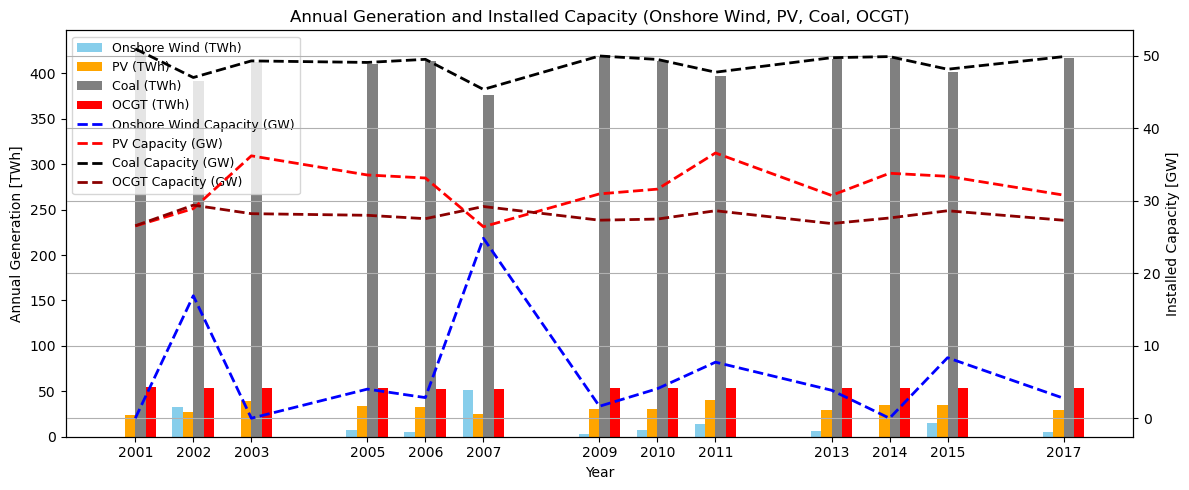

In [61]:
# Example data: replace with your actual DataFrames if needed
years = np.array([2001, 2002, 2003, 2005, 2006, 2007, 2009, 2010, 2011, 2013, 2014, 2015, 2017])  # match your data length

# Convert values to arrays
onwind = np.array(onwind)
pv = np.array(pv)
coal = np.array(coal)
ocgt = np.array(ocgt)

onwind_cap = np.array(onwind_cap)
pv_cap = np.array(pv_cap)
coal_cap = np.array(coal_cap)
ocgt_cap = np.array(ocgt_cap)

# Bar chart width
width = 0.18

# Set up plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Generation bars (TWh)
ax1.bar(years - 1.5*width, onwind / 1e6, width=width, label='Onshore Wind (TWh)', color='skyblue')
ax1.bar(years - 0.5*width, pv / 1e6, width=width, label='PV (TWh)', color='orange')
ax1.bar(years + 0.5*width, coal / 1e6, width=width, label='Coal (TWh)', color='gray')
ax1.bar(years + 1.5*width, ocgt / 1e6, width=width, label='OCGT (TWh)', color='red')

ax1.set_ylabel("Annual Generation [TWh]")
ax1.set_xlabel("Year")
ax1.set_title("Annual Generation and Installed Capacity (Onshore Wind, PV, Coal, OCGT)")

# Format x-axis years
ax1.set_xticks(years)
ax1.set_xticklabels([str(year) for year in years])

# Capacity lines (GW) on second y-axis
ax2 = ax1.twinx()
ax2.plot(years, onwind_cap / 1e3, 'b--', label='Onshore Wind Capacity (GW)', linewidth=2)
ax2.plot(years, pv_cap / 1e3, 'r--', label='PV Capacity (GW)', linewidth=2)
ax2.plot(years, coal_cap / 1e3, 'k--', label='Coal Capacity (GW)', linewidth=2)
ax2.plot(years, ocgt_cap / 1e3, 'darkred', linestyle='--', label='OCGT Capacity (GW)', linewidth=2)

ax2.set_ylabel("Installed Capacity [GW]")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/ipykernel_30711/57335981.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


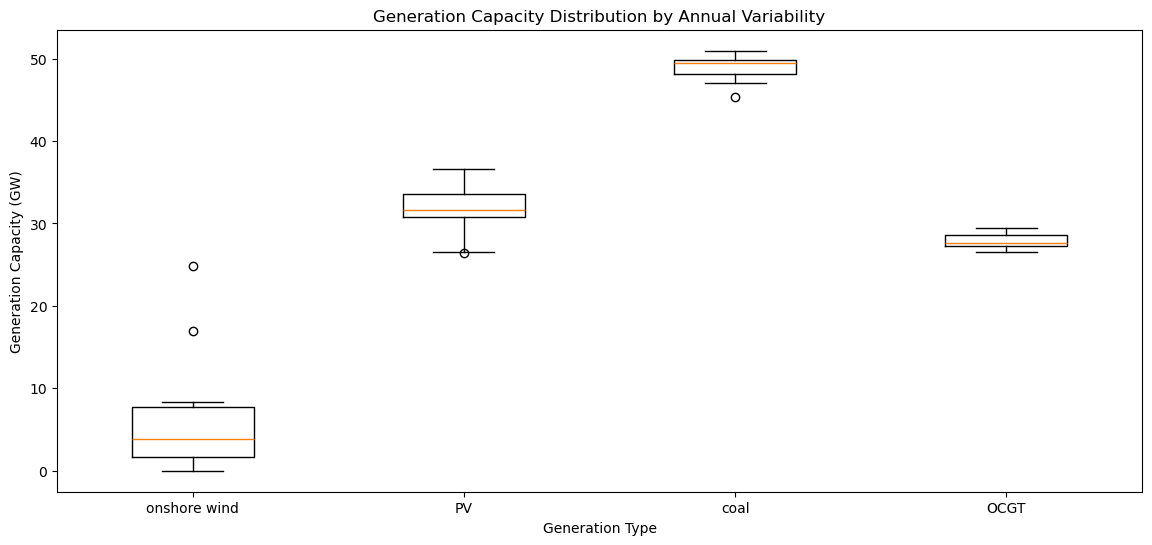

In [60]:
results = pd.DataFrame(
    np.array([np.array(onwind_cap)/10**3, np.array(pv_cap)/10**3, 
             np.array(coal_cap)/10**3, np.array(ocgt_cap)/10**3]).T,
    columns=["onshorewind", "PV", "coal", "OCGT"],
    index=years,
)

# Make a boxplot
plt.figure(figsize=(14, 6))
plt.boxplot(
    [results["onshorewind"], results["PV"], results["coal"], results["OCGT"]],
    labels=["onshore wind", "PV", "coal", "OCGT"]
)
plt.title("Generation Capacity Distribution by Annual Variability")
plt.ylabel("Generation Capacity (GW)")
plt.xlabel("Generation Type")

plt.savefig("test.png", dpi=300)

# Section D

In [106]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

# add electricity bus
n.add("Bus",
            f"E_bus{country}")

# add load to the bus
n.add("Load",
            "load",
            bus=f"E_bus{country}",
            p_set=df_elec[country].values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
#n.add("Carrier", "rooftopPV")

''' Add renewable generators '''
# Add onshore wind
CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 30 # years
discount_rate = 0.07 # 7%
capex = 910000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "onshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_onshore.values)


# Add offshore wind
CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 2506000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "offshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_offshore.values)

# Add large scale solar
CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 425000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "PV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solarPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_pv,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

'''
# Add rooftop solar
CF_rooftop = df_rooftop[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 725000 # in €/MW
fopex = 0.02 # 2% of capex
capital_cost_rooftop = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "rooftopPV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="rooftopPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_rooftop,
            marginal_cost = 0,
            p_max_pu = CF_rooftop.values)
'''
            
''' Add non-renewables generators '''
# add OCGT (Open Cycle Gas Turbine) generator
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 560000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
n.add("Generator",
            "OCGT",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            efficiency = efficiency,
            marginal_cost = marginal_cost_OCGT)

# add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 3294000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 4 # in €/MWh_th 
efficiency = 0.36 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
n.add("Generator",
            "coal",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            efficiency = efficiency,
            marginal_cost = marginal_cost_coal)


# Add storage unit
n.add("StorageUnit",
            "battery",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            capital_cost=12894+24678,
            efficiency_dispatch=0.96,
            efficiency_store=0.96,
            max_hours=2,
            cyclic_state_of_charge=True,)


# Co2 Cap
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=152000000, #152MtCO2
)


/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future versio

In [107]:
n.optimize(solver_name='gurobi')

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 76.77it/s]
INFO:linopy.io: Writing time: 0.65s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-s9la6dhr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-s9la6dhr.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 157687 rows, 70086 columns, 319878 nonzeros


INFO:gurobipy:obj: 157687 rows, 70086 columns, 319878 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 157687 rows, 70086 columns and 319878 nonzeros


INFO:gurobipy:Optimize a model with 157687 rows, 70086 columns and 319878 nonzeros


Model fingerprint: 0x39584964


INFO:gurobipy:Model fingerprint: 0x39584964


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 74334 rows and 4248 columns


INFO:gurobipy:Presolve removed 74334 rows and 4248 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolved: 83353 rows, 65838 columns, 241296 nonzeros


INFO:gurobipy:Presolved: 83353 rows, 65838 columns, 241296 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 2.017e+05


INFO:gurobipy: AA' NZ     : 2.017e+05


 Factor NZ  : 1.189e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.189e+06 (roughly 70 MB of memory)


 Factor Ops : 1.760e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.760e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.75525293e+12  0.00000000e+00  3.01e+10 0.00e+00  6.23e+09     0s


INFO:gurobipy:   0   4.75525293e+12  0.00000000e+00  3.01e+10 0.00e+00  6.23e+09     0s


   1   6.95783778e+12 -1.25448859e+12  5.39e+09 3.70e+02  1.41e+09     0s


INFO:gurobipy:   1   6.95783778e+12 -1.25448859e+12  5.39e+09 3.70e+02  1.41e+09     0s


   2   5.98024259e+12 -1.22962732e+12  4.22e+08 5.79e+01  2.39e+08     0s


INFO:gurobipy:   2   5.98024259e+12 -1.22962732e+12  4.22e+08 5.79e+01  2.39e+08     0s


   3   1.82819753e+12 -3.94201283e+11  2.49e-07 4.63e+00  2.81e+07     0s


INFO:gurobipy:   3   1.82819753e+12 -3.94201283e+11  2.49e-07 4.63e+00  2.81e+07     0s


   4   6.60928360e+11 -6.82305938e+10  1.75e-07 7.06e-01  6.87e+06     0s


INFO:gurobipy:   4   6.60928360e+11 -6.82305938e+10  1.75e-07 7.06e-01  6.87e+06     0s


   5   2.11823820e+11 -1.22006587e+10  9.21e-08 8.17e-02  1.83e+06     0s


INFO:gurobipy:   5   2.11823820e+11 -1.22006587e+10  9.21e-08 8.17e-02  1.83e+06     0s


   6   1.02580267e+11  1.99226213e+09  4.99e-08 6.11e-10  7.88e+05     0s


INFO:gurobipy:   6   1.02580267e+11  1.99226213e+09  4.99e-08 6.11e-10  7.88e+05     0s


   7   7.49462406e+10  8.92161470e+09  3.54e-08 1.69e-09  5.11e+05     0s


INFO:gurobipy:   7   7.49462406e+10  8.92161470e+09  3.54e-08 1.69e-09  5.11e+05     0s


   8   5.29012244e+10  1.54444049e+10  2.53e-08 2.04e-09  2.87e+05     0s


INFO:gurobipy:   8   5.29012244e+10  1.54444049e+10  2.53e-08 2.04e-09  2.87e+05     0s


   9   4.39089305e+10  1.85253816e+10  2.01e-08 2.74e-09  1.94e+05     1s


INFO:gurobipy:   9   4.39089305e+10  1.85253816e+10  2.01e-08 2.74e-09  1.94e+05     1s


  10   3.75133499e+10  2.26055475e+10  2.26e-08 2.21e-09  1.14e+05     1s


INFO:gurobipy:  10   3.75133499e+10  2.26055475e+10  2.26e-08 2.21e-09  1.14e+05     1s


  11   3.30766950e+10  2.45124338e+10  2.80e-08 1.75e-09  6.52e+04     1s


INFO:gurobipy:  11   3.30766950e+10  2.45124338e+10  2.80e-08 1.75e-09  6.52e+04     1s


  12   3.15336927e+10  2.55866107e+10  4.73e-08 9.31e-10  4.52e+04     1s


INFO:gurobipy:  12   3.15336927e+10  2.55866107e+10  4.73e-08 9.31e-10  4.52e+04     1s


  13   3.09313823e+10  2.58644585e+10  5.85e-08 1.75e-10  3.85e+04     1s


INFO:gurobipy:  13   3.09313823e+10  2.58644585e+10  5.85e-08 1.75e-10  3.85e+04     1s


  14   3.01788022e+10  2.61339692e+10  4.67e-08 1.86e-09  3.08e+04     1s


INFO:gurobipy:  14   3.01788022e+10  2.61339692e+10  4.67e-08 1.86e-09  3.08e+04     1s


  15   2.97138266e+10  2.64005843e+10  7.06e-08 4.37e-10  2.52e+04     1s


INFO:gurobipy:  15   2.97138266e+10  2.64005843e+10  7.06e-08 4.37e-10  2.52e+04     1s


  16   2.92202625e+10  2.66355448e+10  1.02e-07 4.95e-10  1.96e+04     1s


INFO:gurobipy:  16   2.92202625e+10  2.66355448e+10  1.02e-07 4.95e-10  1.96e+04     1s


  17   2.88330474e+10  2.67975131e+10  1.42e-07 1.51e-09  1.55e+04     1s


INFO:gurobipy:  17   2.88330474e+10  2.67975131e+10  1.42e-07 1.51e-09  1.55e+04     1s


  18   2.86812273e+10  2.70870659e+10  7.75e-07 1.46e-10  1.21e+04     1s


INFO:gurobipy:  18   2.86812273e+10  2.70870659e+10  7.75e-07 1.46e-10  1.21e+04     1s


  19   2.83872338e+10  2.72444779e+10  3.80e-07 1.27e-10  8.69e+03     1s


INFO:gurobipy:  19   2.83872338e+10  2.72444779e+10  3.80e-07 1.27e-10  8.69e+03     1s


  20   2.83528303e+10  2.72599790e+10  3.63e-07 8.73e-11  8.31e+03     1s


INFO:gurobipy:  20   2.83528303e+10  2.72599790e+10  3.63e-07 8.73e-11  8.31e+03     1s


  21   2.82901021e+10  2.73135972e+10  3.27e-07 2.85e-09  7.42e+03     1s


INFO:gurobipy:  21   2.82901021e+10  2.73135972e+10  3.27e-07 2.85e-09  7.42e+03     1s


  22   2.82651755e+10  2.73780778e+10  5.25e-07 6.18e-10  6.74e+03     1s


INFO:gurobipy:  22   2.82651755e+10  2.73780778e+10  5.25e-07 6.18e-10  6.74e+03     1s


  23   2.81883126e+10  2.74206388e+10  2.11e-07 7.57e-10  5.84e+03     1s


INFO:gurobipy:  23   2.81883126e+10  2.74206388e+10  2.11e-07 7.57e-10  5.84e+03     1s


  24   2.80859564e+10  2.75018344e+10  2.57e-07 6.98e-10  4.44e+03     1s


INFO:gurobipy:  24   2.80859564e+10  2.75018344e+10  2.57e-07 6.98e-10  4.44e+03     1s


  25   2.80417066e+10  2.75664543e+10  2.48e-07 9.09e-10  3.61e+03     1s


INFO:gurobipy:  25   2.80417066e+10  2.75664543e+10  2.48e-07 9.09e-10  3.61e+03     1s


  26   2.80245934e+10  2.75750082e+10  2.16e-07 7.42e-10  3.42e+03     1s


INFO:gurobipy:  26   2.80245934e+10  2.75750082e+10  2.16e-07 7.42e-10  3.42e+03     1s


  27   2.79739844e+10  2.75841342e+10  2.16e-07 7.86e-10  2.96e+03     1s


INFO:gurobipy:  27   2.79739844e+10  2.75841342e+10  2.16e-07 7.86e-10  2.96e+03     1s


  28   2.79514765e+10  2.76040218e+10  2.02e-07 5.17e-10  2.64e+03     1s


INFO:gurobipy:  28   2.79514765e+10  2.76040218e+10  2.02e-07 5.17e-10  2.64e+03     1s


  29   2.79203560e+10  2.76219130e+10  5.84e-07 4.80e-10  2.27e+03     1s


INFO:gurobipy:  29   2.79203560e+10  2.76219130e+10  5.84e-07 4.80e-10  2.27e+03     1s


  30   2.79120627e+10  2.76283104e+10  5.50e-07 1.46e-09  2.16e+03     1s


INFO:gurobipy:  30   2.79120627e+10  2.76283104e+10  5.50e-07 1.46e-09  2.16e+03     1s


  31   2.79120049e+10  2.76301247e+10  5.65e-07 1.40e-09  2.14e+03     1s


INFO:gurobipy:  31   2.79120049e+10  2.76301247e+10  5.65e-07 1.40e-09  2.14e+03     1s


  32   2.79065382e+10  2.76663622e+10  5.39e-07 2.92e-09  1.83e+03     1s


INFO:gurobipy:  32   2.79065382e+10  2.76663622e+10  5.39e-07 2.92e-09  1.83e+03     1s


  33   2.78952311e+10  2.77209131e+10  6.53e-07 1.92e-09  1.32e+03     1s


INFO:gurobipy:  33   2.78952311e+10  2.77209131e+10  6.53e-07 1.92e-09  1.32e+03     1s


  34   2.78904570e+10  2.77365460e+10  6.14e-07 5.70e-09  1.17e+03     1s


INFO:gurobipy:  34   2.78904570e+10  2.77365460e+10  6.14e-07 5.70e-09  1.17e+03     1s


  35   2.78791291e+10  2.77397042e+10  4.98e-07 6.11e-09  1.06e+03     1s


INFO:gurobipy:  35   2.78791291e+10  2.77397042e+10  4.98e-07 6.11e-09  1.06e+03     1s


  36   2.78742434e+10  2.77503109e+10  4.30e-07 2.15e-09  9.42e+02     1s


INFO:gurobipy:  36   2.78742434e+10  2.77503109e+10  4.30e-07 2.15e-09  9.42e+02     1s


  37   2.78694476e+10  2.77565215e+10  3.96e-07 1.46e-09  8.58e+02     1s


INFO:gurobipy:  37   2.78694476e+10  2.77565215e+10  3.96e-07 1.46e-09  8.58e+02     1s


  38   2.78682116e+10  2.77588641e+10  3.70e-07 2.12e-09  8.31e+02     1s


INFO:gurobipy:  38   2.78682116e+10  2.77588641e+10  3.70e-07 2.12e-09  8.31e+02     1s


  39   2.78668208e+10  2.77656634e+10  3.64e-07 1.40e-09  7.69e+02     1s


INFO:gurobipy:  39   2.78668208e+10  2.77656634e+10  3.64e-07 1.40e-09  7.69e+02     1s


  40   2.78672742e+10  2.77739651e+10  7.21e-07 3.14e-09  7.09e+02     1s


INFO:gurobipy:  40   2.78672742e+10  2.77739651e+10  7.21e-07 3.14e-09  7.09e+02     1s


  41   2.78610837e+10  2.77787109e+10  6.11e-07 2.21e-09  6.26e+02     2s


INFO:gurobipy:  41   2.78610837e+10  2.77787109e+10  6.11e-07 2.21e-09  6.26e+02     2s


  42   2.78593382e+10  2.77874966e+10  2.33e-07 3.84e-09  5.46e+02     2s


INFO:gurobipy:  42   2.78593382e+10  2.77874966e+10  2.33e-07 3.84e-09  5.46e+02     2s


  43   2.78490396e+10  2.78040701e+10  1.69e-06 5.24e-10  3.42e+02     2s


INFO:gurobipy:  43   2.78490396e+10  2.78040701e+10  1.69e-06 5.24e-10  3.42e+02     2s


  44   2.78474670e+10  2.78063830e+10  1.47e-06 5.24e-10  3.12e+02     2s


INFO:gurobipy:  44   2.78474670e+10  2.78063830e+10  1.47e-06 5.24e-10  3.12e+02     2s


  45   2.78453762e+10  2.78161895e+10  2.95e-06 1.86e-09  2.22e+02     2s


INFO:gurobipy:  45   2.78453762e+10  2.78161895e+10  2.95e-06 1.86e-09  2.22e+02     2s


  46   2.78429431e+10  2.78246662e+10  1.04e-06 1.37e-09  1.39e+02     2s


INFO:gurobipy:  46   2.78429431e+10  2.78246662e+10  1.04e-06 1.37e-09  1.39e+02     2s


  47   2.78398325e+10  2.78302926e+10  2.81e-06 4.11e-10  7.25e+01     2s


INFO:gurobipy:  47   2.78398325e+10  2.78302926e+10  2.81e-06 4.11e-10  7.25e+01     2s


  48   2.78395668e+10  2.78316539e+10  1.97e-06 1.07e-08  6.01e+01     2s


INFO:gurobipy:  48   2.78395668e+10  2.78316539e+10  1.97e-06 1.07e-08  6.01e+01     2s


  49   2.78390011e+10  2.78333197e+10  6.68e-07 1.46e-08  4.32e+01     2s


INFO:gurobipy:  49   2.78390011e+10  2.78333197e+10  6.68e-07 1.46e-08  4.32e+01     2s


  50   2.78386229e+10  2.78365193e+10  1.18e-06 9.43e-09  1.60e+01     2s


INFO:gurobipy:  50   2.78386229e+10  2.78365193e+10  1.18e-06 9.43e-09  1.60e+01     2s


  51   2.78384285e+10  2.78383190e+10  4.55e-06 2.46e-08  8.32e-01     2s


INFO:gurobipy:  51   2.78384285e+10  2.78383190e+10  4.55e-06 2.46e-08  8.32e-01     2s


  52   2.78383670e+10  2.78383645e+10  9.34e-08 2.10e-09  1.87e-02     2s


INFO:gurobipy:  52   2.78383670e+10  2.78383645e+10  9.34e-08 2.10e-09  1.87e-02     2s


  53   2.78383661e+10  2.78383661e+10  1.77e-05 1.51e-09  1.87e-05     2s


INFO:gurobipy:  53   2.78383661e+10  2.78383661e+10  1.77e-05 1.51e-09  1.87e-05     2s


  54   2.78383661e+10  2.78383661e+10  4.86e-09 2.76e-08  7.59e-10     2s


INFO:gurobipy:  54   2.78383661e+10  2.78383661e+10  4.86e-09 2.76e-08  7.59e-10     2s


INFO:gurobipy:


Barrier solved model in 54 iterations and 1.88 seconds (2.26 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 1.88 seconds (2.26 work units)


Optimal objective 2.78383661e+10


INFO:gurobipy:Optimal objective 2.78383661e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    9104 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    9104 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    9933 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    9933 PPushes remaining with PInf 0.0000000e+00                 2s


    5417 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    5417 PPushes remaining with PInf 0.0000000e+00                 5s


    1372 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    1372 PPushes remaining with PInf 0.0000000e+00                10s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2695833e-08     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2695833e-08     12s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17850    2.7838366e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:   17850    2.7838366e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 17850 iterations and 12.88 seconds (45.07 work units)


INFO:gurobipy:Solved in 17850 iterations and 12.88 seconds (45.07 work units)


Optimal objective  2.783836609e+10


INFO:gurobipy:Optimal objective  2.783836609e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70086 primals, 157687 duals
Objective: 2.78e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

('ok', 'optimal')

<Axes: xlabel='snapshot', ylabel='dispatch'>

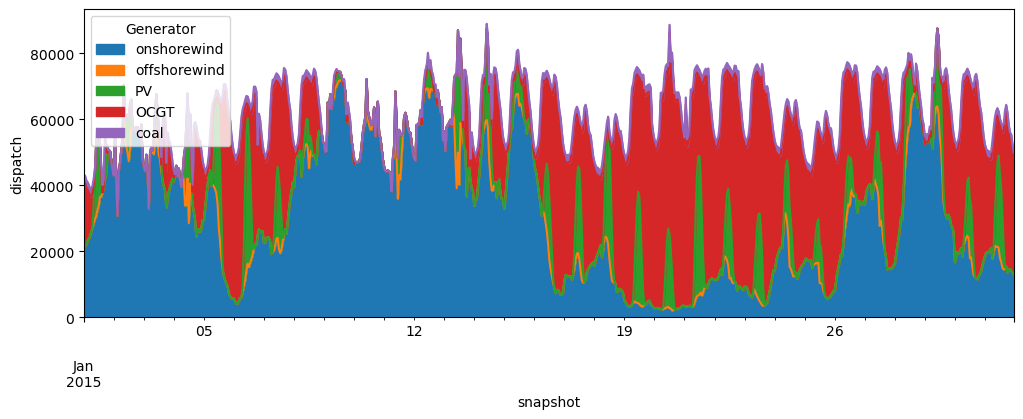

In [108]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(12, 4), ylabel="dispatch")

Text(0.5, 1.07, 'Generation mix')

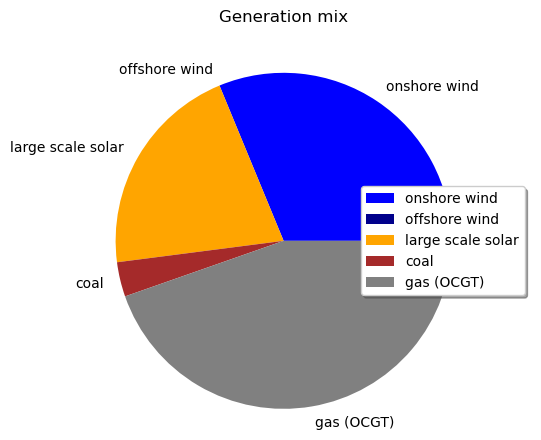

In [109]:
labels = ['onshore wind',
            'offshore wind',
            'large scale solar',
            #'rooftop solar',
            'coal',
            'gas (OCGT)']
      
sizes = [n.generators_t.p['onshorewind'].sum(),
         n.generators_t.p['offshorewind'].sum(),
         n.generators_t.p['PV'].sum(),
         #n.generators_t.p['rooftopPV'].sum(),
         n.generators_t.p['coal'].sum(),
         n.generators_t.p['OCGT'].sum()]

colors=['blue', 'darkblue', 'orange', 'brown', 'grey']

plt.pie(sizes,
      colors=colors,
      labels=labels,
      wedgeprops={'linewidth':0})
plt.axis('equal')
plt.legend(fancybox=True, shadow=True, loc='right')
plt.title('Generation mix', y=1.07)

__Storage Installed__

In [119]:
# Storage installed capacity
print(f"Installed capacity of storage: {n.storage_units.p_nom_opt.loc['battery'] / 1e3} GW")

Installed capacity of storage: 13.062109708727636 GW


<Axes: xlabel='snapshot', ylabel='Power (MW)'>

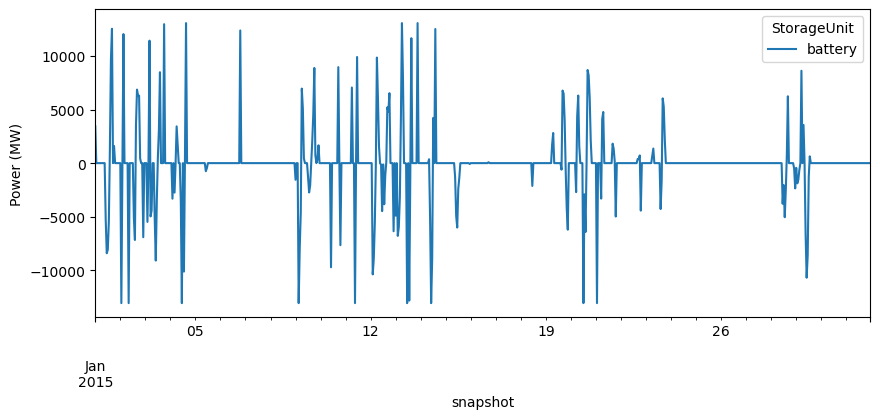

In [141]:
# Storage dispatch in January 2015
n.storage_units_t.p.loc["2015-01"].plot(figsize=(10, 4), ylabel="Power (MW)")

<Axes: xlabel='snapshot', ylabel='Weekly Power Sum (MW·h)'>

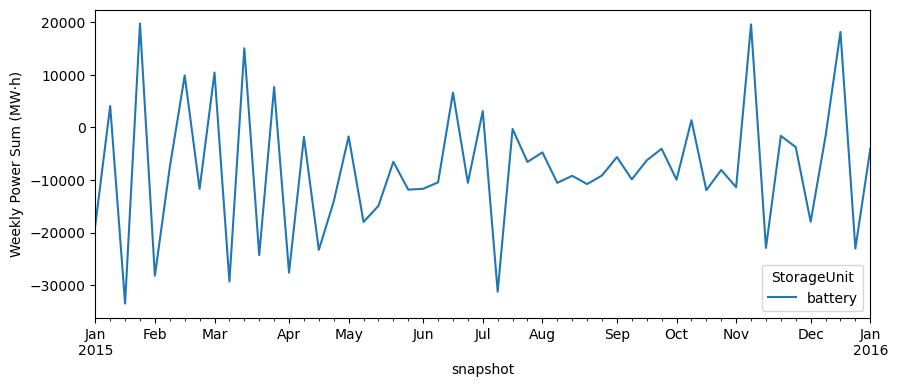

In [ ]:
# Resample to weekly sums and plot
n.storage_units_t.p.loc["2015"].resample("W").sum().plot(
    figsize=(10, 4),
    ylabel="Weekly Power Sum (MWh)" 
)

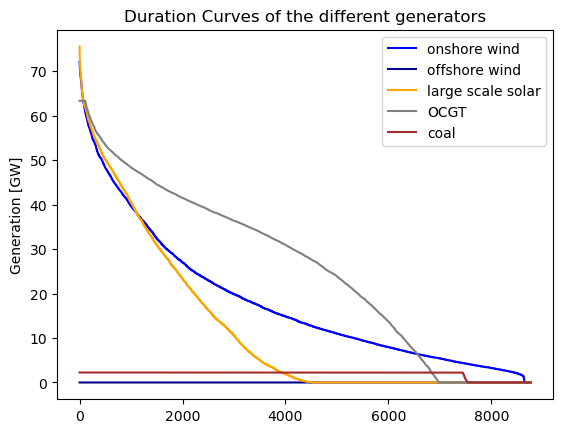

In [111]:
# Duration Curves
cf_onshore = n.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_offshore = n.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_PV = n.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)/1e3
#cf_rooftopPV = n.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_OCGT = n.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)/1e3
cf_coal = n.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)/1e3


cf_onshore.plot(kind='line', ylabel='CF onshore', color='blue')
cf_offshore.plot(kind='line', ylabel='CF offshore', color='darkblue')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
#cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='grey')
cf_coal.plot(kind='line', ylabel='CF coal', color='brown')
plt.title('Duration Curves of the different generators')
plt.legend(['onshore wind', 'offshore wind', 'large scale solar', 'OCGT', 'coal'])
plt.ylabel('Generation [GW]')
plt.show()

In [112]:
n.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind      92.529390
offshorewind      0.000000
PV              102.542553
OCGT             63.352489
coal              2.246037
Name: p_nom_opt, dtype: float64

In [113]:
print(f"Total cost: {round(n.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(n.objective/n.loads_t.p.sum().iloc[0]))} EUR/MWh")


Total cost: 27838.37 mio€
Cost per MWh of electricity produced 55 EUR/MWh


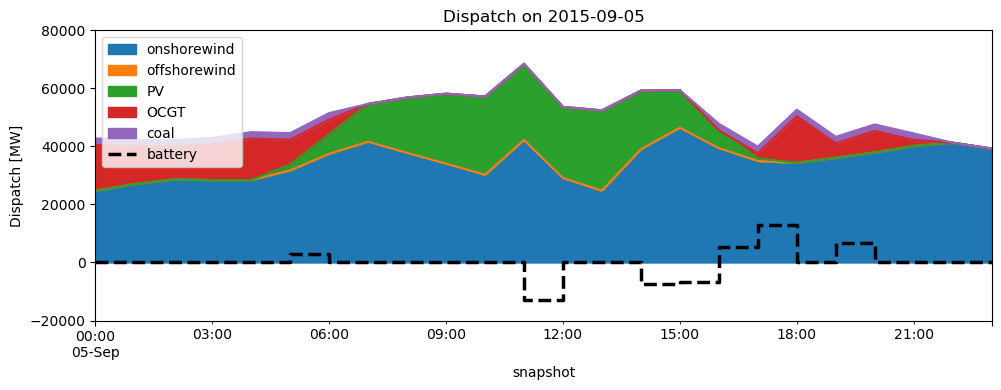

In [128]:
day = "2015-09-05"
ax = n.generators_t.p.loc[day].plot.area(figsize=(10, 4), ylabel="Dispatch [MW]", legend=True)

# 2. Overlay storage unit dispatch as step lines
n.storage_units_t.p.loc[day].plot(ax=ax, drawstyle="steps-post", linewidth=2.5, linestyle="--", color="black", label="Battery")

# 3. Customize
plt.title(f"Dispatch on {day}")
plt.tight_layout()
plt.ylim(-20000, 80000)
plt.legend(loc="upper left")
plt.show()

# Section E

In [46]:
# Our desired target for CO2 emissions limit is 50MtCO2
co2 = 50 # in tCO2
n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6

n.optimize(solver_name='gurobi')


/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 69.96it/s]
INFO:linopy.io: Writing time: 0.7s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-64xzmeua.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-64xzmeua.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0xf31bdc90


INFO:gurobipy:Model fingerprint: 0xf31bdc90


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+07]


INFO:gurobipy:  RHS range        [4e+04, 5e+07]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.59685345e+12  0.00000000e+00  1.88e+10 0.00e+00  4.03e+09     0s


INFO:gurobipy:   0   3.59685345e+12  0.00000000e+00  1.88e+10 0.00e+00  4.03e+09     0s


   1   5.37476449e+12 -1.18769344e+12  3.48e+09 3.85e+02  9.23e+08     0s


INFO:gurobipy:   1   5.37476449e+12 -1.18769344e+12  3.48e+09 3.85e+02  9.23e+08     0s


   2   4.61671708e+12 -1.12243049e+12  3.44e+08 6.84e+01  1.76e+08     0s


INFO:gurobipy:   2   4.61671708e+12 -1.12243049e+12  3.44e+08 6.84e+01  1.76e+08     0s


   3   1.29974768e+12 -2.18803613e+11  5.47e+04 3.98e+00  1.71e+07     0s


INFO:gurobipy:   3   1.29974768e+12 -2.18803613e+11  5.47e+04 3.98e+00  1.71e+07     0s


   4   5.02410644e+11 -4.52746024e+10  7.45e+03 7.89e-01  4.78e+06     0s


INFO:gurobipy:   4   5.02410644e+11 -4.52746024e+10  7.45e+03 7.89e-01  4.78e+06     0s


   5   2.02040952e+11 -9.71729334e+09  1.30e+00 2.64e-01  1.64e+06     0s


INFO:gurobipy:   5   2.02040952e+11 -9.71729334e+09  1.30e+00 2.64e-01  1.64e+06     0s


   6   9.82456083e+10  3.90361371e+09  5.11e-01 1.36e-01  6.99e+05     0s


INFO:gurobipy:   6   9.82456083e+10  3.90361371e+09  5.11e-01 1.36e-01  6.99e+05     0s


   7   6.72084863e+10  1.16308687e+10  2.91e-01 6.62e-02  4.05e+05     1s


INFO:gurobipy:   7   6.72084863e+10  1.16308687e+10  2.91e-01 6.62e-02  4.05e+05     1s


   8   5.72010713e+10  1.45170951e+10  2.10e-01 4.66e-02  3.10e+05     1s


INFO:gurobipy:   8   5.72010713e+10  1.45170951e+10  2.10e-01 4.66e-02  3.10e+05     1s


   9   5.35157642e+10  1.57035172e+10  1.82e-01 4.40e-02  2.74e+05     1s


INFO:gurobipy:   9   5.35157642e+10  1.57035172e+10  1.82e-01 4.40e-02  2.74e+05     1s


  10   4.64953596e+10  2.08942547e+10  1.28e-01 1.40e-09  1.84e+05     1s


INFO:gurobipy:  10   4.64953596e+10  2.08942547e+10  1.28e-01 1.40e-09  1.84e+05     1s


  11   4.18410077e+10  2.47942299e+10  8.45e-02 1.57e-09  1.22e+05     1s


INFO:gurobipy:  11   4.18410077e+10  2.47942299e+10  8.45e-02 1.57e-09  1.22e+05     1s


  12   3.82340504e+10  2.70079534e+10  5.47e-02 5.53e-10  8.04e+04     1s


INFO:gurobipy:  12   3.82340504e+10  2.70079534e+10  5.47e-02 5.53e-10  8.04e+04     1s


  13   3.63012253e+10  2.81743390e+10  3.87e-02 6.40e-10  5.82e+04     1s


INFO:gurobipy:  13   3.63012253e+10  2.81743390e+10  3.87e-02 6.40e-10  5.82e+04     1s


  14   3.59579978e+10  2.95773905e+10  3.54e-02 2.91e-10  4.56e+04     1s


INFO:gurobipy:  14   3.59579978e+10  2.95773905e+10  3.54e-02 2.91e-10  4.56e+04     1s


  15   3.41272731e+10  3.06044015e+10  1.51e-02 2.44e-09  2.52e+04     1s


INFO:gurobipy:  15   3.41272731e+10  3.06044015e+10  1.51e-02 2.44e-09  2.52e+04     1s


  16   3.32731781e+10  3.14565606e+10  6.16e-03 4.07e-10  1.30e+04     1s


INFO:gurobipy:  16   3.32731781e+10  3.14565606e+10  6.16e-03 4.07e-10  1.30e+04     1s


  17   3.30245410e+10  3.22415742e+10  3.82e-03 2.04e-09  5.59e+03     1s


INFO:gurobipy:  17   3.30245410e+10  3.22415742e+10  3.82e-03 2.04e-09  5.59e+03     1s


  18   3.28582008e+10  3.24348485e+10  2.29e-03 8.15e-10  3.02e+03     1s


INFO:gurobipy:  18   3.28582008e+10  3.24348485e+10  2.29e-03 8.15e-10  3.02e+03     1s


  19   3.26916527e+10  3.25287047e+10  7.30e-04 5.82e-10  1.16e+03     1s


INFO:gurobipy:  19   3.26916527e+10  3.25287047e+10  7.30e-04 5.82e-10  1.16e+03     1s


  20   3.26256129e+10  3.25868861e+10  1.68e-04 7.64e-11  2.76e+02     1s


INFO:gurobipy:  20   3.26256129e+10  3.25868861e+10  1.68e-04 7.64e-11  2.76e+02     1s


  21   3.26067666e+10  3.26029890e+10  1.98e-05 6.34e-09  2.68e+01     1s


INFO:gurobipy:  21   3.26067666e+10  3.26029890e+10  1.98e-05 6.34e-09  2.68e+01     1s


  22   3.26046532e+10  3.26033850e+10  3.17e-05 2.74e-09  9.01e+00     1s


INFO:gurobipy:  22   3.26046532e+10  3.26033850e+10  3.17e-05 2.74e-09  9.01e+00     1s


  23   3.26040403e+10  3.26034537e+10  9.93e-05 3.38e-09  4.17e+00     1s


INFO:gurobipy:  23   3.26040403e+10  3.26034537e+10  9.93e-05 3.38e-09  4.17e+00     1s


  24   3.26034931e+10  3.26034672e+10  7.74e-05 7.86e-10  1.84e-01     1s


INFO:gurobipy:  24   3.26034931e+10  3.26034672e+10  7.74e-05 7.86e-10  1.84e-01     1s


  25   3.26034766e+10  3.26034766e+10  3.67e-06 9.57e-10  1.86e-04     1s


INFO:gurobipy:  25   3.26034766e+10  3.26034766e+10  3.67e-06 9.57e-10  1.86e-04     1s


  26   3.26034766e+10  3.26034766e+10  3.67e-06 9.57e-10  1.86e-04     1s


INFO:gurobipy:  26   3.26034766e+10  3.26034766e+10  3.67e-06 9.57e-10  1.86e-04     1s


INFO:gurobipy:


Barrier solved model in 26 iterations and 1.17 seconds (1.34 work units)


INFO:gurobipy:Barrier solved model in 26 iterations and 1.17 seconds (1.34 work units)


Optimal objective 3.26034766e+10


INFO:gurobipy:Optimal objective 3.26034766e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22134 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   22134 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   51308 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   51308 PPushes remaining with PInf 0.0000000e+00                 1s


   27401 PPushes remaining with PInf 7.5894350e-06                10s


INFO:gurobipy:   27401 PPushes remaining with PInf 7.5894350e-06                10s


    5247 PPushes remaining with PInf 2.6898459e-05                21s


INFO:gurobipy:    5247 PPushes remaining with PInf 2.6898459e-05                21s


       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2705711e-09     22s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2705711e-09     22s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   64726    3.2603477e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:   64726    3.2603477e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 64726 iterations and 21.96 seconds (29.78 work units)


INFO:gurobipy:Solved in 64726 iterations and 21.96 seconds (29.78 work units)


Optimal objective  3.260347660e+10


INFO:gurobipy:Optimal objective  3.260347660e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 3.26e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

('ok', 'optimal')

In [47]:
print(f"Total cost: {round(n.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(n.objective/n.loads_t.p.sum().iloc[0]))} EUR/MWh")
print(f"CO2 tax {-n.global_constraints.mu['CO2Limit']} EUR/tCO2")

Total cost: 32603.48 mio€
Cost per MWh of electricity produced 65 EUR/MWh
CO2 tax 135.2678650033746 EUR/tCO2


In [48]:
systemcost = []
onwind = []
offwind = []
pv = []
rooftop = []
coal = []
ocgt = []

onwind_cap = []
offwind_cap = []
pv_cap = []
rooftop_cap = []
coal_cap = []
ocgt_cap = []

co2_tax = []

co2_index = [1500, 1000, 500, 250, 225, 100, 50, 0]

for co2 in co2_index: # in MtCO2
    n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    n.optimize(solver_name="gurobi")
    systemcost.append(n.objective / 1e6)  # in million euros
    onwind.append(n.generators_t.p["onshorewind"].sum())
    offwind.append(n.generators_t.p["offshorewind"].sum())
    pv.append(n.generators_t.p["PV"].sum())
    rooftop.append(n.generators_t.p["rooftopPV"].sum())
    coal.append(n.generators_t.p["coal"].sum())
    ocgt.append(n.generators_t.p["OCGT"].sum())

    onwind_cap.append(n.generators.p_nom_opt.loc["onshorewind"])
    offwind_cap.append(n.generators.p_nom_opt.loc["offshorewind"])
    pv_cap.append(n.generators.p_nom_opt.loc["PV"])
    rooftop_cap.append(n.generators.p_nom_opt.loc["rooftopPV"])
    coal_cap.append(n.generators.p_nom_opt.loc["coal"])
    ocgt_cap.append(n.generators.p_nom_opt.loc["OCGT"])

    co2_tax.append(-n.global_constraints.mu['CO2Limit'])
    
    

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 68.33it/s]
INFO:linopy.io: Writing time: 0.71s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-41wg97o9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-41wg97o9.lp


Reading time = 0.27 seconds


INFO:gurobipy:Reading time = 0.27 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0xbb9950af


INFO:gurobipy:Model fingerprint: 0xbb9950af


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.36767694e+13  0.00000000e+00  1.25e+11 0.00e+00  2.48e+10     0s


INFO:gurobipy:   0   2.36767694e+13  0.00000000e+00  1.25e+11 0.00e+00  2.48e+10     0s


   1   3.49900476e+13 -2.44233039e+12  2.44e+10 3.59e+02  5.76e+09     0s


INFO:gurobipy:   1   3.49900476e+13 -2.44233039e+12  2.44e+10 3.59e+02  5.76e+09     0s


   2   2.99900024e+13 -2.90730742e+12  3.01e+09 7.55e+01  1.25e+09     0s


INFO:gurobipy:   2   2.99900024e+13 -2.90730742e+12  3.01e+09 7.55e+01  1.25e+09     0s


   3   9.45189697e+12 -1.95609889e+12  1.33e-06 2.33e+00  1.12e+08     0s


INFO:gurobipy:   3   9.45189697e+12 -1.95609889e+12  1.33e-06 2.33e+00  1.12e+08     0s


   4   2.48166285e+12 -1.71055284e+11  9.65e-07 2.17e-01  2.08e+07     0s


INFO:gurobipy:   4   2.48166285e+12 -1.71055284e+11  9.65e-07 2.17e-01  2.08e+07     0s


   5   3.60061537e+11 -5.07117301e+09  1.67e-07 1.43e-09  2.66e+06     0s


INFO:gurobipy:   5   3.60061537e+11 -5.07117301e+09  1.67e-07 1.43e-09  2.66e+06     0s


   6   2.74073326e+11 -4.89865885e+09  1.24e-07 1.22e-09  2.03e+06     0s


INFO:gurobipy:   6   2.74073326e+11 -4.89865885e+09  1.24e-07 1.22e-09  2.03e+06     0s


   7   1.21874636e+11 -8.52432159e+09  5.75e-08 1.14e-09  9.45e+05     0s


INFO:gurobipy:   7   1.21874636e+11 -8.52432159e+09  5.75e-08 1.14e-09  9.45e+05     0s


   8   6.80351346e+10 -1.21629052e+09  4.74e-08 4.95e-10  4.97e+05     1s


INFO:gurobipy:   8   6.80351346e+10 -1.21629052e+09  4.74e-08 4.95e-10  4.97e+05     1s


   9   5.56318888e+10  6.66014640e+09  3.71e-08 6.40e-10  3.50e+05     1s


INFO:gurobipy:   9   5.56318888e+10  6.66014640e+09  3.71e-08 6.40e-10  3.50e+05     1s


  10   4.54318708e+10  1.33828278e+10  2.50e-08 8.15e-10  2.29e+05     1s


INFO:gurobipy:  10   4.54318708e+10  1.33828278e+10  2.50e-08 8.15e-10  2.29e+05     1s


  11   3.40408860e+10  1.90540378e+10  1.08e-08 4.95e-10  1.07e+05     1s


INFO:gurobipy:  11   3.40408860e+10  1.90540378e+10  1.08e-08 4.95e-10  1.07e+05     1s


  12   2.80538913e+10  2.17234651e+10  3.25e-08 3.90e-09  4.50e+04     1s


INFO:gurobipy:  12   2.80538913e+10  2.17234651e+10  3.25e-08 3.90e-09  4.50e+04     1s


  13   2.71763671e+10  2.29887821e+10  3.42e-08 1.98e-09  2.98e+04     1s


INFO:gurobipy:  13   2.71763671e+10  2.29887821e+10  3.42e-08 1.98e-09  2.98e+04     1s


  14   2.68281643e+10  2.30842751e+10  3.31e-08 2.62e-10  2.66e+04     1s


INFO:gurobipy:  14   2.68281643e+10  2.30842751e+10  3.31e-08 2.62e-10  2.66e+04     1s


  15   2.62500636e+10  2.35817335e+10  6.55e-08 8.15e-10  1.90e+04     1s


INFO:gurobipy:  15   2.62500636e+10  2.35817335e+10  6.55e-08 8.15e-10  1.90e+04     1s


  16   2.56414051e+10  2.38659345e+10  1.17e-07 2.91e-10  1.26e+04     1s


INFO:gurobipy:  16   2.56414051e+10  2.38659345e+10  1.17e-07 2.91e-10  1.26e+04     1s


  17   2.54280305e+10  2.39635746e+10  3.15e-07 4.37e-10  1.04e+04     1s


INFO:gurobipy:  17   2.54280305e+10  2.39635746e+10  3.15e-07 4.37e-10  1.04e+04     1s


  18   2.51670213e+10  2.41552651e+10  2.33e-07 2.91e-10  7.19e+03     1s


INFO:gurobipy:  18   2.51670213e+10  2.41552651e+10  2.33e-07 2.91e-10  7.19e+03     1s


  19   2.49799900e+10  2.42114885e+10  1.69e-07 1.16e-10  5.46e+03     1s


INFO:gurobipy:  19   2.49799900e+10  2.42114885e+10  1.69e-07 1.16e-10  5.46e+03     1s


  20   2.49272830e+10  2.42329236e+10  1.57e-07 3.78e-10  4.94e+03     1s


INFO:gurobipy:  20   2.49272830e+10  2.42329236e+10  1.57e-07 3.78e-10  4.94e+03     1s


  21   2.48460988e+10  2.43355905e+10  1.19e-07 2.44e-09  3.63e+03     1s


INFO:gurobipy:  21   2.48460988e+10  2.43355905e+10  1.19e-07 2.44e-09  3.63e+03     1s


  22   2.47582626e+10  2.43864220e+10  3.35e-07 9.31e-10  2.64e+03     1s


INFO:gurobipy:  22   2.47582626e+10  2.43864220e+10  3.35e-07 9.31e-10  2.64e+03     1s


  23   2.46990961e+10  2.44194903e+10  1.12e-06 6.40e-10  1.99e+03     1s


INFO:gurobipy:  23   2.46990961e+10  2.44194903e+10  1.12e-06 6.40e-10  1.99e+03     1s


  24   2.46639882e+10  2.44616936e+10  7.41e-07 1.57e-09  1.44e+03     1s


INFO:gurobipy:  24   2.46639882e+10  2.44616936e+10  7.41e-07 1.57e-09  1.44e+03     1s


  25   2.46593622e+10  2.45125324e+10  1.86e-06 7.57e-10  1.04e+03     1s


INFO:gurobipy:  25   2.46593622e+10  2.45125324e+10  1.86e-06 7.57e-10  1.04e+03     1s


  26   2.46098012e+10  2.45242438e+10  1.08e-06 4.66e-09  6.08e+02     1s


INFO:gurobipy:  26   2.46098012e+10  2.45242438e+10  1.08e-06 4.66e-09  6.08e+02     1s


  27   2.45920757e+10  2.45488799e+10  2.66e-06 3.20e-10  3.07e+02     1s


INFO:gurobipy:  27   2.45920757e+10  2.45488799e+10  2.66e-06 3.20e-10  3.07e+02     1s


  28   2.45854174e+10  2.45615553e+10  1.66e-06 2.56e-09  1.70e+02     1s


INFO:gurobipy:  28   2.45854174e+10  2.45615553e+10  1.66e-06 2.56e-09  1.70e+02     1s


  29   2.45840946e+10  2.45635941e+10  1.21e-06 4.02e-09  1.46e+02     1s


INFO:gurobipy:  29   2.45840946e+10  2.45635941e+10  1.21e-06 4.02e-09  1.46e+02     1s


  30   2.45829225e+10  2.45671742e+10  1.20e-06 5.82e-09  1.12e+02     1s


INFO:gurobipy:  30   2.45829225e+10  2.45671742e+10  1.20e-06 5.82e-09  1.12e+02     1s


  31   2.45805522e+10  2.45719314e+10  1.69e-05 5.82e-09  6.13e+01     1s


INFO:gurobipy:  31   2.45805522e+10  2.45719314e+10  1.69e-05 5.82e-09  6.13e+01     1s


  32   2.45795786e+10  2.45758144e+10  8.68e-06 1.57e-09  2.68e+01     1s


INFO:gurobipy:  32   2.45795786e+10  2.45758144e+10  8.68e-06 1.57e-09  2.68e+01     1s


  33   2.45791612e+10  2.45765818e+10  5.53e-06 2.27e-09  1.83e+01     1s


INFO:gurobipy:  33   2.45791612e+10  2.45765818e+10  5.53e-06 2.27e-09  1.83e+01     1s


  34   2.45789631e+10  2.45770975e+10  3.92e-06 1.28e-09  1.33e+01     1s


INFO:gurobipy:  34   2.45789631e+10  2.45770975e+10  3.92e-06 1.28e-09  1.33e+01     1s


  35   2.45788014e+10  2.45775837e+10  2.70e-06 8.73e-10  8.65e+00     1s


INFO:gurobipy:  35   2.45788014e+10  2.45775837e+10  2.70e-06 8.73e-10  8.65e+00     1s


  36   2.45786143e+10  2.45777947e+10  1.19e-06 1.75e-10  5.83e+00     1s


INFO:gurobipy:  36   2.45786143e+10  2.45777947e+10  1.19e-06 1.75e-10  5.83e+00     1s


  37   2.45785679e+10  2.45782091e+10  8.46e-07 2.15e-09  2.55e+00     2s


INFO:gurobipy:  37   2.45785679e+10  2.45782091e+10  8.46e-07 2.15e-09  2.55e+00     2s


  38   2.45785241e+10  2.45783773e+10  5.38e-07 6.40e-10  1.04e+00     2s


INFO:gurobipy:  38   2.45785241e+10  2.45783773e+10  5.38e-07 6.40e-10  1.04e+00     2s


  39   2.45785226e+10  2.45783898e+10  5.28e-07 1.28e-09  9.44e-01     2s


INFO:gurobipy:  39   2.45785226e+10  2.45783898e+10  5.28e-07 1.28e-09  9.44e-01     2s


  40   2.45785185e+10  2.45784033e+10  5.03e-07 7.86e-10  8.19e-01     2s


INFO:gurobipy:  40   2.45785185e+10  2.45784033e+10  5.03e-07 7.86e-10  8.19e-01     2s


  41   2.45784939e+10  2.45784188e+10  3.41e-07 7.86e-10  5.33e-01     2s


INFO:gurobipy:  41   2.45784939e+10  2.45784188e+10  3.41e-07 7.86e-10  5.33e-01     2s


  42   2.45784760e+10  2.45784226e+10  2.21e-07 6.40e-10  3.80e-01     2s


INFO:gurobipy:  42   2.45784760e+10  2.45784226e+10  2.21e-07 6.40e-10  3.80e-01     2s


  43   2.45784437e+10  2.45784428e+10  2.84e-09 2.33e-09  5.99e-03     2s


INFO:gurobipy:  43   2.45784437e+10  2.45784428e+10  2.84e-09 2.33e-09  5.99e-03     2s


  44   2.45784433e+10  2.45784433e+10  2.03e-08 1.98e-09  7.35e-06     2s


INFO:gurobipy:  44   2.45784433e+10  2.45784433e+10  2.03e-08 1.98e-09  7.35e-06     2s


  45   2.45784433e+10  2.45784433e+10  1.47e-08 1.48e-09  7.93e-10     2s


INFO:gurobipy:  45   2.45784433e+10  2.45784433e+10  1.47e-08 1.48e-09  7.93e-10     2s


INFO:gurobipy:


Barrier solved model in 45 iterations and 1.85 seconds (2.23 work units)


INFO:gurobipy:Barrier solved model in 45 iterations and 1.85 seconds (2.23 work units)


Optimal objective 2.45784433e+10


INFO:gurobipy:Optimal objective 2.45784433e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13490 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13490 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


    7303 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    7303 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1766044e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1766044e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   20796    2.4578443e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   20796    2.4578443e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 20796 iterations and 2.04 seconds (2.42 work units)


INFO:gurobipy:Solved in 20796 iterations and 2.04 seconds (2.42 work units)


Optimal objective  2.457844327e+10


INFO:gurobipy:Optimal objective  2.457844327e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 71.89it/s]
INFO:linopy.io: Writing time: 0.68s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-vvhaj7_j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-vvhaj7_j.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x23e5b8a2


INFO:gurobipy:Model fingerprint: 0x23e5b8a2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+09]


INFO:gurobipy:  RHS range        [4e+04, 1e+09]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.47419936e+13  0.00000000e+00  7.75e+10 0.00e+00  1.59e+10     0s


INFO:gurobipy:   0   1.47419936e+13  0.00000000e+00  7.75e+10 0.00e+00  1.59e+10     0s


   1   2.18711525e+13 -2.05334205e+12  1.51e+10 3.71e+02  3.69e+09     0s


INFO:gurobipy:   1   2.18711525e+13 -2.05334205e+12  1.51e+10 3.71e+02  3.69e+09     0s


   2   1.88631958e+13 -2.36612271e+12  1.82e+09 7.70e+01  7.93e+08     0s


INFO:gurobipy:   2   1.88631958e+13 -2.36612271e+12  1.82e+09 7.70e+01  7.93e+08     0s


   3   5.89737419e+12 -1.26563854e+12  9.78e-07 2.39e+00  7.09e+07     0s


INFO:gurobipy:   3   5.89737419e+12 -1.26563854e+12  9.78e-07 2.39e+00  7.09e+07     0s


   4   1.55432585e+12 -1.23599388e+11  4.54e-07 2.65e-01  1.33e+07     0s


INFO:gurobipy:   4   1.55432585e+12 -1.23599388e+11  4.54e-07 2.65e-01  1.33e+07     0s


   5   1.82512971e+11 -2.83145765e+09  1.59e-07 3.73e-09  1.35e+06     0s


INFO:gurobipy:   5   1.82512971e+11 -2.83145765e+09  1.59e-07 3.73e-09  1.35e+06     0s


   6   6.75111951e+10 -1.09725022e+09  5.17e-08 4.51e-02  4.96e+05     0s


INFO:gurobipy:   6   6.75111951e+10 -1.09725022e+09  5.17e-08 4.51e-02  4.96e+05     0s


   7   5.34961897e+10  6.55958946e+09  4.15e-08 3.43e-09  3.37e+05     1s


INFO:gurobipy:   7   5.34961897e+10  6.55958946e+09  4.15e-08 3.43e-09  3.37e+05     1s


   8   4.48085437e+10  1.31294582e+10  3.34e-08 6.98e-10  2.27e+05     1s


INFO:gurobipy:   8   4.48085437e+10  1.31294582e+10  3.34e-08 6.98e-10  2.27e+05     1s


   9   3.59469939e+10  1.87267954e+10  2.07e-08 3.38e-09  1.23e+05     1s


INFO:gurobipy:   9   3.59469939e+10  1.87267954e+10  2.07e-08 3.38e-09  1.23e+05     1s


  10   3.12808432e+10  2.09352175e+10  1.28e-08 1.80e-09  7.37e+04     1s


INFO:gurobipy:  10   3.12808432e+10  2.09352175e+10  1.28e-08 1.80e-09  7.37e+04     1s


  11   2.75961959e+10  2.24665464e+10  3.91e-08 5.82e-10  3.65e+04     1s


INFO:gurobipy:  11   2.75961959e+10  2.24665464e+10  3.91e-08 5.82e-10  3.65e+04     1s


  12   2.69202692e+10  2.33446433e+10  3.39e-08 6.11e-10  2.54e+04     1s


INFO:gurobipy:  12   2.69202692e+10  2.33446433e+10  3.39e-08 6.11e-10  2.54e+04     1s


  13   2.63667725e+10  2.36380083e+10  1.14e-07 6.69e-10  1.94e+04     1s


INFO:gurobipy:  13   2.63667725e+10  2.36380083e+10  1.14e-07 6.69e-10  1.94e+04     1s


  14   2.62381458e+10  2.36734539e+10  1.15e-07 1.05e-09  1.82e+04     1s


INFO:gurobipy:  14   2.62381458e+10  2.36734539e+10  1.15e-07 1.05e-09  1.82e+04     1s


  15   2.56842255e+10  2.37928212e+10  1.35e-07 7.57e-10  1.34e+04     1s


INFO:gurobipy:  15   2.56842255e+10  2.37928212e+10  1.35e-07 7.57e-10  1.34e+04     1s


  16   2.52916000e+10  2.40584019e+10  7.78e-08 1.46e-10  8.77e+03     1s


INFO:gurobipy:  16   2.52916000e+10  2.40584019e+10  7.78e-08 1.46e-10  8.77e+03     1s


  17   2.51348821e+10  2.42057363e+10  6.03e-08 1.34e-09  6.60e+03     1s


INFO:gurobipy:  17   2.51348821e+10  2.42057363e+10  6.03e-08 1.34e-09  6.60e+03     1s


  18   2.49832998e+10  2.42895227e+10  5.95e-08 1.28e-09  4.93e+03     1s


INFO:gurobipy:  18   2.49832998e+10  2.42895227e+10  5.95e-08 1.28e-09  4.93e+03     1s


  19   2.49132098e+10  2.43420887e+10  4.71e-08 1.34e-09  4.06e+03     1s


INFO:gurobipy:  19   2.49132098e+10  2.43420887e+10  4.71e-08 1.34e-09  4.06e+03     1s


  20   2.49010964e+10  2.43779315e+10  4.57e-07 3.49e-10  3.72e+03     1s


INFO:gurobipy:  20   2.49010964e+10  2.43779315e+10  4.57e-07 3.49e-10  3.72e+03     1s


  21   2.48163797e+10  2.44425148e+10  6.48e-07 1.75e-10  2.66e+03     1s


INFO:gurobipy:  21   2.48163797e+10  2.44425148e+10  6.48e-07 1.75e-10  2.66e+03     1s


  22   2.47615581e+10  2.44829523e+10  7.25e-07 3.20e-10  1.98e+03     1s


INFO:gurobipy:  22   2.47615581e+10  2.44829523e+10  7.25e-07 3.20e-10  1.98e+03     1s


  23   2.47331468e+10  2.45062518e+10  8.46e-07 3.78e-10  1.61e+03     1s


INFO:gurobipy:  23   2.47331468e+10  2.45062518e+10  8.46e-07 3.78e-10  1.61e+03     1s


  24   2.47276537e+10  2.45143709e+10  8.51e-07 4.37e-10  1.52e+03     1s


INFO:gurobipy:  24   2.47276537e+10  2.45143709e+10  8.51e-07 4.37e-10  1.52e+03     1s


  25   2.46709077e+10  2.45236986e+10  1.71e-06 5.24e-10  1.05e+03     1s


INFO:gurobipy:  25   2.46709077e+10  2.45236986e+10  1.71e-06 5.24e-10  1.05e+03     1s


  26   2.46274067e+10  2.45751499e+10  2.70e-06 1.60e-10  3.71e+02     1s


INFO:gurobipy:  26   2.46274067e+10  2.45751499e+10  2.70e-06 1.60e-10  3.71e+02     1s


  27   2.46203876e+10  2.45827335e+10  1.74e-06 2.91e-10  2.68e+02     1s


INFO:gurobipy:  27   2.46203876e+10  2.45827335e+10  1.74e-06 2.91e-10  2.68e+02     1s


  28   2.46179842e+10  2.45836841e+10  1.45e-06 5.82e-10  2.44e+02     1s


INFO:gurobipy:  28   2.46179842e+10  2.45836841e+10  1.45e-06 5.82e-10  2.44e+02     1s


  29   2.46177792e+10  2.45882175e+10  1.42e-06 5.82e-10  2.10e+02     1s


INFO:gurobipy:  29   2.46177792e+10  2.45882175e+10  1.42e-06 5.82e-10  2.10e+02     1s


  30   2.46144897e+10  2.45895143e+10  9.80e-07 1.19e-09  1.78e+02     1s


INFO:gurobipy:  30   2.46144897e+10  2.45895143e+10  9.80e-07 1.19e-09  1.78e+02     1s


  31   2.46112473e+10  2.45947402e+10  5.48e-07 5.24e-10  1.17e+02     1s


INFO:gurobipy:  31   2.46112473e+10  2.45947402e+10  5.48e-07 5.24e-10  1.17e+02     1s


  32   2.46100416e+10  2.45963543e+10  4.35e-07 2.33e-09  9.73e+01     1s


INFO:gurobipy:  32   2.46100416e+10  2.45963543e+10  4.35e-07 2.33e-09  9.73e+01     1s


  33   2.46093290e+10  2.45985267e+10  3.42e-07 1.75e-09  7.68e+01     1s


INFO:gurobipy:  33   2.46093290e+10  2.45985267e+10  3.42e-07 1.75e-09  7.68e+01     1s


  34   2.46083059e+10  2.45989031e+10  2.29e-07 5.82e-10  6.68e+01     2s


INFO:gurobipy:  34   2.46083059e+10  2.45989031e+10  2.29e-07 5.82e-10  6.68e+01     2s


  35   2.46080604e+10  2.46003981e+10  1.92e-07 2.68e-09  5.45e+01     2s


INFO:gurobipy:  35   2.46080604e+10  2.46003981e+10  1.92e-07 2.68e-09  5.45e+01     2s


  36   2.46077472e+10  2.46008669e+10  1.59e-07 1.57e-09  4.89e+01     2s


INFO:gurobipy:  36   2.46077472e+10  2.46008669e+10  1.59e-07 1.57e-09  4.89e+01     2s


  37   2.46077287e+10  2.46011830e+10  1.55e-07 7.57e-10  4.65e+01     2s


INFO:gurobipy:  37   2.46077287e+10  2.46011830e+10  1.55e-07 7.57e-10  4.65e+01     2s


  38   2.46073246e+10  2.46016863e+10  3.38e-07 5.93e-10  4.01e+01     2s


INFO:gurobipy:  38   2.46073246e+10  2.46016863e+10  3.38e-07 5.93e-10  4.01e+01     2s


  39   2.46071377e+10  2.46021953e+10  2.62e-07 1.86e-09  3.51e+01     2s


INFO:gurobipy:  39   2.46071377e+10  2.46021953e+10  2.62e-07 1.86e-09  3.51e+01     2s


  40   2.46070056e+10  2.46034147e+10  2.00e-07 9.02e-10  2.55e+01     2s


INFO:gurobipy:  40   2.46070056e+10  2.46034147e+10  2.00e-07 9.02e-10  2.55e+01     2s


  41   2.46068277e+10  2.46045658e+10  1.39e-07 2.74e-09  1.61e+01     2s


INFO:gurobipy:  41   2.46068277e+10  2.46045658e+10  1.39e-07 2.74e-09  1.61e+01     2s


  42   2.46066677e+10  2.46046761e+10  8.05e-08 6.98e-10  1.42e+01     2s


INFO:gurobipy:  42   2.46066677e+10  2.46046761e+10  8.05e-08 6.98e-10  1.42e+01     2s


  43   2.46065496e+10  2.46053264e+10  3.29e-08 1.69e-09  8.69e+00     2s


INFO:gurobipy:  43   2.46065496e+10  2.46053264e+10  3.29e-08 1.69e-09  8.69e+00     2s


  44   2.46064968e+10  2.46059513e+10  1.49e-08 6.40e-10  3.88e+00     2s


INFO:gurobipy:  44   2.46064968e+10  2.46059513e+10  1.49e-08 6.40e-10  3.88e+00     2s


  45   2.46064601e+10  2.46063801e+10  1.19e-09 3.78e-10  5.69e-01     2s


INFO:gurobipy:  45   2.46064601e+10  2.46063801e+10  1.19e-09 3.78e-10  5.69e-01     2s


  46   2.46064527e+10  2.46064398e+10  1.16e-10 5.82e-10  9.16e-02     2s


INFO:gurobipy:  46   2.46064527e+10  2.46064398e+10  1.16e-10 5.82e-10  9.16e-02     2s


  47   2.46064524e+10  2.46064519e+10  2.16e-08 7.28e-10  3.63e-03     2s


INFO:gurobipy:  47   2.46064524e+10  2.46064519e+10  2.16e-08 7.28e-10  3.63e-03     2s


  48   2.46064523e+10  2.46064523e+10  4.56e-09 1.16e-09  3.63e-06     2s


INFO:gurobipy:  48   2.46064523e+10  2.46064523e+10  4.56e-09 1.16e-09  3.63e-06     2s


  49   2.46064523e+10  2.46064523e+10  1.59e-04 1.64e-09  2.83e-09     2s


INFO:gurobipy:  49   2.46064523e+10  2.46064523e+10  1.59e-04 1.64e-09  2.83e-09     2s


INFO:gurobipy:


Barrier solved model in 49 iterations and 2.17 seconds (2.42 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 2.17 seconds (2.42 work units)


Optimal objective 2.46064523e+10


INFO:gurobipy:Optimal objective 2.46064523e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13463 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13463 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    7293 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    7293 PPushes remaining with PInf 0.0000000e+00                 2s


    5440 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    5440 PPushes remaining with PInf 0.0000000e+00                 5s


    1478 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    1478 PPushes remaining with PInf 0.0000000e+00                10s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.2710445e-09     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.2710445e-09     12s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   20762    2.4606452e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:   20762    2.4606452e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 20762 iterations and 13.09 seconds (41.56 work units)


INFO:gurobipy:Solved in 20762 iterations and 13.09 seconds (41.56 work units)


Optimal objective  2.460645230e+10


INFO:gurobipy:Optimal objective  2.460645230e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 68.57it/s]
INFO:linopy.io: Writing time: 0.68s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-rqav57x3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-rqav57x3.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x4ce6198e


INFO:gurobipy:Model fingerprint: 0x4ce6198e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+08]


INFO:gurobipy:  RHS range        [4e+04, 5e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.09668253e+12  0.00000000e+00  4.78e+10 0.00e+00  1.03e+10     0s


INFO:gurobipy:   0   9.09668253e+12  0.00000000e+00  4.78e+10 0.00e+00  1.03e+10     0s


   1   1.35711828e+13 -1.67353087e+12  9.23e+09 3.88e+02  2.38e+09     0s


INFO:gurobipy:   1   1.35711828e+13 -1.67353087e+12  9.23e+09 3.88e+02  2.38e+09     0s


   2   1.18132985e+13 -1.85824861e+12  1.09e+09 7.85e+01  5.01e+08     0s


INFO:gurobipy:   2   1.18132985e+13 -1.85824861e+12  1.09e+09 7.85e+01  5.01e+08     0s


   3   3.73055224e+12 -8.08887424e+11  5.27e-07 2.66e+00  4.56e+07     0s


INFO:gurobipy:   3   3.73055224e+12 -8.08887424e+11  5.27e-07 2.66e+00  4.56e+07     0s


   4   1.08326707e+12 -9.98445401e+10  3.18e-07 3.66e-01  9.54e+06     0s


INFO:gurobipy:   4   1.08326707e+12 -9.98445401e+10  3.18e-07 3.66e-01  9.54e+06     0s


   5   1.49981871e+11  7.41837309e+08  1.18e-07 1.66e-09  1.08e+06     0s


INFO:gurobipy:   5   1.49981871e+11  7.41837309e+08  1.18e-07 1.66e-09  1.08e+06     0s


   6   8.24304713e+10  4.13402798e+09  7.12e-08 1.86e-09  5.62e+05     0s


INFO:gurobipy:   6   8.24304713e+10  4.13402798e+09  7.12e-08 1.86e-09  5.62e+05     0s


   7   6.10077748e+10  1.11522523e+10  5.07e-08 1.05e-09  3.56e+05     1s


INFO:gurobipy:   7   6.10077748e+10  1.11522523e+10  5.07e-08 1.05e-09  3.56e+05     1s


   8   4.61426490e+10  1.70425375e+10  3.12e-08 5.82e-10  2.07e+05     1s


INFO:gurobipy:   8   4.61426490e+10  1.70425375e+10  3.12e-08 5.82e-10  2.07e+05     1s


   9   3.59902015e+10  1.95497774e+10  1.59e-08 9.90e-10  1.17e+05     1s


INFO:gurobipy:   9   3.59902015e+10  1.95497774e+10  1.59e-08 9.90e-10  1.17e+05     1s


  10   3.28417589e+10  2.25079420e+10  1.11e-08 7.28e-10  7.35e+04     1s


INFO:gurobipy:  10   3.28417589e+10  2.25079420e+10  1.11e-08 7.28e-10  7.35e+04     1s


  11   3.06321553e+10  2.43550646e+10  2.95e-08 6.11e-10  4.46e+04     1s


INFO:gurobipy:  11   3.06321553e+10  2.43550646e+10  2.95e-08 6.11e-10  4.46e+04     1s


  12   2.80355377e+10  2.50677081e+10  2.32e-07 2.10e-09  2.11e+04     1s


INFO:gurobipy:  12   2.80355377e+10  2.50677081e+10  2.32e-07 2.10e-09  2.11e+04     1s


  13   2.78109947e+10  2.52919314e+10  2.13e-07 1.51e-09  1.79e+04     1s


INFO:gurobipy:  13   2.78109947e+10  2.52919314e+10  2.13e-07 1.51e-09  1.79e+04     1s


  14   2.76182967e+10  2.53414952e+10  1.94e-07 2.74e-09  1.62e+04     1s


INFO:gurobipy:  14   2.76182967e+10  2.53414952e+10  1.94e-07 2.74e-09  1.62e+04     1s


  15   2.73688931e+10  2.54722501e+10  1.52e-07 2.33e-09  1.35e+04     1s


INFO:gurobipy:  15   2.73688931e+10  2.54722501e+10  1.52e-07 2.33e-09  1.35e+04     1s


  16   2.69733024e+10  2.56675400e+10  1.67e-07 1.75e-10  9.28e+03     1s


INFO:gurobipy:  16   2.69733024e+10  2.56675400e+10  1.67e-07 1.75e-10  9.28e+03     1s


  17   2.68347975e+10  2.58118627e+10  5.24e-07 9.90e-10  7.27e+03     1s


INFO:gurobipy:  17   2.68347975e+10  2.58118627e+10  5.24e-07 9.90e-10  7.27e+03     1s


  18   2.65690567e+10  2.58983403e+10  4.21e-07 8.15e-10  4.77e+03     1s


INFO:gurobipy:  18   2.65690567e+10  2.58983403e+10  4.21e-07 8.15e-10  4.77e+03     1s


  19   2.65101476e+10  2.59310071e+10  3.51e-07 1.46e-10  4.12e+03     1s


INFO:gurobipy:  19   2.65101476e+10  2.59310071e+10  3.51e-07 1.46e-10  4.12e+03     1s


  20   2.62612242e+10  2.60072364e+10  2.81e-06 5.82e-11  1.81e+03     1s


INFO:gurobipy:  20   2.62612242e+10  2.60072364e+10  2.81e-06 5.82e-11  1.81e+03     1s


  21   2.62441834e+10  2.60084604e+10  2.37e-06 1.46e-10  1.68e+03     1s


INFO:gurobipy:  21   2.62441834e+10  2.60084604e+10  2.37e-06 1.46e-10  1.68e+03     1s


  22   2.62297264e+10  2.60242367e+10  2.57e-06 6.40e-10  1.46e+03     1s


INFO:gurobipy:  22   2.62297264e+10  2.60242367e+10  2.57e-06 6.40e-10  1.46e+03     1s


  23   2.62172660e+10  2.60275626e+10  2.44e-06 9.02e-10  1.35e+03     1s


INFO:gurobipy:  23   2.62172660e+10  2.60275626e+10  2.44e-06 9.02e-10  1.35e+03     1s


  24   2.62084868e+10  2.60451659e+10  2.25e-06 4.66e-10  1.16e+03     1s


INFO:gurobipy:  24   2.62084868e+10  2.60451659e+10  2.25e-06 4.66e-10  1.16e+03     1s


  25   2.61959747e+10  2.60500745e+10  1.99e-06 9.90e-10  1.04e+03     1s


INFO:gurobipy:  25   2.61959747e+10  2.60500745e+10  1.99e-06 9.90e-10  1.04e+03     1s


  26   2.61904475e+10  2.60580757e+10  1.86e-06 1.86e-10  9.41e+02     1s


INFO:gurobipy:  26   2.61904475e+10  2.60580757e+10  1.86e-06 1.86e-10  9.41e+02     1s


  27   2.61874508e+10  2.60590436e+10  1.78e-06 5.24e-10  9.13e+02     1s


INFO:gurobipy:  27   2.61874508e+10  2.60590436e+10  1.78e-06 5.24e-10  9.13e+02     1s


  28   2.61809402e+10  2.60646905e+10  1.64e-06 4.07e-10  8.26e+02     1s


INFO:gurobipy:  28   2.61809402e+10  2.60646905e+10  1.64e-06 4.07e-10  8.26e+02     1s


  29   2.61746830e+10  2.60656751e+10  1.49e-06 6.69e-10  7.75e+02     1s


INFO:gurobipy:  29   2.61746830e+10  2.60656751e+10  1.49e-06 6.69e-10  7.75e+02     1s


  30   2.61720233e+10  2.60693758e+10  1.43e-06 1.13e-10  7.30e+02     1s


INFO:gurobipy:  30   2.61720233e+10  2.60693758e+10  1.43e-06 1.13e-10  7.30e+02     1s


  31   2.61710358e+10  2.60714244e+10  1.39e-06 6.69e-10  7.08e+02     1s


INFO:gurobipy:  31   2.61710358e+10  2.60714244e+10  1.39e-06 6.69e-10  7.08e+02     1s


  32   2.61629384e+10  2.60736832e+10  2.59e-06 8.15e-10  6.34e+02     1s


INFO:gurobipy:  32   2.61629384e+10  2.60736832e+10  2.59e-06 8.15e-10  6.34e+02     1s


  33   2.61602356e+10  2.60757146e+10  2.37e-06 1.60e-10  6.01e+02     1s


INFO:gurobipy:  33   2.61602356e+10  2.60757146e+10  2.37e-06 1.60e-10  6.01e+02     1s


  34   2.61523749e+10  2.60976056e+10  1.93e-06 7.28e-10  3.89e+02     1s


INFO:gurobipy:  34   2.61523749e+10  2.60976056e+10  1.93e-06 7.28e-10  3.89e+02     1s


  35   2.61485709e+10  2.61166945e+10  5.75e-06 1.46e-09  2.27e+02     1s


INFO:gurobipy:  35   2.61485709e+10  2.61166945e+10  5.75e-06 1.46e-09  2.27e+02     1s


  36   2.61423046e+10  2.61225347e+10  1.43e-05 1.40e-09  1.40e+02     1s


INFO:gurobipy:  36   2.61423046e+10  2.61225347e+10  1.43e-05 1.40e-09  1.40e+02     1s


  37   2.61379226e+10  2.61282818e+10  1.18e-05 8.77e-10  6.85e+01     1s


INFO:gurobipy:  37   2.61379226e+10  2.61282818e+10  1.18e-05 8.77e-10  6.85e+01     1s


  38   2.61369171e+10  2.61294830e+10  6.97e-06 4.91e-10  5.28e+01     1s


INFO:gurobipy:  38   2.61369171e+10  2.61294830e+10  6.97e-06 4.91e-10  5.28e+01     1s


  39   2.61355295e+10  2.61312904e+10  2.74e-06 2.91e-10  3.01e+01     2s


INFO:gurobipy:  39   2.61355295e+10  2.61312904e+10  2.74e-06 2.91e-10  3.01e+01     2s


  40   2.61349854e+10  2.61319873e+10  2.36e-06 2.52e-09  2.13e+01     2s


INFO:gurobipy:  40   2.61349854e+10  2.61319873e+10  2.36e-06 2.52e-09  2.13e+01     2s


  41   2.61345975e+10  2.61327310e+10  2.68e-06 2.43e-09  1.33e+01     2s


INFO:gurobipy:  41   2.61345975e+10  2.61327310e+10  2.68e-06 2.43e-09  1.33e+01     2s


  42   2.61343524e+10  2.61331860e+10  1.74e-06 1.53e-09  8.29e+00     2s


INFO:gurobipy:  42   2.61343524e+10  2.61331860e+10  1.74e-06 1.53e-09  8.29e+00     2s


  43   2.61342980e+10  2.61334508e+10  1.48e-06 9.90e-10  6.02e+00     2s


INFO:gurobipy:  43   2.61342980e+10  2.61334508e+10  1.48e-06 9.90e-10  6.02e+00     2s


  44   2.61341105e+10  2.61337394e+10  6.29e-07 4.95e-10  2.64e+00     2s


INFO:gurobipy:  44   2.61341105e+10  2.61337394e+10  6.29e-07 4.95e-10  2.64e+00     2s


  45   2.61339777e+10  2.61337893e+10  2.08e-08 1.05e-09  1.34e+00     2s


INFO:gurobipy:  45   2.61339777e+10  2.61337893e+10  2.08e-08 1.05e-09  1.34e+00     2s


  46   2.61339614e+10  2.61339591e+10  5.00e-08 2.30e-09  1.58e-02     2s


INFO:gurobipy:  46   2.61339614e+10  2.61339591e+10  5.00e-08 2.30e-09  1.58e-02     2s


  47   2.61339601e+10  2.61339600e+10  1.75e-09 9.90e-10  3.93e-04     2s


INFO:gurobipy:  47   2.61339601e+10  2.61339600e+10  1.75e-09 9.90e-10  3.93e-04     2s


  48   2.61339600e+10  2.61339600e+10  8.33e-05 6.11e-10  4.69e-07     2s


INFO:gurobipy:  48   2.61339600e+10  2.61339600e+10  8.33e-05 6.11e-10  4.69e-07     2s


  49   2.61339600e+10  2.61339600e+10  8.33e-05 6.11e-10  4.69e-07     2s


INFO:gurobipy:  49   2.61339600e+10  2.61339600e+10  8.33e-05 6.11e-10  4.69e-07     2s


INFO:gurobipy:


Barrier solved model in 49 iterations and 2.01 seconds (2.36 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 2.01 seconds (2.36 work units)


Optimal objective 2.61339600e+10


INFO:gurobipy:Optimal objective 2.61339600e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13864 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13864 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8112 PPushes remaining with PInf 2.9958046e-06                 2s


INFO:gurobipy:    8112 PPushes remaining with PInf 2.9958046e-06                 2s


    5240 PPushes remaining with PInf 2.5700224e-04                 5s


INFO:gurobipy:    5240 PPushes remaining with PInf 2.5700224e-04                 5s


     514 PPushes remaining with PInf 2.5700232e-04                10s


INFO:gurobipy:     514 PPushes remaining with PInf 2.5700232e-04                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5684569e-08     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5684569e-08     11s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21591    2.6133960e+10   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:   21591    2.6133960e+10   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:


Solved in 21591 iterations and 11.77 seconds (41.54 work units)


INFO:gurobipy:Solved in 21591 iterations and 11.77 seconds (41.54 work units)


Optimal objective  2.613396004e+10


INFO:gurobipy:Optimal objective  2.613396004e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.61e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 66.75it/s]
INFO:linopy.io: Writing time: 0.73s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-52y0j4ai.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-52y0j4ai.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0xfd0c7264


INFO:gurobipy:Model fingerprint: 0xfd0c7264


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.29880136e+12  0.00000000e+00  3.83e+10 0.00e+00  8.24e+09     0s


INFO:gurobipy:   0   7.29880136e+12  0.00000000e+00  3.83e+10 0.00e+00  8.24e+09     0s


   1   1.08900652e+13 -1.42291834e+12  7.36e+09 3.87e+02  1.90e+09     0s


INFO:gurobipy:   1   1.08900652e+13 -1.42291834e+12  7.36e+09 3.87e+02  1.90e+09     0s


   2   9.46070335e+12 -1.51766896e+12  8.60e+08 7.64e+01  3.93e+08     0s


INFO:gurobipy:   2   9.46070335e+12 -1.51766896e+12  8.60e+08 7.64e+01  3.93e+08     0s


   3   2.98968283e+12 -5.92253964e+11  5.92e-07 2.27e+00  3.43e+07     0s


INFO:gurobipy:   3   2.98968283e+12 -5.92253964e+11  5.92e-07 2.27e+00  3.43e+07     0s


   4   8.01552666e+11 -9.07330381e+10  2.89e-07 3.60e-01  7.17e+06     0s


INFO:gurobipy:   4   8.01552666e+11 -9.07330381e+10  2.89e-07 3.60e-01  7.17e+06     0s


   5   1.10895791e+11 -3.62460213e+09  1.10e-07 9.31e-10  8.25e+05     0s


INFO:gurobipy:   5   1.10895791e+11 -3.62460213e+09  1.10e-07 9.31e-10  8.25e+05     0s


   6   6.69967326e+10  5.55782807e+09  5.48e-08 1.56e-10  4.40e+05     0s


INFO:gurobipy:   6   6.69967326e+10  5.55782807e+09  5.48e-08 1.56e-10  4.40e+05     0s


   7   5.50939400e+10  1.18941784e+10  3.84e-08 1.89e-10  3.08e+05     0s


INFO:gurobipy:   7   5.50939400e+10  1.18941784e+10  3.84e-08 1.89e-10  3.08e+05     0s


   8   4.39915808e+10  1.79640527e+10  2.32e-08 7.57e-10  1.85e+05     1s


INFO:gurobipy:   8   4.39915808e+10  1.79640527e+10  2.32e-08 7.57e-10  1.85e+05     1s


   9   3.84533934e+10  2.20163966e+10  1.71e-08 3.78e-10  1.17e+05     1s


INFO:gurobipy:   9   3.84533934e+10  2.20163966e+10  1.71e-08 3.78e-10  1.17e+05     1s


  10   3.39242796e+10  2.40670557e+10  1.06e-08 1.46e-09  7.01e+04     1s


INFO:gurobipy:  10   3.39242796e+10  2.40670557e+10  1.06e-08 1.46e-09  7.01e+04     1s


  11   3.14604656e+10  2.52154482e+10  1.39e-07 1.16e-09  4.44e+04     1s


INFO:gurobipy:  11   3.14604656e+10  2.52154482e+10  1.39e-07 1.16e-09  4.44e+04     1s


  12   2.97453740e+10  2.59257417e+10  1.48e-07 4.66e-10  2.72e+04     1s


INFO:gurobipy:  12   2.97453740e+10  2.59257417e+10  1.48e-07 4.66e-10  2.72e+04     1s


  13   2.89304776e+10  2.63710419e+10  8.53e-08 1.28e-09  1.82e+04     1s


INFO:gurobipy:  13   2.89304776e+10  2.63710419e+10  8.53e-08 1.28e-09  1.82e+04     1s


  14   2.85299979e+10  2.64672871e+10  6.66e-08 1.86e-09  1.47e+04     1s


INFO:gurobipy:  14   2.85299979e+10  2.64672871e+10  6.66e-08 1.86e-09  1.47e+04     1s


  15   2.83765385e+10  2.67383644e+10  8.90e-07 5.24e-10  1.16e+04     1s


INFO:gurobipy:  15   2.83765385e+10  2.67383644e+10  8.90e-07 5.24e-10  1.16e+04     1s


  16   2.79505855e+10  2.68624265e+10  4.55e-07 4.95e-10  7.73e+03     1s


INFO:gurobipy:  16   2.79505855e+10  2.68624265e+10  4.55e-07 4.95e-10  7.73e+03     1s


  17   2.78975924e+10  2.68821471e+10  4.79e-07 4.07e-10  7.22e+03     1s


INFO:gurobipy:  17   2.78975924e+10  2.68821471e+10  4.79e-07 4.07e-10  7.22e+03     1s


  18   2.76893314e+10  2.69502490e+10  3.40e-07 6.40e-10  5.25e+03     1s


INFO:gurobipy:  18   2.76893314e+10  2.69502490e+10  3.40e-07 6.40e-10  5.25e+03     1s


  19   2.76149921e+10  2.70287065e+10  3.71e-07 4.66e-10  4.17e+03     1s


INFO:gurobipy:  19   2.76149921e+10  2.70287065e+10  3.71e-07 4.66e-10  4.17e+03     1s


  20   2.75709515e+10  2.70777976e+10  3.08e-07 4.95e-10  3.51e+03     1s


INFO:gurobipy:  20   2.75709515e+10  2.70777976e+10  3.08e-07 4.95e-10  3.51e+03     1s


  21   2.75119717e+10  2.70904258e+10  2.52e-07 6.69e-10  3.00e+03     1s


INFO:gurobipy:  21   2.75119717e+10  2.70904258e+10  2.52e-07 6.69e-10  3.00e+03     1s


  22   2.74831841e+10  2.71151707e+10  2.13e-07 6.40e-10  2.62e+03     1s


INFO:gurobipy:  22   2.74831841e+10  2.71151707e+10  2.13e-07 6.40e-10  2.62e+03     1s


  23   2.74528479e+10  2.71293111e+10  1.83e-07 2.62e-09  2.30e+03     1s


INFO:gurobipy:  23   2.74528479e+10  2.71293111e+10  1.83e-07 2.62e-09  2.30e+03     1s


  24   2.74437911e+10  2.71327119e+10  4.48e-07 9.90e-10  2.21e+03     1s


INFO:gurobipy:  24   2.74437911e+10  2.71327119e+10  4.48e-07 9.90e-10  2.21e+03     1s


  25   2.74191150e+10  2.71459280e+10  6.59e-07 9.90e-10  1.94e+03     1s


INFO:gurobipy:  25   2.74191150e+10  2.71459280e+10  6.59e-07 9.90e-10  1.94e+03     1s


  26   2.74142709e+10  2.71713649e+10  5.36e-07 1.28e-09  1.73e+03     1s


INFO:gurobipy:  26   2.74142709e+10  2.71713649e+10  5.36e-07 1.28e-09  1.73e+03     1s


  27   2.73531738e+10  2.72030260e+10  1.28e-06 1.16e-09  1.07e+03     1s


INFO:gurobipy:  27   2.73531738e+10  2.72030260e+10  1.28e-06 1.16e-09  1.07e+03     1s


  28   2.73491248e+10  2.72163238e+10  8.99e-07 1.80e-09  9.44e+02     1s


INFO:gurobipy:  28   2.73491248e+10  2.72163238e+10  8.99e-07 1.80e-09  9.44e+02     1s


  29   2.73429672e+10  2.72218849e+10  5.29e-07 2.04e-09  8.61e+02     1s


INFO:gurobipy:  29   2.73429672e+10  2.72218849e+10  5.29e-07 2.04e-09  8.61e+02     1s


  30   2.73392845e+10  2.72256790e+10  5.21e-07 1.16e-09  8.07e+02     1s


INFO:gurobipy:  30   2.73392845e+10  2.72256790e+10  5.21e-07 1.16e-09  8.07e+02     1s


  31   2.73375646e+10  2.72325466e+10  5.01e-07 8.73e-10  7.46e+02     1s


INFO:gurobipy:  31   2.73375646e+10  2.72325466e+10  5.01e-07 8.73e-10  7.46e+02     1s


  32   2.73327717e+10  2.72399058e+10  5.04e-07 1.92e-09  6.60e+02     1s


INFO:gurobipy:  32   2.73327717e+10  2.72399058e+10  5.04e-07 1.92e-09  6.60e+02     1s


  33   2.73290236e+10  2.72418744e+10  4.39e-07 2.04e-09  6.19e+02     1s


INFO:gurobipy:  33   2.73290236e+10  2.72418744e+10  4.39e-07 2.04e-09  6.19e+02     1s


  34   2.73279400e+10  2.72453182e+10  3.62e-07 1.63e-09  5.87e+02     1s


INFO:gurobipy:  34   2.73279400e+10  2.72453182e+10  3.62e-07 1.63e-09  5.87e+02     1s


  35   2.73249525e+10  2.72506833e+10  4.48e-07 2.15e-09  5.28e+02     1s


INFO:gurobipy:  35   2.73249525e+10  2.72506833e+10  4.48e-07 2.15e-09  5.28e+02     1s


  36   2.73235877e+10  2.72572274e+10  5.60e-07 7.86e-10  4.72e+02     1s


INFO:gurobipy:  36   2.73235877e+10  2.72572274e+10  5.60e-07 7.86e-10  4.72e+02     1s


  37   2.73160295e+10  2.72813918e+10  1.53e-06 1.31e-09  2.46e+02     2s


INFO:gurobipy:  37   2.73160295e+10  2.72813918e+10  1.53e-06 1.31e-09  2.46e+02     2s


  38   2.73065684e+10  2.72883180e+10  1.47e-06 4.37e-10  1.30e+02     2s


INFO:gurobipy:  38   2.73065684e+10  2.72883180e+10  1.47e-06 4.37e-10  1.30e+02     2s


  39   2.73040173e+10  2.72939118e+10  9.99e-06 6.40e-10  7.18e+01     2s


INFO:gurobipy:  39   2.73040173e+10  2.72939118e+10  9.99e-06 6.40e-10  7.18e+01     2s


  40   2.73021001e+10  2.72991926e+10  5.21e-06 4.07e-10  2.07e+01     2s


INFO:gurobipy:  40   2.73021001e+10  2.72991926e+10  5.21e-06 4.07e-10  2.07e+01     2s


  41   2.73013370e+10  2.73004261e+10  6.72e-06 1.40e-09  6.47e+00     2s


INFO:gurobipy:  41   2.73013370e+10  2.73004261e+10  6.72e-06 1.40e-09  6.47e+00     2s


  42   2.73012528e+10  2.73006655e+10  3.50e-06 5.82e-10  4.17e+00     2s


INFO:gurobipy:  42   2.73012528e+10  2.73006655e+10  3.50e-06 5.82e-10  4.17e+00     2s


  43   2.73011460e+10  2.73011298e+10  2.38e-07 1.48e-09  1.15e-01     2s


INFO:gurobipy:  43   2.73011460e+10  2.73011298e+10  2.38e-07 1.48e-09  1.15e-01     2s


  44   2.73011373e+10  2.73011365e+10  2.27e-09 6.98e-10  6.20e-03     2s


INFO:gurobipy:  44   2.73011373e+10  2.73011365e+10  2.27e-09 6.98e-10  6.20e-03     2s


  45   2.73011372e+10  2.73011372e+10  2.06e-05 1.48e-09  1.37e-05     2s


INFO:gurobipy:  45   2.73011372e+10  2.73011372e+10  2.06e-05 1.48e-09  1.37e-05     2s


  46   2.73011372e+10  2.73011372e+10  7.86e-09 8.76e-09  8.87e-09     2s


INFO:gurobipy:  46   2.73011372e+10  2.73011372e+10  7.86e-09 8.76e-09  8.87e-09     2s


INFO:gurobipy:


Barrier solved model in 46 iterations and 1.84 seconds (2.17 work units)


INFO:gurobipy:Barrier solved model in 46 iterations and 1.84 seconds (2.17 work units)


Optimal objective 2.73011372e+10


INFO:gurobipy:Optimal objective 2.73011372e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13900 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13900 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    9163 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    9163 PPushes remaining with PInf 0.0000000e+00                 2s


    5093 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    5093 PPushes remaining with PInf 0.0000000e+00                 5s


    1270 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    1270 PPushes remaining with PInf 0.0000000e+00                10s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1676307e-08     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1676307e-08     12s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21394    2.7301137e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:   21394    2.7301137e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 21394 iterations and 12.68 seconds (42.75 work units)


INFO:gurobipy:Solved in 21394 iterations and 12.68 seconds (42.75 work units)


Optimal objective  2.730113715e+10


INFO:gurobipy:Optimal objective  2.730113715e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.73e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 71.39it/s]
INFO:linopy.io: Writing time: 0.69s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-zmrzvwu_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-zmrzvwu_.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x84f75558


INFO:gurobipy:Model fingerprint: 0x84f75558


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.01307047e+12  0.00000000e+00  3.68e+10 0.00e+00  7.91e+09     0s


INFO:gurobipy:   0   7.01307047e+12  0.00000000e+00  3.68e+10 0.00e+00  7.91e+09     0s


   1   1.04640580e+13 -1.39621198e+12  7.06e+09 3.87e+02  1.83e+09     0s


INFO:gurobipy:   1   1.04640580e+13 -1.39621198e+12  7.06e+09 3.87e+02  1.83e+09     0s


   2   9.08623191e+12 -1.47824066e+12  8.21e+08 7.60e+01  3.76e+08     0s


INFO:gurobipy:   2   9.08623191e+12 -1.47824066e+12  8.21e+08 7.60e+01  3.76e+08     0s


   3   2.86321881e+12 -5.55840096e+11  6.13e-07 2.34e+00  3.30e+07     0s


INFO:gurobipy:   3   2.86321881e+12 -5.55840096e+11  6.13e-07 2.34e+00  3.30e+07     0s


   4   7.55748089e+11 -8.21348641e+10  8.70e-07 3.57e-01  6.73e+06     1s


INFO:gurobipy:   4   7.55748089e+11 -8.21348641e+10  8.70e-07 3.57e-01  6.73e+06     1s


   5   1.08205400e+11 -3.34982255e+09  2.13e-07 4.60e-09  8.03e+05     1s


INFO:gurobipy:   5   1.08205400e+11 -3.34982255e+09  2.13e-07 4.60e-09  8.03e+05     1s


   6   6.93945660e+10  6.51567044e+09  1.07e-07 6.69e-10  4.50e+05     1s


INFO:gurobipy:   6   6.93945660e+10  6.51567044e+09  1.07e-07 6.69e-10  4.50e+05     1s


   7   5.66616083e+10  1.37808714e+10  7.85e-08 8.44e-10  3.06e+05     1s


INFO:gurobipy:   7   5.66616083e+10  1.37808714e+10  7.85e-08 8.44e-10  3.06e+05     1s


   8   4.50951722e+10  1.82912563e+10  5.05e-08 9.90e-10  1.91e+05     1s


INFO:gurobipy:   8   4.50951722e+10  1.82912563e+10  5.05e-08 9.90e-10  1.91e+05     1s


   9   3.84628446e+10  2.21566326e+10  3.13e-08 2.91e-10  1.16e+05     1s


INFO:gurobipy:   9   3.84628446e+10  2.21566326e+10  3.13e-08 2.91e-10  1.16e+05     1s


  10   3.42818078e+10  2.39344331e+10  2.14e-08 6.11e-10  7.36e+04     1s


INFO:gurobipy:  10   3.42818078e+10  2.39344331e+10  2.14e-08 6.11e-10  7.36e+04     1s


  11   3.17677151e+10  2.51131812e+10  3.98e-08 2.91e-10  4.73e+04     1s


INFO:gurobipy:  11   3.17677151e+10  2.51131812e+10  3.98e-08 2.91e-10  4.73e+04     1s


  12   3.00513154e+10  2.58806038e+10  6.97e-08 6.98e-10  2.96e+04     1s


INFO:gurobipy:  12   3.00513154e+10  2.58806038e+10  6.97e-08 6.98e-10  2.96e+04     1s


  13   2.91943982e+10  2.64221807e+10  9.17e-08 2.62e-10  1.97e+04     1s


INFO:gurobipy:  13   2.91943982e+10  2.64221807e+10  9.17e-08 2.62e-10  1.97e+04     1s


  14   2.90073927e+10  2.65251353e+10  7.87e-08 7.86e-10  1.76e+04     1s


INFO:gurobipy:  14   2.90073927e+10  2.65251353e+10  7.87e-08 7.86e-10  1.76e+04     1s


  15   2.85887619e+10  2.67913676e+10  5.52e-08 2.33e-10  1.28e+04     1s


INFO:gurobipy:  15   2.85887619e+10  2.67913676e+10  5.52e-08 2.33e-10  1.28e+04     1s


  16   2.80742374e+10  2.70801274e+10  6.91e-07 4.07e-10  7.07e+03     1s


INFO:gurobipy:  16   2.80742374e+10  2.70801274e+10  6.91e-07 4.07e-10  7.07e+03     1s


  17   2.80352914e+10  2.71081090e+10  6.65e-07 8.73e-10  6.59e+03     1s


INFO:gurobipy:  17   2.80352914e+10  2.71081090e+10  6.65e-07 8.73e-10  6.59e+03     1s


  18   2.79922292e+10  2.71175988e+10  6.26e-07 7.86e-10  6.22e+03     1s


INFO:gurobipy:  18   2.79922292e+10  2.71175988e+10  6.26e-07 7.86e-10  6.22e+03     1s


  19   2.79754642e+10  2.71828510e+10  5.89e-07 9.60e-10  5.63e+03     1s


INFO:gurobipy:  19   2.79754642e+10  2.71828510e+10  5.89e-07 9.60e-10  5.63e+03     1s


  20   2.78565391e+10  2.72139722e+10  3.26e-07 1.22e-09  4.57e+03     1s


INFO:gurobipy:  20   2.78565391e+10  2.72139722e+10  3.26e-07 1.22e-09  4.57e+03     1s


  21   2.77509872e+10  2.72309811e+10  2.98e-07 1.14e-09  3.70e+03     1s


INFO:gurobipy:  21   2.77509872e+10  2.72309811e+10  2.98e-07 1.14e-09  3.70e+03     1s


  22   2.76910408e+10  2.72495473e+10  3.34e-07 1.48e-09  3.14e+03     1s


INFO:gurobipy:  22   2.76910408e+10  2.72495473e+10  3.34e-07 1.48e-09  3.14e+03     1s


  23   2.76664783e+10  2.72788741e+10  2.86e-07 7.68e-10  2.75e+03     1s


INFO:gurobipy:  23   2.76664783e+10  2.72788741e+10  2.86e-07 7.68e-10  2.75e+03     1s


  24   2.76401913e+10  2.73277163e+10  2.23e-06 7.86e-10  2.22e+03     1s


INFO:gurobipy:  24   2.76401913e+10  2.73277163e+10  2.23e-06 7.86e-10  2.22e+03     1s


  25   2.75370239e+10  2.73524375e+10  7.47e-06 2.36e-10  1.31e+03     1s


INFO:gurobipy:  25   2.75370239e+10  2.73524375e+10  7.47e-06 2.36e-10  1.31e+03     1s


  26   2.75236831e+10  2.73600590e+10  6.52e-06 5.24e-10  1.16e+03     1s


INFO:gurobipy:  26   2.75236831e+10  2.73600590e+10  6.52e-06 5.24e-10  1.16e+03     1s


  27   2.75080437e+10  2.73637146e+10  6.15e-06 8.73e-10  1.03e+03     1s


INFO:gurobipy:  27   2.75080437e+10  2.73637146e+10  6.15e-06 8.73e-10  1.03e+03     1s


  28   2.74910651e+10  2.73732156e+10  4.82e-06 1.07e-09  8.38e+02     1s


INFO:gurobipy:  28   2.74910651e+10  2.73732156e+10  4.82e-06 1.07e-09  8.38e+02     1s


  29   2.74856468e+10  2.73783442e+10  4.35e-06 9.90e-10  7.63e+02     1s


INFO:gurobipy:  29   2.74856468e+10  2.73783442e+10  4.35e-06 9.90e-10  7.63e+02     1s


  30   2.74807292e+10  2.73856497e+10  3.79e-06 6.95e-10  6.76e+02     1s


INFO:gurobipy:  30   2.74807292e+10  2.73856497e+10  3.79e-06 6.95e-10  6.76e+02     1s


  31   2.74735195e+10  2.73935685e+10  3.30e-06 6.98e-10  5.68e+02     1s


INFO:gurobipy:  31   2.74735195e+10  2.73935685e+10  3.30e-06 6.98e-10  5.68e+02     1s


  32   2.74540206e+10  2.74066904e+10  5.11e-06 4.07e-10  3.36e+02     2s


INFO:gurobipy:  32   2.74540206e+10  2.74066904e+10  5.11e-06 4.07e-10  3.36e+02     2s


  33   2.74408271e+10  2.74256155e+10  7.48e-06 8.73e-10  1.08e+02     2s


INFO:gurobipy:  33   2.74408271e+10  2.74256155e+10  7.48e-06 8.73e-10  1.08e+02     2s


  34   2.74363981e+10  2.74337871e+10  6.17e-06 9.90e-10  1.86e+01     2s


INFO:gurobipy:  34   2.74363981e+10  2.74337871e+10  6.17e-06 9.90e-10  1.86e+01     2s


  35   2.74353752e+10  2.74343575e+10  2.68e-06 5.53e-10  7.23e+00     2s


INFO:gurobipy:  35   2.74353752e+10  2.74343575e+10  2.68e-06 5.53e-10  7.23e+00     2s


  36   2.74346656e+10  2.74345148e+10  3.56e-07 8.15e-10  1.07e+00     2s


INFO:gurobipy:  36   2.74346656e+10  2.74345148e+10  3.56e-07 8.15e-10  1.07e+00     2s


  37   2.74345597e+10  2.74345482e+10  3.18e-08 8.73e-11  8.22e-02     2s


INFO:gurobipy:  37   2.74345597e+10  2.74345482e+10  3.18e-08 8.73e-11  8.22e-02     2s


  38   2.74345491e+10  2.74345486e+10  7.42e-10 1.46e-09  3.45e-03     2s


INFO:gurobipy:  38   2.74345491e+10  2.74345486e+10  7.42e-10 1.46e-09  3.45e-03     2s


  39   2.74345489e+10  2.74345489e+10  3.41e-09 3.59e-09  1.33e-08     2s


INFO:gurobipy:  39   2.74345489e+10  2.74345489e+10  3.41e-09 3.59e-09  1.33e-08     2s


  40   2.74345489e+10  2.74345489e+10  1.46e-06 5.18e-09  9.01e-12     2s


INFO:gurobipy:  40   2.74345489e+10  2.74345489e+10  1.46e-06 5.18e-09  9.01e-12     2s


INFO:gurobipy:


Barrier solved model in 40 iterations and 1.83 seconds (1.95 work units)


INFO:gurobipy:Barrier solved model in 40 iterations and 1.83 seconds (1.95 work units)


Optimal objective 2.74345489e+10


INFO:gurobipy:Optimal objective 2.74345489e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13865 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13865 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    9300 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    9300 PPushes remaining with PInf 0.0000000e+00                 2s


    5234 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    5234 PPushes remaining with PInf 0.0000000e+00                 5s


    1581 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    1581 PPushes remaining with PInf 0.0000000e+00                10s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1597144e-08     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1597144e-08     12s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21379    2.7434549e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:   21379    2.7434549e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 21379 iterations and 13.09 seconds (43.75 work units)


INFO:gurobipy:Solved in 21379 iterations and 13.09 seconds (43.75 work units)


Optimal objective  2.743454890e+10


INFO:gurobipy:Optimal objective  2.743454890e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.74e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 70.47it/s]
INFO:linopy.io: Writing time: 0.7s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-z_7j6z_t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-z_7j6z_t.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0xdd8b6bcb


INFO:gurobipy:Model fingerprint: 0xdd8b6bcb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+08]


INFO:gurobipy:  RHS range        [4e+04, 1e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.96616939e+12  0.00000000e+00  2.60e+10 0.00e+00  5.58e+09     0s


INFO:gurobipy:   0   4.96616939e+12  0.00000000e+00  2.60e+10 0.00e+00  5.58e+09     0s


   1   7.41415081e+12 -1.25536811e+12  4.92e+09 3.86e+02  1.28e+09     0s


INFO:gurobipy:   1   7.41415081e+12 -1.25536811e+12  4.92e+09 3.86e+02  1.28e+09     0s


   2   6.40797422e+12 -1.25252105e+12  5.38e+08 7.26e+01  2.56e+08     0s


INFO:gurobipy:   2   6.40797422e+12 -1.25252105e+12  5.38e+08 7.26e+01  2.56e+08     0s


   3   1.93667601e+12 -3.32749838e+11  3.22e-07 3.08e+00  2.35e+07     0s


INFO:gurobipy:   3   1.93667601e+12 -3.32749838e+11  3.22e-07 3.08e+00  2.35e+07     0s


   4   6.04228648e+11 -6.04045713e+10  1.73e-07 5.34e-01  5.56e+06     0s


INFO:gurobipy:   4   6.04228648e+11 -6.04045713e+10  1.73e-07 5.34e-01  5.56e+06     0s


   5   1.52861374e+11 -3.90250196e+09  9.43e-08 3.02e-02  1.15e+06     0s


INFO:gurobipy:   5   1.52861374e+11 -3.90250196e+09  9.43e-08 3.02e-02  1.15e+06     0s


   6   8.12745685e+10  6.08488491e+09  4.30e-08 1.72e-09  5.42e+05     0s


INFO:gurobipy:   6   8.12745685e+10  6.08488491e+09  4.30e-08 1.72e-09  5.42e+05     0s


   7   6.15387571e+10  1.40867254e+10  2.56e-08 8.15e-10  3.40e+05     1s


INFO:gurobipy:   7   6.15387571e+10  1.40867254e+10  2.56e-08 8.15e-10  3.40e+05     1s


   8   4.75907059e+10  1.94563997e+10  1.77e-08 5.82e-11  2.01e+05     1s


INFO:gurobipy:   8   4.75907059e+10  1.94563997e+10  1.77e-08 5.82e-11  2.01e+05     1s


   9   4.18507340e+10  2.14411942e+10  1.53e-08 4.66e-10  1.46e+05     1s


INFO:gurobipy:   9   4.18507340e+10  2.14411942e+10  1.53e-08 4.66e-10  1.46e+05     1s


  10   3.70916860e+10  2.34477261e+10  1.46e-08 7.57e-10  9.72e+04     1s


INFO:gurobipy:  10   3.70916860e+10  2.34477261e+10  1.46e-08 7.57e-10  9.72e+04     1s


  11   3.39475258e+10  2.53984732e+10  4.62e-08 4.07e-10  6.08e+04     1s


INFO:gurobipy:  11   3.39475258e+10  2.53984732e+10  4.62e-08 4.07e-10  6.08e+04     1s


  12   3.16116519e+10  2.64204405e+10  1.64e-07 5.82e-10  3.69e+04     1s


INFO:gurobipy:  12   3.16116519e+10  2.64204405e+10  1.64e-07 5.82e-10  3.69e+04     1s


  13   3.07846999e+10  2.67414815e+10  1.26e-07 8.44e-10  2.88e+04     1s


INFO:gurobipy:  13   3.07846999e+10  2.67414815e+10  1.26e-07 8.44e-10  2.88e+04     1s


  14   2.99846940e+10  2.69415917e+10  9.42e-08 9.02e-10  2.16e+04     1s


INFO:gurobipy:  14   2.99846940e+10  2.69415917e+10  9.42e-08 9.02e-10  2.16e+04     1s


  15   2.93874330e+10  2.74649699e+10  5.81e-08 2.04e-10  1.37e+04     1s


INFO:gurobipy:  15   2.93874330e+10  2.74649699e+10  5.81e-08 2.04e-10  1.37e+04     1s


  16   2.92397178e+10  2.76255266e+10  5.42e-08 5.24e-10  1.15e+04     1s


INFO:gurobipy:  16   2.92397178e+10  2.76255266e+10  5.42e-08 5.24e-10  1.15e+04     1s


  17   2.89328658e+10  2.79704872e+10  1.35e-06 2.91e-10  6.84e+03     1s


INFO:gurobipy:  17   2.89328658e+10  2.79704872e+10  1.35e-06 2.91e-10  6.84e+03     1s


  18   2.88569623e+10  2.81164294e+10  1.36e-06 9.90e-10  5.26e+03     1s


INFO:gurobipy:  18   2.88569623e+10  2.81164294e+10  1.36e-06 9.90e-10  5.26e+03     1s


  19   2.87743209e+10  2.81349816e+10  1.20e-06 8.15e-10  4.54e+03     1s


INFO:gurobipy:  19   2.87743209e+10  2.81349816e+10  1.20e-06 8.15e-10  4.54e+03     1s


  20   2.86754322e+10  2.81993998e+10  9.37e-07 9.60e-10  3.38e+03     1s


INFO:gurobipy:  20   2.86754322e+10  2.81993998e+10  9.37e-07 9.60e-10  3.38e+03     1s


  21   2.86146017e+10  2.82230082e+10  7.14e-07 1.28e-09  2.78e+03     1s


INFO:gurobipy:  21   2.86146017e+10  2.82230082e+10  7.14e-07 1.28e-09  2.78e+03     1s


  22   2.85402370e+10  2.82523231e+10  4.83e-07 1.46e-09  2.05e+03     1s


INFO:gurobipy:  22   2.85402370e+10  2.82523231e+10  4.83e-07 1.46e-09  2.05e+03     1s


  23   2.85018502e+10  2.82676678e+10  3.61e-07 3.20e-10  1.66e+03     1s


INFO:gurobipy:  23   2.85018502e+10  2.82676678e+10  3.61e-07 3.20e-10  1.66e+03     1s


  24   2.84187987e+10  2.83265239e+10  1.97e-06 6.11e-10  6.56e+02     1s


INFO:gurobipy:  24   2.84187987e+10  2.83265239e+10  1.97e-06 6.11e-10  6.56e+02     1s


  25   2.83986008e+10  2.83413640e+10  1.38e-06 7.57e-10  4.07e+02     1s


INFO:gurobipy:  25   2.83986008e+10  2.83413640e+10  1.38e-06 7.57e-10  4.07e+02     1s


  26   2.83659110e+10  2.83441920e+10  7.72e-07 1.16e-10  1.54e+02     1s


INFO:gurobipy:  26   2.83659110e+10  2.83441920e+10  7.72e-07 1.16e-10  1.54e+02     1s


  27   2.83573935e+10  2.83461709e+10  7.71e-07 1.48e-09  7.97e+01     1s


INFO:gurobipy:  27   2.83573935e+10  2.83461709e+10  7.71e-07 1.48e-09  7.97e+01     1s


  28   2.83483968e+10  2.83473580e+10  4.24e-06 2.15e-09  7.38e+00     1s


INFO:gurobipy:  28   2.83483968e+10  2.83473580e+10  4.24e-06 2.15e-09  7.38e+00     1s


  29   2.83476056e+10  2.83475735e+10  4.63e-08 1.16e-09  2.28e-01     1s


INFO:gurobipy:  29   2.83476056e+10  2.83475735e+10  4.63e-08 1.16e-09  2.28e-01     1s


  30   2.83475848e+10  2.83475848e+10  8.73e-11 7.86e-10  2.67e-04     1s


INFO:gurobipy:  30   2.83475848e+10  2.83475848e+10  8.73e-11 7.86e-10  2.67e-04     1s


  31   2.83475848e+10  2.83475848e+10  6.33e-10 1.70e-09  2.67e-07     1s


INFO:gurobipy:  31   2.83475848e+10  2.83475848e+10  6.33e-10 1.70e-09  2.67e-07     1s


  32   2.83475848e+10  2.83475848e+10  1.20e-05 8.85e-09  1.70e-10     1s


INFO:gurobipy:  32   2.83475848e+10  2.83475848e+10  1.20e-05 8.85e-09  1.70e-10     1s


INFO:gurobipy:


Barrier solved model in 32 iterations and 1.36 seconds (1.58 work units)


INFO:gurobipy:Barrier solved model in 32 iterations and 1.36 seconds (1.58 work units)


Optimal objective 2.83475848e+10


INFO:gurobipy:Optimal objective 2.83475848e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22522 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   22522 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   10677 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:   10677 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0481141e-09      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0481141e-09      4s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21272    2.8347585e+10   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:   21272    2.8347585e+10   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:


Solved in 21272 iterations and 4.68 seconds (11.99 work units)


INFO:gurobipy:Solved in 21272 iterations and 4.68 seconds (11.99 work units)


Optimal objective  2.834758476e+10


INFO:gurobipy:Optimal objective  2.834758476e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.83e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 71.34it/s]
INFO:linopy.io: Writing time: 0.69s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-syystj1l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-syystj1l.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0xf31bdc90


INFO:gurobipy:Model fingerprint: 0xf31bdc90


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+07]


INFO:gurobipy:  RHS range        [4e+04, 5e+07]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.59685345e+12  0.00000000e+00  1.88e+10 0.00e+00  4.03e+09     0s


INFO:gurobipy:   0   3.59685345e+12  0.00000000e+00  1.88e+10 0.00e+00  4.03e+09     0s


   1   5.37476449e+12 -1.18769344e+12  3.48e+09 3.85e+02  9.23e+08     0s


INFO:gurobipy:   1   5.37476449e+12 -1.18769344e+12  3.48e+09 3.85e+02  9.23e+08     0s


   2   4.61671708e+12 -1.12243049e+12  3.44e+08 6.84e+01  1.76e+08     0s


INFO:gurobipy:   2   4.61671708e+12 -1.12243049e+12  3.44e+08 6.84e+01  1.76e+08     0s


   3   1.29974768e+12 -2.18803613e+11  5.47e+04 3.98e+00  1.71e+07     0s


INFO:gurobipy:   3   1.29974768e+12 -2.18803613e+11  5.47e+04 3.98e+00  1.71e+07     0s


   4   5.02410644e+11 -4.52746024e+10  7.45e+03 7.89e-01  4.78e+06     0s


INFO:gurobipy:   4   5.02410644e+11 -4.52746024e+10  7.45e+03 7.89e-01  4.78e+06     0s


   5   2.02040952e+11 -9.71729334e+09  1.30e+00 2.64e-01  1.64e+06     0s


INFO:gurobipy:   5   2.02040952e+11 -9.71729334e+09  1.30e+00 2.64e-01  1.64e+06     0s


   6   9.82456083e+10  3.90361371e+09  5.11e-01 1.36e-01  6.99e+05     0s


INFO:gurobipy:   6   9.82456083e+10  3.90361371e+09  5.11e-01 1.36e-01  6.99e+05     0s


   7   6.72084863e+10  1.16308687e+10  2.91e-01 6.62e-02  4.05e+05     1s


INFO:gurobipy:   7   6.72084863e+10  1.16308687e+10  2.91e-01 6.62e-02  4.05e+05     1s


   8   5.72010713e+10  1.45170951e+10  2.10e-01 4.66e-02  3.10e+05     1s


INFO:gurobipy:   8   5.72010713e+10  1.45170951e+10  2.10e-01 4.66e-02  3.10e+05     1s


   9   5.35157642e+10  1.57035172e+10  1.82e-01 4.40e-02  2.74e+05     1s


INFO:gurobipy:   9   5.35157642e+10  1.57035172e+10  1.82e-01 4.40e-02  2.74e+05     1s


  10   4.64953596e+10  2.08942547e+10  1.28e-01 1.40e-09  1.84e+05     1s


INFO:gurobipy:  10   4.64953596e+10  2.08942547e+10  1.28e-01 1.40e-09  1.84e+05     1s


  11   4.18410077e+10  2.47942299e+10  8.45e-02 1.57e-09  1.22e+05     1s


INFO:gurobipy:  11   4.18410077e+10  2.47942299e+10  8.45e-02 1.57e-09  1.22e+05     1s


  12   3.82340504e+10  2.70079534e+10  5.47e-02 5.53e-10  8.04e+04     1s


INFO:gurobipy:  12   3.82340504e+10  2.70079534e+10  5.47e-02 5.53e-10  8.04e+04     1s


  13   3.63012253e+10  2.81743390e+10  3.87e-02 6.40e-10  5.82e+04     1s


INFO:gurobipy:  13   3.63012253e+10  2.81743390e+10  3.87e-02 6.40e-10  5.82e+04     1s


  14   3.59579978e+10  2.95773905e+10  3.54e-02 2.91e-10  4.56e+04     1s


INFO:gurobipy:  14   3.59579978e+10  2.95773905e+10  3.54e-02 2.91e-10  4.56e+04     1s


  15   3.41272731e+10  3.06044015e+10  1.51e-02 2.44e-09  2.52e+04     1s


INFO:gurobipy:  15   3.41272731e+10  3.06044015e+10  1.51e-02 2.44e-09  2.52e+04     1s


  16   3.32731781e+10  3.14565606e+10  6.16e-03 4.07e-10  1.30e+04     1s


INFO:gurobipy:  16   3.32731781e+10  3.14565606e+10  6.16e-03 4.07e-10  1.30e+04     1s


  17   3.30245410e+10  3.22415742e+10  3.82e-03 2.04e-09  5.59e+03     1s


INFO:gurobipy:  17   3.30245410e+10  3.22415742e+10  3.82e-03 2.04e-09  5.59e+03     1s


  18   3.28582008e+10  3.24348485e+10  2.29e-03 8.15e-10  3.02e+03     1s


INFO:gurobipy:  18   3.28582008e+10  3.24348485e+10  2.29e-03 8.15e-10  3.02e+03     1s


  19   3.26916527e+10  3.25287047e+10  7.30e-04 5.82e-10  1.16e+03     1s


INFO:gurobipy:  19   3.26916527e+10  3.25287047e+10  7.30e-04 5.82e-10  1.16e+03     1s


  20   3.26256129e+10  3.25868861e+10  1.68e-04 7.64e-11  2.76e+02     1s


INFO:gurobipy:  20   3.26256129e+10  3.25868861e+10  1.68e-04 7.64e-11  2.76e+02     1s


  21   3.26067666e+10  3.26029890e+10  1.98e-05 6.34e-09  2.68e+01     1s


INFO:gurobipy:  21   3.26067666e+10  3.26029890e+10  1.98e-05 6.34e-09  2.68e+01     1s


  22   3.26046532e+10  3.26033850e+10  3.17e-05 2.74e-09  9.01e+00     1s


INFO:gurobipy:  22   3.26046532e+10  3.26033850e+10  3.17e-05 2.74e-09  9.01e+00     1s


  23   3.26040403e+10  3.26034537e+10  9.93e-05 3.38e-09  4.17e+00     1s


INFO:gurobipy:  23   3.26040403e+10  3.26034537e+10  9.93e-05 3.38e-09  4.17e+00     1s


  24   3.26034931e+10  3.26034672e+10  7.74e-05 7.86e-10  1.84e-01     1s


INFO:gurobipy:  24   3.26034931e+10  3.26034672e+10  7.74e-05 7.86e-10  1.84e-01     1s


  25   3.26034766e+10  3.26034766e+10  3.67e-06 9.57e-10  1.86e-04     1s


INFO:gurobipy:  25   3.26034766e+10  3.26034766e+10  3.67e-06 9.57e-10  1.86e-04     1s


  26   3.26034766e+10  3.26034766e+10  3.67e-06 9.57e-10  1.86e-04     1s


INFO:gurobipy:  26   3.26034766e+10  3.26034766e+10  3.67e-06 9.57e-10  1.86e-04     1s


INFO:gurobipy:


Barrier solved model in 26 iterations and 1.19 seconds (1.34 work units)


INFO:gurobipy:Barrier solved model in 26 iterations and 1.19 seconds (1.34 work units)


Optimal objective 3.26034766e+10


INFO:gurobipy:Optimal objective 3.26034766e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22134 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   22134 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   51308 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   51308 PPushes remaining with PInf 0.0000000e+00                 1s


   27401 PPushes remaining with PInf 7.5894350e-06                 9s


INFO:gurobipy:   27401 PPushes remaining with PInf 7.5894350e-06                 9s


    5247 PPushes remaining with PInf 2.6898459e-05                21s


INFO:gurobipy:    5247 PPushes remaining with PInf 2.6898459e-05                21s


       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2705711e-09     21s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2705711e-09     21s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   64726    3.2603477e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:   64726    3.2603477e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 64726 iterations and 21.43 seconds (29.78 work units)


INFO:gurobipy:Solved in 64726 iterations and 21.43 seconds (29.78 work units)


Optimal objective  3.260347660e+10


INFO:gurobipy:Optimal objective  3.260347660e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 3.26e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 71.97it/s]
INFO:linopy.io: Writing time: 0.68s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-5dk56ok4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-5dk56ok4.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x27d4aef2


INFO:gurobipy:Model fingerprint: 0x27d4aef2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+00]


INFO:gurobipy:  Matrix range     [1e-03, 2e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 104844 rows and 25998 columns


INFO:gurobipy:Presolve removed 104844 rows and 25998 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 70364 rows, 52849 columns, 184812 nonzeros


INFO:gurobipy:Presolved: 70364 rows, 52849 columns, 184812 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.495e+05


INFO:gurobipy: AA' NZ     : 1.495e+05


 Factor NZ  : 8.147e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 8.147e+05 (roughly 60 MB of memory)


 Factor Ops : 9.841e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 9.841e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.67672529e+11  0.00000000e+00  1.14e+06 0.00e+00  8.33e+08     0s


INFO:gurobipy:   0   5.67672529e+11  0.00000000e+00  1.14e+06 0.00e+00  8.33e+08     0s


   1   1.00503256e+12 -6.24288935e+11  2.28e+05 5.51e+02  2.87e+08     0s


INFO:gurobipy:   1   1.00503256e+12 -6.24288935e+11  2.28e+05 5.51e+02  2.87e+08     0s


   2   8.91485227e+11 -4.47744504e+11  4.07e-10 6.20e+01  3.75e+07     0s


INFO:gurobipy:   2   8.91485227e+11 -4.47744504e+11  4.07e-10 6.20e+01  3.75e+07     0s


   3   2.86998181e+11 -4.12120909e+10  1.06e-07 8.83e+00  6.09e+06     0s


INFO:gurobipy:   3   2.86998181e+11 -4.12120909e+10  1.06e-07 8.83e+00  6.09e+06     0s


   4   1.89018764e+11 -4.62663824e+09  5.47e-08 3.79e+00  2.98e+06     0s


INFO:gurobipy:   4   1.89018764e+11 -4.62663824e+09  5.47e-08 3.79e+00  2.98e+06     0s


   5   1.43167184e+11  9.55635293e+09  3.86e-08 1.99e+00  1.81e+06     0s


INFO:gurobipy:   5   1.43167184e+11  9.55635293e+09  3.86e-08 1.99e+00  1.81e+06     0s


   6   1.23088191e+11  2.24791369e+10  4.32e-07 1.05e+00  1.22e+06     0s


INFO:gurobipy:   6   1.23088191e+11  2.24791369e+10  4.32e-07 1.05e+00  1.22e+06     0s


   7   1.14233371e+11  4.52480614e+10  4.51e-06 6.24e-01  8.17e+05     0s


INFO:gurobipy:   7   1.14233371e+11  4.52480614e+10  4.51e-06 6.24e-01  8.17e+05     0s


   8   9.83313538e+10  5.66981657e+10  3.42e-06 3.80e-01  4.99e+05     0s


INFO:gurobipy:   8   9.83313538e+10  5.66981657e+10  3.42e-06 3.80e-01  4.99e+05     0s


   9   8.88716937e+10  6.30251188e+10  5.91e-06 1.97e-01  3.03e+05     0s


INFO:gurobipy:   9   8.88716937e+10  6.30251188e+10  5.91e-06 1.97e-01  3.03e+05     0s


  10   8.66954827e+10  6.55849774e+10  5.26e-06 1.45e-01  2.43e+05     0s


INFO:gurobipy:  10   8.66954827e+10  6.55849774e+10  5.26e-06 1.45e-01  2.43e+05     0s


  11   8.44651597e+10  6.78396233e+10  1.39e-05 1.10e-01  1.90e+05     0s


INFO:gurobipy:  11   8.44651597e+10  6.78396233e+10  1.39e-05 1.10e-01  1.90e+05     0s


  12   8.29492153e+10  7.29939728e+10  3.18e-05 4.29e-02  1.06e+05     0s


INFO:gurobipy:  12   8.29492153e+10  7.29939728e+10  3.18e-05 4.29e-02  1.06e+05     0s


  13   8.17154906e+10  7.38791933e+10  2.79e-05 2.91e-02  8.24e+04     0s


INFO:gurobipy:  13   8.17154906e+10  7.38791933e+10  2.79e-05 2.91e-02  8.24e+04     0s


  14   8.13517634e+10  7.67106248e+10  2.50e-05 5.24e-03  4.55e+04     1s


INFO:gurobipy:  14   8.13517634e+10  7.67106248e+10  2.50e-05 5.24e-03  4.55e+04     1s


  15   7.97955017e+10  7.73946825e+10  7.28e-05 1.54e-03  2.33e+04     1s


INFO:gurobipy:  15   7.97955017e+10  7.73946825e+10  7.28e-05 1.54e-03  2.33e+04     1s


  16   7.91995308e+10  7.82450822e+10  3.83e-04 1.30e-04  9.09e+03     1s


INFO:gurobipy:  16   7.91995308e+10  7.82450822e+10  3.83e-04 1.30e-04  9.09e+03     1s


  17   7.86210267e+10  7.85507110e+10  1.72e-03 4.80e-09  6.68e+02     1s


INFO:gurobipy:  17   7.86210267e+10  7.85507110e+10  1.72e-03 4.80e-09  6.68e+02     1s


  18   7.85965282e+10  7.85949178e+10  2.91e-05 8.73e-10  1.52e+01     1s


INFO:gurobipy:  18   7.85965282e+10  7.85949178e+10  2.91e-05 8.73e-10  1.52e+01     1s


  19   7.85959114e+10  7.85959113e+10  4.27e-06 6.98e-10  1.71e-04     1s


INFO:gurobipy:  19   7.85959114e+10  7.85959113e+10  4.27e-06 6.98e-10  1.71e-04     1s


  20   7.85959114e+10  7.85959114e+10  3.25e-08 1.86e-09  1.72e-10     1s


INFO:gurobipy:  20   7.85959114e+10  7.85959114e+10  3.25e-08 1.86e-09  1.72e-10     1s


INFO:gurobipy:


Barrier solved model in 20 iterations and 0.68 seconds (0.75 work units)


INFO:gurobipy:Barrier solved model in 20 iterations and 0.68 seconds (0.75 work units)


Optimal objective 7.85959114e+10


INFO:gurobipy:Optimal objective 7.85959114e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4597 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    4597 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   29735 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   29735 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5937678e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5937678e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   29915    7.8595911e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   29915    7.8595911e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 29915 iterations and 0.99 seconds (1.33 work units)


INFO:gurobipy:Solved in 29915 iterations and 0.99 seconds (1.33 work units)


Optimal objective  7.859591136e+10


INFO:gurobipy:Optimal objective  7.859591136e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 7.86e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

Text(175, 300000000.0, '2023 CO2 emission\n limit in Germany')

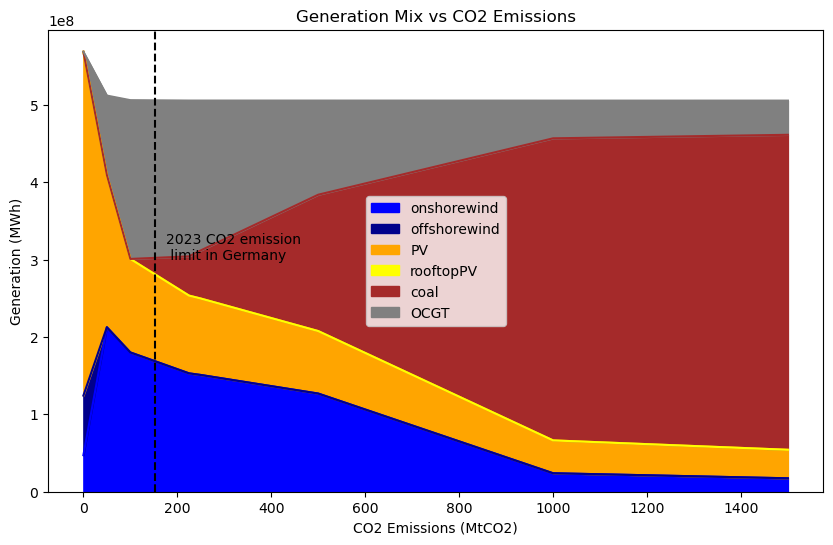

In [49]:
results = pd.DataFrame(
    np.array([onwind, offwind, pv, rooftop, coal, ocgt]).T,
    columns=["onshorewind", "offshorewind", "PV", "rooftopPV", "coal", "OCGT"],
    index=co2_index,
)
results.plot.area(
    stacked=True,
    title="Generation Mix vs CO2 Emissions",
    ylabel="Generation (MWh)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)
plt.vlines(
    152, 0, 6e8, color="black", linestyle="--", label="2023 CO2 emission limit"
)
plt.text(
    175, 3e8, "2023 CO2 emission\n limit in Germany", color="black", fontsize=10, ha="left"
)

#results.to_csv("generation_mix_vs_co2.csv")

<Axes: title={'center': 'Generation Capacity vs CO2 Emissions'}, xlabel='CO2 Emissions (MtCO2)', ylabel='Generation Capacity (MW)'>

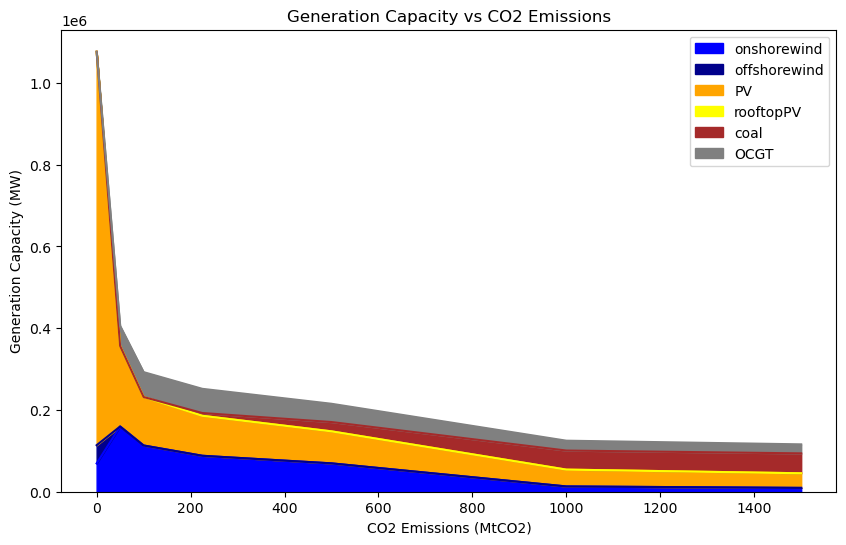

In [50]:
results_cap = pd.DataFrame(
    np.array([onwind_cap, offwind_cap, pv_cap, rooftop_cap, coal_cap, ocgt_cap]).T,
    columns=["onshorewind", "offshorewind", "PV", "rooftopPV", "coal", "OCGT"],
    index=co2_index,
)
results_cap.plot.area(
    stacked=True,
    title="Generation Capacity vs CO2 Emissions",
    ylabel="Generation Capacity (MW)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)

Text(0, 0.5, 'System Cost (million euros)')

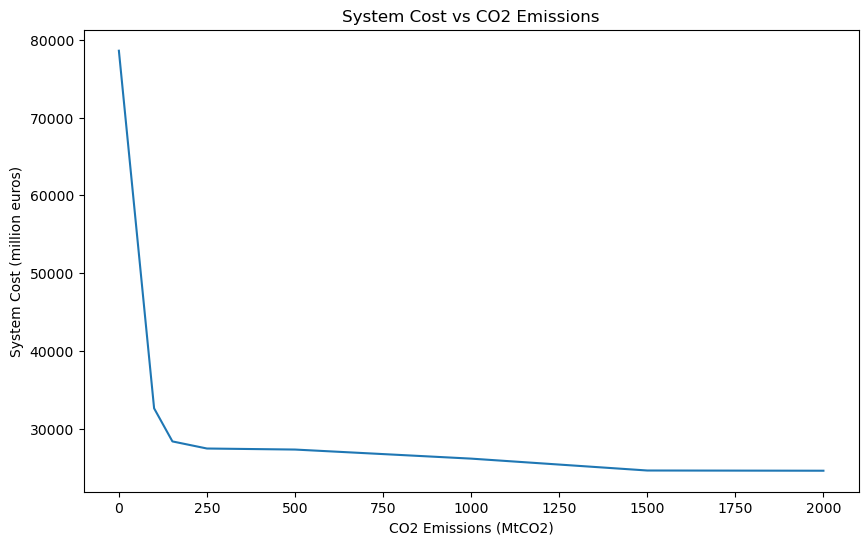

In [51]:
plt.figure(figsize=(10, 6))
plt.plot([2000, 1500, 1000, 500, 250, 152, 100, 0], systemcost)
plt.title("System Cost vs CO2 Emissions")
plt.xlabel("CO2 Emissions (MtCO2)")
plt.ylabel("System Cost (million euros)")

Text(0, 0.5, 'CO2 Tax (EUR/tCO2)')

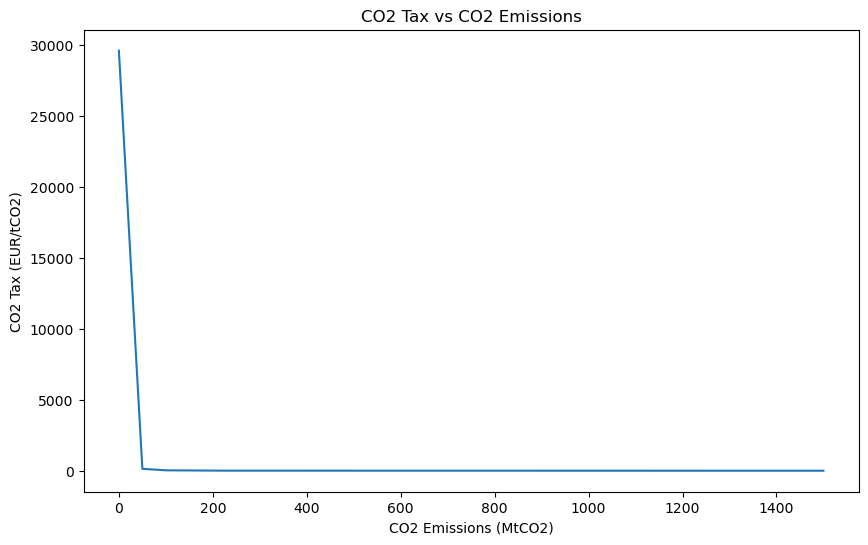

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(co2_index, co2_tax)
plt.title("CO2 Tax vs CO2 Emissions")
plt.xlabel("CO2 Emissions (MtCO2)")
plt.ylabel("CO2 Tax (EUR/tCO2)")